# Testing the network

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

from datetime import datetime, timedelta

import operator

import mpmath as mp
from importlib import reload

from utils import utils, net_lstm_w2v_cutoff_dist_global
from tqdm import tqdm
import random
sns.set(style="whitegrid")


torch.manual_seed(1)

D:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Loading data

In [8]:
reload(utils)
# Getting a list of valid candidates given properties
pep_info = pd.read_pickle("data_inf.pkl")

pep_600 = list(pep_info[(pep_info["length"]>1000)].index)
good_peps = np.loadtxt('good_peps.txt')#,dtype=int)

#Draw random people
train_peps = good_peps[good_peps<=600]
train_peps = np.array(list(set(train_peps).intersection(pep_600)))

train_peps_all = good_peps
train_peps_all = np.array(list(set(train_peps_all).intersection(pep_600)))

train_peps_vali = good_peps[good_peps>600]
train_peps_vali = np.array(list(set(train_peps_vali).intersection(pep_600)))


_, dat_test = utils.load_train_test_set(train_peps,bs=10)
dat_train_both, dat_test_all = utils.load_train_test_set(train_peps_all,bs=10)
_, dat_test_vali = utils.load_train_test_set(train_peps_vali,bs=10)
test_locations = utils.load_locations(train_peps_all) 

In [5]:
len(train_peps)

332

In [6]:
len(train_peps_vali)

51

In [7]:
len(train_peps_all)

383

### Training 

#### Training of the first network

In [3]:
reload(net_lstm)
net = net_lstm.Brain()
net.create_model()
net.epochs = 51
net.train(dat_train_both,dat_test)

Epoch: 1/51 | Avg epoch loss: 4.218 | Training accu: 0.236 | Test loss: 5.386 | Test accu: 0.250 | Test accu old: 0.246 | 
Epoch: 11/51 | Avg epoch loss: 3.684 | Training accu: 0.316 | Test loss: 5.238 | Test accu: 0.277 | Test accu old: 0.277 | 
Epoch: 21/51 | Avg epoch loss: 3.459 | Training accu: 0.321 | Test loss: 5.291 | Test accu: 0.280 | Test accu old: 0.280 | 
Epoch: 31/51 | Avg epoch loss: 3.347 | Training accu: 0.329 | Test loss: 5.335 | Test accu: 0.276 | Test accu old: 0.276 | 
Epoch: 41/51 | Avg epoch loss: 3.270 | Training accu: 0.338 | Test loss: 5.329 | Test accu: 0.278 | Test accu old: 0.278 | 
Epoch: 51/51 | Avg epoch loss: 3.223 | Training accu: 0.343 | Test loss: 5.373 | Test accu: 0.280 | Test accu old: 0.279 | 


In [4]:
net.train(dat_train_both,dat_test)

Epoch: 1/51 | Avg epoch loss: 3.221 | Training accu: 0.343 | Test loss: 5.383 | Test accu: 0.279 | Test accu old: 0.279 | 


KeyboardInterrupt: 

In [ ]:
net.test(dat_test,True)

#### W2V training. Training of the second network

In [45]:
reload(net_lstm_w2v)
net = net_lstm_w2v.Brain()
net.lr = 0.001
net.bs = 10
net.seq_len=100
net.epochs = 100
net.epoch_test = 10

net.create_model()

In [46]:
net.model.load_state_dict(torch.load("Network/network_epoch_0.338_Feb-23-2020"))

<All keys matched successfully>

In [27]:
net.train(dat_train_both,dat_test,early_stop=True)

Epoch: 1/100 | Avg epoch loss: 2.678 | Training accu: 0.225 | Training accu expl: 0.795 | Test loss: 1.789 | Test accu: 0.241 | Test accu expl: 0.838 | Test expl AUC: 0.577 | 
Epoch: 11/100 | Avg epoch loss: 1.940 | Training accu: 0.344 | Training accu expl: 0.800 | Test loss: 1.355 | Test accu: 0.308 | Test accu expl: 0.824 | Test expl AUC: 0.710 | 
Epoch: 21/100 | Avg epoch loss: 1.768 | Training accu: 0.372 | Training accu expl: 0.801 | Test loss: 1.249 | Test accu: 0.324 | Test accu expl: 0.822 | Test expl AUC: 0.711 | 
Epoch: 31/100 | Avg epoch loss: 1.696 | Training accu: 0.383 | Training accu expl: 0.802 | Test loss: 1.226 | Test accu: 0.327 | Test accu expl: 0.821 | Test expl AUC: 0.711 | 
Epoch: 41/100 | Avg epoch loss: 1.648 | Training accu: 0.392 | Training accu expl: 0.803 | Test loss: 1.219 | Test accu: 0.329 | Test accu expl: 0.818 | Test expl AUC: 0.709 | 
Epoch: 51/100 | Avg epoch loss: 1.612 | Training accu: 0.398 | Training accu expl: 0.803 | Test loss: 1.219 | Test a

In [79]:
net.model.load_state_dict(net.best_model)

<All keys matched successfully>

In [47]:
net.test(dat_test)

Test loss: 1.189 | Test accu: 0.337 | Test accu expl: 0.821 | Test expl AUC: 0.712 | 

In [88]:
net.best_model_dict(True)

Returning best model with accuracy: 0.3320005457083189


OrderedDict([('embeddings_rank.weight',
              tensor([[-1.0137e+00, -1.6002e+00,  9.5598e-01,  ...,  4.3194e-01,
                       -5.9131e-01,  1.3211e+00],
                      [ 8.9093e-01,  4.2556e-01, -1.3770e+00,  ...,  2.6996e-01,
                        1.3911e+00, -1.2685e+00],
                      [-1.1141e+00, -1.9029e+00,  3.5138e-01,  ..., -1.1899e+00,
                       -2.4600e-01,  1.1476e+00],
                      ...,
                      [-1.1337e-39, -9.8826e-40, -1.7025e-39,  ..., -4.5182e-40,
                       -1.2973e-41,  1.1894e-39],
                      [ 1.2293e-39,  1.4411e-39, -9.0110e-40,  ..., -1.7458e-39,
                        1.4149e-39,  1.6587e-39],
                      [ 5.3335e-40, -1.7554e-40,  9.7672e-41,  ..., -4.2964e-42,
                       -1.1267e-39,  8.4387e-40]], device='cuda:0')),
             ('embeddings_type.weight',
              tensor([[-2.4991e-01, -3.4171e-02, -1.6335e-01,  ..., -2.9542e-02,
      

## Global network

In [10]:
reload(net_lstm_w2v_cutoff_dist_global)
net = net_lstm_w2v_cutoff_dist_global.Brain()
net.lr = 0.001
net.bs = 10
net.seq_len = 100
net.cut_off = 20
net.epochs = 100
net.epoch_test = 5
net.n_layers = 3

net.create_model()

In [11]:
net.train(dat_train_both,dat_test,early_stop=True,data_loc=test_locations[:,:net.cut_off,:])

Epoch: 1/100 | Avg epoch loss: 2.326 | Training accu: 0.206 | Test loss: 1.981 | Test accu: 0.212 | 
Epoch: 6/100 | Avg epoch loss: 1.446 | Training accu: 0.387 | Test loss: 1.431 | Test accu: 0.329 | 
Epoch: 11/100 | Avg epoch loss: 1.318 | Training accu: 0.414 | Test loss: 1.331 | Test accu: 0.347 | 
Epoch: 16/100 | Avg epoch loss: 1.264 | Training accu: 0.427 | Test loss: 1.300 | Test accu: 0.353 | 
Epoch: 21/100 | Avg epoch loss: 1.221 | Training accu: 0.436 | Test loss: 1.288 | Test accu: 0.355 | 


KeyboardInterrupt: 

#### Checking the importance of initialization of the network

In [43]:
reload(net_lstm_w2v)
accuracy_list = []
accu_best = 0
best_model = None
topk_list = []



np.random.seed(10)
for i in tqdm(range(10)):
    
    net = None
    net = net_lstm_w2v.Brain()
    net.lr = 0.001
    net.bs = 10
    net.seq_len=100
    net.epochs = 100
    net.create_model()
    net.train(dat_train_both,dat_test,early_stop=True)
    
    accuracy_list.append(net.best_accu)
    topk_list.append(net.topk)
    if net.best_accu>accu_best:
        accu_best = net.best_accu
        best_model = net.best_model



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 1/100 | Avg epoch loss: 2.696 | Training accu: 0.224 | Training accu expl: 0.782 | Test loss: 1.760 | Test accu: 0.254 | Test accu expl: 0.838 | Test expl AUC: 0.611 | 
Epoch: 6/100 | Avg epoch loss: 2.029 | Training accu: 0.332 | Training accu expl: 0.799 | Test loss: 1.398 | Test accu: 0.304 | Test accu expl: 0.832 | Test expl AUC: 0.703 | 
Epoch: 11/100 | Avg epoch loss: 1.922 | Training accu: 0.348 | Training accu expl: 0.801 | Test loss: 1.317 | Test accu: 0.314 | Test accu expl: 0.829 | Test expl AUC: 0.709 | 
Epoch: 16/100 | Avg epoch loss: 1.829 | Training accu: 0.362 | Training accu expl: 0.802 | Test loss: 1.263 | Test accu: 0.321 | Test accu expl: 0.826 | Test expl AUC: 0.706 | 
Epoch: 21/100 | Avg epoch loss: 1.755 | Training accu: 0.375 | Training accu expl: 0.802 | Test loss: 1.235 | Test accu: 0.327 | Test accu expl: 0.824 | Test expl AUC: 0.705 | 
Epoch: 26/100 | Avg epoch loss: 1.704 | Training accu: 0.383 | Training accu expl: 0.803 | Test loss: 1.208 | Test ac



 10%|███████▌                                                                    | 1/10 [1:33:34<14:02:12, 5614.70s/it]

Epoch: 1/100 | Avg epoch loss: 2.649 | Training accu: 0.229 | Training accu expl: 0.795 | Test loss: 1.769 | Test accu: 0.247 | Test accu expl: 0.838 | Test expl AUC: 0.627 | 
Epoch: 6/100 | Avg epoch loss: 2.031 | Training accu: 0.330 | Training accu expl: 0.800 | Test loss: 1.409 | Test accu: 0.302 | Test accu expl: 0.830 | Test expl AUC: 0.709 | 
Epoch: 11/100 | Avg epoch loss: 1.912 | Training accu: 0.348 | Training accu expl: 0.801 | Test loss: 1.302 | Test accu: 0.318 | Test accu expl: 0.829 | Test expl AUC: 0.711 | 
Epoch: 16/100 | Avg epoch loss: 1.801 | Training accu: 0.366 | Training accu expl: 0.802 | Test loss: 1.236 | Test accu: 0.327 | Test accu expl: 0.829 | Test expl AUC: 0.714 | 
Epoch: 21/100 | Avg epoch loss: 1.738 | Training accu: 0.376 | Training accu expl: 0.802 | Test loss: 1.205 | Test accu: 0.332 | Test accu expl: 0.829 | Test expl AUC: 0.714 | 
Epoch: 26/100 | Avg epoch loss: 1.695 | Training accu: 0.384 | Training accu expl: 0.802 | Test loss: 1.186 | Test ac



 20%|███████████████▏                                                            | 2/10 [3:07:04<12:28:26, 5613.35s/it]

Epoch: 1/100 | Avg epoch loss: 2.763 | Training accu: 0.205 | Training accu expl: 0.795 | Test loss: 1.864 | Test accu: 0.228 | Test accu expl: 0.838 | Test expl AUC: 0.628 | 
Epoch: 6/100 | Avg epoch loss: 2.025 | Training accu: 0.331 | Training accu expl: 0.799 | Test loss: 1.402 | Test accu: 0.301 | Test accu expl: 0.828 | Test expl AUC: 0.710 | 
Epoch: 11/100 | Avg epoch loss: 1.905 | Training accu: 0.351 | Training accu expl: 0.801 | Test loss: 1.308 | Test accu: 0.317 | Test accu expl: 0.829 | Test expl AUC: 0.713 | 
Epoch: 16/100 | Avg epoch loss: 1.804 | Training accu: 0.368 | Training accu expl: 0.801 | Test loss: 1.244 | Test accu: 0.325 | Test accu expl: 0.828 | Test expl AUC: 0.711 | 
Epoch: 21/100 | Avg epoch loss: 1.742 | Training accu: 0.377 | Training accu expl: 0.801 | Test loss: 1.220 | Test accu: 0.328 | Test accu expl: 0.824 | Test expl AUC: 0.711 | 
Epoch: 26/100 | Avg epoch loss: 1.703 | Training accu: 0.384 | Training accu expl: 0.802 | Test loss: 1.203 | Test ac



 30%|██████████████████████▊                                                     | 3/10 [4:30:44<10:34:06, 5435.16s/it]

Epoch: 1/100 | Avg epoch loss: 2.843 | Training accu: 0.188 | Training accu expl: 0.774 | Test loss: 1.891 | Test accu: 0.219 | Test accu expl: 0.838 | Test expl AUC: 0.604 | 
Epoch: 6/100 | Avg epoch loss: 2.041 | Training accu: 0.328 | Training accu expl: 0.799 | Test loss: 1.419 | Test accu: 0.299 | Test accu expl: 0.829 | Test expl AUC: 0.708 | 
Epoch: 11/100 | Avg epoch loss: 1.926 | Training accu: 0.346 | Training accu expl: 0.800 | Test loss: 1.313 | Test accu: 0.314 | Test accu expl: 0.828 | Test expl AUC: 0.711 | 
Epoch: 16/100 | Avg epoch loss: 1.836 | Training accu: 0.361 | Training accu expl: 0.801 | Test loss: 1.260 | Test accu: 0.323 | Test accu expl: 0.826 | Test expl AUC: 0.711 | 
Epoch: 21/100 | Avg epoch loss: 1.756 | Training accu: 0.374 | Training accu expl: 0.802 | Test loss: 1.224 | Test accu: 0.330 | Test accu expl: 0.821 | Test expl AUC: 0.706 | 
Epoch: 26/100 | Avg epoch loss: 1.703 | Training accu: 0.383 | Training accu expl: 0.803 | Test loss: 1.204 | Test ac



 40%|██████████████████████████████▊                                              | 4/10 [5:54:20<8:50:56, 5309.47s/it]

Epoch: 1/100 | Avg epoch loss: 2.818 | Training accu: 0.192 | Training accu expl: 0.771 | Test loss: 1.976 | Test accu: 0.198 | Test accu expl: 0.838 | Test expl AUC: 0.632 | 
Epoch: 6/100 | Avg epoch loss: 2.033 | Training accu: 0.331 | Training accu expl: 0.800 | Test loss: 1.428 | Test accu: 0.298 | Test accu expl: 0.833 | Test expl AUC: 0.706 | 
Epoch: 11/100 | Avg epoch loss: 1.924 | Training accu: 0.347 | Training accu expl: 0.801 | Test loss: 1.353 | Test accu: 0.308 | Test accu expl: 0.827 | Test expl AUC: 0.708 | 
Epoch: 16/100 | Avg epoch loss: 1.837 | Training accu: 0.361 | Training accu expl: 0.802 | Test loss: 1.285 | Test accu: 0.318 | Test accu expl: 0.822 | Test expl AUC: 0.709 | 
Epoch: 21/100 | Avg epoch loss: 1.770 | Training accu: 0.372 | Training accu expl: 0.802 | Test loss: 1.251 | Test accu: 0.323 | Test accu expl: 0.821 | Test expl AUC: 0.707 | 
Epoch: 26/100 | Avg epoch loss: 1.723 | Training accu: 0.380 | Training accu expl: 0.802 | Test loss: 1.236 | Test ac



 50%|██████████████████████████████████████▌                                      | 5/10 [7:41:53<7:51:02, 5652.49s/it]

Epoch: 1/100 | Avg epoch loss: 2.764 | Training accu: 0.220 | Training accu expl: 0.795 | Test loss: 1.803 | Test accu: 0.250 | Test accu expl: 0.838 | Test expl AUC: 0.630 | 
Epoch: 6/100 | Avg epoch loss: 2.039 | Training accu: 0.328 | Training accu expl: 0.801 | Test loss: 1.419 | Test accu: 0.299 | Test accu expl: 0.826 | Test expl AUC: 0.701 | 
Epoch: 11/100 | Avg epoch loss: 1.927 | Training accu: 0.346 | Training accu expl: 0.802 | Test loss: 1.339 | Test accu: 0.310 | Test accu expl: 0.815 | Test expl AUC: 0.703 | 
Epoch: 16/100 | Avg epoch loss: 1.832 | Training accu: 0.362 | Training accu expl: 0.802 | Test loss: 1.290 | Test accu: 0.318 | Test accu expl: 0.818 | Test expl AUC: 0.704 | 
Epoch: 21/100 | Avg epoch loss: 1.756 | Training accu: 0.375 | Training accu expl: 0.802 | Test loss: 1.248 | Test accu: 0.324 | Test accu expl: 0.813 | Test expl AUC: 0.704 | 
Epoch: 26/100 | Avg epoch loss: 1.710 | Training accu: 0.382 | Training accu expl: 0.803 | Test loss: 1.222 | Test ac



 60%|██████████████████████████████████████████████▏                              | 6/10 [9:21:23<6:23:11, 5747.91s/it]

Epoch: 1/100 | Avg epoch loss: 2.687 | Training accu: 0.214 | Training accu expl: 0.795 | Test loss: 1.800 | Test accu: 0.239 | Test accu expl: 0.838 | Test expl AUC: 0.621 | 
Epoch: 6/100 | Avg epoch loss: 2.015 | Training accu: 0.333 | Training accu expl: 0.799 | Test loss: 1.377 | Test accu: 0.305 | Test accu expl: 0.832 | Test expl AUC: 0.705 | 
Epoch: 11/100 | Avg epoch loss: 1.911 | Training accu: 0.349 | Training accu expl: 0.800 | Test loss: 1.321 | Test accu: 0.314 | Test accu expl: 0.827 | Test expl AUC: 0.710 | 
Epoch: 16/100 | Avg epoch loss: 1.815 | Training accu: 0.364 | Training accu expl: 0.801 | Test loss: 1.260 | Test accu: 0.324 | Test accu expl: 0.830 | Test expl AUC: 0.709 | 
Epoch: 21/100 | Avg epoch loss: 1.749 | Training accu: 0.375 | Training accu expl: 0.802 | Test loss: 1.227 | Test accu: 0.330 | Test accu expl: 0.828 | Test expl AUC: 0.711 | 
Epoch: 26/100 | Avg epoch loss: 1.702 | Training accu: 0.384 | Training accu expl: 0.802 | Test loss: 1.208 | Test ac



 70%|█████████████████████████████████████████████████████▏                      | 7/10 [10:28:52<4:21:53, 5237.98s/it]

Epoch: 1/100 | Avg epoch loss: 2.700 | Training accu: 0.223 | Training accu expl: 0.786 | Test loss: 1.727 | Test accu: 0.256 | Test accu expl: 0.838 | Test expl AUC: 0.594 | 
Epoch: 6/100 | Avg epoch loss: 2.022 | Training accu: 0.333 | Training accu expl: 0.799 | Test loss: 1.392 | Test accu: 0.304 | Test accu expl: 0.827 | Test expl AUC: 0.707 | 
Epoch: 11/100 | Avg epoch loss: 1.902 | Training accu: 0.352 | Training accu expl: 0.800 | Test loss: 1.311 | Test accu: 0.316 | Test accu expl: 0.827 | Test expl AUC: 0.710 | 
Epoch: 16/100 | Avg epoch loss: 1.810 | Training accu: 0.367 | Training accu expl: 0.801 | Test loss: 1.252 | Test accu: 0.325 | Test accu expl: 0.827 | Test expl AUC: 0.708 | 
Epoch: 21/100 | Avg epoch loss: 1.746 | Training accu: 0.377 | Training accu expl: 0.802 | Test loss: 1.216 | Test accu: 0.331 | Test accu expl: 0.826 | Test expl AUC: 0.709 | 
Epoch: 26/100 | Avg epoch loss: 1.702 | Training accu: 0.384 | Training accu expl: 0.802 | Test loss: 1.197 | Test ac



 80%|████████████████████████████████████████████████████████████▊               | 8/10 [11:44:26<2:47:33, 5026.80s/it]

Epoch: 1/100 | Avg epoch loss: 2.757 | Training accu: 0.206 | Training accu expl: 0.795 | Test loss: 1.820 | Test accu: 0.235 | Test accu expl: 0.838 | Test expl AUC: 0.579 | 
Epoch: 6/100 | Avg epoch loss: 2.029 | Training accu: 0.332 | Training accu expl: 0.800 | Test loss: 1.407 | Test accu: 0.303 | Test accu expl: 0.822 | Test expl AUC: 0.702 | 
Epoch: 11/100 | Avg epoch loss: 1.917 | Training accu: 0.347 | Training accu expl: 0.801 | Test loss: 1.321 | Test accu: 0.313 | Test accu expl: 0.812 | Test expl AUC: 0.702 | 
Epoch: 16/100 | Avg epoch loss: 1.818 | Training accu: 0.364 | Training accu expl: 0.802 | Test loss: 1.267 | Test accu: 0.321 | Test accu expl: 0.817 | Test expl AUC: 0.700 | 
Epoch: 21/100 | Avg epoch loss: 1.745 | Training accu: 0.376 | Training accu expl: 0.802 | Test loss: 1.242 | Test accu: 0.325 | Test accu expl: 0.809 | Test expl AUC: 0.699 | 
Epoch: 26/100 | Avg epoch loss: 1.702 | Training accu: 0.383 | Training accu expl: 0.802 | Test loss: 1.237 | Test ac



 90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [13:16:10<1:26:10, 5170.02s/it]

Epoch: 1/100 | Avg epoch loss: 2.708 | Training accu: 0.225 | Training accu expl: 0.794 | Test loss: 1.753 | Test accu: 0.254 | Test accu expl: 0.838 | Test expl AUC: 0.581 | 
Epoch: 6/100 | Avg epoch loss: 2.024 | Training accu: 0.331 | Training accu expl: 0.799 | Test loss: 1.399 | Test accu: 0.303 | Test accu expl: 0.833 | Test expl AUC: 0.707 | 
Epoch: 11/100 | Avg epoch loss: 1.897 | Training accu: 0.352 | Training accu expl: 0.801 | Test loss: 1.305 | Test accu: 0.317 | Test accu expl: 0.827 | Test expl AUC: 0.707 | 
Epoch: 16/100 | Avg epoch loss: 1.799 | Training accu: 0.367 | Training accu expl: 0.802 | Test loss: 1.246 | Test accu: 0.325 | Test accu expl: 0.822 | Test expl AUC: 0.706 | 
Epoch: 21/100 | Avg epoch loss: 1.734 | Training accu: 0.378 | Training accu expl: 0.802 | Test loss: 1.215 | Test accu: 0.330 | Test accu expl: 0.822 | Test expl AUC: 0.706 | 
Epoch: 26/100 | Avg epoch loss: 1.691 | Training accu: 0.386 | Training accu expl: 0.803 | Test loss: 1.202 | Test ac



100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [15:03:04<00:00, 5418.45s/it]


In [44]:
utils.save_model(best_model,accuracy_list)

In [45]:
accuracy_list

[0.33692221781378495,
 0.33794733794897697,
 0.3369333716446912,
 0.33718815677535047,
 0.3352445378387632,
 0.33355635437495956,
 0.33488160277831247,
 0.33630731677097087,
 0.3324581058500364,
 0.33572183268674616]

In [46]:
print(max(accuracy_list))
print(min(accuracy_list))
print(np.mean(accuracy_list))

0.33794733794897697
0.3324581058500364
0.3357160834482592


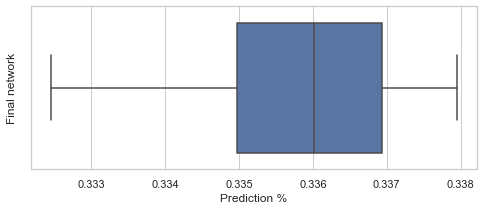

In [48]:
gridsize = (1,1)
fig, ax = plt.subplots(figsize=(8,3))
sns.boxplot(x=[accuracy_list], whis="range",ax=ax)
ax.set(xlabel="Prediction %", ylabel="Final network")
fig.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\network_pred_box.eps', format='eps', dpi=1200)
plt.show()

In [50]:
import pickle

In [51]:
with open("best_acc_top_k.pkl", "wb") as f:
    pickle.dump([accuracy_list,topk_list],f)

In [52]:
with open("best_acc_top_k.pkl", "rb") as f:
    test_tmp = pickle.load(f)

In [53]:
top_k_means = {3:[],5:[]}
for i in topk_list:
    top_k_means[3].append(np.mean(i[3]))
    top_k_means[5].append(np.mean(i[5]))
top_k_means[1] = accuracy_list

In [56]:
top_k_means

{3: [0.4474265607642133,
  0.4473467052002677,
  0.44911940323303184,
  0.44677807521125096,
  0.4476105120585435,
  0.44665634347047023,
  0.4499583950870296,
  0.4485188199477998,
  0.4465471892687843,
  0.4470143153985351],
 5: [0.4916502376490523,
  0.4917954174335735,
  0.4931897189662291,
  0.4924806231787806,
  0.4926463302968928,
  0.49147771959702513,
  0.4934578761046621,
  0.49299484454085196,
  0.49158805361460356,
  0.4917750533985325],
 1: [0.3344142555803923,
  0.33189560180083744,
  0.3332598725980963,
  0.3336901426187703,
  0.3328086137959261,
  0.33076220760003777,
  0.3350019414622884,
  0.33235735499375585,
  0.3322314223047781,
  0.3333228389425852]}

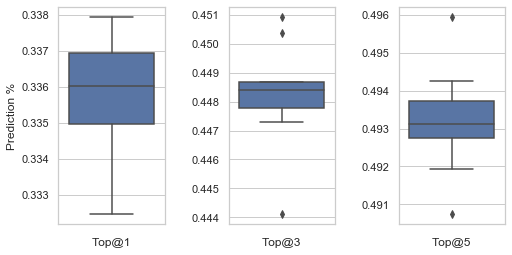

In [54]:
df = pd.DataFrame(top_k_means)

gridsize = (1,3)
fig, ax = plt.subplots(1,3,figsize=(8,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.3)
sns.boxplot(x=df[1], ax=ax[0],orient="v")
sns.boxplot(x=df[3], ax=ax[1],orient="v")
sns.boxplot(x=df[5], ax=ax[2],orient="v")
ax[0].set(ylabel="Prediction %", xlabel="Top@1")
ax[1].set(xlabel="Top@3",ylabel="")
ax[2].set(xlabel="Top@5",ylabel="")
fig.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\network_pred_box_topk.eps', format='eps', dpi=1200)

plt.show()

In [55]:
test_tmp[0]

[0.33692221781378495,
 0.33794733794897697,
 0.3369333716446912,
 0.33718815677535047,
 0.3352445378387632,
 0.33355635437495956,
 0.33488160277831247,
 0.33630731677097087,
 0.3324581058500364,
 0.33572183268674616]

In [7]:
net.topk

{3: [0.5477178423236515,
  0.42483660130718953,
  0.3333333333333333,
  0.7908496732026143,
  0.4975845410628019,
  0.5636363636363636,
  0.42063492063492064,
  0.6044776119402985,
  0.5307692307692308,
  0.43455497382198954,
  0.64,
  0.5517241379310345,
  0.30344827586206896,
  0.4857142857142857,
  0.5362318840579711,
  0.13636363636363635,
  0.6611570247933884,
  0.49606299212598426,
  0.31986531986531985,
  0.28717948717948716,
  0.7192982456140351,
  0.5517241379310345,
  0.4069264069264069,
  0.3007518796992481,
  0.4752475247524752,
  0.45408163265306123,
  0.5446428571428571,
  0.35294117647058826,
  0.27876106194690264,
  0.42201834862385323,
  0.573076923076923,
  0.38181818181818183,
  0.3813559322033898,
  0.7142857142857143,
  0.3698630136986301,
  0.4485294117647059,
  0.4358974358974359,
  0.484,
  0.6633333333333333,
  0.4827586206896552,
  0.5227272727272727,
  0.3670212765957447,
  0.44206008583690987,
  0.556390977443609,
  0.4564102564102564,
  0.7254901960784313,


In [39]:
np.mean(net.topk[3])

0.4476905506295518

In [40]:
np.mean(net.topk[5])

0.49195205230946115

In [56]:
res_start = net.test(dat_test,True)

Test loss: 1.185 | Test accu: 0.338 | Test accu expl: 0.821 | Test expl AUC: 0.711 | 

In [58]:
from sklearn.metrics import roc_curve, auc

In [61]:
fpr, tpr, _ = roc_curve(net.auc['y'], np.array(net.auc['prob']))
roc_auc = auc(fpr, tpr)

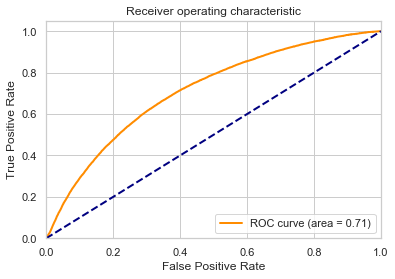

In [62]:
f = plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

f.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\ROC.png', format='png', dpi=300)


# Transfer

In [16]:
import warnings; warnings.simplefilter('once')


In [17]:
path = "Network/network_epoch_0.338_Feb-23-2020"

reload(net_lstm_w2v)
net_trans = net_lstm_w2v.Brain()
net_trans.create_model()

In [18]:
dat_train_both_trans,dat_test_trans = utils.load_train_test_set(train_peps)
    

In [19]:
total_epoch = 12
bs_trans = 1 
epochs_trans = 2
topk = {i:{3:[],5:[]} for i in range(0,total_epoch,epochs_trans)}
dict_tmp = {i:{} for i in range(0,total_epoch,epochs_trans)}
for pep_trans in tqdm(train_peps):
    
    net_trans = net_lstm_w2v.Brain()
    net_trans.create_model()
    
    net_trans.model.load_state_dict(torch.load(path))
    net_trans.bs = bs_trans
    net_trans.epochs = epochs_trans
    net_trans.seq_len=100
    
    dat_train_both_trans,dat_test_trans = utils.load_train_test_set([pep_trans])
    
    for i in range(0,total_epoch,epochs_trans):
        net_trans.train(dat_train_both_trans,dat_test_trans)
        dict_tmp[i].update(net_trans.test(dat_test_trans,True)[0])
        topk[i][3].append(np.mean(net_trans.topk[3]))
        topk[i][5].append(np.mean(net_trans.topk[5]))

  0%|                                                                                          | 0/427 [00:00<?, ?it/s]

Epoch: 1/2 | Avg epoch loss: 1.129 | Training accu: 0.457 | Training accu expl: 0.784 | Test loss: 0.821 | Test accu: 0.432 | Test accu expl: 0.768 | Test expl AUC: 0.705 | 
Test loss: 0.826 | Test accu: 0.432 | Test accu expl: 0.763 | Test expl AUC: 0.713 | Epoch: 1/2 | Avg epoch loss: 1.055 | Training accu: 0.466 | Training accu expl: 0.780 | Test loss: 0.794 | Test accu: 0.427 | Test accu expl: 0.772 | Test expl AUC: 0.714 | 
Test loss: 0.838 | Test accu: 0.436 | Test accu expl: 0.751 | Test expl AUC: 0.717 | Epoch: 1/2 | Avg epoch loss: 1.002 | Training accu: 0.476 | Training accu expl: 0.789 | Test loss: 0.818 | Test accu: 0.436 | Test accu expl: 0.772 | Test expl AUC: 0.722 | 
Test loss: 0.830 | Test accu: 0.436 | Test accu expl: 0.763 | Test expl AUC: 0.726 | Epoch: 1/2 | Avg epoch loss: 0.970 | Training accu: 0.485 | Training accu expl: 0.795 | Test loss: 0.811 | Test accu: 0.436 | Test accu expl: 0.768 | Test expl AUC: 0.732 | 
Test loss: 0.841 | Test accu: 0.427 | Test accu e

  0%|▏                                                                               | 1/427 [00:17<2:04:47, 17.58s/it]

Epoch: 1/2 | Avg epoch loss: 1.478 | Training accu: 0.493 | Training accu expl: 0.871 | Test loss: 1.450 | Test accu: 0.301 | Test accu expl: 0.830 | Test expl AUC: 0.727 | 
Test loss: 1.419 | Test accu: 0.307 | Test accu expl: 0.830 | Test expl AUC: 0.724 | Epoch: 1/2 | Avg epoch loss: 1.399 | Training accu: 0.505 | Training accu expl: 0.871 | Test loss: 1.438 | Test accu: 0.307 | Test accu expl: 0.830 | Test expl AUC: 0.724 | 
Test loss: 1.434 | Test accu: 0.307 | Test accu expl: 0.830 | Test expl AUC: 0.721 | Epoch: 1/2 | Avg epoch loss: 1.392 | Training accu: 0.513 | Training accu expl: 0.866 | Test loss: 1.446 | Test accu: 0.307 | Test accu expl: 0.830 | Test expl AUC: 0.722 | 
Test loss: 1.448 | Test accu: 0.307 | Test accu expl: 0.830 | Test expl AUC: 0.721 | Epoch: 1/2 | Avg epoch loss: 1.357 | Training accu: 0.521 | Training accu expl: 0.871 | Test loss: 1.455 | Test accu: 0.294 | Test accu expl: 0.830 | Test expl AUC: 0.722 | 
Test loss: 1.471 | Test accu: 0.294 | Test accu e

  0%|▎                                                                               | 2/427 [00:28<1:50:45, 15.64s/it]

Epoch: 1/2 | Avg epoch loss: 1.922 | Training accu: 0.328 | Training accu expl: 0.771 | Test loss: 1.803 | Test accu: 0.190 | Test accu expl: 0.771 | Test expl AUC: 0.551 | 
Test loss: 1.769 | Test accu: 0.196 | Test accu expl: 0.771 | Test expl AUC: 0.547 | Epoch: 1/2 | Avg epoch loss: 1.830 | Training accu: 0.342 | Training accu expl: 0.766 | Test loss: 1.768 | Test accu: 0.190 | Test accu expl: 0.725 | Test expl AUC: 0.548 | 
Test loss: 1.770 | Test accu: 0.196 | Test accu expl: 0.745 | Test expl AUC: 0.558 | Epoch: 1/2 | Avg epoch loss: 1.780 | Training accu: 0.348 | Training accu expl: 0.777 | Test loss: 1.756 | Test accu: 0.190 | Test accu expl: 0.745 | Test expl AUC: 0.560 | 
Test loss: 1.756 | Test accu: 0.196 | Test accu expl: 0.739 | Test expl AUC: 0.564 | Epoch: 1/2 | Avg epoch loss: 1.744 | Training accu: 0.357 | Training accu expl: 0.781 | Test loss: 1.767 | Test accu: 0.203 | Test accu expl: 0.745 | Test expl AUC: 0.566 | 
Test loss: 1.767 | Test accu: 0.203 | Test accu e

  1%|▌                                                                               | 3/427 [00:39<1:40:40, 14.25s/it]

Epoch: 1/2 | Avg epoch loss: 1.253 | Training accu: 0.545 | Training accu expl: 0.885 | Test loss: 1.058 | Test accu: 0.601 | Test accu expl: 0.931 | Test expl AUC: 0.781 | 
Test loss: 1.032 | Test accu: 0.605 | Test accu expl: 0.931 | Test expl AUC: 0.786 | Epoch: 1/2 | Avg epoch loss: 1.218 | Training accu: 0.561 | Training accu expl: 0.888 | Test loss: 1.022 | Test accu: 0.608 | Test accu expl: 0.931 | Test expl AUC: 0.791 | 
Test loss: 1.010 | Test accu: 0.601 | Test accu expl: 0.931 | Test expl AUC: 0.795 | Epoch: 1/2 | Avg epoch loss: 1.201 | Training accu: 0.560 | Training accu expl: 0.881 | Test loss: 1.002 | Test accu: 0.605 | Test accu expl: 0.938 | Test expl AUC: 0.797 | 
Test loss: 0.990 | Test accu: 0.605 | Test accu expl: 0.935 | Test expl AUC: 0.803 | Epoch: 1/2 | Avg epoch loss: 1.169 | Training accu: 0.568 | Training accu expl: 0.885 | Test loss: 0.989 | Test accu: 0.605 | Test accu expl: 0.931 | Test expl AUC: 0.808 | 
Test loss: 0.971 | Test accu: 0.601 | Test accu e

  1%|▋                                                                               | 4/427 [01:01<1:57:22, 16.65s/it]

Epoch: 1/2 | Avg epoch loss: 1.505 | Training accu: 0.424 | Training accu expl: 0.832 | Test loss: 0.684 | Test accu: 0.401 | Test accu expl: 0.865 | Test expl AUC: 0.714 | 
Test loss: 0.679 | Test accu: 0.411 | Test accu expl: 0.855 | Test expl AUC: 0.716 | Epoch: 1/2 | Avg epoch loss: 1.402 | Training accu: 0.444 | Training accu expl: 0.833 | Test loss: 0.680 | Test accu: 0.411 | Test accu expl: 0.855 | Test expl AUC: 0.718 | 
Test loss: 0.675 | Test accu: 0.415 | Test accu expl: 0.845 | Test expl AUC: 0.722 | Epoch: 1/2 | Avg epoch loss: 1.357 | Training accu: 0.455 | Training accu expl: 0.824 | Test loss: 0.681 | Test accu: 0.406 | Test accu expl: 0.841 | Test expl AUC: 0.724 | 
Test loss: 0.686 | Test accu: 0.406 | Test accu expl: 0.845 | Test expl AUC: 0.723 | Epoch: 1/2 | Avg epoch loss: 1.306 | Training accu: 0.466 | Training accu expl: 0.824 | Test loss: 0.673 | Test accu: 0.415 | Test accu expl: 0.845 | Test expl AUC: 0.724 | 
Test loss: 0.687 | Test accu: 0.411 | Test accu e

  1%|▉                                                                               | 5/427 [01:17<1:53:59, 16.21s/it]

Epoch: 1/2 | Avg epoch loss: 1.682 | Training accu: 0.403 | Training accu expl: 0.837 | Test loss: 1.359 | Test accu: 0.418 | Test accu expl: 0.927 | Test expl AUC: 0.446 | 
Test loss: 1.295 | Test accu: 0.427 | Test accu expl: 0.927 | Test expl AUC: 0.458 | Epoch: 1/2 | Avg epoch loss: 1.593 | Training accu: 0.422 | Training accu expl: 0.833 | Test loss: 1.290 | Test accu: 0.427 | Test accu expl: 0.927 | Test expl AUC: 0.468 | 
Test loss: 1.255 | Test accu: 0.436 | Test accu expl: 0.927 | Test expl AUC: 0.470 | Epoch: 1/2 | Avg epoch loss: 1.551 | Training accu: 0.433 | Training accu expl: 0.835 | Test loss: 1.261 | Test accu: 0.445 | Test accu expl: 0.927 | Test expl AUC: 0.487 | 
Test loss: 1.229 | Test accu: 0.445 | Test accu expl: 0.918 | Test expl AUC: 0.492 | Epoch: 1/2 | Avg epoch loss: 1.362 | Training accu: 0.446 | Training accu expl: 0.843 | Test loss: 1.194 | Test accu: 0.436 | Test accu expl: 0.918 | Test expl AUC: 0.497 | 
Test loss: 1.211 | Test accu: 0.427 | Test accu e

  1%|█                                                                               | 6/427 [01:25<1:37:02, 13.83s/it]

Epoch: 1/2 | Avg epoch loss: 1.590 | Training accu: 0.410 | Training accu expl: 0.792 | Test loss: 1.175 | Test accu: 0.294 | Test accu expl: 0.774 | Test expl AUC: 0.768 | 
Test loss: 1.179 | Test accu: 0.298 | Test accu expl: 0.786 | Test expl AUC: 0.774 | Epoch: 1/2 | Avg epoch loss: 1.499 | Training accu: 0.424 | Training accu expl: 0.797 | Test loss: 1.102 | Test accu: 0.310 | Test accu expl: 0.790 | Test expl AUC: 0.771 | 
Test loss: 1.095 | Test accu: 0.302 | Test accu expl: 0.794 | Test expl AUC: 0.777 | Epoch: 1/2 | Avg epoch loss: 1.423 | Training accu: 0.434 | Training accu expl: 0.799 | Test loss: 1.153 | Test accu: 0.306 | Test accu expl: 0.790 | Test expl AUC: 0.782 | 
Test loss: 1.121 | Test accu: 0.306 | Test accu expl: 0.786 | Test expl AUC: 0.779 | Epoch: 1/2 | Avg epoch loss: 1.381 | Training accu: 0.441 | Training accu expl: 0.801 | Test loss: 1.102 | Test accu: 0.306 | Test accu expl: 0.786 | Test expl AUC: 0.777 | 
Test loss: 1.154 | Test accu: 0.306 | Test accu e

  2%|█▎                                                                              | 7/427 [01:43<1:46:22, 15.20s/it]

Epoch: 1/2 | Avg epoch loss: 1.352 | Training accu: 0.558 | Training accu expl: 0.798 | Test loss: 0.740 | Test accu: 0.455 | Test accu expl: 0.813 | Test expl AUC: 0.648 | 
Test loss: 0.728 | Test accu: 0.448 | Test accu expl: 0.806 | Test expl AUC: 0.647 | Epoch: 1/2 | Avg epoch loss: 1.236 | Training accu: 0.574 | Training accu expl: 0.796 | Test loss: 0.728 | Test accu: 0.455 | Test accu expl: 0.799 | Test expl AUC: 0.648 | 
Test loss: 0.719 | Test accu: 0.463 | Test accu expl: 0.806 | Test expl AUC: 0.647 | Epoch: 1/2 | Avg epoch loss: 1.220 | Training accu: 0.582 | Training accu expl: 0.803 | Test loss: 0.722 | Test accu: 0.463 | Test accu expl: 0.813 | Test expl AUC: 0.647 | 
Test loss: 0.720 | Test accu: 0.455 | Test accu expl: 0.791 | Test expl AUC: 0.640 | Epoch: 1/2 | Avg epoch loss: 1.156 | Training accu: 0.591 | Training accu expl: 0.810 | Test loss: 0.716 | Test accu: 0.455 | Test accu expl: 0.799 | Test expl AUC: 0.641 | 
Test loss: 0.728 | Test accu: 0.455 | Test accu e

  2%|█▍                                                                              | 8/427 [01:53<1:34:52, 13.58s/it]

Epoch: 1/2 | Avg epoch loss: 1.944 | Training accu: 0.283 | Training accu expl: 0.782 | Test loss: 1.804 | Test accu: 0.231 | Test accu expl: 0.892 | Test expl AUC: 0.849 | 
Test loss: 1.819 | Test accu: 0.185 | Test accu expl: 0.885 | Test expl AUC: 0.839 | Epoch: 1/2 | Avg epoch loss: 1.839 | Training accu: 0.304 | Training accu expl: 0.777 | Test loss: 1.806 | Test accu: 0.208 | Test accu expl: 0.892 | Test expl AUC: 0.839 | 
Test loss: 1.804 | Test accu: 0.192 | Test accu expl: 0.892 | Test expl AUC: 0.830 | Epoch: 1/2 | Avg epoch loss: 1.793 | Training accu: 0.314 | Training accu expl: 0.779 | Test loss: 1.850 | Test accu: 0.208 | Test accu expl: 0.885 | Test expl AUC: 0.828 | 
Test loss: 1.791 | Test accu: 0.215 | Test accu expl: 0.892 | Test expl AUC: 0.826 | Epoch: 1/2 | Avg epoch loss: 1.725 | Training accu: 0.325 | Training accu expl: 0.782 | Test loss: 1.881 | Test accu: 0.177 | Test accu expl: 0.885 | Test expl AUC: 0.820 | 
Test loss: 1.793 | Test accu: 0.208 | Test accu e

  2%|█▋                                                                              | 9/427 [02:03<1:26:48, 12.46s/it]

Epoch: 1/2 | Avg epoch loss: 1.728 | Training accu: 0.355 | Training accu expl: 0.792 | Test loss: 1.439 | Test accu: 0.262 | Test accu expl: 0.817 | Test expl AUC: 0.723 | 
Test loss: 1.415 | Test accu: 0.267 | Test accu expl: 0.822 | Test expl AUC: 0.721 | Epoch: 1/2 | Avg epoch loss: 1.651 | Training accu: 0.370 | Training accu expl: 0.787 | Test loss: 1.417 | Test accu: 0.267 | Test accu expl: 0.822 | Test expl AUC: 0.726 | 
Test loss: 1.370 | Test accu: 0.277 | Test accu expl: 0.822 | Test expl AUC: 0.726 | Epoch: 1/2 | Avg epoch loss: 1.602 | Training accu: 0.376 | Training accu expl: 0.788 | Test loss: 1.418 | Test accu: 0.267 | Test accu expl: 0.817 | Test expl AUC: 0.729 | 
Test loss: 1.377 | Test accu: 0.283 | Test accu expl: 0.812 | Test expl AUC: 0.731 | Epoch: 1/2 | Avg epoch loss: 1.546 | Training accu: 0.382 | Training accu expl: 0.791 | Test loss: 1.385 | Test accu: 0.272 | Test accu expl: 0.806 | Test expl AUC: 0.725 | 
Test loss: 1.409 | Test accu: 0.283 | Test accu e

  2%|█▊                                                                             | 10/427 [02:17<1:29:56, 12.94s/it]

Epoch: 1/2 | Avg epoch loss: 1.364 | Training accu: 0.539 | Training accu expl: 0.862 | Test loss: 0.976 | Test accu: 0.495 | Test accu expl: 0.810 | Test expl AUC: 0.827 | 
Test loss: 0.936 | Test accu: 0.510 | Test accu expl: 0.795 | Test expl AUC: 0.828 | Epoch: 1/2 | Avg epoch loss: 1.293 | Training accu: 0.552 | Training accu expl: 0.865 | Test loss: 0.926 | Test accu: 0.510 | Test accu expl: 0.795 | Test expl AUC: 0.828 | 
Test loss: 0.918 | Test accu: 0.510 | Test accu expl: 0.795 | Test expl AUC: 0.826 | Epoch: 1/2 | Avg epoch loss: 1.346 | Training accu: 0.551 | Training accu expl: 0.865 | Test loss: 0.903 | Test accu: 0.520 | Test accu expl: 0.805 | Test expl AUC: 0.827 | 
Test loss: 0.899 | Test accu: 0.530 | Test accu expl: 0.805 | Test expl AUC: 0.826 | Epoch: 1/2 | Avg epoch loss: 1.315 | Training accu: 0.558 | Training accu expl: 0.868 | Test loss: 0.888 | Test accu: 0.535 | Test accu expl: 0.805 | Test expl AUC: 0.826 | 
Test loss: 0.886 | Test accu: 0.530 | Test accu e

  3%|██                                                                             | 11/427 [02:32<1:33:07, 13.43s/it]

Epoch: 1/2 | Avg epoch loss: 1.549 | Training accu: 0.497 | Training accu expl: 0.848 | Test loss: 1.310 | Test accu: 0.366 | Test accu expl: 0.772 | Test expl AUC: 0.702 | 
Test loss: 1.296 | Test accu: 0.349 | Test accu expl: 0.772 | Test expl AUC: 0.698 | Epoch: 1/2 | Avg epoch loss: 1.467 | Training accu: 0.504 | Training accu expl: 0.847 | Test loss: 1.284 | Test accu: 0.353 | Test accu expl: 0.767 | Test expl AUC: 0.697 | 
Test loss: 1.286 | Test accu: 0.362 | Test accu expl: 0.776 | Test expl AUC: 0.695 | Epoch: 1/2 | Avg epoch loss: 1.436 | Training accu: 0.515 | Training accu expl: 0.847 | Test loss: 1.291 | Test accu: 0.358 | Test accu expl: 0.776 | Test expl AUC: 0.693 | 
Test loss: 1.302 | Test accu: 0.353 | Test accu expl: 0.772 | Test expl AUC: 0.694 | Epoch: 1/2 | Avg epoch loss: 1.418 | Training accu: 0.518 | Training accu expl: 0.849 | Test loss: 1.299 | Test accu: 0.358 | Test accu expl: 0.772 | Test expl AUC: 0.694 | 
Test loss: 1.310 | Test accu: 0.362 | Test accu e

  3%|██▏                                                                            | 12/427 [02:48<1:39:52, 14.44s/it]

Epoch: 1/2 | Avg epoch loss: 1.691 | Training accu: 0.327 | Training accu expl: 0.680 | Test loss: 0.785 | Test accu: 0.241 | Test accu expl: 0.552 | Test expl AUC: 0.608 | 
Test loss: 0.751 | Test accu: 0.248 | Test accu expl: 0.572 | Test expl AUC: 0.611 | Epoch: 1/2 | Avg epoch loss: 1.623 | Training accu: 0.334 | Training accu expl: 0.680 | Test loss: 0.741 | Test accu: 0.248 | Test accu expl: 0.586 | Test expl AUC: 0.611 | 
Test loss: 0.738 | Test accu: 0.248 | Test accu expl: 0.545 | Test expl AUC: 0.608 | Epoch: 1/2 | Avg epoch loss: 1.562 | Training accu: 0.338 | Training accu expl: 0.688 | Test loss: 0.734 | Test accu: 0.248 | Test accu expl: 0.559 | Test expl AUC: 0.608 | 
Test loss: 0.742 | Test accu: 0.248 | Test accu expl: 0.559 | Test expl AUC: 0.611 | Epoch: 1/2 | Avg epoch loss: 1.513 | Training accu: 0.344 | Training accu expl: 0.686 | Test loss: 0.749 | Test accu: 0.248 | Test accu expl: 0.566 | Test expl AUC: 0.614 | 
Test loss: 0.746 | Test accu: 0.248 | Test accu e

  3%|██▍                                                                            | 13/427 [02:59<1:31:20, 13.24s/it]

Epoch: 1/2 | Avg epoch loss: 1.908 | Training accu: 0.324 | Training accu expl: 0.839 | Test loss: 1.633 | Test accu: 0.263 | Test accu expl: 0.857 | Test expl AUC: 0.680 | 
Test loss: 1.591 | Test accu: 0.269 | Test accu expl: 0.851 | Test expl AUC: 0.668 | Epoch: 1/2 | Avg epoch loss: 1.813 | Training accu: 0.342 | Training accu expl: 0.836 | Test loss: 1.603 | Test accu: 0.269 | Test accu expl: 0.857 | Test expl AUC: 0.666 | 
Test loss: 1.612 | Test accu: 0.269 | Test accu expl: 0.869 | Test expl AUC: 0.663 | Epoch: 1/2 | Avg epoch loss: 1.748 | Training accu: 0.354 | Training accu expl: 0.841 | Test loss: 1.604 | Test accu: 0.274 | Test accu expl: 0.869 | Test expl AUC: 0.660 | 
Test loss: 1.603 | Test accu: 0.297 | Test accu expl: 0.869 | Test expl AUC: 0.664 | Epoch: 1/2 | Avg epoch loss: 1.710 | Training accu: 0.358 | Training accu expl: 0.840 | Test loss: 1.616 | Test accu: 0.280 | Test accu expl: 0.869 | Test expl AUC: 0.661 | 
Test loss: 1.614 | Test accu: 0.291 | Test accu e

  3%|██▌                                                                            | 14/427 [03:11<1:29:48, 13.05s/it]

Epoch: 1/2 | Avg epoch loss: 1.632 | Training accu: 0.463 | Training accu expl: 0.807 | Test loss: 1.377 | Test accu: 0.464 | Test accu expl: 0.891 | Test expl AUC: 0.544 | 
Test loss: 1.419 | Test accu: 0.464 | Test accu expl: 0.891 | Test expl AUC: 0.556 | Epoch: 1/2 | Avg epoch loss: 1.571 | Training accu: 0.475 | Training accu expl: 0.802 | Test loss: 1.381 | Test accu: 0.457 | Test accu expl: 0.891 | Test expl AUC: 0.556 | 
Test loss: 1.407 | Test accu: 0.464 | Test accu expl: 0.891 | Test expl AUC: 0.550 | Epoch: 1/2 | Avg epoch loss: 1.486 | Training accu: 0.496 | Training accu expl: 0.810 | Test loss: 1.368 | Test accu: 0.464 | Test accu expl: 0.891 | Test expl AUC: 0.565 | 
Test loss: 1.421 | Test accu: 0.471 | Test accu expl: 0.891 | Test expl AUC: 0.566 | Epoch: 1/2 | Avg epoch loss: 1.449 | Training accu: 0.495 | Training accu expl: 0.812 | Test loss: 1.378 | Test accu: 0.464 | Test accu expl: 0.891 | Test expl AUC: 0.572 | 
Test loss: 1.404 | Test accu: 0.478 | Test accu e

  4%|██▊                                                                            | 15/427 [03:21<1:23:26, 12.15s/it]

Epoch: 1/2 | Avg epoch loss: 1.631 | Training accu: 0.381 | Training accu expl: 0.831 | Test loss: 0.204 | Test accu: 0.123 | Test accu expl: 0.727 | Test expl AUC: 0.657 | 
Test loss: 0.201 | Test accu: 0.123 | Test accu expl: 0.736 | Test expl AUC: 0.642 | Epoch: 1/2 | Avg epoch loss: 1.531 | Training accu: 0.419 | Training accu expl: 0.829 | Test loss: 0.194 | Test accu: 0.123 | Test accu expl: 0.727 | Test expl AUC: 0.630 | 
Test loss: 0.180 | Test accu: 0.127 | Test accu expl: 0.727 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.471 | Training accu: 0.429 | Training accu expl: 0.832 | Test loss: 0.180 | Test accu: 0.127 | Test accu expl: 0.705 | Test expl AUC: 0.604 | 
Test loss: 0.191 | Test accu: 0.127 | Test accu expl: 0.705 | Test expl AUC: 0.591 | Epoch: 1/2 | Avg epoch loss: 1.416 | Training accu: 0.438 | Training accu expl: 0.835 | Test loss: 0.188 | Test accu: 0.132 | Test accu expl: 0.705 | Test expl AUC: 0.580 | 
Test loss: 0.189 | Test accu: 0.132 | Test accu e

  4%|██▉                                                                            | 16/427 [03:38<1:31:34, 13.37s/it]

Epoch: 1/2 | Avg epoch loss: 1.397 | Training accu: 0.521 | Training accu expl: 0.845 | Test loss: 0.894 | Test accu: 0.479 | Test accu expl: 0.860 | Test expl AUC: 0.539 | 
Test loss: 0.852 | Test accu: 0.504 | Test accu expl: 0.860 | Test expl AUC: 0.543 | Epoch: 1/2 | Avg epoch loss: 1.336 | Training accu: 0.533 | Training accu expl: 0.844 | Test loss: 0.835 | Test accu: 0.512 | Test accu expl: 0.860 | Test expl AUC: 0.549 | 
Test loss: 0.819 | Test accu: 0.521 | Test accu expl: 0.860 | Test expl AUC: 0.555 | Epoch: 1/2 | Avg epoch loss: 1.299 | Training accu: 0.542 | Training accu expl: 0.847 | Test loss: 0.823 | Test accu: 0.521 | Test accu expl: 0.860 | Test expl AUC: 0.563 | 
Test loss: 0.809 | Test accu: 0.504 | Test accu expl: 0.860 | Test expl AUC: 0.562 | Epoch: 1/2 | Avg epoch loss: 1.276 | Training accu: 0.538 | Training accu expl: 0.846 | Test loss: 0.802 | Test accu: 0.521 | Test accu expl: 0.860 | Test expl AUC: 0.557 | 
Test loss: 0.784 | Test accu: 0.521 | Test accu e

  4%|███▏                                                                           | 17/427 [03:47<1:22:16, 12.04s/it]

Epoch: 1/2 | Avg epoch loss: 1.763 | Training accu: 0.357 | Training accu expl: 0.785 | Test loss: 0.979 | Test accu: 0.386 | Test accu expl: 0.835 | Test expl AUC: 0.593 | 
Test loss: 0.951 | Test accu: 0.394 | Test accu expl: 0.835 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.609 | Training accu: 0.359 | Training accu expl: 0.786 | Test loss: 0.927 | Test accu: 0.386 | Test accu expl: 0.835 | Test expl AUC: 0.618 | 
Test loss: 0.926 | Test accu: 0.378 | Test accu expl: 0.835 | Test expl AUC: 0.626 | Epoch: 1/2 | Avg epoch loss: 1.629 | Training accu: 0.368 | Training accu expl: 0.787 | Test loss: 0.911 | Test accu: 0.394 | Test accu expl: 0.843 | Test expl AUC: 0.623 | 
Test loss: 0.898 | Test accu: 0.394 | Test accu expl: 0.843 | Test expl AUC: 0.625 | Epoch: 1/2 | Avg epoch loss: 1.574 | Training accu: 0.380 | Training accu expl: 0.789 | Test loss: 0.894 | Test accu: 0.417 | Test accu expl: 0.843 | Test expl AUC: 0.632 | 
Test loss: 0.886 | Test accu: 0.409 | Test accu e

  4%|███▎                                                                           | 18/427 [03:56<1:16:36, 11.24s/it]

Epoch: 1/2 | Avg epoch loss: 1.644 | Training accu: 0.362 | Training accu expl: 0.779 | Test loss: 0.488 | Test accu: 0.293 | Test accu expl: 0.747 | Test expl AUC: 0.658 | 
Test loss: 0.468 | Test accu: 0.296 | Test accu expl: 0.751 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 1.605 | Training accu: 0.364 | Training accu expl: 0.773 | Test loss: 0.445 | Test accu: 0.300 | Test accu expl: 0.754 | Test expl AUC: 0.656 | 
Test loss: 0.421 | Test accu: 0.310 | Test accu expl: 0.737 | Test expl AUC: 0.656 | Epoch: 1/2 | Avg epoch loss: 1.523 | Training accu: 0.379 | Training accu expl: 0.776 | Test loss: 0.413 | Test accu: 0.306 | Test accu expl: 0.751 | Test expl AUC: 0.658 | 
Test loss: 0.398 | Test accu: 0.316 | Test accu expl: 0.741 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.470 | Training accu: 0.384 | Training accu expl: 0.778 | Test loss: 0.379 | Test accu: 0.313 | Test accu expl: 0.744 | Test expl AUC: 0.656 | 
Test loss: 0.389 | Test accu: 0.310 | Test accu e

  4%|███▌                                                                           | 19/427 [04:18<1:37:53, 14.40s/it]

Epoch: 1/2 | Avg epoch loss: 1.825 | Training accu: 0.348 | Training accu expl: 0.795 | Test loss: 1.550 | Test accu: 0.200 | Test accu expl: 0.656 | Test expl AUC: 0.629 | 
Test loss: 1.584 | Test accu: 0.200 | Test accu expl: 0.662 | Test expl AUC: 0.627 | Epoch: 1/2 | Avg epoch loss: 1.751 | Training accu: 0.354 | Training accu expl: 0.795 | Test loss: 1.524 | Test accu: 0.205 | Test accu expl: 0.667 | Test expl AUC: 0.631 | 
Test loss: 1.535 | Test accu: 0.210 | Test accu expl: 0.662 | Test expl AUC: 0.632 | Epoch: 1/2 | Avg epoch loss: 1.707 | Training accu: 0.362 | Training accu expl: 0.792 | Test loss: 1.544 | Test accu: 0.200 | Test accu expl: 0.672 | Test expl AUC: 0.630 | 
Test loss: 1.545 | Test accu: 0.200 | Test accu expl: 0.672 | Test expl AUC: 0.632 | Epoch: 1/2 | Avg epoch loss: 1.713 | Training accu: 0.371 | Training accu expl: 0.792 | Test loss: 1.549 | Test accu: 0.205 | Test accu expl: 0.667 | Test expl AUC: 0.630 | 
Test loss: 1.518 | Test accu: 0.205 | Test accu e

  5%|███▋                                                                           | 20/427 [04:32<1:37:12, 14.33s/it]

Epoch: 1/2 | Avg epoch loss: 1.350 | Training accu: 0.538 | Training accu expl: 0.902 | Test loss: 1.368 | Test accu: 0.408 | Test accu expl: 0.912 | Test expl AUC: 0.816 | 
Test loss: 1.317 | Test accu: 0.434 | Test accu expl: 0.912 | Test expl AUC: 0.826 | Epoch: 1/2 | Avg epoch loss: 1.247 | Training accu: 0.558 | Training accu expl: 0.904 | Test loss: 1.293 | Test accu: 0.434 | Test accu expl: 0.912 | Test expl AUC: 0.827 | 
Test loss: 1.265 | Test accu: 0.443 | Test accu expl: 0.912 | Test expl AUC: 0.824 | Epoch: 1/2 | Avg epoch loss: 1.208 | Training accu: 0.568 | Training accu expl: 0.903 | Test loss: 1.246 | Test accu: 0.452 | Test accu expl: 0.912 | Test expl AUC: 0.825 | 
Test loss: 1.234 | Test accu: 0.456 | Test accu expl: 0.912 | Test expl AUC: 0.827 | Epoch: 1/2 | Avg epoch loss: 1.186 | Training accu: 0.573 | Training accu expl: 0.899 | Test loss: 1.225 | Test accu: 0.461 | Test accu expl: 0.912 | Test expl AUC: 0.826 | 
Test loss: 1.220 | Test accu: 0.452 | Test accu e

  5%|███▉                                                                           | 21/427 [04:49<1:41:32, 15.01s/it]

Epoch: 1/2 | Avg epoch loss: 1.640 | Training accu: 0.375 | Training accu expl: 0.803 | Test loss: 0.692 | Test accu: 0.438 | Test accu expl: 0.857 | Test expl AUC: 0.702 | 
Test loss: 0.633 | Test accu: 0.443 | Test accu expl: 0.862 | Test expl AUC: 0.703 | Epoch: 1/2 | Avg epoch loss: 1.521 | Training accu: 0.383 | Training accu expl: 0.804 | Test loss: 0.624 | Test accu: 0.438 | Test accu expl: 0.857 | Test expl AUC: 0.703 | 
Test loss: 0.565 | Test accu: 0.468 | Test accu expl: 0.857 | Test expl AUC: 0.707 | Epoch: 1/2 | Avg epoch loss: 1.459 | Training accu: 0.398 | Training accu expl: 0.804 | Test loss: 0.561 | Test accu: 0.463 | Test accu expl: 0.862 | Test expl AUC: 0.703 | 
Test loss: 0.549 | Test accu: 0.473 | Test accu expl: 0.862 | Test expl AUC: 0.701 | Epoch: 1/2 | Avg epoch loss: 1.395 | Training accu: 0.401 | Training accu expl: 0.805 | Test loss: 0.536 | Test accu: 0.473 | Test accu expl: 0.862 | Test expl AUC: 0.697 | 
Test loss: 0.534 | Test accu: 0.463 | Test accu e

  5%|████                                                                           | 22/427 [05:03<1:40:48, 14.93s/it]

Epoch: 1/2 | Avg epoch loss: 1.828 | Training accu: 0.310 | Training accu expl: 0.777 | Test loss: 1.444 | Test accu: 0.234 | Test accu expl: 0.766 | Test expl AUC: 0.590 | 
Test loss: 1.389 | Test accu: 0.247 | Test accu expl: 0.766 | Test expl AUC: 0.598 | Epoch: 1/2 | Avg epoch loss: 1.676 | Training accu: 0.321 | Training accu expl: 0.779 | Test loss: 1.397 | Test accu: 0.268 | Test accu expl: 0.762 | Test expl AUC: 0.593 | 
Test loss: 1.415 | Test accu: 0.247 | Test accu expl: 0.766 | Test expl AUC: 0.591 | Epoch: 1/2 | Avg epoch loss: 1.672 | Training accu: 0.328 | Training accu expl: 0.785 | Test loss: 1.383 | Test accu: 0.260 | Test accu expl: 0.762 | Test expl AUC: 0.599 | 
Test loss: 1.401 | Test accu: 0.242 | Test accu expl: 0.762 | Test expl AUC: 0.598 | Epoch: 1/2 | Avg epoch loss: 1.641 | Training accu: 0.341 | Training accu expl: 0.785 | Test loss: 1.380 | Test accu: 0.251 | Test accu expl: 0.758 | Test expl AUC: 0.598 | 
Test loss: 1.396 | Test accu: 0.247 | Test accu e

  5%|████▎                                                                          | 23/427 [05:20<1:43:49, 15.42s/it]

Epoch: 1/2 | Avg epoch loss: 1.820 | Training accu: 0.324 | Training accu expl: 0.829 | Test loss: 1.515 | Test accu: 0.173 | Test accu expl: 0.801 | Test expl AUC: 0.737 | 
Test loss: 1.611 | Test accu: 0.162 | Test accu expl: 0.805 | Test expl AUC: 0.734 | Epoch: 1/2 | Avg epoch loss: 1.713 | Training accu: 0.335 | Training accu expl: 0.832 | Test loss: 1.564 | Test accu: 0.169 | Test accu expl: 0.801 | Test expl AUC: 0.731 | 
Test loss: 1.575 | Test accu: 0.154 | Test accu expl: 0.805 | Test expl AUC: 0.727 | Epoch: 1/2 | Avg epoch loss: 1.665 | Training accu: 0.343 | Training accu expl: 0.838 | Test loss: 1.593 | Test accu: 0.154 | Test accu expl: 0.816 | Test expl AUC: 0.721 | 
Test loss: 1.605 | Test accu: 0.158 | Test accu expl: 0.823 | Test expl AUC: 0.721 | Epoch: 1/2 | Avg epoch loss: 1.624 | Training accu: 0.357 | Training accu expl: 0.842 | Test loss: 1.631 | Test accu: 0.154 | Test accu expl: 0.827 | Test expl AUC: 0.720 | 
Test loss: 1.605 | Test accu: 0.162 | Test accu e

  6%|████▍                                                                          | 24/427 [05:39<1:51:01, 16.53s/it]

Epoch: 1/2 | Avg epoch loss: 1.655 | Training accu: 0.336 | Training accu expl: 0.780 | Test loss: 0.792 | Test accu: 0.342 | Test accu expl: 0.817 | Test expl AUC: 0.679 | 
Test loss: 0.792 | Test accu: 0.347 | Test accu expl: 0.817 | Test expl AUC: 0.686 | Epoch: 1/2 | Avg epoch loss: 1.576 | Training accu: 0.350 | Training accu expl: 0.787 | Test loss: 0.783 | Test accu: 0.347 | Test accu expl: 0.817 | Test expl AUC: 0.687 | 
Test loss: 0.789 | Test accu: 0.347 | Test accu expl: 0.817 | Test expl AUC: 0.690 | Epoch: 1/2 | Avg epoch loss: 1.536 | Training accu: 0.360 | Training accu expl: 0.789 | Test loss: 0.785 | Test accu: 0.351 | Test accu expl: 0.807 | Test expl AUC: 0.691 | 
Test loss: 0.786 | Test accu: 0.351 | Test accu expl: 0.817 | Test expl AUC: 0.690 | Epoch: 1/2 | Avg epoch loss: 1.564 | Training accu: 0.358 | Training accu expl: 0.795 | Test loss: 0.783 | Test accu: 0.361 | Test accu expl: 0.812 | Test expl AUC: 0.699 | 
Test loss: 0.790 | Test accu: 0.366 | Test accu e

  6%|████▋                                                                          | 25/427 [05:54<1:47:16, 16.01s/it]

Epoch: 1/2 | Avg epoch loss: 1.645 | Training accu: 0.394 | Training accu expl: 0.841 | Test loss: 1.694 | Test accu: 0.342 | Test accu expl: 0.883 | Test expl AUC: 0.680 | 
Test loss: 1.693 | Test accu: 0.352 | Test accu expl: 0.883 | Test expl AUC: 0.677 | Epoch: 1/2 | Avg epoch loss: 1.598 | Training accu: 0.423 | Training accu expl: 0.847 | Test loss: 1.692 | Test accu: 0.347 | Test accu expl: 0.883 | Test expl AUC: 0.682 | 
Test loss: 1.694 | Test accu: 0.347 | Test accu expl: 0.888 | Test expl AUC: 0.690 | Epoch: 1/2 | Avg epoch loss: 1.508 | Training accu: 0.428 | Training accu expl: 0.849 | Test loss: 1.695 | Test accu: 0.347 | Test accu expl: 0.888 | Test expl AUC: 0.692 | 
Test loss: 1.693 | Test accu: 0.347 | Test accu expl: 0.888 | Test expl AUC: 0.695 | Epoch: 1/2 | Avg epoch loss: 1.498 | Training accu: 0.441 | Training accu expl: 0.849 | Test loss: 1.679 | Test accu: 0.342 | Test accu expl: 0.888 | Test expl AUC: 0.695 | 
Test loss: 1.702 | Test accu: 0.342 | Test accu e

  6%|████▊                                                                          | 26/427 [06:08<1:43:07, 15.43s/it]

Epoch: 1/2 | Avg epoch loss: 1.767 | Training accu: 0.374 | Training accu expl: 0.832 | Test loss: 1.653 | Test accu: 0.432 | Test accu expl: 0.896 | Test expl AUC: 0.699 | 
Test loss: 1.588 | Test accu: 0.440 | Test accu expl: 0.896 | Test expl AUC: 0.701 | Epoch: 1/2 | Avg epoch loss: 1.674 | Training accu: 0.386 | Training accu expl: 0.836 | Test loss: 1.597 | Test accu: 0.449 | Test accu expl: 0.896 | Test expl AUC: 0.704 | 
Test loss: 1.568 | Test accu: 0.452 | Test accu expl: 0.896 | Test expl AUC: 0.709 | Epoch: 1/2 | Avg epoch loss: 1.620 | Training accu: 0.399 | Training accu expl: 0.832 | Test loss: 1.543 | Test accu: 0.449 | Test accu expl: 0.896 | Test expl AUC: 0.711 | 
Test loss: 1.518 | Test accu: 0.455 | Test accu expl: 0.896 | Test expl AUC: 0.709 | Epoch: 1/2 | Avg epoch loss: 1.576 | Training accu: 0.408 | Training accu expl: 0.832 | Test loss: 1.504 | Test accu: 0.455 | Test accu expl: 0.896 | Test expl AUC: 0.709 | 
Test loss: 1.495 | Test accu: 0.461 | Test accu e

  6%|████▉                                                                          | 27/427 [06:32<2:00:38, 18.10s/it]

Epoch: 1/2 | Avg epoch loss: 1.337 | Training accu: 0.487 | Training accu expl: 0.745 | Test loss: 0.373 | Test accu: 0.304 | Test accu expl: 0.500 | Test expl AUC: 0.482 | 
Test loss: 0.375 | Test accu: 0.314 | Test accu expl: 0.461 | Test expl AUC: 0.482 | Epoch: 1/2 | Avg epoch loss: 1.234 | Training accu: 0.504 | Training accu expl: 0.754 | Test loss: 0.375 | Test accu: 0.314 | Test accu expl: 0.461 | Test expl AUC: 0.500 | 
Test loss: 0.366 | Test accu: 0.314 | Test accu expl: 0.520 | Test expl AUC: 0.516 | Epoch: 1/2 | Avg epoch loss: 1.214 | Training accu: 0.511 | Training accu expl: 0.762 | Test loss: 0.376 | Test accu: 0.314 | Test accu expl: 0.529 | Test expl AUC: 0.532 | 
Test loss: 0.375 | Test accu: 0.314 | Test accu expl: 0.539 | Test expl AUC: 0.547 | Epoch: 1/2 | Avg epoch loss: 1.137 | Training accu: 0.520 | Training accu expl: 0.761 | Test loss: 0.378 | Test accu: 0.314 | Test accu expl: 0.520 | Test expl AUC: 0.557 | 
Test loss: 0.393 | Test accu: 0.314 | Test accu e

  7%|█████▏                                                                         | 28/427 [06:40<1:39:53, 15.02s/it]

Epoch: 1/2 | Avg epoch loss: 1.347 | Training accu: 0.374 | Training accu expl: 0.748 | Test loss: 0.391 | Test accu: 0.261 | Test accu expl: 0.774 | Test expl AUC: 0.758 | 
Test loss: 0.367 | Test accu: 0.261 | Test accu expl: 0.792 | Test expl AUC: 0.765 | Epoch: 1/2 | Avg epoch loss: 1.240 | Training accu: 0.390 | Training accu expl: 0.752 | Test loss: 0.374 | Test accu: 0.261 | Test accu expl: 0.796 | Test expl AUC: 0.768 | 
Test loss: 0.370 | Test accu: 0.261 | Test accu expl: 0.801 | Test expl AUC: 0.778 | Epoch: 1/2 | Avg epoch loss: 1.176 | Training accu: 0.400 | Training accu expl: 0.757 | Test loss: 0.371 | Test accu: 0.261 | Test accu expl: 0.810 | Test expl AUC: 0.779 | 
Test loss: 0.360 | Test accu: 0.257 | Test accu expl: 0.819 | Test expl AUC: 0.786 | Epoch: 1/2 | Avg epoch loss: 1.100 | Training accu: 0.402 | Training accu expl: 0.760 | Test loss: 0.366 | Test accu: 0.257 | Test accu expl: 0.810 | Test expl AUC: 0.782 | 
Test loss: 0.361 | Test accu: 0.265 | Test accu e

  7%|█████▎                                                                         | 29/427 [06:56<1:42:27, 15.45s/it]

Epoch: 1/2 | Avg epoch loss: 1.608 | Training accu: 0.449 | Training accu expl: 0.814 | Test loss: 0.729 | Test accu: 0.385 | Test accu expl: 0.835 | Test expl AUC: 0.696 | 
Test loss: 0.702 | Test accu: 0.385 | Test accu expl: 0.844 | Test expl AUC: 0.702 | Epoch: 1/2 | Avg epoch loss: 1.523 | Training accu: 0.463 | Training accu expl: 0.812 | Test loss: 0.681 | Test accu: 0.385 | Test accu expl: 0.835 | Test expl AUC: 0.705 | 
Test loss: 0.724 | Test accu: 0.385 | Test accu expl: 0.844 | Test expl AUC: 0.709 | Epoch: 1/2 | Avg epoch loss: 1.429 | Training accu: 0.474 | Training accu expl: 0.824 | Test loss: 0.728 | Test accu: 0.385 | Test accu expl: 0.844 | Test expl AUC: 0.710 | 
Test loss: 0.737 | Test accu: 0.376 | Test accu expl: 0.853 | Test expl AUC: 0.709 | Epoch: 1/2 | Avg epoch loss: 1.424 | Training accu: 0.475 | Training accu expl: 0.816 | Test loss: 0.723 | Test accu: 0.385 | Test accu expl: 0.853 | Test expl AUC: 0.704 | 
Test loss: 0.757 | Test accu: 0.376 | Test accu e

  7%|█████▌                                                                         | 30/427 [07:04<1:27:15, 13.19s/it]

Epoch: 1/2 | Avg epoch loss: 1.430 | Training accu: 0.424 | Training accu expl: 0.792 | Test loss: 0.387 | Test accu: 0.565 | Test accu expl: 0.808 | Test expl AUC: 0.678 | 
Test loss: 0.434 | Test accu: 0.558 | Test accu expl: 0.815 | Test expl AUC: 0.687 | Epoch: 1/2 | Avg epoch loss: 1.324 | Training accu: 0.444 | Training accu expl: 0.789 | Test loss: 0.372 | Test accu: 0.558 | Test accu expl: 0.804 | Test expl AUC: 0.683 | 
Test loss: 0.373 | Test accu: 0.565 | Test accu expl: 0.808 | Test expl AUC: 0.686 | Epoch: 1/2 | Avg epoch loss: 1.295 | Training accu: 0.454 | Training accu expl: 0.794 | Test loss: 0.379 | Test accu: 0.558 | Test accu expl: 0.800 | Test expl AUC: 0.685 | 
Test loss: 0.341 | Test accu: 0.562 | Test accu expl: 0.804 | Test expl AUC: 0.687 | Epoch: 1/2 | Avg epoch loss: 1.252 | Training accu: 0.459 | Training accu expl: 0.798 | Test loss: 0.370 | Test accu: 0.565 | Test accu expl: 0.804 | Test expl AUC: 0.696 | 
Test loss: 0.321 | Test accu: 0.565 | Test accu e

  7%|█████▋                                                                         | 31/427 [07:24<1:39:13, 15.03s/it]

Epoch: 1/2 | Avg epoch loss: 1.692 | Training accu: 0.351 | Training accu expl: 0.782 | Test loss: 1.224 | Test accu: 0.285 | Test accu expl: 0.770 | Test expl AUC: 0.719 | 
Test loss: 1.205 | Test accu: 0.279 | Test accu expl: 0.770 | Test expl AUC: 0.714 | Epoch: 1/2 | Avg epoch loss: 1.598 | Training accu: 0.370 | Training accu expl: 0.789 | Test loss: 1.232 | Test accu: 0.285 | Test accu expl: 0.776 | Test expl AUC: 0.714 | 
Test loss: 1.224 | Test accu: 0.291 | Test accu expl: 0.764 | Test expl AUC: 0.713 | Epoch: 1/2 | Avg epoch loss: 1.584 | Training accu: 0.371 | Training accu expl: 0.789 | Test loss: 1.239 | Test accu: 0.291 | Test accu expl: 0.776 | Test expl AUC: 0.706 | 
Test loss: 1.258 | Test accu: 0.297 | Test accu expl: 0.770 | Test expl AUC: 0.703 | Epoch: 1/2 | Avg epoch loss: 1.504 | Training accu: 0.377 | Training accu expl: 0.789 | Test loss: 1.268 | Test accu: 0.303 | Test accu expl: 0.788 | Test expl AUC: 0.700 | 
Test loss: 1.278 | Test accu: 0.303 | Test accu e

  7%|█████▉                                                                         | 32/427 [07:36<1:33:06, 14.14s/it]

Epoch: 1/2 | Avg epoch loss: 1.801 | Training accu: 0.314 | Training accu expl: 0.762 | Test loss: 1.267 | Test accu: 0.322 | Test accu expl: 0.831 | Test expl AUC: 0.586 | 
Test loss: 1.269 | Test accu: 0.331 | Test accu expl: 0.831 | Test expl AUC: 0.585 | Epoch: 1/2 | Avg epoch loss: 1.708 | Training accu: 0.311 | Training accu expl: 0.762 | Test loss: 1.309 | Test accu: 0.331 | Test accu expl: 0.831 | Test expl AUC: 0.585 | 
Test loss: 1.333 | Test accu: 0.331 | Test accu expl: 0.831 | Test expl AUC: 0.583 | Epoch: 1/2 | Avg epoch loss: 1.671 | Training accu: 0.321 | Training accu expl: 0.756 | Test loss: 1.329 | Test accu: 0.331 | Test accu expl: 0.831 | Test expl AUC: 0.584 | 
Test loss: 1.348 | Test accu: 0.322 | Test accu expl: 0.831 | Test expl AUC: 0.585 | Epoch: 1/2 | Avg epoch loss: 1.607 | Training accu: 0.332 | Training accu expl: 0.757 | Test loss: 1.371 | Test accu: 0.322 | Test accu expl: 0.831 | Test expl AUC: 0.583 | 
Test loss: 1.386 | Test accu: 0.322 | Test accu e

  8%|██████                                                                         | 33/427 [07:44<1:21:58, 12.48s/it]

Epoch: 1/2 | Avg epoch loss: 1.699 | Training accu: 0.434 | Training accu expl: 0.827 | Test loss: 1.163 | Test accu: 0.542 | Test accu expl: 0.929 | Test expl AUC: 0.739 | 
Test loss: 1.134 | Test accu: 0.554 | Test accu expl: 0.929 | Test expl AUC: 0.749 | Epoch: 1/2 | Avg epoch loss: 1.598 | Training accu: 0.457 | Training accu expl: 0.831 | Test loss: 1.171 | Test accu: 0.536 | Test accu expl: 0.929 | Test expl AUC: 0.746 | 
Test loss: 1.140 | Test accu: 0.542 | Test accu expl: 0.929 | Test expl AUC: 0.749 | Epoch: 1/2 | Avg epoch loss: 1.560 | Training accu: 0.459 | Training accu expl: 0.824 | Test loss: 1.154 | Test accu: 0.530 | Test accu expl: 0.929 | Test expl AUC: 0.744 | 
Test loss: 1.146 | Test accu: 0.524 | Test accu expl: 0.929 | Test expl AUC: 0.744 | Epoch: 1/2 | Avg epoch loss: 1.529 | Training accu: 0.464 | Training accu expl: 0.825 | Test loss: 1.160 | Test accu: 0.524 | Test accu expl: 0.929 | Test expl AUC: 0.746 | 
Test loss: 1.161 | Test accu: 0.524 | Test accu e

  8%|██████▎                                                                        | 34/427 [07:56<1:20:55, 12.36s/it]

Epoch: 1/2 | Avg epoch loss: 1.612 | Training accu: 0.324 | Training accu expl: 0.816 | Test loss: 1.622 | Test accu: 0.298 | Test accu expl: 0.901 | Test expl AUC: 0.569 | 
Test loss: 1.785 | Test accu: 0.281 | Test accu expl: 0.901 | Test expl AUC: 0.568 | Epoch: 1/2 | Avg epoch loss: 1.547 | Training accu: 0.335 | Training accu expl: 0.818 | Test loss: 1.625 | Test accu: 0.332 | Test accu expl: 0.901 | Test expl AUC: 0.552 | 
Test loss: 1.524 | Test accu: 0.329 | Test accu expl: 0.904 | Test expl AUC: 0.564 | Epoch: 1/2 | Avg epoch loss: 1.497 | Training accu: 0.343 | Training accu expl: 0.819 | Test loss: 1.633 | Test accu: 0.325 | Test accu expl: 0.901 | Test expl AUC: 0.567 | 
Test loss: 1.677 | Test accu: 0.284 | Test accu expl: 0.904 | Test expl AUC: 0.573 | Epoch: 1/2 | Avg epoch loss: 1.488 | Training accu: 0.348 | Training accu expl: 0.822 | Test loss: 1.583 | Test accu: 0.295 | Test accu expl: 0.904 | Test expl AUC: 0.553 | 
Test loss: 1.612 | Test accu: 0.305 | Test accu e

  8%|██████▍                                                                        | 35/427 [08:17<1:37:27, 14.92s/it]

Epoch: 1/2 | Avg epoch loss: 1.885 | Training accu: 0.353 | Training accu expl: 0.777 | Test loss: 1.062 | Test accu: 0.360 | Test accu expl: 0.787 | Test expl AUC: 0.667 | 
Test loss: 1.052 | Test accu: 0.353 | Test accu expl: 0.787 | Test expl AUC: 0.671 | Epoch: 1/2 | Avg epoch loss: 1.806 | Training accu: 0.362 | Training accu expl: 0.782 | Test loss: 1.064 | Test accu: 0.346 | Test accu expl: 0.794 | Test expl AUC: 0.676 | 
Test loss: 1.048 | Test accu: 0.353 | Test accu expl: 0.794 | Test expl AUC: 0.677 | Epoch: 1/2 | Avg epoch loss: 1.768 | Training accu: 0.368 | Training accu expl: 0.781 | Test loss: 1.047 | Test accu: 0.346 | Test accu expl: 0.794 | Test expl AUC: 0.677 | 
Test loss: 1.047 | Test accu: 0.346 | Test accu expl: 0.794 | Test expl AUC: 0.674 | Epoch: 1/2 | Avg epoch loss: 1.715 | Training accu: 0.370 | Training accu expl: 0.787 | Test loss: 1.044 | Test accu: 0.346 | Test accu expl: 0.794 | Test expl AUC: 0.674 | 
Test loss: 1.044 | Test accu: 0.346 | Test accu e

  8%|██████▋                                                                        | 36/427 [08:27<1:27:27, 13.42s/it]

Epoch: 1/2 | Avg epoch loss: 1.484 | Training accu: 0.458 | Training accu expl: 0.853 | Test loss: 0.955 | Test accu: 0.350 | Test accu expl: 0.880 | Test expl AUC: 0.744 | 
Test loss: 1.017 | Test accu: 0.333 | Test accu expl: 0.863 | Test expl AUC: 0.748 | Epoch: 1/2 | Avg epoch loss: 1.381 | Training accu: 0.467 | Training accu expl: 0.858 | Test loss: 1.031 | Test accu: 0.342 | Test accu expl: 0.863 | Test expl AUC: 0.750 | 
Test loss: 1.101 | Test accu: 0.333 | Test accu expl: 0.863 | Test expl AUC: 0.749 | Epoch: 1/2 | Avg epoch loss: 1.305 | Training accu: 0.474 | Training accu expl: 0.849 | Test loss: 1.144 | Test accu: 0.333 | Test accu expl: 0.863 | Test expl AUC: 0.749 | 
Test loss: 1.133 | Test accu: 0.333 | Test accu expl: 0.863 | Test expl AUC: 0.745 | Epoch: 1/2 | Avg epoch loss: 1.240 | Training accu: 0.483 | Training accu expl: 0.856 | Test loss: 1.216 | Test accu: 0.333 | Test accu expl: 0.872 | Test expl AUC: 0.742 | 
Test loss: 1.248 | Test accu: 0.325 | Test accu e

  9%|██████▊                                                                        | 37/427 [08:36<1:18:12, 12.03s/it]

Epoch: 1/2 | Avg epoch loss: 1.600 | Training accu: 0.375 | Training accu expl: 0.820 | Test loss: 0.980 | Test accu: 0.372 | Test accu expl: 0.832 | Test expl AUC: 0.708 | 
Test loss: 0.953 | Test accu: 0.380 | Test accu expl: 0.828 | Test expl AUC: 0.716 | Epoch: 1/2 | Avg epoch loss: 1.488 | Training accu: 0.387 | Training accu expl: 0.830 | Test loss: 0.958 | Test accu: 0.380 | Test accu expl: 0.828 | Test expl AUC: 0.718 | 
Test loss: 0.963 | Test accu: 0.380 | Test accu expl: 0.828 | Test expl AUC: 0.716 | Epoch: 1/2 | Avg epoch loss: 1.440 | Training accu: 0.396 | Training accu expl: 0.833 | Test loss: 0.956 | Test accu: 0.380 | Test accu expl: 0.828 | Test expl AUC: 0.718 | 
Test loss: 0.961 | Test accu: 0.384 | Test accu expl: 0.828 | Test expl AUC: 0.718 | Epoch: 1/2 | Avg epoch loss: 1.378 | Training accu: 0.401 | Training accu expl: 0.834 | Test loss: 0.966 | Test accu: 0.384 | Test accu expl: 0.820 | Test expl AUC: 0.716 | 
Test loss: 0.973 | Test accu: 0.376 | Test accu e

  9%|███████                                                                        | 38/427 [08:54<1:30:04, 13.89s/it]

Epoch: 1/2 | Avg epoch loss: 1.477 | Training accu: 0.441 | Training accu expl: 0.850 | Test loss: 0.936 | Test accu: 0.533 | Test accu expl: 0.890 | Test expl AUC: 0.642 | 
Test loss: 0.923 | Test accu: 0.537 | Test accu expl: 0.887 | Test expl AUC: 0.646 | Epoch: 1/2 | Avg epoch loss: 1.406 | Training accu: 0.461 | Training accu expl: 0.849 | Test loss: 0.925 | Test accu: 0.533 | Test accu expl: 0.883 | Test expl AUC: 0.645 | 
Test loss: 0.929 | Test accu: 0.537 | Test accu expl: 0.887 | Test expl AUC: 0.644 | Epoch: 1/2 | Avg epoch loss: 1.346 | Training accu: 0.475 | Training accu expl: 0.855 | Test loss: 0.934 | Test accu: 0.530 | Test accu expl: 0.883 | Test expl AUC: 0.642 | 
Test loss: 0.940 | Test accu: 0.533 | Test accu expl: 0.883 | Test expl AUC: 0.643 | Epoch: 1/2 | Avg epoch loss: 1.310 | Training accu: 0.477 | Training accu expl: 0.854 | Test loss: 0.951 | Test accu: 0.523 | Test accu expl: 0.883 | Test expl AUC: 0.641 | 
Test loss: 0.962 | Test accu: 0.527 | Test accu e

  9%|███████▏                                                                       | 39/427 [09:16<1:44:29, 16.16s/it]

Epoch: 1/2 | Avg epoch loss: 1.653 | Training accu: 0.349 | Training accu expl: 0.841 | Test loss: 1.299 | Test accu: 0.352 | Test accu expl: 0.926 | Test expl AUC: 0.752 | 
Test loss: 1.251 | Test accu: 0.350 | Test accu expl: 0.926 | Test expl AUC: 0.754 | Epoch: 1/2 | Avg epoch loss: 1.590 | Training accu: 0.353 | Training accu expl: 0.851 | Test loss: 1.230 | Test accu: 0.345 | Test accu expl: 0.926 | Test expl AUC: 0.754 | 
Test loss: 1.229 | Test accu: 0.357 | Test accu expl: 0.926 | Test expl AUC: 0.752 | Epoch: 1/2 | Avg epoch loss: 1.492 | Training accu: 0.368 | Training accu expl: 0.855 | Test loss: 1.242 | Test accu: 0.355 | Test accu expl: 0.926 | Test expl AUC: 0.749 | 
Test loss: 1.245 | Test accu: 0.357 | Test accu expl: 0.926 | Test expl AUC: 0.746 | Epoch: 1/2 | Avg epoch loss: 1.435 | Training accu: 0.383 | Training accu expl: 0.856 | Test loss: 1.237 | Test accu: 0.352 | Test accu expl: 0.926 | Test expl AUC: 0.746 | 
Test loss: 1.217 | Test accu: 0.352 | Test accu e

  9%|███████▍                                                                       | 40/427 [09:46<2:11:38, 20.41s/it]

Epoch: 1/2 | Avg epoch loss: 1.904 | Training accu: 0.338 | Training accu expl: 0.818 | Test loss: 1.505 | Test accu: 0.335 | Test accu expl: 0.864 | Test expl AUC: 0.736 | 
Test loss: 1.504 | Test accu: 0.318 | Test accu expl: 0.864 | Test expl AUC: 0.741 | Epoch: 1/2 | Avg epoch loss: 1.798 | Training accu: 0.352 | Training accu expl: 0.823 | Test loss: 1.511 | Test accu: 0.330 | Test accu expl: 0.869 | Test expl AUC: 0.738 | 
Test loss: 1.512 | Test accu: 0.341 | Test accu expl: 0.875 | Test expl AUC: 0.736 | Epoch: 1/2 | Avg epoch loss: 1.769 | Training accu: 0.358 | Training accu expl: 0.827 | Test loss: 1.518 | Test accu: 0.347 | Test accu expl: 0.869 | Test expl AUC: 0.738 | 
Test loss: 1.521 | Test accu: 0.352 | Test accu expl: 0.875 | Test expl AUC: 0.737 | Epoch: 1/2 | Avg epoch loss: 1.719 | Training accu: 0.365 | Training accu expl: 0.829 | Test loss: 1.537 | Test accu: 0.341 | Test accu expl: 0.875 | Test expl AUC: 0.739 | 
Test loss: 1.555 | Test accu: 0.324 | Test accu e

 10%|███████▌                                                                       | 41/427 [09:59<1:56:40, 18.13s/it]

Epoch: 1/2 | Avg epoch loss: 1.756 | Training accu: 0.392 | Training accu expl: 0.849 | Test loss: 1.869 | Test accu: 0.202 | Test accu expl: 0.867 | Test expl AUC: 0.722 | 
Test loss: 1.806 | Test accu: 0.213 | Test accu expl: 0.867 | Test expl AUC: 0.727 | Epoch: 1/2 | Avg epoch loss: 1.654 | Training accu: 0.413 | Training accu expl: 0.855 | Test loss: 1.798 | Test accu: 0.213 | Test accu expl: 0.867 | Test expl AUC: 0.732 | 
Test loss: 1.761 | Test accu: 0.218 | Test accu expl: 0.867 | Test expl AUC: 0.737 | Epoch: 1/2 | Avg epoch loss: 1.609 | Training accu: 0.425 | Training accu expl: 0.854 | Test loss: 1.743 | Test accu: 0.218 | Test accu expl: 0.862 | Test expl AUC: 0.740 | 
Test loss: 1.731 | Test accu: 0.223 | Test accu expl: 0.862 | Test expl AUC: 0.745 | Epoch: 1/2 | Avg epoch loss: 1.571 | Training accu: 0.435 | Training accu expl: 0.852 | Test loss: 1.708 | Test accu: 0.239 | Test accu expl: 0.862 | Test expl AUC: 0.753 | 
Test loss: 1.697 | Test accu: 0.245 | Test accu e

 10%|███████▊                                                                       | 42/427 [10:13<1:47:57, 16.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.776 | Training accu: 0.291 | Training accu expl: 0.736 | Test loss: 1.648 | Test accu: 0.279 | Test accu expl: 0.850 | Test expl AUC: 0.491 | 
Test loss: 1.634 | Test accu: 0.266 | Test accu expl: 0.863 | Test expl AUC: 0.495 | Epoch: 1/2 | Avg epoch loss: 1.676 | Training accu: 0.297 | Training accu expl: 0.744 | Test loss: 1.656 | Test accu: 0.262 | Test accu expl: 0.811 | Test expl AUC: 0.485 | 
Test loss: 1.640 | Test accu: 0.266 | Test accu expl: 0.863 | Test expl AUC: 0.496 | Epoch: 1/2 | Avg epoch loss: 1.626 | Training accu: 0.298 | Training accu expl: 0.747 | Test loss: 1.622 | Test accu: 0.279 | Test accu expl: 0.815 | Test expl AUC: 0.487 | 
Test loss: 1.621 | Test accu: 0.283 | Test accu expl: 0.863 | Test expl AUC: 0.500 | Epoch: 1/2 | Avg epoch loss: 1.554 | Training accu: 0.312 | Training accu expl: 0.749 | Test loss: 1.640 | Test accu: 0.283 | Test accu expl: 0.820 | Test expl AUC: 0.492 | 
Test loss: 1.639 | Test accu: 0.283 | Test accu e

 10%|███████▉                                                                       | 43/427 [10:30<1:48:21, 16.93s/it]

Epoch: 1/2 | Avg epoch loss: 1.446 | Training accu: 0.448 | Training accu expl: 0.798 | Test loss: 0.969 | Test accu: 0.436 | Test accu expl: 0.857 | Test expl AUC: 0.821 | 
Test loss: 0.925 | Test accu: 0.451 | Test accu expl: 0.857 | Test expl AUC: 0.821 | Epoch: 1/2 | Avg epoch loss: 1.281 | Training accu: 0.476 | Training accu expl: 0.809 | Test loss: 0.975 | Test accu: 0.444 | Test accu expl: 0.857 | Test expl AUC: 0.819 | 
Test loss: 0.974 | Test accu: 0.444 | Test accu expl: 0.857 | Test expl AUC: 0.818 | Epoch: 1/2 | Avg epoch loss: 1.302 | Training accu: 0.476 | Training accu expl: 0.804 | Test loss: 0.976 | Test accu: 0.444 | Test accu expl: 0.857 | Test expl AUC: 0.818 | 
Test loss: 0.973 | Test accu: 0.436 | Test accu expl: 0.857 | Test expl AUC: 0.818 | Epoch: 1/2 | Avg epoch loss: 1.265 | Training accu: 0.484 | Training accu expl: 0.808 | Test loss: 0.975 | Test accu: 0.444 | Test accu expl: 0.850 | Test expl AUC: 0.815 | 
Test loss: 0.985 | Test accu: 0.436 | Test accu e

 10%|████████▏                                                                      | 44/427 [10:40<1:34:30, 14.80s/it]

Epoch: 1/2 | Avg epoch loss: 1.505 | Training accu: 0.377 | Training accu expl: 0.805 | Test loss: 0.627 | Test accu: 0.421 | Test accu expl: 0.887 | Test expl AUC: 0.667 | 
Test loss: 0.606 | Test accu: 0.426 | Test accu expl: 0.887 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 1.379 | Training accu: 0.396 | Training accu expl: 0.810 | Test loss: 0.604 | Test accu: 0.426 | Test accu expl: 0.892 | Test expl AUC: 0.664 | 
Test loss: 0.606 | Test accu: 0.426 | Test accu expl: 0.892 | Test expl AUC: 0.670 | Epoch: 1/2 | Avg epoch loss: 1.357 | Training accu: 0.402 | Training accu expl: 0.806 | Test loss: 0.600 | Test accu: 0.421 | Test accu expl: 0.897 | Test expl AUC: 0.675 | 
Test loss: 0.591 | Test accu: 0.426 | Test accu expl: 0.897 | Test expl AUC: 0.679 | Epoch: 1/2 | Avg epoch loss: 1.304 | Training accu: 0.412 | Training accu expl: 0.806 | Test loss: 0.586 | Test accu: 0.426 | Test accu expl: 0.897 | Test expl AUC: 0.675 | 
Test loss: 0.589 | Test accu: 0.421 | Test accu e

 11%|████████▎                                                                      | 45/427 [10:54<1:32:41, 14.56s/it]

Epoch: 1/2 | Avg epoch loss: 1.266 | Training accu: 0.557 | Training accu expl: 0.886 | Test loss: 0.430 | Test accu: 0.667 | Test accu expl: 0.902 | Test expl AUC: 0.749 | 
Test loss: 0.423 | Test accu: 0.676 | Test accu expl: 0.897 | Test expl AUC: 0.751 | Epoch: 1/2 | Avg epoch loss: 1.204 | Training accu: 0.565 | Training accu expl: 0.885 | Test loss: 0.428 | Test accu: 0.672 | Test accu expl: 0.892 | Test expl AUC: 0.754 | 
Test loss: 0.422 | Test accu: 0.672 | Test accu expl: 0.892 | Test expl AUC: 0.753 | Epoch: 1/2 | Avg epoch loss: 1.182 | Training accu: 0.569 | Training accu expl: 0.887 | Test loss: 0.434 | Test accu: 0.672 | Test accu expl: 0.902 | Test expl AUC: 0.756 | 
Test loss: 0.431 | Test accu: 0.672 | Test accu expl: 0.897 | Test expl AUC: 0.758 | Epoch: 1/2 | Avg epoch loss: 1.132 | Training accu: 0.577 | Training accu expl: 0.891 | Test loss: 0.445 | Test accu: 0.672 | Test accu expl: 0.907 | Test expl AUC: 0.760 | 
Test loss: 0.448 | Test accu: 0.667 | Test accu e

 11%|████████▌                                                                      | 46/427 [11:08<1:32:58, 14.64s/it]

Epoch: 1/2 | Avg epoch loss: 1.711 | Training accu: 0.370 | Training accu expl: 0.840 | Test loss: 0.617 | Test accu: 0.362 | Test accu expl: 0.830 | Test expl AUC: 0.785 | 
Test loss: 0.603 | Test accu: 0.358 | Test accu expl: 0.821 | Test expl AUC: 0.790 | Epoch: 1/2 | Avg epoch loss: 1.649 | Training accu: 0.391 | Training accu expl: 0.845 | Test loss: 0.597 | Test accu: 0.362 | Test accu expl: 0.817 | Test expl AUC: 0.791 | 
Test loss: 0.598 | Test accu: 0.358 | Test accu expl: 0.817 | Test expl AUC: 0.793 | Epoch: 1/2 | Avg epoch loss: 1.599 | Training accu: 0.404 | Training accu expl: 0.846 | Test loss: 0.587 | Test accu: 0.367 | Test accu expl: 0.821 | Test expl AUC: 0.794 | 
Test loss: 0.592 | Test accu: 0.358 | Test accu expl: 0.807 | Test expl AUC: 0.796 | Epoch: 1/2 | Avg epoch loss: 1.556 | Training accu: 0.407 | Training accu expl: 0.848 | Test loss: 0.596 | Test accu: 0.362 | Test accu expl: 0.812 | Test expl AUC: 0.795 | 
Test loss: 0.586 | Test accu: 0.362 | Test accu e

 11%|████████▋                                                                      | 47/427 [11:24<1:34:59, 15.00s/it]

Epoch: 1/2 | Avg epoch loss: 1.498 | Training accu: 0.346 | Training accu expl: 0.736 | Test loss: 0.055 | Test accu: 0.322 | Test accu expl: 0.678 | Test expl AUC: 0.640 | 
Test loss: 0.034 | Test accu: 0.322 | Test accu expl: 0.668 | Test expl AUC: 0.646 | Epoch: 1/2 | Avg epoch loss: 1.407 | Training accu: 0.354 | Training accu expl: 0.750 | Test loss: 0.026 | Test accu: 0.327 | Test accu expl: 0.683 | Test expl AUC: 0.652 | 
Test loss: 0.026 | Test accu: 0.322 | Test accu expl: 0.693 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.374 | Training accu: 0.360 | Training accu expl: 0.756 | Test loss: 0.030 | Test accu: 0.322 | Test accu expl: 0.704 | Test expl AUC: 0.662 | 
Test loss: 0.026 | Test accu: 0.322 | Test accu expl: 0.709 | Test expl AUC: 0.672 | Epoch: 1/2 | Avg epoch loss: 1.347 | Training accu: 0.365 | Training accu expl: 0.754 | Test loss: 0.029 | Test accu: 0.322 | Test accu expl: 0.719 | Test expl AUC: 0.679 | 
Test loss: 0.026 | Test accu: 0.322 | Test accu e

 11%|████████▉                                                                      | 48/427 [11:39<1:33:18, 14.77s/it]

Epoch: 1/2 | Avg epoch loss: 1.835 | Training accu: 0.369 | Training accu expl: 0.868 | Test loss: 1.523 | Test accu: 0.340 | Test accu expl: 0.838 | Test expl AUC: 0.767 | 
Test loss: 1.505 | Test accu: 0.346 | Test accu expl: 0.853 | Test expl AUC: 0.774 | Epoch: 1/2 | Avg epoch loss: 1.741 | Training accu: 0.377 | Training accu expl: 0.865 | Test loss: 1.509 | Test accu: 0.346 | Test accu expl: 0.848 | Test expl AUC: 0.774 | 
Test loss: 1.501 | Test accu: 0.346 | Test accu expl: 0.848 | Test expl AUC: 0.778 | Epoch: 1/2 | Avg epoch loss: 1.709 | Training accu: 0.394 | Training accu expl: 0.859 | Test loss: 1.497 | Test accu: 0.351 | Test accu expl: 0.848 | Test expl AUC: 0.779 | 
Test loss: 1.495 | Test accu: 0.351 | Test accu expl: 0.848 | Test expl AUC: 0.780 | Epoch: 1/2 | Avg epoch loss: 1.670 | Training accu: 0.404 | Training accu expl: 0.858 | Test loss: 1.491 | Test accu: 0.351 | Test accu expl: 0.853 | Test expl AUC: 0.784 | 
Test loss: 1.493 | Test accu: 0.351 | Test accu e

 11%|█████████                                                                      | 49/427 [11:52<1:31:19, 14.50s/it]

Epoch: 1/2 | Avg epoch loss: 1.508 | Training accu: 0.457 | Training accu expl: 0.840 | Test loss: 1.708 | Test accu: 0.358 | Test accu expl: 0.803 | Test expl AUC: 0.611 | 
Test loss: 1.660 | Test accu: 0.352 | Test accu expl: 0.803 | Test expl AUC: 0.610 | Epoch: 1/2 | Avg epoch loss: 1.413 | Training accu: 0.474 | Training accu expl: 0.840 | Test loss: 1.626 | Test accu: 0.358 | Test accu expl: 0.803 | Test expl AUC: 0.621 | 
Test loss: 1.610 | Test accu: 0.352 | Test accu expl: 0.803 | Test expl AUC: 0.629 | Epoch: 1/2 | Avg epoch loss: 1.363 | Training accu: 0.476 | Training accu expl: 0.834 | Test loss: 1.599 | Test accu: 0.347 | Test accu expl: 0.798 | Test expl AUC: 0.633 | 
Test loss: 1.594 | Test accu: 0.347 | Test accu expl: 0.798 | Test expl AUC: 0.638 | Epoch: 1/2 | Avg epoch loss: 1.317 | Training accu: 0.480 | Training accu expl: 0.835 | Test loss: 1.592 | Test accu: 0.347 | Test accu expl: 0.798 | Test expl AUC: 0.645 | 
Test loss: 1.588 | Test accu: 0.347 | Test accu e

 12%|█████████▎                                                                     | 50/427 [12:06<1:29:58, 14.32s/it]

Epoch: 1/2 | Avg epoch loss: 1.615 | Training accu: 0.403 | Training accu expl: 0.817 | Test loss: 1.472 | Test accu: 0.261 | Test accu expl: 0.849 | Test expl AUC: 0.714 | 
Test loss: 1.444 | Test accu: 0.266 | Test accu expl: 0.849 | Test expl AUC: 0.712 | Epoch: 1/2 | Avg epoch loss: 1.501 | Training accu: 0.422 | Training accu expl: 0.826 | Test loss: 1.463 | Test accu: 0.291 | Test accu expl: 0.849 | Test expl AUC: 0.716 | 
Test loss: 1.433 | Test accu: 0.276 | Test accu expl: 0.854 | Test expl AUC: 0.717 | Epoch: 1/2 | Avg epoch loss: 1.459 | Training accu: 0.436 | Training accu expl: 0.828 | Test loss: 1.473 | Test accu: 0.291 | Test accu expl: 0.849 | Test expl AUC: 0.719 | 
Test loss: 1.432 | Test accu: 0.281 | Test accu expl: 0.849 | Test expl AUC: 0.718 | Epoch: 1/2 | Avg epoch loss: 1.423 | Training accu: 0.441 | Training accu expl: 0.827 | Test loss: 1.462 | Test accu: 0.271 | Test accu expl: 0.844 | Test expl AUC: 0.719 | 
Test loss: 1.469 | Test accu: 0.281 | Test accu e

 12%|█████████▍                                                                     | 51/427 [12:21<1:29:42, 14.32s/it]

Epoch: 1/2 | Avg epoch loss: 1.660 | Training accu: 0.369 | Training accu expl: 0.816 | Test loss: 1.596 | Test accu: 0.319 | Test accu expl: 0.859 | Test expl AUC: 0.785 | 
Test loss: 1.565 | Test accu: 0.337 | Test accu expl: 0.859 | Test expl AUC: 0.773 | Epoch: 1/2 | Avg epoch loss: 1.585 | Training accu: 0.384 | Training accu expl: 0.820 | Test loss: 1.547 | Test accu: 0.350 | Test accu expl: 0.859 | Test expl AUC: 0.769 | 
Test loss: 1.544 | Test accu: 0.356 | Test accu expl: 0.859 | Test expl AUC: 0.768 | Epoch: 1/2 | Avg epoch loss: 1.556 | Training accu: 0.394 | Training accu expl: 0.813 | Test loss: 1.538 | Test accu: 0.362 | Test accu expl: 0.859 | Test expl AUC: 0.771 | 
Test loss: 1.526 | Test accu: 0.350 | Test accu expl: 0.853 | Test expl AUC: 0.770 | Epoch: 1/2 | Avg epoch loss: 1.512 | Training accu: 0.398 | Training accu expl: 0.815 | Test loss: 1.533 | Test accu: 0.356 | Test accu expl: 0.859 | Test expl AUC: 0.770 | 
Test loss: 1.527 | Test accu: 0.350 | Test accu e

 12%|█████████▌                                                                     | 52/427 [12:33<1:25:00, 13.60s/it]

Epoch: 1/2 | Avg epoch loss: 1.836 | Training accu: 0.301 | Training accu expl: 0.801 | Test loss: 1.476 | Test accu: 0.312 | Test accu expl: 0.819 | Test expl AUC: 0.546 | 
Test loss: 1.499 | Test accu: 0.312 | Test accu expl: 0.819 | Test expl AUC: 0.539 | Epoch: 1/2 | Avg epoch loss: 1.709 | Training accu: 0.320 | Training accu expl: 0.803 | Test loss: 1.468 | Test accu: 0.316 | Test accu expl: 0.819 | Test expl AUC: 0.547 | 
Test loss: 1.499 | Test accu: 0.326 | Test accu expl: 0.819 | Test expl AUC: 0.540 | Epoch: 1/2 | Avg epoch loss: 1.655 | Training accu: 0.334 | Training accu expl: 0.805 | Test loss: 1.502 | Test accu: 0.316 | Test accu expl: 0.819 | Test expl AUC: 0.538 | 
Test loss: 1.535 | Test accu: 0.321 | Test accu expl: 0.809 | Test expl AUC: 0.534 | Epoch: 1/2 | Avg epoch loss: 1.622 | Training accu: 0.328 | Training accu expl: 0.797 | Test loss: 1.518 | Test accu: 0.326 | Test accu expl: 0.819 | Test expl AUC: 0.538 | 
Test loss: 1.554 | Test accu: 0.307 | Test accu e

 12%|█████████▊                                                                     | 53/427 [12:48<1:28:15, 14.16s/it]

Epoch: 1/2 | Avg epoch loss: 1.702 | Training accu: 0.427 | Training accu expl: 0.833 | Test loss: 0.846 | Test accu: 0.486 | Test accu expl: 0.824 | Test expl AUC: 0.626 | 
Test loss: 0.845 | Test accu: 0.465 | Test accu expl: 0.831 | Test expl AUC: 0.650 | Epoch: 1/2 | Avg epoch loss: 1.584 | Training accu: 0.445 | Training accu expl: 0.834 | Test loss: 0.838 | Test accu: 0.458 | Test accu expl: 0.824 | Test expl AUC: 0.654 | 
Test loss: 0.846 | Test accu: 0.451 | Test accu expl: 0.824 | Test expl AUC: 0.659 | Epoch: 1/2 | Avg epoch loss: 1.549 | Training accu: 0.453 | Training accu expl: 0.830 | Test loss: 0.846 | Test accu: 0.451 | Test accu expl: 0.824 | Test expl AUC: 0.665 | 
Test loss: 0.838 | Test accu: 0.451 | Test accu expl: 0.824 | Test expl AUC: 0.671 | Epoch: 1/2 | Avg epoch loss: 1.519 | Training accu: 0.456 | Training accu expl: 0.821 | Test loss: 0.834 | Test accu: 0.451 | Test accu expl: 0.824 | Test expl AUC: 0.675 | 
Test loss: 0.840 | Test accu: 0.451 | Test accu e

 13%|█████████▉                                                                     | 54/427 [12:59<1:21:11, 13.06s/it]

Epoch: 1/2 | Avg epoch loss: 1.766 | Training accu: 0.297 | Training accu expl: 0.797 | Test loss: 1.796 | Test accu: 0.312 | Test accu expl: 0.917 | Test expl AUC: 0.695 | 
Test loss: 1.744 | Test accu: 0.319 | Test accu expl: 0.924 | Test expl AUC: 0.699 | Epoch: 1/2 | Avg epoch loss: 1.660 | Training accu: 0.317 | Training accu expl: 0.795 | Test loss: 1.707 | Test accu: 0.330 | Test accu expl: 0.909 | Test expl AUC: 0.693 | 
Test loss: 1.730 | Test accu: 0.315 | Test accu expl: 0.917 | Test expl AUC: 0.694 | Epoch: 1/2 | Avg epoch loss: 1.580 | Training accu: 0.321 | Training accu expl: 0.804 | Test loss: 1.747 | Test accu: 0.319 | Test accu expl: 0.913 | Test expl AUC: 0.701 | 
Test loss: 1.746 | Test accu: 0.312 | Test accu expl: 0.913 | Test expl AUC: 0.697 | Epoch: 1/2 | Avg epoch loss: 1.523 | Training accu: 0.329 | Training accu expl: 0.806 | Test loss: 1.765 | Test accu: 0.304 | Test accu expl: 0.913 | Test expl AUC: 0.708 | 
Test loss: 1.778 | Test accu: 0.308 | Test accu e

 13%|██████████▏                                                                    | 55/427 [13:19<1:34:19, 15.21s/it]

Epoch: 1/2 | Avg epoch loss: 1.522 | Training accu: 0.416 | Training accu expl: 0.741 | Test loss: 0.545 | Test accu: 0.476 | Test accu expl: 0.724 | Test expl AUC: 0.642 | 
Test loss: 0.552 | Test accu: 0.476 | Test accu expl: 0.714 | Test expl AUC: 0.649 | Epoch: 1/2 | Avg epoch loss: 1.446 | Training accu: 0.421 | Training accu expl: 0.742 | Test loss: 0.558 | Test accu: 0.476 | Test accu expl: 0.686 | Test expl AUC: 0.654 | 
Test loss: 0.555 | Test accu: 0.476 | Test accu expl: 0.705 | Test expl AUC: 0.653 | Epoch: 1/2 | Avg epoch loss: 1.392 | Training accu: 0.429 | Training accu expl: 0.734 | Test loss: 0.550 | Test accu: 0.476 | Test accu expl: 0.695 | Test expl AUC: 0.656 | 
Test loss: 0.537 | Test accu: 0.476 | Test accu expl: 0.686 | Test expl AUC: 0.659 | Epoch: 1/2 | Avg epoch loss: 1.319 | Training accu: 0.449 | Training accu expl: 0.755 | Test loss: 0.531 | Test accu: 0.476 | Test accu expl: 0.714 | Test expl AUC: 0.655 | 
Test loss: 0.526 | Test accu: 0.476 | Test accu e

 13%|██████████▎                                                                    | 56/427 [13:26<1:19:53, 12.92s/it]

Epoch: 1/2 | Avg epoch loss: 1.814 | Training accu: 0.379 | Training accu expl: 0.855 | Test loss: 1.173 | Test accu: 0.294 | Test accu expl: 0.833 | Test expl AUC: 0.772 | 
Test loss: 1.185 | Test accu: 0.294 | Test accu expl: 0.841 | Test expl AUC: 0.769 | Epoch: 1/2 | Avg epoch loss: 1.716 | Training accu: 0.411 | Training accu expl: 0.859 | Test loss: 1.152 | Test accu: 0.302 | Test accu expl: 0.849 | Test expl AUC: 0.759 | 
Test loss: 1.144 | Test accu: 0.302 | Test accu expl: 0.841 | Test expl AUC: 0.762 | Epoch: 1/2 | Avg epoch loss: 1.685 | Training accu: 0.424 | Training accu expl: 0.848 | Test loss: 1.135 | Test accu: 0.317 | Test accu expl: 0.841 | Test expl AUC: 0.761 | 
Test loss: 1.124 | Test accu: 0.310 | Test accu expl: 0.841 | Test expl AUC: 0.762 | Epoch: 1/2 | Avg epoch loss: 1.607 | Training accu: 0.428 | Training accu expl: 0.858 | Test loss: 1.135 | Test accu: 0.310 | Test accu expl: 0.833 | Test expl AUC: 0.758 | 
Test loss: 1.134 | Test accu: 0.310 | Test accu e

 13%|██████████▌                                                                    | 57/427 [13:36<1:13:17, 11.88s/it]

Epoch: 1/2 | Avg epoch loss: 1.864 | Training accu: 0.412 | Training accu expl: 0.797 | Test loss: 1.378 | Test accu: 0.505 | Test accu expl: 0.784 | Test expl AUC: 0.675 | 
Test loss: 1.338 | Test accu: 0.505 | Test accu expl: 0.775 | Test expl AUC: 0.674 | Epoch: 1/2 | Avg epoch loss: 1.742 | Training accu: 0.434 | Training accu expl: 0.814 | Test loss: 1.380 | Test accu: 0.505 | Test accu expl: 0.784 | Test expl AUC: 0.672 | 
Test loss: 1.416 | Test accu: 0.505 | Test accu expl: 0.784 | Test expl AUC: 0.662 | Epoch: 1/2 | Avg epoch loss: 1.729 | Training accu: 0.441 | Training accu expl: 0.812 | Test loss: 1.447 | Test accu: 0.505 | Test accu expl: 0.784 | Test expl AUC: 0.651 | 
Test loss: 1.456 | Test accu: 0.486 | Test accu expl: 0.775 | Test expl AUC: 0.649 | Epoch: 1/2 | Avg epoch loss: 1.608 | Training accu: 0.443 | Training accu expl: 0.816 | Test loss: 1.476 | Test accu: 0.486 | Test accu expl: 0.775 | Test expl AUC: 0.649 | 
Test loss: 1.483 | Test accu: 0.495 | Test accu e

 14%|██████████▋                                                                    | 58/427 [13:44<1:06:31, 10.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.863 | Training accu: 0.320 | Training accu expl: 0.734 | Test loss: 1.137 | Test accu: 0.296 | Test accu expl: 0.789 | Test expl AUC: 0.746 | 
Test loss: 1.150 | Test accu: 0.276 | Test accu expl: 0.783 | Test expl AUC: 0.747 | Epoch: 1/2 | Avg epoch loss: 1.768 | Training accu: 0.336 | Training accu expl: 0.731 | Test loss: 1.115 | Test accu: 0.303 | Test accu expl: 0.789 | Test expl AUC: 0.750 | 
Test loss: 1.115 | Test accu: 0.289 | Test accu expl: 0.803 | Test expl AUC: 0.757 | Epoch: 1/2 | Avg epoch loss: 1.709 | Training accu: 0.344 | Training accu expl: 0.737 | Test loss: 1.118 | Test accu: 0.289 | Test accu expl: 0.789 | Test expl AUC: 0.753 | 
Test loss: 1.150 | Test accu: 0.303 | Test accu expl: 0.803 | Test expl AUC: 0.756 | Epoch: 1/2 | Avg epoch loss: 1.662 | Training accu: 0.355 | Training accu expl: 0.747 | Test loss: 1.154 | Test accu: 0.283 | Test accu expl: 0.789 | Test expl AUC: 0.753 | 
Test loss: 1.180 | Test accu: 0.303 | Test accu e

 14%|██████████▉                                                                    | 59/427 [13:55<1:07:07, 10.94s/it]

Epoch: 1/2 | Avg epoch loss: 1.681 | Training accu: 0.277 | Training accu expl: 0.796 | Test loss: 1.536 | Test accu: 0.268 | Test accu expl: 0.824 | Test expl AUC: 0.667 | 
Test loss: 1.623 | Test accu: 0.252 | Test accu expl: 0.829 | Test expl AUC: 0.662 | Epoch: 1/2 | Avg epoch loss: 1.592 | Training accu: 0.296 | Training accu expl: 0.802 | Test loss: 1.560 | Test accu: 0.247 | Test accu expl: 0.832 | Test expl AUC: 0.664 | 
Test loss: 1.564 | Test accu: 0.255 | Test accu expl: 0.832 | Test expl AUC: 0.660 | Epoch: 1/2 | Avg epoch loss: 1.513 | Training accu: 0.309 | Training accu expl: 0.806 | Test loss: 1.614 | Test accu: 0.252 | Test accu expl: 0.832 | Test expl AUC: 0.660 | 
Test loss: 1.589 | Test accu: 0.257 | Test accu expl: 0.832 | Test expl AUC: 0.662 | Epoch: 1/2 | Avg epoch loss: 1.438 | Training accu: 0.314 | Training accu expl: 0.807 | Test loss: 1.563 | Test accu: 0.260 | Test accu expl: 0.827 | Test expl AUC: 0.658 | 
Test loss: 1.650 | Test accu: 0.255 | Test accu e

 14%|███████████                                                                    | 60/427 [14:23<1:36:51, 15.83s/it]

Epoch: 1/2 | Avg epoch loss: 1.505 | Training accu: 0.505 | Training accu expl: 0.840 | Test loss: 1.527 | Test accu: 0.464 | Test accu expl: 0.914 | Test expl AUC: 0.594 | 
Test loss: 1.534 | Test accu: 0.450 | Test accu expl: 0.914 | Test expl AUC: 0.601 | Epoch: 1/2 | Avg epoch loss: 1.442 | Training accu: 0.505 | Training accu expl: 0.827 | Test loss: 1.515 | Test accu: 0.450 | Test accu expl: 0.914 | Test expl AUC: 0.608 | 
Test loss: 1.502 | Test accu: 0.450 | Test accu expl: 0.914 | Test expl AUC: 0.613 | Epoch: 1/2 | Avg epoch loss: 1.381 | Training accu: 0.519 | Training accu expl: 0.834 | Test loss: 1.503 | Test accu: 0.450 | Test accu expl: 0.914 | Test expl AUC: 0.610 | 
Test loss: 1.506 | Test accu: 0.450 | Test accu expl: 0.914 | Test expl AUC: 0.614 | Epoch: 1/2 | Avg epoch loss: 1.342 | Training accu: 0.536 | Training accu expl: 0.840 | Test loss: 1.509 | Test accu: 0.450 | Test accu expl: 0.914 | Test expl AUC: 0.616 | 
Test loss: 1.514 | Test accu: 0.450 | Test accu e

 14%|███████████▎                                                                   | 61/427 [14:34<1:28:18, 14.48s/it]

Epoch: 1/2 | Avg epoch loss: 1.622 | Training accu: 0.460 | Training accu expl: 0.802 | Test loss: 0.940 | Test accu: 0.314 | Test accu expl: 0.752 | Test expl AUC: 0.638 | 
Test loss: 0.981 | Test accu: 0.314 | Test accu expl: 0.752 | Test expl AUC: 0.625 | Epoch: 1/2 | Avg epoch loss: 1.551 | Training accu: 0.489 | Training accu expl: 0.797 | Test loss: 1.002 | Test accu: 0.314 | Test accu expl: 0.733 | Test expl AUC: 0.617 | 
Test loss: 1.017 | Test accu: 0.314 | Test accu expl: 0.752 | Test expl AUC: 0.611 | Epoch: 1/2 | Avg epoch loss: 1.495 | Training accu: 0.499 | Training accu expl: 0.800 | Test loss: 1.078 | Test accu: 0.295 | Test accu expl: 0.752 | Test expl AUC: 0.612 | 
Test loss: 1.055 | Test accu: 0.314 | Test accu expl: 0.752 | Test expl AUC: 0.609 | Epoch: 1/2 | Avg epoch loss: 1.474 | Training accu: 0.506 | Training accu expl: 0.797 | Test loss: 1.105 | Test accu: 0.276 | Test accu expl: 0.743 | Test expl AUC: 0.604 | 
Test loss: 1.065 | Test accu: 0.314 | Test accu e

 15%|███████████▍                                                                   | 62/427 [14:42<1:16:27, 12.57s/it]

Epoch: 1/2 | Avg epoch loss: 1.692 | Training accu: 0.309 | Training accu expl: 0.779 | Test loss: 1.313 | Test accu: 0.333 | Test accu expl: 0.848 | Test expl AUC: 0.747 | 
Test loss: 1.279 | Test accu: 0.344 | Test accu expl: 0.851 | Test expl AUC: 0.747 | Epoch: 1/2 | Avg epoch loss: 1.566 | Training accu: 0.322 | Training accu expl: 0.784 | Test loss: 1.278 | Test accu: 0.337 | Test accu expl: 0.855 | Test expl AUC: 0.751 | 
Test loss: 1.267 | Test accu: 0.340 | Test accu expl: 0.851 | Test expl AUC: 0.753 | Epoch: 1/2 | Avg epoch loss: 1.572 | Training accu: 0.326 | Training accu expl: 0.786 | Test loss: 1.270 | Test accu: 0.340 | Test accu expl: 0.848 | Test expl AUC: 0.758 | 
Test loss: 1.269 | Test accu: 0.337 | Test accu expl: 0.851 | Test expl AUC: 0.761 | Epoch: 1/2 | Avg epoch loss: 1.473 | Training accu: 0.335 | Training accu expl: 0.790 | Test loss: 1.273 | Test accu: 0.337 | Test accu expl: 0.851 | Test expl AUC: 0.762 | 
Test loss: 1.276 | Test accu: 0.344 | Test accu e

 15%|███████████▋                                                                   | 63/427 [15:03<1:31:48, 15.13s/it]

Epoch: 1/2 | Avg epoch loss: 1.456 | Training accu: 0.461 | Training accu expl: 0.841 | Test loss: 1.330 | Test accu: 0.515 | Test accu expl: 0.933 | Test expl AUC: 0.817 | 
Test loss: 1.147 | Test accu: 0.567 | Test accu expl: 0.933 | Test expl AUC: 0.762 | Epoch: 1/2 | Avg epoch loss: 1.355 | Training accu: 0.477 | Training accu expl: 0.844 | Test loss: 1.155 | Test accu: 0.552 | Test accu expl: 0.933 | Test expl AUC: 0.752 | 
Test loss: 1.108 | Test accu: 0.552 | Test accu expl: 0.933 | Test expl AUC: 0.747 | Epoch: 1/2 | Avg epoch loss: 1.275 | Training accu: 0.482 | Training accu expl: 0.852 | Test loss: 1.128 | Test accu: 0.526 | Test accu expl: 0.933 | Test expl AUC: 0.750 | 
Test loss: 1.119 | Test accu: 0.546 | Test accu expl: 0.933 | Test expl AUC: 0.743 | Epoch: 1/2 | Avg epoch loss: 1.279 | Training accu: 0.490 | Training accu expl: 0.850 | Test loss: 1.120 | Test accu: 0.541 | Test accu expl: 0.933 | Test expl AUC: 0.740 | 
Test loss: 1.114 | Test accu: 0.531 | Test accu e

 15%|███████████▊                                                                   | 64/427 [15:18<1:30:20, 14.93s/it]

Epoch: 1/2 | Avg epoch loss: 1.788 | Training accu: 0.349 | Training accu expl: 0.734 | Test loss: 0.892 | Test accu: 0.181 | Test accu expl: 0.857 | Test expl AUC: 0.827 | 
Test loss: 0.994 | Test accu: 0.181 | Test accu expl: 0.838 | Test expl AUC: 0.827 | Epoch: 1/2 | Avg epoch loss: 1.659 | Training accu: 0.382 | Training accu expl: 0.734 | Test loss: 0.977 | Test accu: 0.181 | Test accu expl: 0.857 | Test expl AUC: 0.826 | 
Test loss: 1.020 | Test accu: 0.181 | Test accu expl: 0.857 | Test expl AUC: 0.827 | Epoch: 1/2 | Avg epoch loss: 1.595 | Training accu: 0.396 | Training accu expl: 0.731 | Test loss: 1.061 | Test accu: 0.181 | Test accu expl: 0.857 | Test expl AUC: 0.831 | 
Test loss: 1.074 | Test accu: 0.181 | Test accu expl: 0.848 | Test expl AUC: 0.839 | Epoch: 1/2 | Avg epoch loss: 1.656 | Training accu: 0.404 | Training accu expl: 0.728 | Test loss: 1.077 | Test accu: 0.181 | Test accu expl: 0.857 | Test expl AUC: 0.838 | 
Test loss: 1.082 | Test accu: 0.181 | Test accu e

 15%|████████████                                                                   | 65/427 [15:26<1:17:33, 12.86s/it]

Epoch: 1/2 | Avg epoch loss: 1.691 | Training accu: 0.390 | Training accu expl: 0.868 | Test loss: 1.474 | Test accu: 0.459 | Test accu expl: 0.904 | Test expl AUC: 0.580 | 
Test loss: 1.453 | Test accu: 0.459 | Test accu expl: 0.908 | Test expl AUC: 0.581 | Epoch: 1/2 | Avg epoch loss: 1.604 | Training accu: 0.413 | Training accu expl: 0.867 | Test loss: 1.463 | Test accu: 0.463 | Test accu expl: 0.904 | Test expl AUC: 0.575 | 
Test loss: 1.453 | Test accu: 0.463 | Test accu expl: 0.908 | Test expl AUC: 0.579 | Epoch: 1/2 | Avg epoch loss: 1.559 | Training accu: 0.421 | Training accu expl: 0.867 | Test loss: 1.456 | Test accu: 0.463 | Test accu expl: 0.908 | Test expl AUC: 0.585 | 
Test loss: 1.482 | Test accu: 0.463 | Test accu expl: 0.908 | Test expl AUC: 0.583 | Epoch: 1/2 | Avg epoch loss: 1.521 | Training accu: 0.431 | Training accu expl: 0.868 | Test loss: 1.461 | Test accu: 0.459 | Test accu expl: 0.908 | Test expl AUC: 0.585 | 
Test loss: 1.497 | Test accu: 0.459 | Test accu e

 15%|████████████▏                                                                  | 66/427 [15:43<1:24:47, 14.09s/it]

Epoch: 1/2 | Avg epoch loss: 1.631 | Training accu: 0.373 | Training accu expl: 0.813 | Test loss: 1.117 | Test accu: 0.313 | Test accu expl: 0.900 | Test expl AUC: 0.665 | 
Test loss: 1.103 | Test accu: 0.313 | Test accu expl: 0.900 | Test expl AUC: 0.661 | Epoch: 1/2 | Avg epoch loss: 1.562 | Training accu: 0.400 | Training accu expl: 0.812 | Test loss: 1.099 | Test accu: 0.313 | Test accu expl: 0.900 | Test expl AUC: 0.664 | 
Test loss: 1.045 | Test accu: 0.320 | Test accu expl: 0.893 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 1.473 | Training accu: 0.406 | Training accu expl: 0.816 | Test loss: 1.046 | Test accu: 0.333 | Test accu expl: 0.893 | Test expl AUC: 0.673 | 
Test loss: 1.022 | Test accu: 0.333 | Test accu expl: 0.887 | Test expl AUC: 0.673 | Epoch: 1/2 | Avg epoch loss: 1.471 | Training accu: 0.411 | Training accu expl: 0.813 | Test loss: 1.017 | Test accu: 0.340 | Test accu expl: 0.887 | Test expl AUC: 0.675 | 
Test loss: 1.007 | Test accu: 0.333 | Test accu e

 16%|████████████▍                                                                  | 67/427 [15:54<1:19:16, 13.21s/it]

Epoch: 1/2 | Avg epoch loss: 1.854 | Training accu: 0.325 | Training accu expl: 0.749 | Test loss: 1.176 | Test accu: 0.356 | Test accu expl: 0.800 | Test expl AUC: 0.658 | 
Test loss: 1.168 | Test accu: 0.363 | Test accu expl: 0.807 | Test expl AUC: 0.661 | Epoch: 1/2 | Avg epoch loss: 1.727 | Training accu: 0.342 | Training accu expl: 0.758 | Test loss: 1.162 | Test accu: 0.356 | Test accu expl: 0.800 | Test expl AUC: 0.661 | 
Test loss: 1.149 | Test accu: 0.363 | Test accu expl: 0.785 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.669 | Training accu: 0.365 | Training accu expl: 0.752 | Test loss: 1.148 | Test accu: 0.370 | Test accu expl: 0.785 | Test expl AUC: 0.650 | 
Test loss: 1.148 | Test accu: 0.378 | Test accu expl: 0.785 | Test expl AUC: 0.647 | Epoch: 1/2 | Avg epoch loss: 1.607 | Training accu: 0.371 | Training accu expl: 0.765 | Test loss: 1.164 | Test accu: 0.385 | Test accu expl: 0.793 | Test expl AUC: 0.647 | 
Test loss: 1.159 | Test accu: 0.363 | Test accu e

 16%|████████████▌                                                                  | 68/427 [16:04<1:13:36, 12.30s/it]

Epoch: 1/2 | Avg epoch loss: 1.676 | Training accu: 0.354 | Training accu expl: 0.773 | Test loss: 1.077 | Test accu: 0.292 | Test accu expl: 0.838 | Test expl AUC: 0.748 | 
Test loss: 1.052 | Test accu: 0.292 | Test accu expl: 0.826 | Test expl AUC: 0.751 | Epoch: 1/2 | Avg epoch loss: 1.595 | Training accu: 0.366 | Training accu expl: 0.784 | Test loss: 1.017 | Test accu: 0.300 | Test accu expl: 0.830 | Test expl AUC: 0.752 | 
Test loss: 1.003 | Test accu: 0.308 | Test accu expl: 0.826 | Test expl AUC: 0.754 | Epoch: 1/2 | Avg epoch loss: 1.549 | Training accu: 0.371 | Training accu expl: 0.790 | Test loss: 0.993 | Test accu: 0.292 | Test accu expl: 0.822 | Test expl AUC: 0.755 | 
Test loss: 0.984 | Test accu: 0.304 | Test accu expl: 0.814 | Test expl AUC: 0.758 | Epoch: 1/2 | Avg epoch loss: 1.490 | Training accu: 0.372 | Training accu expl: 0.789 | Test loss: 0.977 | Test accu: 0.304 | Test accu expl: 0.822 | Test expl AUC: 0.757 | 
Test loss: 0.960 | Test accu: 0.308 | Test accu e

 16%|████████████▊                                                                  | 69/427 [16:23<1:25:11, 14.28s/it]

Epoch: 1/2 | Avg epoch loss: 1.569 | Training accu: 0.378 | Training accu expl: 0.776 | Test loss: 1.007 | Test accu: 0.365 | Test accu expl: 0.824 | Test expl AUC: 0.770 | 
Test loss: 1.030 | Test accu: 0.369 | Test accu expl: 0.803 | Test expl AUC: 0.765 | Epoch: 1/2 | Avg epoch loss: 1.489 | Training accu: 0.389 | Training accu expl: 0.771 | Test loss: 1.028 | Test accu: 0.373 | Test accu expl: 0.815 | Test expl AUC: 0.767 | 
Test loss: 1.047 | Test accu: 0.373 | Test accu expl: 0.811 | Test expl AUC: 0.767 | Epoch: 1/2 | Avg epoch loss: 1.411 | Training accu: 0.401 | Training accu expl: 0.788 | Test loss: 1.057 | Test accu: 0.369 | Test accu expl: 0.807 | Test expl AUC: 0.768 | 
Test loss: 1.069 | Test accu: 0.369 | Test accu expl: 0.803 | Test expl AUC: 0.772 | Epoch: 1/2 | Avg epoch loss: 1.397 | Training accu: 0.408 | Training accu expl: 0.790 | Test loss: 1.105 | Test accu: 0.361 | Test accu expl: 0.798 | Test expl AUC: 0.771 | 
Test loss: 1.100 | Test accu: 0.365 | Test accu e

 16%|████████████▉                                                                  | 70/427 [16:40<1:29:59, 15.13s/it]

Epoch: 1/2 | Avg epoch loss: 1.765 | Training accu: 0.388 | Training accu expl: 0.836 | Test loss: 0.751 | Test accu: 0.417 | Test accu expl: 0.775 | Test expl AUC: 0.688 | 
Test loss: 0.758 | Test accu: 0.417 | Test accu expl: 0.767 | Test expl AUC: 0.687 | Epoch: 1/2 | Avg epoch loss: 1.629 | Training accu: 0.424 | Training accu expl: 0.829 | Test loss: 0.752 | Test accu: 0.417 | Test accu expl: 0.767 | Test expl AUC: 0.690 | 
Test loss: 0.756 | Test accu: 0.417 | Test accu expl: 0.767 | Test expl AUC: 0.688 | Epoch: 1/2 | Avg epoch loss: 1.605 | Training accu: 0.427 | Training accu expl: 0.833 | Test loss: 0.761 | Test accu: 0.417 | Test accu expl: 0.767 | Test expl AUC: 0.685 | 
Test loss: 0.757 | Test accu: 0.408 | Test accu expl: 0.775 | Test expl AUC: 0.684 | Epoch: 1/2 | Avg epoch loss: 1.597 | Training accu: 0.442 | Training accu expl: 0.823 | Test loss: 0.770 | Test accu: 0.408 | Test accu expl: 0.767 | Test expl AUC: 0.682 | 
Test loss: 0.775 | Test accu: 0.408 | Test accu e

 17%|█████████████▏                                                                 | 71/427 [16:49<1:19:28, 13.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.472 | Training accu: 0.460 | Training accu expl: 0.809 | Test loss: 0.343 | Test accu: 0.587 | Test accu expl: 0.746 | Test expl AUC: 0.785 | 
Test loss: 0.344 | Test accu: 0.572 | Test accu expl: 0.754 | Test expl AUC: 0.800 | Epoch: 1/2 | Avg epoch loss: 1.446 | Training accu: 0.457 | Training accu expl: 0.808 | Test loss: 0.331 | Test accu: 0.572 | Test accu expl: 0.754 | Test expl AUC: 0.802 | 
Test loss: 0.327 | Test accu: 0.572 | Test accu expl: 0.754 | Test expl AUC: 0.793 | Epoch: 1/2 | Avg epoch loss: 1.351 | Training accu: 0.472 | Training accu expl: 0.819 | Test loss: 0.340 | Test accu: 0.558 | Test accu expl: 0.754 | Test expl AUC: 0.787 | 
Test loss: 0.347 | Test accu: 0.558 | Test accu expl: 0.754 | Test expl AUC: 0.784 | Epoch: 1/2 | Avg epoch loss: 1.331 | Training accu: 0.475 | Training accu expl: 0.816 | Test loss: 0.347 | Test accu: 0.558 | Test accu expl: 0.754 | Test expl AUC: 0.787 | 
Test loss: 0.344 | Test accu: 0.558 | Test accu e

 17%|█████████████▎                                                                 | 72/427 [16:59<1:13:19, 12.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.694 | Training accu: 0.417 | Training accu expl: 0.800 | Test loss: 0.893 | Test accu: 0.361 | Test accu expl: 0.773 | Test expl AUC: 0.608 | 
Test loss: 0.849 | Test accu: 0.353 | Test accu expl: 0.773 | Test expl AUC: 0.615 | Epoch: 1/2 | Avg epoch loss: 1.558 | Training accu: 0.447 | Training accu expl: 0.806 | Test loss: 0.835 | Test accu: 0.370 | Test accu expl: 0.773 | Test expl AUC: 0.619 | 
Test loss: 0.830 | Test accu: 0.370 | Test accu expl: 0.773 | Test expl AUC: 0.622 | Epoch: 1/2 | Avg epoch loss: 1.497 | Training accu: 0.458 | Training accu expl: 0.809 | Test loss: 0.822 | Test accu: 0.387 | Test accu expl: 0.773 | Test expl AUC: 0.626 | 
Test loss: 0.822 | Test accu: 0.378 | Test accu expl: 0.773 | Test expl AUC: 0.628 | Epoch: 1/2 | Avg epoch loss: 1.452 | Training accu: 0.471 | Training accu expl: 0.809 | Test loss: 0.820 | Test accu: 0.387 | Test accu expl: 0.773 | Test expl AUC: 0.632 | 
Test loss: 0.810 | Test accu: 0.395 | Test accu e

 17%|█████████████▌                                                                 | 73/427 [17:08<1:06:54, 11.34s/it]

Epoch: 1/2 | Avg epoch loss: 1.706 | Training accu: 0.402 | Training accu expl: 0.794 | Test loss: 1.362 | Test accu: 0.226 | Test accu expl: 0.635 | Test expl AUC: 0.698 | 
Test loss: 1.393 | Test accu: 0.200 | Test accu expl: 0.635 | Test expl AUC: 0.696 | Epoch: 1/2 | Avg epoch loss: 1.628 | Training accu: 0.413 | Training accu expl: 0.800 | Test loss: 1.389 | Test accu: 0.209 | Test accu expl: 0.635 | Test expl AUC: 0.691 | 
Test loss: 1.331 | Test accu: 0.209 | Test accu expl: 0.626 | Test expl AUC: 0.687 | Epoch: 1/2 | Avg epoch loss: 1.579 | Training accu: 0.418 | Training accu expl: 0.799 | Test loss: 1.305 | Test accu: 0.209 | Test accu expl: 0.635 | Test expl AUC: 0.684 | 
Test loss: 1.303 | Test accu: 0.209 | Test accu expl: 0.635 | Test expl AUC: 0.686 | Epoch: 1/2 | Avg epoch loss: 1.508 | Training accu: 0.431 | Training accu expl: 0.793 | Test loss: 1.284 | Test accu: 0.209 | Test accu expl: 0.652 | Test expl AUC: 0.688 | 
Test loss: 1.283 | Test accu: 0.209 | Test accu e

 17%|█████████████▋                                                                 | 74/427 [17:17<1:02:06, 10.56s/it]

Epoch: 1/2 | Avg epoch loss: 1.475 | Training accu: 0.414 | Training accu expl: 0.805 | Test loss: 0.193 | Test accu: 0.349 | Test accu expl: 0.865 | Test expl AUC: 0.655 | 
Test loss: 0.143 | Test accu: 0.356 | Test accu expl: 0.865 | Test expl AUC: 0.659 | Epoch: 1/2 | Avg epoch loss: 1.380 | Training accu: 0.433 | Training accu expl: 0.808 | Test loss: 0.098 | Test accu: 0.356 | Test accu expl: 0.865 | Test expl AUC: 0.654 | 
Test loss: 0.096 | Test accu: 0.356 | Test accu expl: 0.865 | Test expl AUC: 0.651 | Epoch: 1/2 | Avg epoch loss: 1.354 | Training accu: 0.440 | Training accu expl: 0.807 | Test loss: 0.072 | Test accu: 0.356 | Test accu expl: 0.865 | Test expl AUC: 0.645 | 
Test loss: 0.080 | Test accu: 0.356 | Test accu expl: 0.865 | Test expl AUC: 0.639 | Epoch: 1/2 | Avg epoch loss: 1.321 | Training accu: 0.439 | Training accu expl: 0.815 | Test loss: 0.073 | Test accu: 0.356 | Test accu expl: 0.865 | Test expl AUC: 0.630 | 
Test loss: 0.072 | Test accu: 0.356 | Test accu e

 18%|█████████████▉                                                                 | 75/427 [17:37<1:18:46, 13.43s/it]

Epoch: 1/2 | Avg epoch loss: 1.623 | Training accu: 0.359 | Training accu expl: 0.639 | Test loss: 1.376 | Test accu: 0.362 | Test accu expl: 0.707 | Test expl AUC: 0.671 | 
Test loss: 1.364 | Test accu: 0.362 | Test accu expl: 0.716 | Test expl AUC: 0.675 | Epoch: 1/2 | Avg epoch loss: 1.556 | Training accu: 0.363 | Training accu expl: 0.663 | Test loss: 1.367 | Test accu: 0.362 | Test accu expl: 0.716 | Test expl AUC: 0.676 | 
Test loss: 1.325 | Test accu: 0.371 | Test accu expl: 0.741 | Test expl AUC: 0.681 | Epoch: 1/2 | Avg epoch loss: 1.490 | Training accu: 0.365 | Training accu expl: 0.671 | Test loss: 1.370 | Test accu: 0.371 | Test accu expl: 0.733 | Test expl AUC: 0.682 | 
Test loss: 1.327 | Test accu: 0.362 | Test accu expl: 0.767 | Test expl AUC: 0.682 | Epoch: 1/2 | Avg epoch loss: 1.434 | Training accu: 0.374 | Training accu expl: 0.677 | Test loss: 1.380 | Test accu: 0.362 | Test accu expl: 0.759 | Test expl AUC: 0.684 | 
Test loss: 1.361 | Test accu: 0.379 | Test accu e

 18%|██████████████                                                                 | 76/427 [17:46<1:10:23, 12.03s/it]

Epoch: 1/2 | Avg epoch loss: 1.363 | Training accu: 0.571 | Training accu expl: 0.877 | Test loss: 1.082 | Test accu: 0.588 | Test accu expl: 0.934 | Test expl AUC: 0.442 | 
Test loss: 1.166 | Test accu: 0.544 | Test accu expl: 0.934 | Test expl AUC: 0.449 | Epoch: 1/2 | Avg epoch loss: 1.304 | Training accu: 0.598 | Training accu expl: 0.879 | Test loss: 1.050 | Test accu: 0.604 | Test accu expl: 0.934 | Test expl AUC: 0.447 | 
Test loss: 1.091 | Test accu: 0.577 | Test accu expl: 0.934 | Test expl AUC: 0.440 | Epoch: 1/2 | Avg epoch loss: 1.289 | Training accu: 0.598 | Training accu expl: 0.875 | Test loss: 1.102 | Test accu: 0.571 | Test accu expl: 0.934 | Test expl AUC: 0.451 | 
Test loss: 1.149 | Test accu: 0.560 | Test accu expl: 0.934 | Test expl AUC: 0.444 | Epoch: 1/2 | Avg epoch loss: 1.229 | Training accu: 0.601 | Training accu expl: 0.877 | Test loss: 1.182 | Test accu: 0.566 | Test accu expl: 0.934 | Test expl AUC: 0.441 | 
Test loss: 1.141 | Test accu: 0.588 | Test accu e

 18%|██████████████▏                                                                | 77/427 [17:59<1:12:08, 12.37s/it]

Epoch: 1/2 | Avg epoch loss: 1.500 | Training accu: 0.510 | Training accu expl: 0.850 | Test loss: 1.282 | Test accu: 0.545 | Test accu expl: 0.893 | Test expl AUC: 0.771 | 
Test loss: 1.271 | Test accu: 0.562 | Test accu expl: 0.893 | Test expl AUC: 0.775 | Epoch: 1/2 | Avg epoch loss: 1.384 | Training accu: 0.531 | Training accu expl: 0.860 | Test loss: 1.276 | Test accu: 0.562 | Test accu expl: 0.893 | Test expl AUC: 0.779 | 
Test loss: 1.285 | Test accu: 0.562 | Test accu expl: 0.884 | Test expl AUC: 0.789 | Epoch: 1/2 | Avg epoch loss: 1.335 | Training accu: 0.549 | Training accu expl: 0.872 | Test loss: 1.272 | Test accu: 0.570 | Test accu expl: 0.884 | Test expl AUC: 0.790 | 
Test loss: 1.280 | Test accu: 0.554 | Test accu expl: 0.876 | Test expl AUC: 0.791 | Epoch: 1/2 | Avg epoch loss: 1.285 | Training accu: 0.560 | Training accu expl: 0.867 | Test loss: 1.297 | Test accu: 0.554 | Test accu expl: 0.876 | Test expl AUC: 0.791 | 
Test loss: 1.308 | Test accu: 0.554 | Test accu e

 18%|██████████████▍                                                                | 78/427 [18:08<1:06:15, 11.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.661 | Training accu: 0.363 | Training accu expl: 0.754 | Test loss: 0.762 | Test accu: 0.340 | Test accu expl: 0.712 | Test expl AUC: 0.614 | 
Test loss: 0.782 | Test accu: 0.340 | Test accu expl: 0.717 | Test expl AUC: 0.605 | Epoch: 1/2 | Avg epoch loss: 1.619 | Training accu: 0.376 | Training accu expl: 0.750 | Test loss: 0.829 | Test accu: 0.335 | Test accu expl: 0.723 | Test expl AUC: 0.611 | 
Test loss: 0.797 | Test accu: 0.335 | Test accu expl: 0.728 | Test expl AUC: 0.614 | Epoch: 1/2 | Avg epoch loss: 1.565 | Training accu: 0.381 | Training accu expl: 0.754 | Test loss: 0.801 | Test accu: 0.335 | Test accu expl: 0.717 | Test expl AUC: 0.613 | 
Test loss: 0.904 | Test accu: 0.335 | Test accu expl: 0.733 | Test expl AUC: 0.610 | Epoch: 1/2 | Avg epoch loss: 1.528 | Training accu: 0.380 | Training accu expl: 0.753 | Test loss: 0.876 | Test accu: 0.330 | Test accu expl: 0.707 | Test expl AUC: 0.606 | 
Test loss: 0.808 | Test accu: 0.346 | Test accu e

 19%|██████████████▌                                                                | 79/427 [18:22<1:10:29, 12.15s/it]

Epoch: 1/2 | Avg epoch loss: 1.731 | Training accu: 0.370 | Training accu expl: 0.765 | Test loss: 1.846 | Test accu: 0.252 | Test accu expl: 0.803 | Test expl AUC: 0.588 | 
Test loss: 1.843 | Test accu: 0.252 | Test accu expl: 0.810 | Test expl AUC: 0.587 | Epoch: 1/2 | Avg epoch loss: 1.649 | Training accu: 0.385 | Training accu expl: 0.781 | Test loss: 1.808 | Test accu: 0.259 | Test accu expl: 0.810 | Test expl AUC: 0.580 | 
Test loss: 1.775 | Test accu: 0.272 | Test accu expl: 0.796 | Test expl AUC: 0.584 | Epoch: 1/2 | Avg epoch loss: 1.607 | Training accu: 0.382 | Training accu expl: 0.782 | Test loss: 1.769 | Test accu: 0.252 | Test accu expl: 0.796 | Test expl AUC: 0.580 | 
Test loss: 1.752 | Test accu: 0.265 | Test accu expl: 0.796 | Test expl AUC: 0.581 | Epoch: 1/2 | Avg epoch loss: 1.511 | Training accu: 0.392 | Training accu expl: 0.792 | Test loss: 1.731 | Test accu: 0.259 | Test accu expl: 0.803 | Test expl AUC: 0.579 | 
Test loss: 1.707 | Test accu: 0.259 | Test accu e

 19%|██████████████▊                                                                | 80/427 [18:33<1:07:47, 11.72s/it]

Epoch: 1/2 | Avg epoch loss: 1.708 | Training accu: 0.361 | Training accu expl: 0.813 | Test loss: 0.947 | Test accu: 0.335 | Test accu expl: 0.857 | Test expl AUC: 0.647 | 
Test loss: 0.977 | Test accu: 0.330 | Test accu expl: 0.857 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.619 | Training accu: 0.380 | Training accu expl: 0.811 | Test loss: 0.943 | Test accu: 0.335 | Test accu expl: 0.857 | Test expl AUC: 0.666 | 
Test loss: 0.940 | Test accu: 0.335 | Test accu expl: 0.862 | Test expl AUC: 0.666 | Epoch: 1/2 | Avg epoch loss: 1.569 | Training accu: 0.389 | Training accu expl: 0.820 | Test loss: 0.966 | Test accu: 0.330 | Test accu expl: 0.857 | Test expl AUC: 0.675 | 
Test loss: 0.949 | Test accu: 0.340 | Test accu expl: 0.862 | Test expl AUC: 0.683 | Epoch: 1/2 | Avg epoch loss: 1.508 | Training accu: 0.404 | Training accu expl: 0.824 | Test loss: 0.940 | Test accu: 0.345 | Test accu expl: 0.862 | Test expl AUC: 0.684 | 
Test loss: 0.943 | Test accu: 0.340 | Test accu e

 19%|██████████████▉                                                                | 81/427 [18:48<1:12:48, 12.63s/it]

Epoch: 1/2 | Avg epoch loss: 1.348 | Training accu: 0.497 | Training accu expl: 0.839 | Test loss: 1.426 | Test accu: 0.333 | Test accu expl: 0.928 | Test expl AUC: 0.542 | 
Test loss: 1.443 | Test accu: 0.330 | Test accu expl: 0.928 | Test expl AUC: 0.563 | Epoch: 1/2 | Avg epoch loss: 1.210 | Training accu: 0.522 | Training accu expl: 0.846 | Test loss: 1.398 | Test accu: 0.352 | Test accu expl: 0.928 | Test expl AUC: 0.556 | 
Test loss: 1.427 | Test accu: 0.333 | Test accu expl: 0.928 | Test expl AUC: 0.567 | Epoch: 1/2 | Avg epoch loss: 1.142 | Training accu: 0.532 | Training accu expl: 0.852 | Test loss: 1.422 | Test accu: 0.348 | Test accu expl: 0.928 | Test expl AUC: 0.593 | 
Test loss: 1.409 | Test accu: 0.326 | Test accu expl: 0.928 | Test expl AUC: 0.586 | Epoch: 1/2 | Avg epoch loss: 1.136 | Training accu: 0.538 | Training accu expl: 0.849 | Test loss: 1.419 | Test accu: 0.337 | Test accu expl: 0.928 | Test expl AUC: 0.610 | 
Test loss: 1.404 | Test accu: 0.337 | Test accu e

 19%|███████████████▏                                                               | 82/427 [19:07<1:23:50, 14.58s/it]

Epoch: 1/2 | Avg epoch loss: 1.449 | Training accu: 0.425 | Training accu expl: 0.847 | Test loss: 0.132 | Test accu: 0.214 | Test accu expl: 0.878 | Test expl AUC: 0.826 | 
Test loss: 0.057 | Test accu: 0.214 | Test accu expl: 0.885 | Test expl AUC: 0.833 | Epoch: 1/2 | Avg epoch loss: 1.361 | Training accu: 0.445 | Training accu expl: 0.852 | Test loss: 0.034 | Test accu: 0.218 | Test accu expl: 0.874 | Test expl AUC: 0.829 | 
Test loss: 0.025 | Test accu: 0.218 | Test accu expl: 0.874 | Test expl AUC: 0.830 | Epoch: 1/2 | Avg epoch loss: 1.309 | Training accu: 0.454 | Training accu expl: 0.850 | Test loss: 0.023 | Test accu: 0.218 | Test accu expl: 0.874 | Test expl AUC: 0.829 | 
Test loss: 0.019 | Test accu: 0.218 | Test accu expl: 0.874 | Test expl AUC: 0.825 | Epoch: 1/2 | Avg epoch loss: 1.244 | Training accu: 0.460 | Training accu expl: 0.854 | Test loss: 0.017 | Test accu: 0.218 | Test accu expl: 0.874 | Test expl AUC: 0.822 | 
Test loss: 0.014 | Test accu: 0.218 | Test accu e

 19%|███████████████▎                                                               | 83/427 [19:26<1:30:58, 15.87s/it]

Epoch: 1/2 | Avg epoch loss: 1.832 | Training accu: 0.371 | Training accu expl: 0.826 | Test loss: 1.753 | Test accu: 0.286 | Test accu expl: 0.829 | Test expl AUC: 0.811 | 
Test loss: 1.716 | Test accu: 0.286 | Test accu expl: 0.829 | Test expl AUC: 0.802 | Epoch: 1/2 | Avg epoch loss: 1.779 | Training accu: 0.395 | Training accu expl: 0.828 | Test loss: 1.776 | Test accu: 0.286 | Test accu expl: 0.829 | Test expl AUC: 0.801 | 
Test loss: 1.780 | Test accu: 0.267 | Test accu expl: 0.819 | Test expl AUC: 0.799 | Epoch: 1/2 | Avg epoch loss: 1.735 | Training accu: 0.409 | Training accu expl: 0.824 | Test loss: 1.745 | Test accu: 0.295 | Test accu expl: 0.829 | Test expl AUC: 0.798 | 
Test loss: 1.782 | Test accu: 0.295 | Test accu expl: 0.829 | Test expl AUC: 0.799 | Epoch: 1/2 | Avg epoch loss: 1.686 | Training accu: 0.412 | Training accu expl: 0.823 | Test loss: 1.808 | Test accu: 0.295 | Test accu expl: 0.819 | Test expl AUC: 0.801 | 
Test loss: 1.817 | Test accu: 0.286 | Test accu e

 20%|███████████████▌                                                               | 84/427 [19:33<1:17:06, 13.49s/it]

Epoch: 1/2 | Avg epoch loss: 1.640 | Training accu: 0.304 | Training accu expl: 0.732 | Test loss: 0.326 | Test accu: 0.046 | Test accu expl: 0.727 | Test expl AUC: 0.682 | 
Test loss: 0.375 | Test accu: 0.050 | Test accu expl: 0.723 | Test expl AUC: 0.685 | Epoch: 1/2 | Avg epoch loss: 1.554 | Training accu: 0.314 | Training accu expl: 0.742 | Test loss: 0.359 | Test accu: 0.050 | Test accu expl: 0.715 | Test expl AUC: 0.687 | 
Test loss: 0.370 | Test accu: 0.046 | Test accu expl: 0.715 | Test expl AUC: 0.688 | Epoch: 1/2 | Avg epoch loss: 1.508 | Training accu: 0.325 | Training accu expl: 0.743 | Test loss: 0.372 | Test accu: 0.050 | Test accu expl: 0.727 | Test expl AUC: 0.687 | 
Test loss: 0.376 | Test accu: 0.050 | Test accu expl: 0.723 | Test expl AUC: 0.688 | Epoch: 1/2 | Avg epoch loss: 1.431 | Training accu: 0.329 | Training accu expl: 0.751 | Test loss: 0.375 | Test accu: 0.050 | Test accu expl: 0.731 | Test expl AUC: 0.682 | 
Test loss: 0.392 | Test accu: 0.050 | Test accu e

 20%|███████████████▋                                                               | 85/427 [19:52<1:25:54, 15.07s/it]

Epoch: 1/2 | Avg epoch loss: 1.644 | Training accu: 0.424 | Training accu expl: 0.851 | Test loss: 1.245 | Test accu: 0.255 | Test accu expl: 0.875 | Test expl AUC: 0.678 | 
Test loss: 1.239 | Test accu: 0.243 | Test accu expl: 0.867 | Test expl AUC: 0.687 | Epoch: 1/2 | Avg epoch loss: 1.526 | Training accu: 0.445 | Training accu expl: 0.856 | Test loss: 1.271 | Test accu: 0.247 | Test accu expl: 0.871 | Test expl AUC: 0.690 | 
Test loss: 1.231 | Test accu: 0.247 | Test accu expl: 0.878 | Test expl AUC: 0.698 | Epoch: 1/2 | Avg epoch loss: 1.466 | Training accu: 0.456 | Training accu expl: 0.857 | Test loss: 1.251 | Test accu: 0.243 | Test accu expl: 0.871 | Test expl AUC: 0.702 | 
Test loss: 1.270 | Test accu: 0.239 | Test accu expl: 0.878 | Test expl AUC: 0.703 | Epoch: 1/2 | Avg epoch loss: 1.434 | Training accu: 0.461 | Training accu expl: 0.858 | Test loss: 1.273 | Test accu: 0.239 | Test accu expl: 0.878 | Test expl AUC: 0.709 | 
Test loss: 1.266 | Test accu: 0.235 | Test accu e

 20%|███████████████▉                                                               | 86/427 [20:11<1:31:41, 16.13s/it]

Epoch: 1/2 | Avg epoch loss: 1.779 | Training accu: 0.352 | Training accu expl: 0.758 | Test loss: 1.217 | Test accu: 0.341 | Test accu expl: 0.841 | Test expl AUC: 0.601 | 
Test loss: 1.074 | Test accu: 0.360 | Test accu expl: 0.841 | Test expl AUC: 0.615 | Epoch: 1/2 | Avg epoch loss: 1.698 | Training accu: 0.370 | Training accu expl: 0.763 | Test loss: 1.167 | Test accu: 0.346 | Test accu expl: 0.841 | Test expl AUC: 0.611 | 
Test loss: 1.088 | Test accu: 0.350 | Test accu expl: 0.841 | Test expl AUC: 0.621 | Epoch: 1/2 | Avg epoch loss: 1.626 | Training accu: 0.377 | Training accu expl: 0.763 | Test loss: 1.118 | Test accu: 0.360 | Test accu expl: 0.841 | Test expl AUC: 0.624 | 
Test loss: 1.124 | Test accu: 0.355 | Test accu expl: 0.841 | Test expl AUC: 0.616 | Epoch: 1/2 | Avg epoch loss: 1.577 | Training accu: 0.389 | Training accu expl: 0.762 | Test loss: 1.109 | Test accu: 0.369 | Test accu expl: 0.841 | Test expl AUC: 0.610 | 
Test loss: 1.173 | Test accu: 0.355 | Test accu e

 20%|████████████████                                                               | 87/427 [20:26<1:30:33, 15.98s/it]

Epoch: 1/2 | Avg epoch loss: 1.587 | Training accu: 0.346 | Training accu expl: 0.834 | Test loss: 0.541 | Test accu: 0.379 | Test accu expl: 0.906 | Test expl AUC: 0.576 | 
Test loss: 0.540 | Test accu: 0.364 | Test accu expl: 0.906 | Test expl AUC: 0.574 | Epoch: 1/2 | Avg epoch loss: 1.504 | Training accu: 0.371 | Training accu expl: 0.835 | Test loss: 0.628 | Test accu: 0.339 | Test accu expl: 0.906 | Test expl AUC: 0.573 | 
Test loss: 0.513 | Test accu: 0.357 | Test accu expl: 0.906 | Test expl AUC: 0.571 | Epoch: 1/2 | Avg epoch loss: 1.432 | Training accu: 0.381 | Training accu expl: 0.836 | Test loss: 0.489 | Test accu: 0.357 | Test accu expl: 0.906 | Test expl AUC: 0.560 | 
Test loss: 0.474 | Test accu: 0.361 | Test accu expl: 0.906 | Test expl AUC: 0.563 | Epoch: 1/2 | Avg epoch loss: 1.392 | Training accu: 0.393 | Training accu expl: 0.839 | Test loss: 0.568 | Test accu: 0.345 | Test accu expl: 0.903 | Test expl AUC: 0.565 | 
Test loss: 0.472 | Test accu: 0.361 | Test accu e

 21%|████████████████▎                                                              | 88/427 [20:50<1:42:54, 18.21s/it]

Epoch: 1/2 | Avg epoch loss: 1.914 | Training accu: 0.330 | Training accu expl: 0.751 | Test loss: 1.336 | Test accu: 0.364 | Test accu expl: 0.744 | Test expl AUC: 0.608 | 
Test loss: 1.342 | Test accu: 0.347 | Test accu expl: 0.736 | Test expl AUC: 0.597 | Epoch: 1/2 | Avg epoch loss: 1.795 | Training accu: 0.340 | Training accu expl: 0.758 | Test loss: 1.344 | Test accu: 0.355 | Test accu expl: 0.727 | Test expl AUC: 0.594 | 
Test loss: 1.352 | Test accu: 0.347 | Test accu expl: 0.719 | Test expl AUC: 0.595 | Epoch: 1/2 | Avg epoch loss: 1.742 | Training accu: 0.357 | Training accu expl: 0.751 | Test loss: 1.348 | Test accu: 0.355 | Test accu expl: 0.711 | Test expl AUC: 0.592 | 
Test loss: 1.357 | Test accu: 0.347 | Test accu expl: 0.702 | Test expl AUC: 0.588 | Epoch: 1/2 | Avg epoch loss: 1.724 | Training accu: 0.370 | Training accu expl: 0.757 | Test loss: 1.361 | Test accu: 0.347 | Test accu expl: 0.702 | Test expl AUC: 0.589 | 
Test loss: 1.358 | Test accu: 0.355 | Test accu e

 21%|████████████████▍                                                              | 89/427 [20:59<1:26:40, 15.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.636 | Training accu: 0.385 | Training accu expl: 0.799 | Test loss: 1.153 | Test accu: 0.390 | Test accu expl: 0.860 | Test expl AUC: 0.501 | 
Test loss: 1.143 | Test accu: 0.368 | Test accu expl: 0.860 | Test expl AUC: 0.495 | Epoch: 1/2 | Avg epoch loss: 1.553 | Training accu: 0.398 | Training accu expl: 0.800 | Test loss: 1.133 | Test accu: 0.375 | Test accu expl: 0.860 | Test expl AUC: 0.490 | 
Test loss: 1.122 | Test accu: 0.382 | Test accu expl: 0.860 | Test expl AUC: 0.498 | Epoch: 1/2 | Avg epoch loss: 1.521 | Training accu: 0.398 | Training accu expl: 0.801 | Test loss: 1.120 | Test accu: 0.375 | Test accu expl: 0.860 | Test expl AUC: 0.501 | 
Test loss: 1.123 | Test accu: 0.375 | Test accu expl: 0.860 | Test expl AUC: 0.503 | Epoch: 1/2 | Avg epoch loss: 1.460 | Training accu: 0.407 | Training accu expl: 0.808 | Test loss: 1.122 | Test accu: 0.368 | Test accu expl: 0.860 | Test expl AUC: 0.505 | 
Test loss: 1.115 | Test accu: 0.375 | Test accu e

 21%|████████████████▋                                                              | 90/427 [21:08<1:17:02, 13.72s/it]

Epoch: 1/2 | Avg epoch loss: 1.159 | Training accu: 0.631 | Training accu expl: 0.880 | Test loss: 0.955 | Test accu: 0.545 | Test accu expl: 0.854 | Test expl AUC: 0.730 | 
Test loss: 0.920 | Test accu: 0.553 | Test accu expl: 0.854 | Test expl AUC: 0.731 | Epoch: 1/2 | Avg epoch loss: 1.095 | Training accu: 0.640 | Training accu expl: 0.884 | Test loss: 0.914 | Test accu: 0.557 | Test accu expl: 0.854 | Test expl AUC: 0.732 | 
Test loss: 0.914 | Test accu: 0.557 | Test accu expl: 0.854 | Test expl AUC: 0.735 | Epoch: 1/2 | Avg epoch loss: 1.073 | Training accu: 0.640 | Training accu expl: 0.879 | Test loss: 0.915 | Test accu: 0.557 | Test accu expl: 0.854 | Test expl AUC: 0.738 | 
Test loss: 0.915 | Test accu: 0.561 | Test accu expl: 0.854 | Test expl AUC: 0.737 | Epoch: 1/2 | Avg epoch loss: 1.019 | Training accu: 0.658 | Training accu expl: 0.883 | Test loss: 0.912 | Test accu: 0.561 | Test accu expl: 0.854 | Test expl AUC: 0.739 | 
Test loss: 0.915 | Test accu: 0.557 | Test accu e

 21%|████████████████▊                                                              | 91/427 [21:26<1:24:00, 15.00s/it]

Epoch: 1/2 | Avg epoch loss: 1.804 | Training accu: 0.400 | Training accu expl: 0.810 | Test loss: 0.902 | Test accu: 0.382 | Test accu expl: 0.853 | Test expl AUC: 0.702 | 
Test loss: 0.927 | Test accu: 0.343 | Test accu expl: 0.843 | Test expl AUC: 0.702 | Epoch: 1/2 | Avg epoch loss: 1.716 | Training accu: 0.424 | Training accu expl: 0.815 | Test loss: 0.917 | Test accu: 0.343 | Test accu expl: 0.843 | Test expl AUC: 0.701 | 
Test loss: 0.914 | Test accu: 0.324 | Test accu expl: 0.853 | Test expl AUC: 0.706 | Epoch: 1/2 | Avg epoch loss: 1.680 | Training accu: 0.417 | Training accu expl: 0.829 | Test loss: 0.919 | Test accu: 0.314 | Test accu expl: 0.853 | Test expl AUC: 0.703 | 
Test loss: 0.917 | Test accu: 0.314 | Test accu expl: 0.863 | Test expl AUC: 0.706 | Epoch: 1/2 | Avg epoch loss: 1.643 | Training accu: 0.423 | Training accu expl: 0.824 | Test loss: 0.917 | Test accu: 0.314 | Test accu expl: 0.863 | Test expl AUC: 0.704 | 
Test loss: 0.926 | Test accu: 0.304 | Test accu e

 22%|█████████████████                                                              | 92/427 [21:34<1:11:40, 12.84s/it]

Epoch: 1/2 | Avg epoch loss: 1.515 | Training accu: 0.385 | Training accu expl: 0.821 | Test loss: 0.962 | Test accu: 0.304 | Test accu expl: 0.895 | Test expl AUC: 0.693 | 
Test loss: 0.908 | Test accu: 0.300 | Test accu expl: 0.895 | Test expl AUC: 0.691 | Epoch: 1/2 | Avg epoch loss: 1.412 | Training accu: 0.410 | Training accu expl: 0.826 | Test loss: 0.913 | Test accu: 0.300 | Test accu expl: 0.895 | Test expl AUC: 0.693 | 
Test loss: 0.909 | Test accu: 0.300 | Test accu expl: 0.890 | Test expl AUC: 0.696 | Epoch: 1/2 | Avg epoch loss: 1.343 | Training accu: 0.423 | Training accu expl: 0.831 | Test loss: 0.911 | Test accu: 0.291 | Test accu expl: 0.890 | Test expl AUC: 0.696 | 
Test loss: 0.915 | Test accu: 0.291 | Test accu expl: 0.890 | Test expl AUC: 0.699 | Epoch: 1/2 | Avg epoch loss: 1.287 | Training accu: 0.434 | Training accu expl: 0.830 | Test loss: 0.917 | Test accu: 0.295 | Test accu expl: 0.895 | Test expl AUC: 0.703 | 
Test loss: 0.917 | Test accu: 0.295 | Test accu e

 22%|█████████████████▏                                                             | 93/427 [21:52<1:19:18, 14.25s/it]

Epoch: 1/2 | Avg epoch loss: 1.711 | Training accu: 0.335 | Training accu expl: 0.792 | Test loss: 1.338 | Test accu: 0.292 | Test accu expl: 0.684 | Test expl AUC: 0.685 | 
Test loss: 1.302 | Test accu: 0.297 | Test accu expl: 0.684 | Test expl AUC: 0.687 | Epoch: 1/2 | Avg epoch loss: 1.618 | Training accu: 0.357 | Training accu expl: 0.798 | Test loss: 1.329 | Test accu: 0.302 | Test accu expl: 0.675 | Test expl AUC: 0.684 | 
Test loss: 1.316 | Test accu: 0.302 | Test accu expl: 0.679 | Test expl AUC: 0.684 | Epoch: 1/2 | Avg epoch loss: 1.568 | Training accu: 0.363 | Training accu expl: 0.799 | Test loss: 1.348 | Test accu: 0.302 | Test accu expl: 0.679 | Test expl AUC: 0.683 | 
Test loss: 1.332 | Test accu: 0.311 | Test accu expl: 0.679 | Test expl AUC: 0.681 | Epoch: 1/2 | Avg epoch loss: 1.526 | Training accu: 0.369 | Training accu expl: 0.800 | Test loss: 1.381 | Test accu: 0.302 | Test accu expl: 0.684 | Test expl AUC: 0.680 | 
Test loss: 1.379 | Test accu: 0.302 | Test accu e

 22%|█████████████████▍                                                             | 94/427 [22:07<1:21:26, 14.67s/it]

Epoch: 1/2 | Avg epoch loss: 1.119 | Training accu: 0.633 | Training accu expl: 0.909 | Test loss: 1.179 | Test accu: 0.534 | Test accu expl: 0.912 | Test expl AUC: 0.649 | 
Test loss: 1.184 | Test accu: 0.528 | Test accu expl: 0.925 | Test expl AUC: 0.646 | Epoch: 1/2 | Avg epoch loss: 1.081 | Training accu: 0.644 | Training accu expl: 0.911 | Test loss: 1.172 | Test accu: 0.528 | Test accu expl: 0.925 | Test expl AUC: 0.642 | 
Test loss: 1.171 | Test accu: 0.534 | Test accu expl: 0.925 | Test expl AUC: 0.641 | Epoch: 1/2 | Avg epoch loss: 1.060 | Training accu: 0.644 | Training accu expl: 0.907 | Test loss: 1.175 | Test accu: 0.534 | Test accu expl: 0.925 | Test expl AUC: 0.640 | 
Test loss: 1.175 | Test accu: 0.534 | Test accu expl: 0.922 | Test expl AUC: 0.639 | Epoch: 1/2 | Avg epoch loss: 1.025 | Training accu: 0.650 | Training accu expl: 0.913 | Test loss: 1.180 | Test accu: 0.531 | Test accu expl: 0.922 | Test expl AUC: 0.639 | 
Test loss: 1.178 | Test accu: 0.534 | Test accu e

 22%|█████████████████▌                                                             | 95/427 [22:31<1:35:31, 17.26s/it]

Epoch: 1/2 | Avg epoch loss: 1.899 | Training accu: 0.338 | Training accu expl: 0.805 | Test loss: 0.509 | Test accu: 0.169 | Test accu expl: 0.612 | Test expl AUC: 0.637 | 
Test loss: 0.494 | Test accu: 0.180 | Test accu expl: 0.618 | Test expl AUC: 0.634 | Epoch: 1/2 | Avg epoch loss: 1.797 | Training accu: 0.366 | Training accu expl: 0.806 | Test loss: 0.500 | Test accu: 0.174 | Test accu expl: 0.618 | Test expl AUC: 0.631 | 
Test loss: 0.492 | Test accu: 0.180 | Test accu expl: 0.601 | Test expl AUC: 0.633 | Epoch: 1/2 | Avg epoch loss: 1.745 | Training accu: 0.366 | Training accu expl: 0.810 | Test loss: 0.493 | Test accu: 0.174 | Test accu expl: 0.601 | Test expl AUC: 0.628 | 
Test loss: 0.490 | Test accu: 0.174 | Test accu expl: 0.596 | Test expl AUC: 0.627 | Epoch: 1/2 | Avg epoch loss: 1.702 | Training accu: 0.376 | Training accu expl: 0.809 | Test loss: 0.492 | Test accu: 0.174 | Test accu expl: 0.601 | Test expl AUC: 0.624 | 
Test loss: 0.501 | Test accu: 0.174 | Test accu e

 22%|█████████████████▊                                                             | 96/427 [22:44<1:28:23, 16.02s/it]

Epoch: 1/2 | Avg epoch loss: 1.556 | Training accu: 0.314 | Training accu expl: 0.690 | Test loss: 0.658 | Test accu: 0.238 | Test accu expl: 0.704 | Test expl AUC: 0.641 | 
Test loss: 0.664 | Test accu: 0.249 | Test accu expl: 0.704 | Test expl AUC: 0.648 | Epoch: 1/2 | Avg epoch loss: 1.447 | Training accu: 0.323 | Training accu expl: 0.703 | Test loss: 0.679 | Test accu: 0.243 | Test accu expl: 0.698 | Test expl AUC: 0.652 | 
Test loss: 0.652 | Test accu: 0.249 | Test accu expl: 0.720 | Test expl AUC: 0.645 | Epoch: 1/2 | Avg epoch loss: 1.390 | Training accu: 0.327 | Training accu expl: 0.707 | Test loss: 0.668 | Test accu: 0.243 | Test accu expl: 0.704 | Test expl AUC: 0.647 | 
Test loss: 0.653 | Test accu: 0.243 | Test accu expl: 0.714 | Test expl AUC: 0.645 | Epoch: 1/2 | Avg epoch loss: 1.334 | Training accu: 0.331 | Training accu expl: 0.712 | Test loss: 0.652 | Test accu: 0.243 | Test accu expl: 0.709 | Test expl AUC: 0.645 | 
Test loss: 0.626 | Test accu: 0.243 | Test accu e

 23%|█████████████████▉                                                             | 97/427 [22:58<1:24:36, 15.38s/it]

Epoch: 1/2 | Avg epoch loss: 1.656 | Training accu: 0.367 | Training accu expl: 0.742 | Test loss: 0.897 | Test accu: 0.369 | Test accu expl: 0.688 | Test expl AUC: 0.588 | 
Test loss: 0.855 | Test accu: 0.375 | Test accu expl: 0.719 | Test expl AUC: 0.580 | Epoch: 1/2 | Avg epoch loss: 1.541 | Training accu: 0.385 | Training accu expl: 0.750 | Test loss: 0.845 | Test accu: 0.375 | Test accu expl: 0.700 | Test expl AUC: 0.580 | 
Test loss: 0.834 | Test accu: 0.375 | Test accu expl: 0.719 | Test expl AUC: 0.573 | Epoch: 1/2 | Avg epoch loss: 1.491 | Training accu: 0.391 | Training accu expl: 0.757 | Test loss: 0.811 | Test accu: 0.375 | Test accu expl: 0.700 | Test expl AUC: 0.567 | 
Test loss: 0.814 | Test accu: 0.381 | Test accu expl: 0.700 | Test expl AUC: 0.563 | Epoch: 1/2 | Avg epoch loss: 1.442 | Training accu: 0.403 | Training accu expl: 0.765 | Test loss: 0.783 | Test accu: 0.381 | Test accu expl: 0.706 | Test expl AUC: 0.560 | 
Test loss: 0.814 | Test accu: 0.375 | Test accu e

 23%|██████████████████▏                                                            | 98/427 [23:09<1:18:14, 14.27s/it]

Epoch: 1/2 | Avg epoch loss: 1.801 | Training accu: 0.324 | Training accu expl: 0.871 | Test loss: 1.135 | Test accu: 0.325 | Test accu expl: 0.782 | Test expl AUC: 0.652 | 
Test loss: 1.101 | Test accu: 0.313 | Test accu expl: 0.782 | Test expl AUC: 0.656 | Epoch: 1/2 | Avg epoch loss: 1.719 | Training accu: 0.339 | Training accu expl: 0.871 | Test loss: 1.108 | Test accu: 0.313 | Test accu expl: 0.782 | Test expl AUC: 0.655 | 
Test loss: 1.072 | Test accu: 0.333 | Test accu expl: 0.782 | Test expl AUC: 0.653 | Epoch: 1/2 | Avg epoch loss: 1.630 | Training accu: 0.362 | Training accu expl: 0.872 | Test loss: 1.073 | Test accu: 0.333 | Test accu expl: 0.782 | Test expl AUC: 0.654 | 
Test loss: 1.073 | Test accu: 0.325 | Test accu expl: 0.778 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.547 | Training accu: 0.379 | Training accu expl: 0.872 | Test loss: 1.089 | Test accu: 0.321 | Test accu expl: 0.778 | Test expl AUC: 0.656 | 
Test loss: 1.105 | Test accu: 0.313 | Test accu e

 23%|██████████████████▎                                                            | 99/427 [23:27<1:23:49, 15.33s/it]

Epoch: 1/2 | Avg epoch loss: 1.849 | Training accu: 0.289 | Training accu expl: 0.727 | Test loss: 1.209 | Test accu: 0.105 | Test accu expl: 0.657 | Test expl AUC: 0.631 | 
Test loss: 1.216 | Test accu: 0.099 | Test accu expl: 0.657 | Test expl AUC: 0.634 | Epoch: 1/2 | Avg epoch loss: 1.751 | Training accu: 0.298 | Training accu expl: 0.734 | Test loss: 1.208 | Test accu: 0.099 | Test accu expl: 0.635 | Test expl AUC: 0.636 | 
Test loss: 1.204 | Test accu: 0.105 | Test accu expl: 0.663 | Test expl AUC: 0.635 | Epoch: 1/2 | Avg epoch loss: 1.692 | Training accu: 0.308 | Training accu expl: 0.735 | Test loss: 1.187 | Test accu: 0.110 | Test accu expl: 0.641 | Test expl AUC: 0.636 | 
Test loss: 1.196 | Test accu: 0.110 | Test accu expl: 0.646 | Test expl AUC: 0.634 | Epoch: 1/2 | Avg epoch loss: 1.634 | Training accu: 0.309 | Training accu expl: 0.745 | Test loss: 1.172 | Test accu: 0.122 | Test accu expl: 0.652 | Test expl AUC: 0.638 | 
Test loss: 1.192 | Test accu: 0.110 | Test accu e

 23%|██████████████████▎                                                           | 100/427 [23:41<1:20:18, 14.74s/it]

Epoch: 1/2 | Avg epoch loss: 1.823 | Training accu: 0.323 | Training accu expl: 0.802 | Test loss: 1.245 | Test accu: 0.194 | Test accu expl: 0.694 | Test expl AUC: 0.614 | 
Test loss: 1.228 | Test accu: 0.194 | Test accu expl: 0.682 | Test expl AUC: 0.621 | Epoch: 1/2 | Avg epoch loss: 1.706 | Training accu: 0.337 | Training accu expl: 0.807 | Test loss: 1.267 | Test accu: 0.188 | Test accu expl: 0.700 | Test expl AUC: 0.628 | 
Test loss: 1.284 | Test accu: 0.188 | Test accu expl: 0.700 | Test expl AUC: 0.626 | Epoch: 1/2 | Avg epoch loss: 1.651 | Training accu: 0.344 | Training accu expl: 0.811 | Test loss: 1.308 | Test accu: 0.188 | Test accu expl: 0.706 | Test expl AUC: 0.628 | 
Test loss: 1.324 | Test accu: 0.188 | Test accu expl: 0.706 | Test expl AUC: 0.629 | Epoch: 1/2 | Avg epoch loss: 1.611 | Training accu: 0.345 | Training accu expl: 0.805 | Test loss: 1.336 | Test accu: 0.188 | Test accu expl: 0.694 | Test expl AUC: 0.630 | 
Test loss: 1.367 | Test accu: 0.188 | Test accu e

 24%|██████████████████▍                                                           | 101/427 [23:53<1:16:41, 14.12s/it]

Epoch: 1/2 | Avg epoch loss: 1.579 | Training accu: 0.449 | Training accu expl: 0.841 | Test loss: 1.341 | Test accu: 0.393 | Test accu expl: 0.880 | Test expl AUC: 0.658 | 
Test loss: 1.351 | Test accu: 0.403 | Test accu expl: 0.880 | Test expl AUC: 0.656 | Epoch: 1/2 | Avg epoch loss: 1.469 | Training accu: 0.468 | Training accu expl: 0.843 | Test loss: 1.284 | Test accu: 0.445 | Test accu expl: 0.880 | Test expl AUC: 0.664 | 
Test loss: 1.319 | Test accu: 0.424 | Test accu expl: 0.880 | Test expl AUC: 0.662 | Epoch: 1/2 | Avg epoch loss: 1.417 | Training accu: 0.472 | Training accu expl: 0.844 | Test loss: 1.276 | Test accu: 0.440 | Test accu expl: 0.885 | Test expl AUC: 0.674 | 
Test loss: 1.309 | Test accu: 0.435 | Test accu expl: 0.885 | Test expl AUC: 0.671 | Epoch: 1/2 | Avg epoch loss: 1.377 | Training accu: 0.486 | Training accu expl: 0.843 | Test loss: 1.253 | Test accu: 0.455 | Test accu expl: 0.885 | Test expl AUC: 0.681 | 
Test loss: 1.324 | Test accu: 0.429 | Test accu e

 24%|██████████████████▋                                                           | 102/427 [24:07<1:15:57, 14.02s/it]

Epoch: 1/2 | Avg epoch loss: 1.357 | Training accu: 0.530 | Training accu expl: 0.801 | Test loss: 1.194 | Test accu: 0.216 | Test accu expl: 0.642 | Test expl AUC: 0.636 | 
Test loss: 1.158 | Test accu: 0.227 | Test accu expl: 0.665 | Test expl AUC: 0.645 | Epoch: 1/2 | Avg epoch loss: 1.286 | Training accu: 0.543 | Training accu expl: 0.805 | Test loss: 1.172 | Test accu: 0.222 | Test accu expl: 0.665 | Test expl AUC: 0.649 | 
Test loss: 1.152 | Test accu: 0.222 | Test accu expl: 0.670 | Test expl AUC: 0.650 | Epoch: 1/2 | Avg epoch loss: 1.251 | Training accu: 0.549 | Training accu expl: 0.808 | Test loss: 1.173 | Test accu: 0.210 | Test accu expl: 0.676 | Test expl AUC: 0.650 | 
Test loss: 1.179 | Test accu: 0.216 | Test accu expl: 0.693 | Test expl AUC: 0.648 | Epoch: 1/2 | Avg epoch loss: 1.248 | Training accu: 0.553 | Training accu expl: 0.811 | Test loss: 1.167 | Test accu: 0.222 | Test accu expl: 0.682 | Test expl AUC: 0.647 | 
Test loss: 1.154 | Test accu: 0.227 | Test accu e

 24%|██████████████████▊                                                           | 103/427 [24:20<1:13:43, 13.65s/it]

Epoch: 1/2 | Avg epoch loss: 1.784 | Training accu: 0.335 | Training accu expl: 0.860 | Test loss: 1.725 | Test accu: 0.187 | Test accu expl: 0.859 | Test expl AUC: 0.615 | 
Test loss: 1.741 | Test accu: 0.187 | Test accu expl: 0.859 | Test expl AUC: 0.621 | Epoch: 1/2 | Avg epoch loss: 1.693 | Training accu: 0.348 | Training accu expl: 0.861 | Test loss: 1.740 | Test accu: 0.190 | Test accu expl: 0.859 | Test expl AUC: 0.613 | 
Test loss: 1.707 | Test accu: 0.187 | Test accu expl: 0.859 | Test expl AUC: 0.612 | Epoch: 1/2 | Avg epoch loss: 1.645 | Training accu: 0.353 | Training accu expl: 0.863 | Test loss: 1.728 | Test accu: 0.187 | Test accu expl: 0.859 | Test expl AUC: 0.609 | 
Test loss: 1.748 | Test accu: 0.190 | Test accu expl: 0.859 | Test expl AUC: 0.608 | Epoch: 1/2 | Avg epoch loss: 1.591 | Training accu: 0.355 | Training accu expl: 0.862 | Test loss: 1.747 | Test accu: 0.190 | Test accu expl: 0.859 | Test expl AUC: 0.607 | 
Test loss: 1.764 | Test accu: 0.177 | Test accu e

 24%|██████████████████▉                                                           | 104/427 [24:42<1:27:17, 16.21s/it]

Epoch: 1/2 | Avg epoch loss: 1.859 | Training accu: 0.304 | Training accu expl: 0.679 | Test loss: 1.070 | Test accu: 0.377 | Test accu expl: 0.740 | Test expl AUC: 0.567 | 
Test loss: 1.057 | Test accu: 0.377 | Test accu expl: 0.753 | Test expl AUC: 0.569 | Epoch: 1/2 | Avg epoch loss: 1.728 | Training accu: 0.321 | Training accu expl: 0.694 | Test loss: 1.031 | Test accu: 0.397 | Test accu expl: 0.726 | Test expl AUC: 0.568 | 
Test loss: 1.043 | Test accu: 0.397 | Test accu expl: 0.726 | Test expl AUC: 0.570 | Epoch: 1/2 | Avg epoch loss: 1.637 | Training accu: 0.324 | Training accu expl: 0.695 | Test loss: 1.038 | Test accu: 0.397 | Test accu expl: 0.733 | Test expl AUC: 0.569 | 
Test loss: 1.038 | Test accu: 0.397 | Test accu expl: 0.733 | Test expl AUC: 0.572 | Epoch: 1/2 | Avg epoch loss: 1.596 | Training accu: 0.332 | Training accu expl: 0.700 | Test loss: 1.038 | Test accu: 0.397 | Test accu expl: 0.740 | Test expl AUC: 0.572 | 
Test loss: 1.025 | Test accu: 0.397 | Test accu e

 25%|███████████████████▏                                                          | 105/427 [24:53<1:18:32, 14.63s/it]

Epoch: 1/2 | Avg epoch loss: 1.926 | Training accu: 0.346 | Training accu expl: 0.797 | Test loss: 1.338 | Test accu: 0.465 | Test accu expl: 0.895 | Test expl AUC: 0.649 | 
Test loss: 1.341 | Test accu: 0.465 | Test accu expl: 0.904 | Test expl AUC: 0.660 | Epoch: 1/2 | Avg epoch loss: 1.873 | Training accu: 0.366 | Training accu expl: 0.798 | Test loss: 1.334 | Test accu: 0.474 | Test accu expl: 0.895 | Test expl AUC: 0.661 | 
Test loss: 1.315 | Test accu: 0.474 | Test accu expl: 0.904 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.788 | Training accu: 0.382 | Training accu expl: 0.793 | Test loss: 1.302 | Test accu: 0.465 | Test accu expl: 0.895 | Test expl AUC: 0.653 | 
Test loss: 1.298 | Test accu: 0.465 | Test accu expl: 0.895 | Test expl AUC: 0.652 | Epoch: 1/2 | Avg epoch loss: 1.697 | Training accu: 0.390 | Training accu expl: 0.795 | Test loss: 1.284 | Test accu: 0.474 | Test accu expl: 0.895 | Test expl AUC: 0.643 | 
Test loss: 1.273 | Test accu: 0.465 | Test accu e

 25%|███████████████████▎                                                          | 106/427 [25:02<1:08:47, 12.86s/it]

Epoch: 1/2 | Avg epoch loss: 1.558 | Training accu: 0.414 | Training accu expl: 0.839 | Test loss: 1.316 | Test accu: 0.402 | Test accu expl: 0.929 | Test expl AUC: 0.483 | 
Test loss: 1.254 | Test accu: 0.402 | Test accu expl: 0.932 | Test expl AUC: 0.463 | Epoch: 1/2 | Avg epoch loss: 1.478 | Training accu: 0.424 | Training accu expl: 0.840 | Test loss: 1.187 | Test accu: 0.414 | Test accu expl: 0.929 | Test expl AUC: 0.460 | 
Test loss: 1.162 | Test accu: 0.421 | Test accu expl: 0.932 | Test expl AUC: 0.453 | Epoch: 1/2 | Avg epoch loss: 1.419 | Training accu: 0.433 | Training accu expl: 0.842 | Test loss: 1.145 | Test accu: 0.410 | Test accu expl: 0.932 | Test expl AUC: 0.459 | 
Test loss: 1.111 | Test accu: 0.444 | Test accu expl: 0.932 | Test expl AUC: 0.458 | Epoch: 1/2 | Avg epoch loss: 1.372 | Training accu: 0.448 | Training accu expl: 0.840 | Test loss: 1.088 | Test accu: 0.440 | Test accu expl: 0.932 | Test expl AUC: 0.463 | 
Test loss: 1.079 | Test accu: 0.459 | Test accu e

 25%|███████████████████▌                                                          | 107/427 [25:21<1:18:32, 14.73s/it]

Epoch: 1/2 | Avg epoch loss: 1.929 | Training accu: 0.266 | Training accu expl: 0.689 | Test loss: 0.317 | Test accu: 0.014 | Test accu expl: 0.454 | Test expl AUC: 0.419 | 
Test loss: 0.344 | Test accu: 0.014 | Test accu expl: 0.447 | Test expl AUC: 0.427 | Epoch: 1/2 | Avg epoch loss: 1.801 | Training accu: 0.284 | Training accu expl: 0.694 | Test loss: 0.304 | Test accu: 0.014 | Test accu expl: 0.426 | Test expl AUC: 0.432 | 
Test loss: 0.327 | Test accu: 0.014 | Test accu expl: 0.447 | Test expl AUC: 0.438 | Epoch: 1/2 | Avg epoch loss: 1.772 | Training accu: 0.292 | Training accu expl: 0.689 | Test loss: 0.305 | Test accu: 0.014 | Test accu expl: 0.433 | Test expl AUC: 0.443 | 
Test loss: 0.303 | Test accu: 0.014 | Test accu expl: 0.482 | Test expl AUC: 0.445 | Epoch: 1/2 | Avg epoch loss: 1.714 | Training accu: 0.298 | Training accu expl: 0.694 | Test loss: 0.302 | Test accu: 0.014 | Test accu expl: 0.489 | Test expl AUC: 0.446 | 
Test loss: 0.310 | Test accu: 0.014 | Test accu e

 25%|███████████████████▋                                                          | 108/427 [25:31<1:11:06, 13.37s/it]

Epoch: 1/2 | Avg epoch loss: 1.599 | Training accu: 0.392 | Training accu expl: 0.830 | Test loss: 0.775 | Test accu: 0.383 | Test accu expl: 0.802 | Test expl AUC: 0.619 | 
Test loss: 0.775 | Test accu: 0.379 | Test accu expl: 0.798 | Test expl AUC: 0.620 | Epoch: 1/2 | Avg epoch loss: 1.533 | Training accu: 0.407 | Training accu expl: 0.831 | Test loss: 0.781 | Test accu: 0.370 | Test accu expl: 0.798 | Test expl AUC: 0.620 | 
Test loss: 0.779 | Test accu: 0.370 | Test accu expl: 0.794 | Test expl AUC: 0.618 | Epoch: 1/2 | Avg epoch loss: 1.492 | Training accu: 0.410 | Training accu expl: 0.826 | Test loss: 0.781 | Test accu: 0.374 | Test accu expl: 0.794 | Test expl AUC: 0.616 | 
Test loss: 0.785 | Test accu: 0.374 | Test accu expl: 0.790 | Test expl AUC: 0.616 | Epoch: 1/2 | Avg epoch loss: 1.435 | Training accu: 0.417 | Training accu expl: 0.829 | Test loss: 0.786 | Test accu: 0.370 | Test accu expl: 0.790 | Test expl AUC: 0.615 | 
Test loss: 0.794 | Test accu: 0.374 | Test accu e

 26%|███████████████████▉                                                          | 109/427 [25:49<1:18:13, 14.76s/it]

Epoch: 1/2 | Avg epoch loss: 1.841 | Training accu: 0.341 | Training accu expl: 0.864 | Test loss: 1.463 | Test accu: 0.389 | Test accu expl: 0.932 | Test expl AUC: 0.767 | 
Test loss: 1.425 | Test accu: 0.401 | Test accu expl: 0.932 | Test expl AUC: 0.765 | Epoch: 1/2 | Avg epoch loss: 1.763 | Training accu: 0.352 | Training accu expl: 0.869 | Test loss: 1.388 | Test accu: 0.410 | Test accu expl: 0.932 | Test expl AUC: 0.757 | 
Test loss: 1.388 | Test accu: 0.422 | Test accu expl: 0.932 | Test expl AUC: 0.763 | Epoch: 1/2 | Avg epoch loss: 1.711 | Training accu: 0.365 | Training accu expl: 0.868 | Test loss: 1.368 | Test accu: 0.425 | Test accu expl: 0.932 | Test expl AUC: 0.756 | 
Test loss: 1.368 | Test accu: 0.422 | Test accu expl: 0.932 | Test expl AUC: 0.756 | Epoch: 1/2 | Avg epoch loss: 1.654 | Training accu: 0.371 | Training accu expl: 0.871 | Test loss: 1.362 | Test accu: 0.431 | Test accu expl: 0.932 | Test expl AUC: 0.752 | 
Test loss: 1.361 | Test accu: 0.431 | Test accu e

 26%|████████████████████                                                          | 110/427 [26:14<1:33:29, 17.70s/it]

Epoch: 1/2 | Avg epoch loss: 1.714 | Training accu: 0.303 | Training accu expl: 0.715 | Test loss: 1.333 | Test accu: 0.206 | Test accu expl: 0.787 | Test expl AUC: 0.811 | 
Test loss: 1.298 | Test accu: 0.206 | Test accu expl: 0.794 | Test expl AUC: 0.812 | Epoch: 1/2 | Avg epoch loss: 1.647 | Training accu: 0.316 | Training accu expl: 0.720 | Test loss: 1.300 | Test accu: 0.210 | Test accu expl: 0.773 | Test expl AUC: 0.816 | 
Test loss: 1.320 | Test accu: 0.213 | Test accu expl: 0.790 | Test expl AUC: 0.815 | Epoch: 1/2 | Avg epoch loss: 1.527 | Training accu: 0.321 | Training accu expl: 0.734 | Test loss: 1.313 | Test accu: 0.210 | Test accu expl: 0.787 | Test expl AUC: 0.814 | 
Test loss: 1.319 | Test accu: 0.213 | Test accu expl: 0.783 | Test expl AUC: 0.815 | Epoch: 1/2 | Avg epoch loss: 1.505 | Training accu: 0.328 | Training accu expl: 0.736 | Test loss: 1.330 | Test accu: 0.213 | Test accu expl: 0.776 | Test expl AUC: 0.815 | 
Test loss: 1.333 | Test accu: 0.213 | Test accu e

 26%|████████████████████▎                                                         | 111/427 [26:34<1:37:55, 18.59s/it]

Epoch: 1/2 | Avg epoch loss: 1.729 | Training accu: 0.411 | Training accu expl: 0.821 | Test loss: 1.457 | Test accu: 0.198 | Test accu expl: 0.779 | Test expl AUC: 0.695 | 
Test loss: 1.351 | Test accu: 0.221 | Test accu expl: 0.779 | Test expl AUC: 0.697 | Epoch: 1/2 | Avg epoch loss: 1.650 | Training accu: 0.423 | Training accu expl: 0.819 | Test loss: 1.286 | Test accu: 0.215 | Test accu expl: 0.762 | Test expl AUC: 0.698 | 
Test loss: 1.402 | Test accu: 0.227 | Test accu expl: 0.773 | Test expl AUC: 0.698 | Epoch: 1/2 | Avg epoch loss: 1.571 | Training accu: 0.435 | Training accu expl: 0.830 | Test loss: 1.281 | Test accu: 0.227 | Test accu expl: 0.773 | Test expl AUC: 0.696 | 
Test loss: 1.300 | Test accu: 0.227 | Test accu expl: 0.767 | Test expl AUC: 0.698 | Epoch: 1/2 | Avg epoch loss: 1.542 | Training accu: 0.436 | Training accu expl: 0.832 | Test loss: 1.228 | Test accu: 0.221 | Test accu expl: 0.773 | Test expl AUC: 0.698 | 
Test loss: 1.259 | Test accu: 0.227 | Test accu e

 26%|████████████████████▍                                                         | 112/427 [26:47<1:27:50, 16.73s/it]

Epoch: 1/2 | Avg epoch loss: 1.332 | Training accu: 0.481 | Training accu expl: 0.820 | Test loss: 0.666 | Test accu: 0.475 | Test accu expl: 0.887 | Test expl AUC: 0.663 | 
Test loss: 0.643 | Test accu: 0.472 | Test accu expl: 0.891 | Test expl AUC: 0.667 | Epoch: 1/2 | Avg epoch loss: 1.256 | Training accu: 0.493 | Training accu expl: 0.819 | Test loss: 0.636 | Test accu: 0.475 | Test accu expl: 0.894 | Test expl AUC: 0.664 | 
Test loss: 0.645 | Test accu: 0.472 | Test accu expl: 0.891 | Test expl AUC: 0.660 | Epoch: 1/2 | Avg epoch loss: 1.196 | Training accu: 0.502 | Training accu expl: 0.818 | Test loss: 0.639 | Test accu: 0.475 | Test accu expl: 0.894 | Test expl AUC: 0.659 | 
Test loss: 0.647 | Test accu: 0.472 | Test accu expl: 0.894 | Test expl AUC: 0.656 | Epoch: 1/2 | Avg epoch loss: 1.136 | Training accu: 0.513 | Training accu expl: 0.822 | Test loss: 0.649 | Test accu: 0.472 | Test accu expl: 0.894 | Test expl AUC: 0.649 | 
Test loss: 0.660 | Test accu: 0.472 | Test accu e

 26%|████████████████████▋                                                         | 113/427 [27:08<1:34:02, 17.97s/it]

Epoch: 1/2 | Avg epoch loss: 1.097 | Training accu: 0.634 | Training accu expl: 0.905 | Test loss: 1.087 | Test accu: 0.459 | Test accu expl: 0.900 | Test expl AUC: 0.839 | 
Test loss: 1.087 | Test accu: 0.463 | Test accu expl: 0.911 | Test expl AUC: 0.840 | Epoch: 1/2 | Avg epoch loss: 1.050 | Training accu: 0.635 | Training accu expl: 0.916 | Test loss: 1.066 | Test accu: 0.456 | Test accu expl: 0.911 | Test expl AUC: 0.839 | 
Test loss: 1.079 | Test accu: 0.441 | Test accu expl: 0.911 | Test expl AUC: 0.837 | Epoch: 1/2 | Avg epoch loss: 1.002 | Training accu: 0.647 | Training accu expl: 0.921 | Test loss: 1.076 | Test accu: 0.441 | Test accu expl: 0.911 | Test expl AUC: 0.835 | 
Test loss: 1.069 | Test accu: 0.448 | Test accu expl: 0.907 | Test expl AUC: 0.834 | Epoch: 1/2 | Avg epoch loss: 0.993 | Training accu: 0.649 | Training accu expl: 0.923 | Test loss: 1.064 | Test accu: 0.459 | Test accu expl: 0.897 | Test expl AUC: 0.833 | 
Test loss: 1.056 | Test accu: 0.445 | Test accu e

 27%|████████████████████▊                                                         | 114/427 [27:28<1:37:22, 18.67s/it]

Epoch: 1/2 | Avg epoch loss: 1.473 | Training accu: 0.506 | Training accu expl: 0.893 | Test loss: 1.511 | Test accu: 0.285 | Test accu expl: 0.854 | Test expl AUC: 0.666 | 
Test loss: 1.484 | Test accu: 0.315 | Test accu expl: 0.854 | Test expl AUC: 0.659 | Epoch: 1/2 | Avg epoch loss: 1.416 | Training accu: 0.525 | Training accu expl: 0.889 | Test loss: 1.487 | Test accu: 0.292 | Test accu expl: 0.838 | Test expl AUC: 0.655 | 
Test loss: 1.495 | Test accu: 0.308 | Test accu expl: 0.854 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.316 | Training accu: 0.550 | Training accu expl: 0.896 | Test loss: 1.505 | Test accu: 0.292 | Test accu expl: 0.854 | Test expl AUC: 0.657 | 
Test loss: 1.520 | Test accu: 0.300 | Test accu expl: 0.854 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.326 | Training accu: 0.553 | Training accu expl: 0.891 | Test loss: 1.525 | Test accu: 0.300 | Test accu expl: 0.854 | Test expl AUC: 0.658 | 
Test loss: 1.538 | Test accu: 0.300 | Test accu e

 27%|█████████████████████                                                         | 115/427 [27:38<1:23:06, 15.98s/it]

Epoch: 1/2 | Avg epoch loss: 1.737 | Training accu: 0.305 | Training accu expl: 0.772 | Test loss: 0.950 | Test accu: 0.054 | Test accu expl: 0.656 | Test expl AUC: 0.649 | 
Test loss: 0.967 | Test accu: 0.050 | Test accu expl: 0.676 | Test expl AUC: 0.650 | Epoch: 1/2 | Avg epoch loss: 1.629 | Training accu: 0.312 | Training accu expl: 0.773 | Test loss: 0.947 | Test accu: 0.054 | Test accu expl: 0.668 | Test expl AUC: 0.650 | 
Test loss: 0.950 | Test accu: 0.054 | Test accu expl: 0.676 | Test expl AUC: 0.648 | Epoch: 1/2 | Avg epoch loss: 1.635 | Training accu: 0.321 | Training accu expl: 0.779 | Test loss: 0.939 | Test accu: 0.054 | Test accu expl: 0.676 | Test expl AUC: 0.647 | 
Test loss: 0.968 | Test accu: 0.054 | Test accu expl: 0.680 | Test expl AUC: 0.644 | Epoch: 1/2 | Avg epoch loss: 1.580 | Training accu: 0.331 | Training accu expl: 0.779 | Test loss: 0.987 | Test accu: 0.054 | Test accu expl: 0.680 | Test expl AUC: 0.641 | 
Test loss: 0.989 | Test accu: 0.054 | Test accu e

 27%|█████████████████████▏                                                        | 116/427 [27:56<1:26:45, 16.74s/it]

Epoch: 1/2 | Avg epoch loss: 1.672 | Training accu: 0.265 | Training accu expl: 0.699 | Test loss: 0.961 | Test accu: 0.222 | Test accu expl: 0.792 | Test expl AUC: 0.668 | 
Test loss: 0.994 | Test accu: 0.208 | Test accu expl: 0.787 | Test expl AUC: 0.676 | Epoch: 1/2 | Avg epoch loss: 1.536 | Training accu: 0.270 | Training accu expl: 0.717 | Test loss: 0.987 | Test accu: 0.213 | Test accu expl: 0.797 | Test expl AUC: 0.679 | 
Test loss: 0.979 | Test accu: 0.213 | Test accu expl: 0.787 | Test expl AUC: 0.678 | Epoch: 1/2 | Avg epoch loss: 1.490 | Training accu: 0.290 | Training accu expl: 0.714 | Test loss: 0.999 | Test accu: 0.217 | Test accu expl: 0.783 | Test expl AUC: 0.673 | 
Test loss: 1.013 | Test accu: 0.208 | Test accu expl: 0.783 | Test expl AUC: 0.672 | Epoch: 1/2 | Avg epoch loss: 1.429 | Training accu: 0.294 | Training accu expl: 0.724 | Test loss: 1.029 | Test accu: 0.213 | Test accu expl: 0.792 | Test expl AUC: 0.672 | 
Test loss: 1.023 | Test accu: 0.213 | Test accu e

 27%|█████████████████████▎                                                        | 117/427 [28:11<1:24:11, 16.29s/it]

Epoch: 1/2 | Avg epoch loss: 1.789 | Training accu: 0.366 | Training accu expl: 0.782 | Test loss: 1.435 | Test accu: 0.285 | Test accu expl: 0.781 | Test expl AUC: 0.731 | 
Test loss: 1.397 | Test accu: 0.291 | Test accu expl: 0.788 | Test expl AUC: 0.731 | Epoch: 1/2 | Avg epoch loss: 1.697 | Training accu: 0.385 | Training accu expl: 0.780 | Test loss: 1.410 | Test accu: 0.291 | Test accu expl: 0.781 | Test expl AUC: 0.726 | 
Test loss: 1.403 | Test accu: 0.291 | Test accu expl: 0.788 | Test expl AUC: 0.729 | Epoch: 1/2 | Avg epoch loss: 1.675 | Training accu: 0.394 | Training accu expl: 0.781 | Test loss: 1.406 | Test accu: 0.298 | Test accu expl: 0.788 | Test expl AUC: 0.722 | 
Test loss: 1.417 | Test accu: 0.298 | Test accu expl: 0.788 | Test expl AUC: 0.721 | Epoch: 1/2 | Avg epoch loss: 1.617 | Training accu: 0.399 | Training accu expl: 0.782 | Test loss: 1.434 | Test accu: 0.291 | Test accu expl: 0.788 | Test expl AUC: 0.718 | 
Test loss: 1.428 | Test accu: 0.298 | Test accu e

 28%|█████████████████████▌                                                        | 118/427 [28:23<1:16:05, 14.78s/it]

Epoch: 1/2 | Avg epoch loss: 1.636 | Training accu: 0.422 | Training accu expl: 0.818 | Test loss: 1.473 | Test accu: 0.368 | Test accu expl: 0.856 | Test expl AUC: 0.626 | 
Test loss: 1.435 | Test accu: 0.379 | Test accu expl: 0.856 | Test expl AUC: 0.625 | Epoch: 1/2 | Avg epoch loss: 1.535 | Training accu: 0.440 | Training accu expl: 0.821 | Test loss: 1.441 | Test accu: 0.374 | Test accu expl: 0.862 | Test expl AUC: 0.625 | 
Test loss: 1.441 | Test accu: 0.374 | Test accu expl: 0.862 | Test expl AUC: 0.625 | Epoch: 1/2 | Avg epoch loss: 1.494 | Training accu: 0.446 | Training accu expl: 0.824 | Test loss: 1.425 | Test accu: 0.379 | Test accu expl: 0.856 | Test expl AUC: 0.626 | 
Test loss: 1.429 | Test accu: 0.368 | Test accu expl: 0.862 | Test expl AUC: 0.627 | Epoch: 1/2 | Avg epoch loss: 1.478 | Training accu: 0.452 | Training accu expl: 0.825 | Test loss: 1.433 | Test accu: 0.368 | Test accu expl: 0.862 | Test expl AUC: 0.625 | 
Test loss: 1.438 | Test accu: 0.368 | Test accu e

 28%|█████████████████████▋                                                        | 119/427 [28:35<1:12:55, 14.21s/it]

Epoch: 1/2 | Avg epoch loss: 1.806 | Training accu: 0.340 | Training accu expl: 0.798 | Test loss: 1.006 | Test accu: 0.479 | Test accu expl: 0.812 | Test expl AUC: 0.684 | 
Test loss: 0.964 | Test accu: 0.504 | Test accu expl: 0.812 | Test expl AUC: 0.691 | Epoch: 1/2 | Avg epoch loss: 1.718 | Training accu: 0.356 | Training accu expl: 0.803 | Test loss: 0.944 | Test accu: 0.513 | Test accu expl: 0.812 | Test expl AUC: 0.700 | 
Test loss: 0.959 | Test accu: 0.504 | Test accu expl: 0.812 | Test expl AUC: 0.699 | Epoch: 1/2 | Avg epoch loss: 1.664 | Training accu: 0.365 | Training accu expl: 0.790 | Test loss: 0.985 | Test accu: 0.504 | Test accu expl: 0.812 | Test expl AUC: 0.706 | 
Test loss: 0.971 | Test accu: 0.513 | Test accu expl: 0.812 | Test expl AUC: 0.711 | Epoch: 1/2 | Avg epoch loss: 1.632 | Training accu: 0.362 | Training accu expl: 0.802 | Test loss: 0.963 | Test accu: 0.504 | Test accu expl: 0.812 | Test expl AUC: 0.714 | 
Test loss: 0.999 | Test accu: 0.487 | Test accu e

 28%|█████████████████████▉                                                        | 120/427 [28:44<1:04:31, 12.61s/it]

Epoch: 1/2 | Avg epoch loss: 1.609 | Training accu: 0.422 | Training accu expl: 0.859 | Test loss: 1.112 | Test accu: 0.471 | Test accu expl: 0.914 | Test expl AUC: 0.580 | 
Test loss: 1.126 | Test accu: 0.443 | Test accu expl: 0.914 | Test expl AUC: 0.603 | Epoch: 1/2 | Avg epoch loss: 1.546 | Training accu: 0.440 | Training accu expl: 0.863 | Test loss: 1.108 | Test accu: 0.457 | Test accu expl: 0.914 | Test expl AUC: 0.610 | 
Test loss: 1.118 | Test accu: 0.443 | Test accu expl: 0.914 | Test expl AUC: 0.612 | Epoch: 1/2 | Avg epoch loss: 1.485 | Training accu: 0.450 | Training accu expl: 0.866 | Test loss: 1.112 | Test accu: 0.450 | Test accu expl: 0.914 | Test expl AUC: 0.616 | 
Test loss: 1.114 | Test accu: 0.450 | Test accu expl: 0.914 | Test expl AUC: 0.615 | Epoch: 1/2 | Avg epoch loss: 1.435 | Training accu: 0.455 | Training accu expl: 0.863 | Test loss: 1.122 | Test accu: 0.443 | Test accu expl: 0.914 | Test expl AUC: 0.609 | 
Test loss: 1.127 | Test accu: 0.443 | Test accu e

 28%|██████████████████████                                                        | 121/427 [28:55<1:01:04, 11.98s/it]

Epoch: 1/2 | Avg epoch loss: 1.753 | Training accu: 0.363 | Training accu expl: 0.849 | Test loss: 1.346 | Test accu: 0.320 | Test accu expl: 0.888 | Test expl AUC: 0.685 | 
Test loss: 1.335 | Test accu: 0.320 | Test accu expl: 0.888 | Test expl AUC: 0.696 | Epoch: 1/2 | Avg epoch loss: 1.635 | Training accu: 0.383 | Training accu expl: 0.845 | Test loss: 1.338 | Test accu: 0.325 | Test accu expl: 0.888 | Test expl AUC: 0.704 | 
Test loss: 1.352 | Test accu: 0.310 | Test accu expl: 0.888 | Test expl AUC: 0.707 | Epoch: 1/2 | Avg epoch loss: 1.584 | Training accu: 0.397 | Training accu expl: 0.851 | Test loss: 1.366 | Test accu: 0.320 | Test accu expl: 0.888 | Test expl AUC: 0.707 | 
Test loss: 1.356 | Test accu: 0.320 | Test accu expl: 0.888 | Test expl AUC: 0.710 | Epoch: 1/2 | Avg epoch loss: 1.528 | Training accu: 0.397 | Training accu expl: 0.843 | Test loss: 1.365 | Test accu: 0.315 | Test accu expl: 0.888 | Test expl AUC: 0.710 | 
Test loss: 1.376 | Test accu: 0.305 | Test accu e

 29%|██████████████████████▎                                                       | 122/427 [29:09<1:04:09, 12.62s/it]

Epoch: 1/2 | Avg epoch loss: 1.495 | Training accu: 0.360 | Training accu expl: 0.687 | Test loss: 2.045 | Test accu: 0.231 | Test accu expl: 0.661 | Test expl AUC: 0.663 | 
Test loss: 2.094 | Test accu: 0.231 | Test accu expl: 0.653 | Test expl AUC: 0.660 | Epoch: 1/2 | Avg epoch loss: 1.371 | Training accu: 0.376 | Training accu expl: 0.691 | Test loss: 2.142 | Test accu: 0.231 | Test accu expl: 0.653 | Test expl AUC: 0.662 | 
Test loss: 2.154 | Test accu: 0.231 | Test accu expl: 0.653 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.313 | Training accu: 0.391 | Training accu expl: 0.692 | Test loss: 2.182 | Test accu: 0.223 | Test accu expl: 0.645 | Test expl AUC: 0.652 | 
Test loss: 2.207 | Test accu: 0.223 | Test accu expl: 0.653 | Test expl AUC: 0.651 | Epoch: 1/2 | Avg epoch loss: 1.274 | Training accu: 0.396 | Training accu expl: 0.703 | Test loss: 2.237 | Test accu: 0.223 | Test accu expl: 0.653 | Test expl AUC: 0.650 | 
Test loss: 2.255 | Test accu: 0.223 | Test accu e

 29%|███████████████████████                                                         | 123/427 [29:18<58:27, 11.54s/it]

Epoch: 1/2 | Avg epoch loss: 1.860 | Training accu: 0.332 | Training accu expl: 0.830 | Test loss: 1.824 | Test accu: 0.134 | Test accu expl: 0.880 | Test expl AUC: 0.617 | 
Test loss: 1.823 | Test accu: 0.137 | Test accu expl: 0.880 | Test expl AUC: 0.610 | Epoch: 1/2 | Avg epoch loss: 1.750 | Training accu: 0.347 | Training accu expl: 0.833 | Test loss: 1.836 | Test accu: 0.134 | Test accu expl: 0.883 | Test expl AUC: 0.616 | 
Test loss: 1.884 | Test accu: 0.147 | Test accu expl: 0.880 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.701 | Training accu: 0.357 | Training accu expl: 0.835 | Test loss: 1.926 | Test accu: 0.117 | Test accu expl: 0.883 | Test expl AUC: 0.610 | 
Test loss: 1.898 | Test accu: 0.147 | Test accu expl: 0.883 | Test expl AUC: 0.618 | Epoch: 1/2 | Avg epoch loss: 1.644 | Training accu: 0.372 | Training accu expl: 0.836 | Test loss: 2.006 | Test accu: 0.117 | Test accu expl: 0.886 | Test expl AUC: 0.613 | 
Test loss: 1.995 | Test accu: 0.120 | Test accu e

 29%|██████████████████████▋                                                       | 124/427 [29:41<1:15:15, 14.90s/it]

Epoch: 1/2 | Avg epoch loss: 1.766 | Training accu: 0.408 | Training accu expl: 0.788 | Test loss: 1.038 | Test accu: 0.333 | Test accu expl: 0.756 | Test expl AUC: 0.633 | 
Test loss: 0.982 | Test accu: 0.333 | Test accu expl: 0.756 | Test expl AUC: 0.626 | Epoch: 1/2 | Avg epoch loss: 1.654 | Training accu: 0.424 | Training accu expl: 0.787 | Test loss: 1.009 | Test accu: 0.333 | Test accu expl: 0.756 | Test expl AUC: 0.639 | 
Test loss: 0.967 | Test accu: 0.326 | Test accu expl: 0.756 | Test expl AUC: 0.633 | Epoch: 1/2 | Avg epoch loss: 1.599 | Training accu: 0.430 | Training accu expl: 0.792 | Test loss: 0.965 | Test accu: 0.333 | Test accu expl: 0.756 | Test expl AUC: 0.634 | 
Test loss: 0.955 | Test accu: 0.333 | Test accu expl: 0.756 | Test expl AUC: 0.634 | Epoch: 1/2 | Avg epoch loss: 1.539 | Training accu: 0.442 | Training accu expl: 0.796 | Test loss: 0.950 | Test accu: 0.326 | Test accu expl: 0.756 | Test expl AUC: 0.635 | 
Test loss: 0.951 | Test accu: 0.326 | Test accu e

 29%|██████████████████████▊                                                       | 125/427 [29:51<1:07:44, 13.46s/it]

Epoch: 1/2 | Avg epoch loss: 1.540 | Training accu: 0.491 | Training accu expl: 0.788 | Test loss: 1.348 | Test accu: 0.462 | Test accu expl: 0.880 | Test expl AUC: 0.552 | 
Test loss: 1.389 | Test accu: 0.453 | Test accu expl: 0.880 | Test expl AUC: 0.558 | Epoch: 1/2 | Avg epoch loss: 1.449 | Training accu: 0.517 | Training accu expl: 0.790 | Test loss: 1.340 | Test accu: 0.470 | Test accu expl: 0.880 | Test expl AUC: 0.550 | 
Test loss: 1.340 | Test accu: 0.462 | Test accu expl: 0.880 | Test expl AUC: 0.546 | Epoch: 1/2 | Avg epoch loss: 1.396 | Training accu: 0.527 | Training accu expl: 0.784 | Test loss: 1.351 | Test accu: 0.453 | Test accu expl: 0.880 | Test expl AUC: 0.553 | 
Test loss: 1.337 | Test accu: 0.462 | Test accu expl: 0.880 | Test expl AUC: 0.552 | Epoch: 1/2 | Avg epoch loss: 1.368 | Training accu: 0.530 | Training accu expl: 0.792 | Test loss: 1.352 | Test accu: 0.462 | Test accu expl: 0.880 | Test expl AUC: 0.551 | 
Test loss: 1.357 | Test accu: 0.462 | Test accu e

 30%|███████████████████████                                                       | 126/427 [29:59<1:00:22, 12.04s/it]

Epoch: 1/2 | Avg epoch loss: 1.437 | Training accu: 0.486 | Training accu expl: 0.927 | Test loss: 1.108 | Test accu: 0.341 | Test accu expl: 0.955 | Test expl AUC: 0.517 | 
Test loss: 1.121 | Test accu: 0.341 | Test accu expl: 0.955 | Test expl AUC: 0.512 | Epoch: 1/2 | Avg epoch loss: 1.352 | Training accu: 0.497 | Training accu expl: 0.926 | Test loss: 1.126 | Test accu: 0.347 | Test accu expl: 0.955 | Test expl AUC: 0.516 | 
Test loss: 1.137 | Test accu: 0.341 | Test accu expl: 0.955 | Test expl AUC: 0.515 | Epoch: 1/2 | Avg epoch loss: 1.308 | Training accu: 0.506 | Training accu expl: 0.927 | Test loss: 1.158 | Test accu: 0.341 | Test accu expl: 0.955 | Test expl AUC: 0.525 | 
Test loss: 1.156 | Test accu: 0.341 | Test accu expl: 0.955 | Test expl AUC: 0.504 | Epoch: 1/2 | Avg epoch loss: 1.405 | Training accu: 0.515 | Training accu expl: 0.928 | Test loss: 1.169 | Test accu: 0.341 | Test accu expl: 0.955 | Test expl AUC: 0.503 | 
Test loss: 1.151 | Test accu: 0.341 | Test accu e

 30%|███████████████████████▏                                                      | 127/427 [30:12<1:01:13, 12.24s/it]

Epoch: 1/2 | Avg epoch loss: 1.641 | Training accu: 0.392 | Training accu expl: 0.778 | Test loss: 1.537 | Test accu: 0.299 | Test accu expl: 0.776 | Test expl AUC: 0.595 | 
Test loss: 1.542 | Test accu: 0.299 | Test accu expl: 0.776 | Test expl AUC: 0.589 | Epoch: 1/2 | Avg epoch loss: 1.554 | Training accu: 0.409 | Training accu expl: 0.773 | Test loss: 1.507 | Test accu: 0.299 | Test accu expl: 0.782 | Test expl AUC: 0.580 | 
Test loss: 1.500 | Test accu: 0.299 | Test accu expl: 0.782 | Test expl AUC: 0.574 | Epoch: 1/2 | Avg epoch loss: 1.516 | Training accu: 0.411 | Training accu expl: 0.766 | Test loss: 1.479 | Test accu: 0.299 | Test accu expl: 0.782 | Test expl AUC: 0.572 | 
Test loss: 1.493 | Test accu: 0.299 | Test accu expl: 0.782 | Test expl AUC: 0.572 | Epoch: 1/2 | Avg epoch loss: 1.452 | Training accu: 0.423 | Training accu expl: 0.773 | Test loss: 1.481 | Test accu: 0.299 | Test accu expl: 0.782 | Test expl AUC: 0.568 | 
Test loss: 1.489 | Test accu: 0.299 | Test accu e

 30%|███████████████████████▉                                                        | 128/427 [30:23<58:47, 11.80s/it]

Epoch: 1/2 | Avg epoch loss: 1.422 | Training accu: 0.493 | Training accu expl: 0.863 | Test loss: 1.170 | Test accu: 0.486 | Test accu expl: 0.917 | Test expl AUC: 0.591 | 
Test loss: 1.169 | Test accu: 0.492 | Test accu expl: 0.923 | Test expl AUC: 0.611 | Epoch: 1/2 | Avg epoch loss: 1.379 | Training accu: 0.492 | Training accu expl: 0.860 | Test loss: 1.143 | Test accu: 0.492 | Test accu expl: 0.923 | Test expl AUC: 0.639 | 
Test loss: 1.144 | Test accu: 0.486 | Test accu expl: 0.923 | Test expl AUC: 0.648 | Epoch: 1/2 | Avg epoch loss: 1.314 | Training accu: 0.509 | Training accu expl: 0.868 | Test loss: 1.161 | Test accu: 0.486 | Test accu expl: 0.923 | Test expl AUC: 0.677 | 
Test loss: 1.143 | Test accu: 0.481 | Test accu expl: 0.923 | Test expl AUC: 0.692 | Epoch: 1/2 | Avg epoch loss: 1.291 | Training accu: 0.511 | Training accu expl: 0.864 | Test loss: 1.144 | Test accu: 0.492 | Test accu expl: 0.923 | Test expl AUC: 0.705 | 
Test loss: 1.151 | Test accu: 0.481 | Test accu e

 30%|███████████████████████▌                                                      | 129/427 [30:36<1:01:08, 12.31s/it]

Epoch: 1/2 | Avg epoch loss: 2.002 | Training accu: 0.329 | Training accu expl: 0.801 | Test loss: 1.642 | Test accu: 0.275 | Test accu expl: 0.799 | Test expl AUC: 0.685 | 
Test loss: 1.698 | Test accu: 0.268 | Test accu expl: 0.792 | Test expl AUC: 0.689 | Epoch: 1/2 | Avg epoch loss: 1.901 | Training accu: 0.346 | Training accu expl: 0.805 | Test loss: 1.688 | Test accu: 0.262 | Test accu expl: 0.792 | Test expl AUC: 0.697 | 
Test loss: 1.675 | Test accu: 0.262 | Test accu expl: 0.799 | Test expl AUC: 0.700 | Epoch: 1/2 | Avg epoch loss: 1.848 | Training accu: 0.366 | Training accu expl: 0.810 | Test loss: 1.658 | Test accu: 0.268 | Test accu expl: 0.799 | Test expl AUC: 0.703 | 
Test loss: 1.648 | Test accu: 0.268 | Test accu expl: 0.792 | Test expl AUC: 0.703 | Epoch: 1/2 | Avg epoch loss: 1.813 | Training accu: 0.373 | Training accu expl: 0.810 | Test loss: 1.633 | Test accu: 0.268 | Test accu expl: 0.799 | Test expl AUC: 0.705 | 
Test loss: 1.637 | Test accu: 0.275 | Test accu e

 30%|████████████████████████▎                                                       | 130/427 [30:47<58:38, 11.85s/it]

Epoch: 1/2 | Avg epoch loss: 1.853 | Training accu: 0.290 | Training accu expl: 0.707 | Test loss: 0.854 | Test accu: 0.477 | Test accu expl: 0.831 | Test expl AUC: 0.615 | 
Test loss: 0.820 | Test accu: 0.494 | Test accu expl: 0.814 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.736 | Training accu: 0.313 | Training accu expl: 0.713 | Test loss: 0.837 | Test accu: 0.494 | Test accu expl: 0.831 | Test expl AUC: 0.619 | 
Test loss: 0.823 | Test accu: 0.488 | Test accu expl: 0.837 | Test expl AUC: 0.625 | Epoch: 1/2 | Avg epoch loss: 1.687 | Training accu: 0.326 | Training accu expl: 0.716 | Test loss: 0.824 | Test accu: 0.506 | Test accu expl: 0.837 | Test expl AUC: 0.626 | 
Test loss: 0.828 | Test accu: 0.488 | Test accu expl: 0.843 | Test expl AUC: 0.624 | Epoch: 1/2 | Avg epoch loss: 1.644 | Training accu: 0.334 | Training accu expl: 0.718 | Test loss: 0.815 | Test accu: 0.512 | Test accu expl: 0.849 | Test expl AUC: 0.628 | 
Test loss: 0.827 | Test accu: 0.494 | Test accu e

 31%|████████████████████████▌                                                       | 131/427 [31:00<59:25, 12.05s/it]

Epoch: 1/2 | Avg epoch loss: 1.573 | Training accu: 0.464 | Training accu expl: 0.851 | Test loss: 1.084 | Test accu: 0.469 | Test accu expl: 0.838 | Test expl AUC: 0.658 | 
Test loss: 1.056 | Test accu: 0.475 | Test accu expl: 0.831 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.463 | Training accu: 0.474 | Training accu expl: 0.856 | Test loss: 1.054 | Test accu: 0.500 | Test accu expl: 0.831 | Test expl AUC: 0.654 | 
Test loss: 1.065 | Test accu: 0.494 | Test accu expl: 0.844 | Test expl AUC: 0.656 | Epoch: 1/2 | Avg epoch loss: 1.409 | Training accu: 0.484 | Training accu expl: 0.859 | Test loss: 1.071 | Test accu: 0.494 | Test accu expl: 0.850 | Test expl AUC: 0.653 | 
Test loss: 1.072 | Test accu: 0.494 | Test accu expl: 0.844 | Test expl AUC: 0.653 | Epoch: 1/2 | Avg epoch loss: 1.379 | Training accu: 0.496 | Training accu expl: 0.858 | Test loss: 1.081 | Test accu: 0.481 | Test accu expl: 0.844 | Test expl AUC: 0.650 | 
Test loss: 1.091 | Test accu: 0.481 | Test accu e

 31%|████████████████████████▋                                                       | 132/427 [31:11<58:44, 11.95s/it]

Epoch: 1/2 | Avg epoch loss: 1.657 | Training accu: 0.417 | Training accu expl: 0.829 | Test loss: 1.965 | Test accu: 0.241 | Test accu expl: 0.772 | Test expl AUC: 0.765 | 
Test loss: 1.972 | Test accu: 0.246 | Test accu expl: 0.772 | Test expl AUC: 0.767 | Epoch: 1/2 | Avg epoch loss: 1.567 | Training accu: 0.426 | Training accu expl: 0.831 | Test loss: 1.961 | Test accu: 0.250 | Test accu expl: 0.789 | Test expl AUC: 0.767 | 
Test loss: 1.938 | Test accu: 0.250 | Test accu expl: 0.784 | Test expl AUC: 0.772 | Epoch: 1/2 | Avg epoch loss: 1.525 | Training accu: 0.432 | Training accu expl: 0.828 | Test loss: 1.941 | Test accu: 0.250 | Test accu expl: 0.780 | Test expl AUC: 0.771 | 
Test loss: 1.932 | Test accu: 0.259 | Test accu expl: 0.784 | Test expl AUC: 0.773 | Epoch: 1/2 | Avg epoch loss: 1.467 | Training accu: 0.445 | Training accu expl: 0.832 | Test loss: 1.923 | Test accu: 0.259 | Test accu expl: 0.784 | Test expl AUC: 0.770 | 
Test loss: 1.923 | Test accu: 0.254 | Test accu e

 31%|████████████████████████▎                                                     | 133/427 [31:28<1:05:51, 13.44s/it]

Epoch: 1/2 | Avg epoch loss: 1.059 | Training accu: 0.641 | Training accu expl: 0.909 | Test loss: 0.979 | Test accu: 0.587 | Test accu expl: 0.930 | Test expl AUC: 0.849 | 
Test loss: 1.000 | Test accu: 0.599 | Test accu expl: 0.930 | Test expl AUC: 0.853 | Epoch: 1/2 | Avg epoch loss: 1.010 | Training accu: 0.655 | Training accu expl: 0.908 | Test loss: 1.018 | Test accu: 0.593 | Test accu expl: 0.930 | Test expl AUC: 0.859 | 
Test loss: 1.024 | Test accu: 0.587 | Test accu expl: 0.930 | Test expl AUC: 0.858 | Epoch: 1/2 | Avg epoch loss: 0.979 | Training accu: 0.665 | Training accu expl: 0.910 | Test loss: 1.019 | Test accu: 0.587 | Test accu expl: 0.930 | Test expl AUC: 0.856 | 
Test loss: 1.031 | Test accu: 0.593 | Test accu expl: 0.930 | Test expl AUC: 0.854 | Epoch: 1/2 | Avg epoch loss: 0.951 | Training accu: 0.676 | Training accu expl: 0.908 | Test loss: 1.028 | Test accu: 0.587 | Test accu expl: 0.930 | Test expl AUC: 0.850 | 
Test loss: 1.046 | Test accu: 0.587 | Test accu e

 31%|████████████████████████▍                                                     | 134/427 [31:41<1:03:59, 13.11s/it]

Epoch: 1/2 | Avg epoch loss: 1.513 | Training accu: 0.465 | Training accu expl: 0.856 | Test loss: 1.221 | Test accu: 0.340 | Test accu expl: 0.787 | Test expl AUC: 0.747 | 
Test loss: 1.210 | Test accu: 0.336 | Test accu expl: 0.787 | Test expl AUC: 0.745 | Epoch: 1/2 | Avg epoch loss: 1.488 | Training accu: 0.481 | Training accu expl: 0.848 | Test loss: 1.221 | Test accu: 0.340 | Test accu expl: 0.804 | Test expl AUC: 0.746 | 
Test loss: 1.231 | Test accu: 0.340 | Test accu expl: 0.804 | Test expl AUC: 0.745 | Epoch: 1/2 | Avg epoch loss: 1.420 | Training accu: 0.491 | Training accu expl: 0.851 | Test loss: 1.243 | Test accu: 0.332 | Test accu expl: 0.791 | Test expl AUC: 0.745 | 
Test loss: 1.254 | Test accu: 0.328 | Test accu expl: 0.800 | Test expl AUC: 0.744 | Epoch: 1/2 | Avg epoch loss: 1.437 | Training accu: 0.499 | Training accu expl: 0.848 | Test loss: 1.270 | Test accu: 0.323 | Test accu expl: 0.804 | Test expl AUC: 0.743 | 
Test loss: 1.286 | Test accu: 0.328 | Test accu e

 32%|████████████████████████▋                                                     | 135/427 [31:58<1:09:57, 14.37s/it]

Epoch: 1/2 | Avg epoch loss: 1.444 | Training accu: 0.429 | Training accu expl: 0.831 | Test loss: 1.073 | Test accu: 0.417 | Test accu expl: 0.982 | Test expl AUC: 0.474 | 
Test loss: 1.083 | Test accu: 0.408 | Test accu expl: 0.982 | Test expl AUC: 0.433 | Epoch: 1/2 | Avg epoch loss: 1.393 | Training accu: 0.443 | Training accu expl: 0.833 | Test loss: 1.094 | Test accu: 0.399 | Test accu expl: 0.982 | Test expl AUC: 0.402 | 
Test loss: 1.059 | Test accu: 0.404 | Test accu expl: 0.982 | Test expl AUC: 0.400 | Epoch: 1/2 | Avg epoch loss: 1.369 | Training accu: 0.452 | Training accu expl: 0.834 | Test loss: 1.067 | Test accu: 0.408 | Test accu expl: 0.982 | Test expl AUC: 0.374 | 
Test loss: 1.063 | Test accu: 0.404 | Test accu expl: 0.982 | Test expl AUC: 0.383 | Epoch: 1/2 | Avg epoch loss: 1.297 | Training accu: 0.453 | Training accu expl: 0.838 | Test loss: 1.066 | Test accu: 0.408 | Test accu expl: 0.982 | Test expl AUC: 0.379 | 
Test loss: 1.043 | Test accu: 0.417 | Test accu e

 32%|████████████████████████▊                                                     | 136/427 [32:15<1:13:09, 15.08s/it]

Epoch: 1/2 | Avg epoch loss: 1.752 | Training accu: 0.370 | Training accu expl: 0.721 | Test loss: 0.647 | Test accu: 0.254 | Test accu expl: 0.639 | Test expl AUC: 0.610 | 
Test loss: 0.634 | Test accu: 0.279 | Test accu expl: 0.639 | Test expl AUC: 0.611 | Epoch: 1/2 | Avg epoch loss: 1.632 | Training accu: 0.383 | Training accu expl: 0.722 | Test loss: 0.615 | Test accu: 0.279 | Test accu expl: 0.648 | Test expl AUC: 0.608 | 
Test loss: 0.648 | Test accu: 0.254 | Test accu expl: 0.639 | Test expl AUC: 0.611 | Epoch: 1/2 | Avg epoch loss: 1.562 | Training accu: 0.395 | Training accu expl: 0.727 | Test loss: 0.644 | Test accu: 0.262 | Test accu expl: 0.639 | Test expl AUC: 0.614 | 
Test loss: 0.642 | Test accu: 0.270 | Test accu expl: 0.648 | Test expl AUC: 0.615 | Epoch: 1/2 | Avg epoch loss: 1.494 | Training accu: 0.414 | Training accu expl: 0.737 | Test loss: 0.636 | Test accu: 0.279 | Test accu expl: 0.672 | Test expl AUC: 0.617 | 
Test loss: 0.595 | Test accu: 0.295 | Test accu e

 32%|█████████████████████████                                                     | 137/427 [32:24<1:04:27, 13.34s/it]

Epoch: 1/2 | Avg epoch loss: 1.393 | Training accu: 0.462 | Training accu expl: 0.780 | Test loss: 1.718 | Test accu: 0.235 | Test accu expl: 0.809 | Test expl AUC: 0.638 | 
Test loss: 1.702 | Test accu: 0.241 | Test accu expl: 0.802 | Test expl AUC: 0.637 | Epoch: 1/2 | Avg epoch loss: 1.362 | Training accu: 0.478 | Training accu expl: 0.785 | Test loss: 1.695 | Test accu: 0.247 | Test accu expl: 0.802 | Test expl AUC: 0.636 | 
Test loss: 1.709 | Test accu: 0.253 | Test accu expl: 0.815 | Test expl AUC: 0.630 | Epoch: 1/2 | Avg epoch loss: 1.278 | Training accu: 0.484 | Training accu expl: 0.790 | Test loss: 1.713 | Test accu: 0.247 | Test accu expl: 0.802 | Test expl AUC: 0.636 | 
Test loss: 1.731 | Test accu: 0.253 | Test accu expl: 0.809 | Test expl AUC: 0.625 | Epoch: 1/2 | Avg epoch loss: 1.196 | Training accu: 0.492 | Training accu expl: 0.793 | Test loss: 1.745 | Test accu: 0.253 | Test accu expl: 0.809 | Test expl AUC: 0.623 | 
Test loss: 1.744 | Test accu: 0.247 | Test accu e

 32%|█████████████████████████▏                                                    | 138/427 [32:36<1:02:27, 12.97s/it]

Epoch: 1/2 | Avg epoch loss: 1.827 | Training accu: 0.302 | Training accu expl: 0.812 | Test loss: 1.410 | Test accu: 0.258 | Test accu expl: 0.846 | Test expl AUC: 0.663 | 
Test loss: 1.408 | Test accu: 0.258 | Test accu expl: 0.846 | Test expl AUC: 0.667 | Epoch: 1/2 | Avg epoch loss: 1.747 | Training accu: 0.316 | Training accu expl: 0.811 | Test loss: 1.406 | Test accu: 0.254 | Test accu expl: 0.842 | Test expl AUC: 0.665 | 
Test loss: 1.403 | Test accu: 0.265 | Test accu expl: 0.842 | Test expl AUC: 0.664 | Epoch: 1/2 | Avg epoch loss: 1.711 | Training accu: 0.329 | Training accu expl: 0.813 | Test loss: 1.403 | Test accu: 0.262 | Test accu expl: 0.846 | Test expl AUC: 0.669 | 
Test loss: 1.402 | Test accu: 0.269 | Test accu expl: 0.849 | Test expl AUC: 0.669 | Epoch: 1/2 | Avg epoch loss: 1.662 | Training accu: 0.334 | Training accu expl: 0.818 | Test loss: 1.402 | Test accu: 0.272 | Test accu expl: 0.846 | Test expl AUC: 0.673 | 
Test loss: 1.399 | Test accu: 0.272 | Test accu e

 33%|█████████████████████████▍                                                    | 139/427 [32:56<1:12:15, 15.05s/it]

Epoch: 1/2 | Avg epoch loss: 1.605 | Training accu: 0.394 | Training accu expl: 0.804 | Test loss: 0.877 | Test accu: 0.424 | Test accu expl: 0.857 | Test expl AUC: 0.560 | 
Test loss: 0.859 | Test accu: 0.424 | Test accu expl: 0.857 | Test expl AUC: 0.565 | Epoch: 1/2 | Avg epoch loss: 1.508 | Training accu: 0.406 | Training accu expl: 0.808 | Test loss: 0.867 | Test accu: 0.429 | Test accu expl: 0.857 | Test expl AUC: 0.569 | 
Test loss: 0.862 | Test accu: 0.424 | Test accu expl: 0.857 | Test expl AUC: 0.565 | Epoch: 1/2 | Avg epoch loss: 1.465 | Training accu: 0.422 | Training accu expl: 0.807 | Test loss: 0.853 | Test accu: 0.419 | Test accu expl: 0.857 | Test expl AUC: 0.568 | 
Test loss: 0.850 | Test accu: 0.424 | Test accu expl: 0.857 | Test expl AUC: 0.566 | Epoch: 1/2 | Avg epoch loss: 1.429 | Training accu: 0.428 | Training accu expl: 0.806 | Test loss: 0.850 | Test accu: 0.424 | Test accu expl: 0.857 | Test expl AUC: 0.569 | 
Test loss: 0.865 | Test accu: 0.424 | Test accu e

 33%|█████████████████████████▌                                                    | 140/427 [33:11<1:11:58, 15.05s/it]

Epoch: 1/2 | Avg epoch loss: 1.273 | Training accu: 0.530 | Training accu expl: 0.814 | Test loss: 0.239 | Test accu: 0.811 | Test accu expl: 0.906 | Test expl AUC: 0.553 | 
Test loss: 0.221 | Test accu: 0.802 | Test accu expl: 0.915 | Test expl AUC: 0.567 | Epoch: 1/2 | Avg epoch loss: 1.190 | Training accu: 0.544 | Training accu expl: 0.823 | Test loss: 0.221 | Test accu: 0.802 | Test accu expl: 0.915 | Test expl AUC: 0.566 | 
Test loss: 0.233 | Test accu: 0.802 | Test accu expl: 0.915 | Test expl AUC: 0.550 | Epoch: 1/2 | Avg epoch loss: 1.196 | Training accu: 0.546 | Training accu expl: 0.825 | Test loss: 0.209 | Test accu: 0.811 | Test accu expl: 0.915 | Test expl AUC: 0.550 | 
Test loss: 0.225 | Test accu: 0.811 | Test accu expl: 0.915 | Test expl AUC: 0.560 | Epoch: 1/2 | Avg epoch loss: 1.146 | Training accu: 0.553 | Training accu expl: 0.816 | Test loss: 0.228 | Test accu: 0.811 | Test accu expl: 0.915 | Test expl AUC: 0.558 | 
Test loss: 0.222 | Test accu: 0.821 | Test accu e

 33%|█████████████████████████▊                                                    | 141/427 [33:19<1:01:40, 12.94s/it]

Epoch: 1/2 | Avg epoch loss: 1.652 | Training accu: 0.410 | Training accu expl: 0.884 | Test loss: 1.789 | Test accu: 0.257 | Test accu expl: 0.843 | Test expl AUC: 0.750 | 
Test loss: 1.653 | Test accu: 0.267 | Test accu expl: 0.848 | Test expl AUC: 0.747 | Epoch: 1/2 | Avg epoch loss: 1.562 | Training accu: 0.424 | Training accu expl: 0.893 | Test loss: 1.658 | Test accu: 0.267 | Test accu expl: 0.859 | Test expl AUC: 0.746 | 
Test loss: 1.667 | Test accu: 0.267 | Test accu expl: 0.853 | Test expl AUC: 0.745 | Epoch: 1/2 | Avg epoch loss: 1.570 | Training accu: 0.435 | Training accu expl: 0.897 | Test loss: 1.707 | Test accu: 0.257 | Test accu expl: 0.848 | Test expl AUC: 0.740 | 
Test loss: 1.685 | Test accu: 0.262 | Test accu expl: 0.848 | Test expl AUC: 0.738 | Epoch: 1/2 | Avg epoch loss: 1.500 | Training accu: 0.441 | Training accu expl: 0.902 | Test loss: 1.692 | Test accu: 0.267 | Test accu expl: 0.848 | Test expl AUC: 0.735 | 
Test loss: 1.732 | Test accu: 0.272 | Test accu e

 33%|█████████████████████████▉                                                    | 142/427 [33:33<1:03:00, 13.27s/it]

Epoch: 1/2 | Avg epoch loss: 1.789 | Training accu: 0.382 | Training accu expl: 0.796 | Test loss: 1.833 | Test accu: 0.173 | Test accu expl: 0.729 | Test expl AUC: 0.629 | 
Test loss: 1.786 | Test accu: 0.188 | Test accu expl: 0.729 | Test expl AUC: 0.636 | Epoch: 1/2 | Avg epoch loss: 1.689 | Training accu: 0.402 | Training accu expl: 0.793 | Test loss: 1.794 | Test accu: 0.165 | Test accu expl: 0.729 | Test expl AUC: 0.645 | 
Test loss: 1.810 | Test accu: 0.165 | Test accu expl: 0.744 | Test expl AUC: 0.650 | Epoch: 1/2 | Avg epoch loss: 1.637 | Training accu: 0.405 | Training accu expl: 0.794 | Test loss: 1.832 | Test accu: 0.165 | Test accu expl: 0.744 | Test expl AUC: 0.653 | 
Test loss: 1.821 | Test accu: 0.165 | Test accu expl: 0.737 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.608 | Training accu: 0.409 | Training accu expl: 0.799 | Test loss: 1.852 | Test accu: 0.165 | Test accu expl: 0.737 | Test expl AUC: 0.657 | 
Test loss: 1.883 | Test accu: 0.165 | Test accu e

 33%|██████████████████████████▊                                                     | 143/427 [33:43<58:04, 12.27s/it]

Epoch: 1/2 | Avg epoch loss: 1.684 | Training accu: 0.413 | Training accu expl: 0.783 | Test loss: 1.001 | Test accu: 0.455 | Test accu expl: 0.714 | Test expl AUC: 0.627 | 
Test loss: 0.956 | Test accu: 0.455 | Test accu expl: 0.705 | Test expl AUC: 0.628 | Epoch: 1/2 | Avg epoch loss: 1.663 | Training accu: 0.433 | Training accu expl: 0.754 | Test loss: 0.970 | Test accu: 0.455 | Test accu expl: 0.705 | Test expl AUC: 0.629 | 
Test loss: 0.959 | Test accu: 0.455 | Test accu expl: 0.705 | Test expl AUC: 0.624 | Epoch: 1/2 | Avg epoch loss: 1.522 | Training accu: 0.441 | Training accu expl: 0.782 | Test loss: 0.926 | Test accu: 0.455 | Test accu expl: 0.696 | Test expl AUC: 0.622 | 
Test loss: 0.926 | Test accu: 0.455 | Test accu expl: 0.714 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.557 | Training accu: 0.443 | Training accu expl: 0.773 | Test loss: 0.937 | Test accu: 0.455 | Test accu expl: 0.705 | Test expl AUC: 0.617 | 
Test loss: 0.944 | Test accu: 0.455 | Test accu e

 34%|██████████████████████████▉                                                     | 144/427 [33:52<52:28, 11.12s/it]

Epoch: 1/2 | Avg epoch loss: 1.730 | Training accu: 0.403 | Training accu expl: 0.855 | Test loss: 2.160 | Test accu: 0.119 | Test accu expl: 0.876 | Test expl AUC: 0.687 | 
Test loss: 2.035 | Test accu: 0.106 | Test accu expl: 0.876 | Test expl AUC: 0.697 | Epoch: 1/2 | Avg epoch loss: 1.635 | Training accu: 0.431 | Training accu expl: 0.859 | Test loss: 2.116 | Test accu: 0.119 | Test accu expl: 0.876 | Test expl AUC: 0.693 | 
Test loss: 2.062 | Test accu: 0.115 | Test accu expl: 0.876 | Test expl AUC: 0.695 | Epoch: 1/2 | Avg epoch loss: 1.617 | Training accu: 0.428 | Training accu expl: 0.854 | Test loss: 2.026 | Test accu: 0.124 | Test accu expl: 0.876 | Test expl AUC: 0.700 | 
Test loss: 2.003 | Test accu: 0.115 | Test accu expl: 0.876 | Test expl AUC: 0.702 | Epoch: 1/2 | Avg epoch loss: 1.577 | Training accu: 0.443 | Training accu expl: 0.851 | Test loss: 2.044 | Test accu: 0.115 | Test accu expl: 0.876 | Test expl AUC: 0.702 | 
Test loss: 1.960 | Test accu: 0.128 | Test accu e

 34%|██████████████████████████▍                                                   | 145/427 [34:08<1:00:00, 12.77s/it]

Epoch: 1/2 | Avg epoch loss: 2.044 | Training accu: 0.303 | Training accu expl: 0.721 | Test loss: 0.494 | Test accu: 0.296 | Test accu expl: 0.800 | Test expl AUC: 0.669 | 
Test loss: 0.509 | Test accu: 0.296 | Test accu expl: 0.800 | Test expl AUC: 0.672 | Epoch: 1/2 | Avg epoch loss: 1.945 | Training accu: 0.321 | Training accu expl: 0.737 | Test loss: 0.490 | Test accu: 0.296 | Test accu expl: 0.800 | Test expl AUC: 0.673 | 
Test loss: 0.492 | Test accu: 0.296 | Test accu expl: 0.807 | Test expl AUC: 0.669 | Epoch: 1/2 | Avg epoch loss: 1.852 | Training accu: 0.339 | Training accu expl: 0.746 | Test loss: 0.480 | Test accu: 0.296 | Test accu expl: 0.807 | Test expl AUC: 0.669 | 
Test loss: 0.480 | Test accu: 0.296 | Test accu expl: 0.807 | Test expl AUC: 0.668 | Epoch: 1/2 | Avg epoch loss: 1.808 | Training accu: 0.343 | Training accu expl: 0.746 | Test loss: 0.465 | Test accu: 0.296 | Test accu expl: 0.807 | Test expl AUC: 0.665 | 
Test loss: 0.459 | Test accu: 0.296 | Test accu e

 34%|███████████████████████████▎                                                    | 146/427 [34:19<56:45, 12.12s/it]

Epoch: 1/2 | Avg epoch loss: 1.820 | Training accu: 0.342 | Training accu expl: 0.815 | Test loss: 1.390 | Test accu: 0.340 | Test accu expl: 0.901 | Test expl AUC: 0.707 | 
Test loss: 1.383 | Test accu: 0.351 | Test accu expl: 0.895 | Test expl AUC: 0.712 | Epoch: 1/2 | Avg epoch loss: 1.748 | Training accu: 0.352 | Training accu expl: 0.824 | Test loss: 1.380 | Test accu: 0.346 | Test accu expl: 0.895 | Test expl AUC: 0.712 | 
Test loss: 1.374 | Test accu: 0.356 | Test accu expl: 0.895 | Test expl AUC: 0.711 | Epoch: 1/2 | Avg epoch loss: 1.700 | Training accu: 0.364 | Training accu expl: 0.822 | Test loss: 1.372 | Test accu: 0.356 | Test accu expl: 0.895 | Test expl AUC: 0.712 | 
Test loss: 1.373 | Test accu: 0.356 | Test accu expl: 0.895 | Test expl AUC: 0.709 | Epoch: 1/2 | Avg epoch loss: 1.671 | Training accu: 0.365 | Training accu expl: 0.826 | Test loss: 1.371 | Test accu: 0.351 | Test accu expl: 0.895 | Test expl AUC: 0.707 | 
Test loss: 1.369 | Test accu: 0.351 | Test accu e

 34%|███████████████████████████▌                                                    | 147/427 [34:33<59:59, 12.86s/it]

Epoch: 1/2 | Avg epoch loss: 1.524 | Training accu: 0.441 | Training accu expl: 0.832 | Test loss: 1.385 | Test accu: 0.368 | Test accu expl: 0.847 | Test expl AUC: 0.788 | 
Test loss: 1.333 | Test accu: 0.358 | Test accu expl: 0.853 | Test expl AUC: 0.798 | Epoch: 1/2 | Avg epoch loss: 1.437 | Training accu: 0.458 | Training accu expl: 0.831 | Test loss: 1.314 | Test accu: 0.358 | Test accu expl: 0.847 | Test expl AUC: 0.800 | 
Test loss: 1.308 | Test accu: 0.368 | Test accu expl: 0.847 | Test expl AUC: 0.804 | Epoch: 1/2 | Avg epoch loss: 1.404 | Training accu: 0.464 | Training accu expl: 0.830 | Test loss: 1.305 | Test accu: 0.379 | Test accu expl: 0.853 | Test expl AUC: 0.804 | 
Test loss: 1.295 | Test accu: 0.384 | Test accu expl: 0.853 | Test expl AUC: 0.805 | Epoch: 1/2 | Avg epoch loss: 1.363 | Training accu: 0.465 | Training accu expl: 0.833 | Test loss: 1.293 | Test accu: 0.384 | Test accu expl: 0.853 | Test expl AUC: 0.807 | 
Test loss: 1.294 | Test accu: 0.384 | Test accu e

 35%|███████████████████████████                                                   | 148/427 [34:47<1:01:27, 13.22s/it]

Epoch: 1/2 | Avg epoch loss: 1.643 | Training accu: 0.372 | Training accu expl: 0.737 | Test loss: 1.182 | Test accu: 0.235 | Test accu expl: 0.792 | Test expl AUC: 0.743 | 
Test loss: 1.340 | Test accu: 0.213 | Test accu expl: 0.776 | Test expl AUC: 0.745 | Epoch: 1/2 | Avg epoch loss: 1.535 | Training accu: 0.384 | Training accu expl: 0.743 | Test loss: 1.304 | Test accu: 0.213 | Test accu expl: 0.776 | Test expl AUC: 0.745 | 
Test loss: 1.325 | Test accu: 0.208 | Test accu expl: 0.781 | Test expl AUC: 0.747 | Epoch: 1/2 | Avg epoch loss: 1.478 | Training accu: 0.388 | Training accu expl: 0.748 | Test loss: 1.315 | Test accu: 0.213 | Test accu expl: 0.787 | Test expl AUC: 0.746 | 
Test loss: 1.307 | Test accu: 0.213 | Test accu expl: 0.787 | Test expl AUC: 0.747 | Epoch: 1/2 | Avg epoch loss: 1.411 | Training accu: 0.396 | Training accu expl: 0.754 | Test loss: 1.294 | Test accu: 0.219 | Test accu expl: 0.787 | Test expl AUC: 0.746 | 
Test loss: 1.363 | Test accu: 0.197 | Test accu e

 35%|███████████████████████████▏                                                  | 149/427 [35:01<1:02:14, 13.43s/it]

Epoch: 1/2 | Avg epoch loss: 1.905 | Training accu: 0.276 | Training accu expl: 0.715 | Test loss: 1.553 | Test accu: 0.105 | Test accu expl: 0.636 | Test expl AUC: 0.583 | 
Test loss: 1.557 | Test accu: 0.098 | Test accu expl: 0.629 | Test expl AUC: 0.580 | Epoch: 1/2 | Avg epoch loss: 1.787 | Training accu: 0.284 | Training accu expl: 0.718 | Test loss: 1.606 | Test accu: 0.094 | Test accu expl: 0.626 | Test expl AUC: 0.578 | 
Test loss: 1.528 | Test accu: 0.108 | Test accu expl: 0.626 | Test expl AUC: 0.574 | Epoch: 1/2 | Avg epoch loss: 1.722 | Training accu: 0.284 | Training accu expl: 0.727 | Test loss: 1.520 | Test accu: 0.108 | Test accu expl: 0.538 | Test expl AUC: 0.569 | 
Test loss: 1.695 | Test accu: 0.091 | Test accu expl: 0.654 | Test expl AUC: 0.577 | Epoch: 1/2 | Avg epoch loss: 1.714 | Training accu: 0.290 | Training accu expl: 0.727 | Test loss: 1.472 | Test accu: 0.105 | Test accu expl: 0.556 | Test expl AUC: 0.563 | 
Test loss: 1.578 | Test accu: 0.108 | Test accu e

 35%|███████████████████████████▍                                                  | 150/427 [35:23<1:13:08, 15.84s/it]

Epoch: 1/2 | Avg epoch loss: 1.718 | Training accu: 0.330 | Training accu expl: 0.787 | Test loss: 1.500 | Test accu: 0.328 | Test accu expl: 0.880 | Test expl AUC: 0.839 | 
Test loss: 1.515 | Test accu: 0.332 | Test accu expl: 0.876 | Test expl AUC: 0.839 | Epoch: 1/2 | Avg epoch loss: 1.615 | Training accu: 0.353 | Training accu expl: 0.800 | Test loss: 1.532 | Test accu: 0.340 | Test accu expl: 0.880 | Test expl AUC: 0.836 | 
Test loss: 1.516 | Test accu: 0.349 | Test accu expl: 0.876 | Test expl AUC: 0.835 | Epoch: 1/2 | Avg epoch loss: 1.567 | Training accu: 0.364 | Training accu expl: 0.803 | Test loss: 1.528 | Test accu: 0.332 | Test accu expl: 0.871 | Test expl AUC: 0.836 | 
Test loss: 1.523 | Test accu: 0.324 | Test accu expl: 0.871 | Test expl AUC: 0.835 | Epoch: 1/2 | Avg epoch loss: 1.522 | Training accu: 0.362 | Training accu expl: 0.801 | Test loss: 1.543 | Test accu: 0.340 | Test accu expl: 0.871 | Test expl AUC: 0.833 | 
Test loss: 1.534 | Test accu: 0.332 | Test accu e

 35%|███████████████████████████▌                                                  | 151/427 [35:41<1:16:00, 16.52s/it]

Epoch: 1/2 | Avg epoch loss: 1.512 | Training accu: 0.401 | Training accu expl: 0.712 | Test loss: 0.718 | Test accu: 0.345 | Test accu expl: 0.753 | Test expl AUC: 0.656 | 
Test loss: 0.732 | Test accu: 0.328 | Test accu expl: 0.759 | Test expl AUC: 0.649 | Epoch: 1/2 | Avg epoch loss: 1.404 | Training accu: 0.418 | Training accu expl: 0.724 | Test loss: 0.729 | Test accu: 0.351 | Test accu expl: 0.759 | Test expl AUC: 0.649 | 
Test loss: 0.743 | Test accu: 0.333 | Test accu expl: 0.759 | Test expl AUC: 0.650 | Epoch: 1/2 | Avg epoch loss: 1.319 | Training accu: 0.429 | Training accu expl: 0.730 | Test loss: 0.743 | Test accu: 0.339 | Test accu expl: 0.764 | Test expl AUC: 0.657 | 
Test loss: 0.751 | Test accu: 0.333 | Test accu expl: 0.759 | Test expl AUC: 0.655 | Epoch: 1/2 | Avg epoch loss: 1.321 | Training accu: 0.429 | Training accu expl: 0.737 | Test loss: 0.762 | Test accu: 0.333 | Test accu expl: 0.759 | Test expl AUC: 0.658 | 
Test loss: 0.777 | Test accu: 0.339 | Test accu e

 36%|███████████████████████████▊                                                  | 152/427 [35:54<1:10:31, 15.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.796 | Training accu: 0.335 | Training accu expl: 0.782 | Test loss: 1.261 | Test accu: 0.389 | Test accu expl: 0.893 | Test expl AUC: 0.784 | 
Test loss: 1.225 | Test accu: 0.423 | Test accu expl: 0.879 | Test expl AUC: 0.769 | Epoch: 1/2 | Avg epoch loss: 1.716 | Training accu: 0.348 | Training accu expl: 0.775 | Test loss: 1.238 | Test accu: 0.409 | Test accu expl: 0.886 | Test expl AUC: 0.768 | 
Test loss: 1.241 | Test accu: 0.403 | Test accu expl: 0.879 | Test expl AUC: 0.763 | Epoch: 1/2 | Avg epoch loss: 1.619 | Training accu: 0.360 | Training accu expl: 0.781 | Test loss: 1.244 | Test accu: 0.409 | Test accu expl: 0.879 | Test expl AUC: 0.761 | 
Test loss: 1.251 | Test accu: 0.409 | Test accu expl: 0.879 | Test expl AUC: 0.760 | Epoch: 1/2 | Avg epoch loss: 1.585 | Training accu: 0.365 | Training accu expl: 0.789 | Test loss: 1.257 | Test accu: 0.409 | Test accu expl: 0.886 | Test expl AUC: 0.761 | 
Test loss: 1.265 | Test accu: 0.416 | Test accu e

 36%|███████████████████████████▉                                                  | 153/427 [36:05<1:04:24, 14.10s/it]

Epoch: 1/2 | Avg epoch loss: 1.645 | Training accu: 0.447 | Training accu expl: 0.823 | Test loss: 0.931 | Test accu: 0.461 | Test accu expl: 0.812 | Test expl AUC: 0.595 | 
Test loss: 0.909 | Test accu: 0.461 | Test accu expl: 0.812 | Test expl AUC: 0.598 | Epoch: 1/2 | Avg epoch loss: 1.548 | Training accu: 0.456 | Training accu expl: 0.820 | Test loss: 0.897 | Test accu: 0.477 | Test accu expl: 0.812 | Test expl AUC: 0.600 | 
Test loss: 0.896 | Test accu: 0.477 | Test accu expl: 0.820 | Test expl AUC: 0.599 | Epoch: 1/2 | Avg epoch loss: 1.454 | Training accu: 0.475 | Training accu expl: 0.830 | Test loss: 0.884 | Test accu: 0.469 | Test accu expl: 0.820 | Test expl AUC: 0.599 | 
Test loss: 0.886 | Test accu: 0.469 | Test accu expl: 0.812 | Test expl AUC: 0.604 | Epoch: 1/2 | Avg epoch loss: 1.468 | Training accu: 0.481 | Training accu expl: 0.833 | Test loss: 0.887 | Test accu: 0.469 | Test accu expl: 0.805 | Test expl AUC: 0.605 | 
Test loss: 0.880 | Test accu: 0.469 | Test accu e

 36%|████████████████████████████▊                                                   | 154/427 [36:14<57:40, 12.68s/it]

Epoch: 1/2 | Avg epoch loss: 1.178 | Training accu: 0.517 | Training accu expl: 0.852 | Test loss: 1.269 | Test accu: 0.336 | Test accu expl: 0.885 | Test expl AUC: 0.641 | 
Test loss: 1.253 | Test accu: 0.340 | Test accu expl: 0.885 | Test expl AUC: 0.643 | Epoch: 1/2 | Avg epoch loss: 1.091 | Training accu: 0.526 | Training accu expl: 0.852 | Test loss: 1.217 | Test accu: 0.336 | Test accu expl: 0.885 | Test expl AUC: 0.648 | 
Test loss: 1.239 | Test accu: 0.344 | Test accu expl: 0.885 | Test expl AUC: 0.642 | Epoch: 1/2 | Avg epoch loss: 1.031 | Training accu: 0.536 | Training accu expl: 0.850 | Test loss: 1.192 | Test accu: 0.340 | Test accu expl: 0.885 | Test expl AUC: 0.638 | 
Test loss: 1.217 | Test accu: 0.344 | Test accu expl: 0.885 | Test expl AUC: 0.635 | Epoch: 1/2 | Avg epoch loss: 0.986 | Training accu: 0.547 | Training accu expl: 0.854 | Test loss: 1.206 | Test accu: 0.336 | Test accu expl: 0.885 | Test expl AUC: 0.630 | 
Test loss: 1.203 | Test accu: 0.328 | Test accu e

 36%|████████████████████████████▎                                                 | 155/427 [36:33<1:06:04, 14.58s/it]

Epoch: 1/2 | Avg epoch loss: 1.709 | Training accu: 0.419 | Training accu expl: 0.860 | Test loss: 1.013 | Test accu: 0.406 | Test accu expl: 0.919 | Test expl AUC: 0.658 | 
Test loss: 0.972 | Test accu: 0.396 | Test accu expl: 0.919 | Test expl AUC: 0.658 | Epoch: 1/2 | Avg epoch loss: 1.624 | Training accu: 0.438 | Training accu expl: 0.859 | Test loss: 0.951 | Test accu: 0.396 | Test accu expl: 0.919 | Test expl AUC: 0.654 | 
Test loss: 0.970 | Test accu: 0.396 | Test accu expl: 0.919 | Test expl AUC: 0.636 | Epoch: 1/2 | Avg epoch loss: 1.585 | Training accu: 0.449 | Training accu expl: 0.861 | Test loss: 0.952 | Test accu: 0.401 | Test accu expl: 0.919 | Test expl AUC: 0.639 | 
Test loss: 0.970 | Test accu: 0.406 | Test accu expl: 0.919 | Test expl AUC: 0.635 | Epoch: 1/2 | Avg epoch loss: 1.541 | Training accu: 0.461 | Training accu expl: 0.859 | Test loss: 0.960 | Test accu: 0.416 | Test accu expl: 0.919 | Test expl AUC: 0.631 | 
Test loss: 0.972 | Test accu: 0.411 | Test accu e

 37%|████████████████████████████▍                                                 | 156/427 [36:47<1:05:32, 14.51s/it]

Epoch: 1/2 | Avg epoch loss: 1.689 | Training accu: 0.395 | Training accu expl: 0.828 | Test loss: 0.910 | Test accu: 0.395 | Test accu expl: 0.902 | Test expl AUC: 0.628 | 
Test loss: 0.889 | Test accu: 0.400 | Test accu expl: 0.898 | Test expl AUC: 0.647 | Epoch: 1/2 | Avg epoch loss: 1.590 | Training accu: 0.411 | Training accu expl: 0.822 | Test loss: 0.898 | Test accu: 0.391 | Test accu expl: 0.902 | Test expl AUC: 0.644 | 
Test loss: 0.886 | Test accu: 0.395 | Test accu expl: 0.902 | Test expl AUC: 0.648 | Epoch: 1/2 | Avg epoch loss: 1.536 | Training accu: 0.417 | Training accu expl: 0.824 | Test loss: 0.885 | Test accu: 0.395 | Test accu expl: 0.902 | Test expl AUC: 0.648 | 
Test loss: 0.892 | Test accu: 0.395 | Test accu expl: 0.902 | Test expl AUC: 0.652 | Epoch: 1/2 | Avg epoch loss: 1.516 | Training accu: 0.421 | Training accu expl: 0.832 | Test loss: 0.894 | Test accu: 0.395 | Test accu expl: 0.902 | Test expl AUC: 0.653 | 
Test loss: 0.899 | Test accu: 0.395 | Test accu e

 37%|████████████████████████████▋                                                 | 157/427 [37:03<1:06:43, 14.83s/it]

Epoch: 1/2 | Avg epoch loss: 1.665 | Training accu: 0.349 | Training accu expl: 0.789 | Test loss: 1.474 | Test accu: 0.353 | Test accu expl: 0.829 | Test expl AUC: 0.703 | 
Test loss: 1.463 | Test accu: 0.347 | Test accu expl: 0.824 | Test expl AUC: 0.703 | Epoch: 1/2 | Avg epoch loss: 1.584 | Training accu: 0.362 | Training accu expl: 0.790 | Test loss: 1.433 | Test accu: 0.353 | Test accu expl: 0.824 | Test expl AUC: 0.703 | 
Test loss: 1.465 | Test accu: 0.353 | Test accu expl: 0.824 | Test expl AUC: 0.705 | Epoch: 1/2 | Avg epoch loss: 1.543 | Training accu: 0.361 | Training accu expl: 0.802 | Test loss: 1.420 | Test accu: 0.353 | Test accu expl: 0.818 | Test expl AUC: 0.700 | 
Test loss: 1.450 | Test accu: 0.353 | Test accu expl: 0.824 | Test expl AUC: 0.704 | Epoch: 1/2 | Avg epoch loss: 1.503 | Training accu: 0.368 | Training accu expl: 0.799 | Test loss: 1.444 | Test accu: 0.353 | Test accu expl: 0.818 | Test expl AUC: 0.699 | 
Test loss: 1.458 | Test accu: 0.353 | Test accu e

 37%|████████████████████████████▊                                                 | 158/427 [37:16<1:03:23, 14.14s/it]

Epoch: 1/2 | Avg epoch loss: 1.884 | Training accu: 0.338 | Training accu expl: 0.839 | Test loss: 1.937 | Test accu: 0.224 | Test accu expl: 0.848 | Test expl AUC: 0.519 | 
Test loss: 1.930 | Test accu: 0.232 | Test accu expl: 0.848 | Test expl AUC: 0.520 | Epoch: 1/2 | Avg epoch loss: 1.700 | Training accu: 0.362 | Training accu expl: 0.837 | Test loss: 1.907 | Test accu: 0.224 | Test accu expl: 0.840 | Test expl AUC: 0.524 | 
Test loss: 1.930 | Test accu: 0.224 | Test accu expl: 0.848 | Test expl AUC: 0.530 | Epoch: 1/2 | Avg epoch loss: 1.734 | Training accu: 0.363 | Training accu expl: 0.842 | Test loss: 1.934 | Test accu: 0.224 | Test accu expl: 0.848 | Test expl AUC: 0.527 | 
Test loss: 1.958 | Test accu: 0.232 | Test accu expl: 0.848 | Test expl AUC: 0.528 | Epoch: 1/2 | Avg epoch loss: 1.695 | Training accu: 0.374 | Training accu expl: 0.845 | Test loss: 1.979 | Test accu: 0.232 | Test accu expl: 0.848 | Test expl AUC: 0.525 | 
Test loss: 1.985 | Test accu: 0.232 | Test accu e

 37%|█████████████████████████████▊                                                  | 159/427 [37:25<56:44, 12.70s/it]

Epoch: 1/2 | Avg epoch loss: 1.653 | Training accu: 0.292 | Training accu expl: 0.789 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.822 | Test expl AUC: 0.645 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.820 | Test expl AUC: 0.651 | Epoch: 1/2 | Avg epoch loss: 1.538 | Training accu: 0.306 | Training accu expl: 0.794 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.820 | Test expl AUC: 0.646 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.820 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.481 | Training accu: 0.318 | Training accu expl: 0.797 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.820 | Test expl AUC: 0.660 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.811 | Test expl AUC: 0.658 | Epoch: 1/2 | Avg epoch loss: 1.420 | Training accu: 0.327 | Training accu expl: 0.806 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.817 | Test expl AUC: 0.658 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu e

 37%|█████████████████████████████▏                                                | 160/427 [37:51<1:14:41, 16.78s/it]

Epoch: 1/2 | Avg epoch loss: 1.600 | Training accu: 0.442 | Training accu expl: 0.850 | Test loss: 1.067 | Test accu: 0.464 | Test accu expl: 0.906 | Test expl AUC: 0.767 | 
Test loss: 0.992 | Test accu: 0.478 | Test accu expl: 0.906 | Test expl AUC: 0.763 | Epoch: 1/2 | Avg epoch loss: 1.474 | Training accu: 0.471 | Training accu expl: 0.867 | Test loss: 0.992 | Test accu: 0.500 | Test accu expl: 0.906 | Test expl AUC: 0.754 | 
Test loss: 1.010 | Test accu: 0.493 | Test accu expl: 0.906 | Test expl AUC: 0.754 | Epoch: 1/2 | Avg epoch loss: 1.425 | Training accu: 0.476 | Training accu expl: 0.865 | Test loss: 0.986 | Test accu: 0.478 | Test accu expl: 0.906 | Test expl AUC: 0.757 | 
Test loss: 0.978 | Test accu: 0.507 | Test accu expl: 0.906 | Test expl AUC: 0.754 | Epoch: 1/2 | Avg epoch loss: 1.363 | Training accu: 0.485 | Training accu expl: 0.863 | Test loss: 0.976 | Test accu: 0.493 | Test accu expl: 0.906 | Test expl AUC: 0.749 | 
Test loss: 0.979 | Test accu: 0.500 | Test accu e

 38%|█████████████████████████████▍                                                | 161/427 [38:01<1:05:36, 14.80s/it]

Epoch: 1/2 | Avg epoch loss: 1.407 | Training accu: 0.421 | Training accu expl: 0.816 | Test loss: 1.256 | Test accu: 0.411 | Test accu expl: 0.922 | Test expl AUC: 0.478 | 
Test loss: 1.258 | Test accu: 0.390 | Test accu expl: 0.922 | Test expl AUC: 0.494 | Epoch: 1/2 | Avg epoch loss: 1.300 | Training accu: 0.435 | Training accu expl: 0.810 | Test loss: 1.251 | Test accu: 0.390 | Test accu expl: 0.922 | Test expl AUC: 0.503 | 
Test loss: 1.230 | Test accu: 0.390 | Test accu expl: 0.922 | Test expl AUC: 0.496 | Epoch: 1/2 | Avg epoch loss: 1.247 | Training accu: 0.436 | Training accu expl: 0.825 | Test loss: 1.231 | Test accu: 0.397 | Test accu expl: 0.922 | Test expl AUC: 0.495 | 
Test loss: 1.226 | Test accu: 0.404 | Test accu expl: 0.922 | Test expl AUC: 0.498 | Epoch: 1/2 | Avg epoch loss: 1.183 | Training accu: 0.446 | Training accu expl: 0.825 | Test loss: 1.218 | Test accu: 0.404 | Test accu expl: 0.922 | Test expl AUC: 0.498 | 
Test loss: 1.199 | Test accu: 0.390 | Test accu e

 38%|██████████████████████████████▎                                                 | 162/427 [38:12<59:14, 13.41s/it]

Epoch: 1/2 | Avg epoch loss: 1.547 | Training accu: 0.428 | Training accu expl: 0.722 | Test loss: 0.686 | Test accu: 0.281 | Test accu expl: 0.719 | Test expl AUC: 0.639 | 
Test loss: 0.661 | Test accu: 0.281 | Test accu expl: 0.744 | Test expl AUC: 0.640 | Epoch: 1/2 | Avg epoch loss: 1.402 | Training accu: 0.442 | Training accu expl: 0.734 | Test loss: 0.657 | Test accu: 0.273 | Test accu expl: 0.752 | Test expl AUC: 0.640 | 
Test loss: 0.648 | Test accu: 0.273 | Test accu expl: 0.752 | Test expl AUC: 0.640 | Epoch: 1/2 | Avg epoch loss: 1.398 | Training accu: 0.449 | Training accu expl: 0.739 | Test loss: 0.638 | Test accu: 0.273 | Test accu expl: 0.752 | Test expl AUC: 0.637 | 
Test loss: 0.630 | Test accu: 0.273 | Test accu expl: 0.752 | Test expl AUC: 0.635 | Epoch: 1/2 | Avg epoch loss: 1.309 | Training accu: 0.458 | Training accu expl: 0.744 | Test loss: 0.622 | Test accu: 0.273 | Test accu expl: 0.744 | Test expl AUC: 0.638 | 
Test loss: 0.621 | Test accu: 0.273 | Test accu e

 38%|██████████████████████████████▌                                                 | 163/427 [38:21<53:32, 12.17s/it]

Epoch: 1/2 | Avg epoch loss: 1.365 | Training accu: 0.389 | Training accu expl: 0.779 | Test loss: 1.195 | Test accu: 0.322 | Test accu expl: 0.833 | Test expl AUC: 0.702 | 
Test loss: 1.178 | Test accu: 0.334 | Test accu expl: 0.826 | Test expl AUC: 0.699 | Epoch: 1/2 | Avg epoch loss: 1.282 | Training accu: 0.403 | Training accu expl: 0.784 | Test loss: 1.199 | Test accu: 0.338 | Test accu expl: 0.826 | Test expl AUC: 0.705 | 
Test loss: 1.198 | Test accu: 0.315 | Test accu expl: 0.820 | Test expl AUC: 0.708 | Epoch: 1/2 | Avg epoch loss: 1.267 | Training accu: 0.408 | Training accu expl: 0.785 | Test loss: 1.209 | Test accu: 0.322 | Test accu expl: 0.836 | Test expl AUC: 0.704 | 
Test loss: 1.269 | Test accu: 0.303 | Test accu expl: 0.836 | Test expl AUC: 0.700 | Epoch: 1/2 | Avg epoch loss: 1.221 | Training accu: 0.419 | Training accu expl: 0.786 | Test loss: 1.247 | Test accu: 0.319 | Test accu expl: 0.833 | Test expl AUC: 0.707 | 
Test loss: 1.254 | Test accu: 0.300 | Test accu e

 38%|█████████████████████████████▉                                                | 164/427 [38:44<1:07:25, 15.38s/it]

Epoch: 1/2 | Avg epoch loss: 2.023 | Training accu: 0.287 | Training accu expl: 0.771 | Test loss: 1.749 | Test accu: 0.202 | Test accu expl: 0.765 | Test expl AUC: 0.535 | 
Test loss: 1.737 | Test accu: 0.208 | Test accu expl: 0.765 | Test expl AUC: 0.526 | Epoch: 1/2 | Avg epoch loss: 1.902 | Training accu: 0.307 | Training accu expl: 0.770 | Test loss: 1.728 | Test accu: 0.213 | Test accu expl: 0.765 | Test expl AUC: 0.518 | 
Test loss: 1.749 | Test accu: 0.202 | Test accu expl: 0.760 | Test expl AUC: 0.514 | Epoch: 1/2 | Avg epoch loss: 1.842 | Training accu: 0.309 | Training accu expl: 0.777 | Test loss: 1.791 | Test accu: 0.197 | Test accu expl: 0.760 | Test expl AUC: 0.506 | 
Test loss: 1.762 | Test accu: 0.197 | Test accu expl: 0.760 | Test expl AUC: 0.504 | Epoch: 1/2 | Avg epoch loss: 1.769 | Training accu: 0.322 | Training accu expl: 0.774 | Test loss: 1.778 | Test accu: 0.180 | Test accu expl: 0.760 | Test expl AUC: 0.505 | 
Test loss: 1.779 | Test accu: 0.180 | Test accu e

 39%|██████████████████████████████▏                                               | 165/427 [38:57<1:04:26, 14.76s/it]

Epoch: 1/2 | Avg epoch loss: 1.672 | Training accu: 0.347 | Training accu expl: 0.768 | Test loss: 1.276 | Test accu: 0.213 | Test accu expl: 0.814 | Test expl AUC: 0.669 | 
Test loss: 1.378 | Test accu: 0.213 | Test accu expl: 0.778 | Test expl AUC: 0.664 | Epoch: 1/2 | Avg epoch loss: 1.550 | Training accu: 0.368 | Training accu expl: 0.771 | Test loss: 1.410 | Test accu: 0.213 | Test accu expl: 0.810 | Test expl AUC: 0.661 | 
Test loss: 1.462 | Test accu: 0.208 | Test accu expl: 0.805 | Test expl AUC: 0.660 | Epoch: 1/2 | Avg epoch loss: 1.491 | Training accu: 0.373 | Training accu expl: 0.777 | Test loss: 1.505 | Test accu: 0.208 | Test accu expl: 0.805 | Test expl AUC: 0.657 | 
Test loss: 1.501 | Test accu: 0.208 | Test accu expl: 0.805 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.390 | Training accu: 0.384 | Training accu expl: 0.780 | Test loss: 1.537 | Test accu: 0.213 | Test accu expl: 0.796 | Test expl AUC: 0.655 | 
Test loss: 1.604 | Test accu: 0.208 | Test accu e

 39%|██████████████████████████████▎                                               | 166/427 [39:13<1:06:04, 15.19s/it]

Epoch: 1/2 | Avg epoch loss: 1.365 | Training accu: 0.485 | Training accu expl: 0.879 | Test loss: 0.886 | Test accu: 0.415 | Test accu expl: 0.885 | Test expl AUC: 0.688 | 
Test loss: 0.847 | Test accu: 0.429 | Test accu expl: 0.885 | Test expl AUC: 0.690 | Epoch: 1/2 | Avg epoch loss: 1.280 | Training accu: 0.502 | Training accu expl: 0.883 | Test loss: 0.808 | Test accu: 0.446 | Test accu expl: 0.888 | Test expl AUC: 0.694 | 
Test loss: 0.786 | Test accu: 0.454 | Test accu expl: 0.890 | Test expl AUC: 0.696 | Epoch: 1/2 | Avg epoch loss: 1.232 | Training accu: 0.504 | Training accu expl: 0.883 | Test loss: 0.758 | Test accu: 0.456 | Test accu expl: 0.892 | Test expl AUC: 0.697 | 
Test loss: 0.741 | Test accu: 0.456 | Test accu expl: 0.890 | Test expl AUC: 0.698 | Epoch: 1/2 | Avg epoch loss: 1.198 | Training accu: 0.511 | Training accu expl: 0.883 | Test loss: 0.741 | Test accu: 0.450 | Test accu expl: 0.890 | Test expl AUC: 0.701 | 
Test loss: 0.713 | Test accu: 0.454 | Test accu e

 39%|██████████████████████████████▌                                               | 167/427 [39:48<1:31:26, 21.10s/it]

Epoch: 1/2 | Avg epoch loss: 1.416 | Training accu: 0.446 | Training accu expl: 0.861 | Test loss: 0.727 | Test accu: 0.364 | Test accu expl: 0.912 | Test expl AUC: 0.629 | 
Test loss: 0.667 | Test accu: 0.373 | Test accu expl: 0.912 | Test expl AUC: 0.616 | Epoch: 1/2 | Avg epoch loss: 1.338 | Training accu: 0.456 | Training accu expl: 0.865 | Test loss: 0.692 | Test accu: 0.350 | Test accu expl: 0.912 | Test expl AUC: 0.619 | 
Test loss: 0.629 | Test accu: 0.378 | Test accu expl: 0.912 | Test expl AUC: 0.599 | Epoch: 1/2 | Avg epoch loss: 1.290 | Training accu: 0.464 | Training accu expl: 0.864 | Test loss: 0.682 | Test accu: 0.369 | Test accu expl: 0.912 | Test expl AUC: 0.602 | 
Test loss: 0.629 | Test accu: 0.378 | Test accu expl: 0.912 | Test expl AUC: 0.623 | Epoch: 1/2 | Avg epoch loss: 1.201 | Training accu: 0.465 | Training accu expl: 0.865 | Test loss: 0.663 | Test accu: 0.369 | Test accu expl: 0.912 | Test expl AUC: 0.630 | 
Test loss: 0.629 | Test accu: 0.387 | Test accu e

 39%|██████████████████████████████▋                                               | 168/427 [40:04<1:24:10, 19.50s/it]

Epoch: 1/2 | Avg epoch loss: 1.659 | Training accu: 0.374 | Training accu expl: 0.702 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.478 | Test expl AUC: 0.551 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.478 | Test expl AUC: 0.553 | Epoch: 1/2 | Avg epoch loss: 1.570 | Training accu: 0.398 | Training accu expl: 0.713 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.504 | Test expl AUC: 0.549 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.504 | Test expl AUC: 0.553 | Epoch: 1/2 | Avg epoch loss: 1.524 | Training accu: 0.418 | Training accu expl: 0.718 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.583 | Test expl AUC: 0.559 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.583 | Test expl AUC: 0.561 | Epoch: 1/2 | Avg epoch loss: 1.564 | Training accu: 0.432 | Training accu expl: 0.725 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.591 | Test expl AUC: 0.565 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu e

 40%|██████████████████████████████▊                                               | 169/427 [40:12<1:09:46, 16.23s/it]

Epoch: 1/2 | Avg epoch loss: 1.692 | Training accu: 0.418 | Training accu expl: 0.807 | Test loss: 1.319 | Test accu: 0.449 | Test accu expl: 0.916 | Test expl AUC: 0.599 | 
Test loss: 1.285 | Test accu: 0.449 | Test accu expl: 0.916 | Test expl AUC: 0.632 | Epoch: 1/2 | Avg epoch loss: 1.614 | Training accu: 0.435 | Training accu expl: 0.805 | Test loss: 1.270 | Test accu: 0.461 | Test accu expl: 0.916 | Test expl AUC: 0.627 | 
Test loss: 1.255 | Test accu: 0.461 | Test accu expl: 0.916 | Test expl AUC: 0.639 | Epoch: 1/2 | Avg epoch loss: 1.545 | Training accu: 0.447 | Training accu expl: 0.814 | Test loss: 1.248 | Test accu: 0.461 | Test accu expl: 0.916 | Test expl AUC: 0.638 | 
Test loss: 1.234 | Test accu: 0.461 | Test accu expl: 0.922 | Test expl AUC: 0.643 | Epoch: 1/2 | Avg epoch loss: 1.519 | Training accu: 0.444 | Training accu expl: 0.809 | Test loss: 1.228 | Test accu: 0.467 | Test accu expl: 0.922 | Test expl AUC: 0.640 | 
Test loss: 1.226 | Test accu: 0.473 | Test accu e

 40%|███████████████████████████████                                               | 170/427 [40:24<1:04:04, 14.96s/it]

Epoch: 1/2 | Avg epoch loss: 1.624 | Training accu: 0.466 | Training accu expl: 0.830 | Test loss: 1.181 | Test accu: 0.637 | Test accu expl: 0.929 | Test expl AUC: 0.612 | 
Test loss: 1.160 | Test accu: 0.659 | Test accu expl: 0.934 | Test expl AUC: 0.628 | Epoch: 1/2 | Avg epoch loss: 1.514 | Training accu: 0.486 | Training accu expl: 0.835 | Test loss: 1.154 | Test accu: 0.659 | Test accu expl: 0.929 | Test expl AUC: 0.616 | 
Test loss: 1.155 | Test accu: 0.650 | Test accu expl: 0.934 | Test expl AUC: 0.620 | Epoch: 1/2 | Avg epoch loss: 1.455 | Training accu: 0.501 | Training accu expl: 0.837 | Test loss: 1.156 | Test accu: 0.668 | Test accu expl: 0.929 | Test expl AUC: 0.622 | 
Test loss: 1.157 | Test accu: 0.664 | Test accu expl: 0.929 | Test expl AUC: 0.620 | Epoch: 1/2 | Avg epoch loss: 1.411 | Training accu: 0.505 | Training accu expl: 0.836 | Test loss: 1.162 | Test accu: 0.664 | Test accu expl: 0.929 | Test expl AUC: 0.613 | 
Test loss: 1.153 | Test accu: 0.668 | Test accu e

 40%|███████████████████████████████▏                                              | 171/427 [40:41<1:05:38, 15.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.696 | Training accu: 0.438 | Training accu expl: 0.827 | Test loss: 1.448 | Test accu: 0.376 | Test accu expl: 0.783 | Test expl AUC: 0.643 | 
Test loss: 1.418 | Test accu: 0.376 | Test accu expl: 0.783 | Test expl AUC: 0.640 | Epoch: 1/2 | Avg epoch loss: 1.622 | Training accu: 0.456 | Training accu expl: 0.828 | Test loss: 1.396 | Test accu: 0.386 | Test accu expl: 0.778 | Test expl AUC: 0.640 | 
Test loss: 1.373 | Test accu: 0.397 | Test accu expl: 0.783 | Test expl AUC: 0.635 | Epoch: 1/2 | Avg epoch loss: 1.568 | Training accu: 0.459 | Training accu expl: 0.830 | Test loss: 1.375 | Test accu: 0.386 | Test accu expl: 0.783 | Test expl AUC: 0.632 | 
Test loss: 1.364 | Test accu: 0.392 | Test accu expl: 0.783 | Test expl AUC: 0.630 | Epoch: 1/2 | Avg epoch loss: 1.549 | Training accu: 0.468 | Training accu expl: 0.832 | Test loss: 1.347 | Test accu: 0.392 | Test accu expl: 0.778 | Test expl AUC: 0.628 | 
Test loss: 1.350 | Test accu: 0.392 | Test accu e

 40%|███████████████████████████████▍                                              | 172/427 [40:55<1:03:20, 14.90s/it]

Epoch: 1/2 | Avg epoch loss: 1.489 | Training accu: 0.542 | Training accu expl: 0.808 | Test loss: 1.211 | Test accu: 0.346 | Test accu expl: 0.842 | Test expl AUC: 0.670 | 
Test loss: 1.226 | Test accu: 0.346 | Test accu expl: 0.842 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.355 | Training accu: 0.556 | Training accu expl: 0.808 | Test loss: 1.212 | Test accu: 0.346 | Test accu expl: 0.842 | Test expl AUC: 0.662 | 
Test loss: 1.224 | Test accu: 0.346 | Test accu expl: 0.842 | Test expl AUC: 0.672 | Epoch: 1/2 | Avg epoch loss: 1.325 | Training accu: 0.559 | Training accu expl: 0.804 | Test loss: 1.220 | Test accu: 0.346 | Test accu expl: 0.842 | Test expl AUC: 0.670 | 
Test loss: 1.235 | Test accu: 0.346 | Test accu expl: 0.842 | Test expl AUC: 0.666 | Epoch: 1/2 | Avg epoch loss: 1.288 | Training accu: 0.570 | Training accu expl: 0.809 | Test loss: 1.242 | Test accu: 0.338 | Test accu expl: 0.842 | Test expl AUC: 0.675 | 
Test loss: 1.246 | Test accu: 0.338 | Test accu e

 41%|████████████████████████████████▍                                               | 173/427 [41:04<56:42, 13.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.502 | Training accu: 0.450 | Training accu expl: 0.860 | Test loss: 0.908 | Test accu: 0.587 | Test accu expl: 0.935 | Test expl AUC: 0.638 | 
Test loss: 0.903 | Test accu: 0.600 | Test accu expl: 0.935 | Test expl AUC: 0.647 | Epoch: 1/2 | Avg epoch loss: 1.436 | Training accu: 0.468 | Training accu expl: 0.860 | Test loss: 0.917 | Test accu: 0.596 | Test accu expl: 0.935 | Test expl AUC: 0.664 | 
Test loss: 0.907 | Test accu: 0.600 | Test accu expl: 0.939 | Test expl AUC: 0.667 | Epoch: 1/2 | Avg epoch loss: 1.396 | Training accu: 0.477 | Training accu expl: 0.863 | Test loss: 0.926 | Test accu: 0.609 | Test accu expl: 0.935 | Test expl AUC: 0.677 | 
Test loss: 0.916 | Test accu: 0.604 | Test accu expl: 0.939 | Test expl AUC: 0.678 | Epoch: 1/2 | Avg epoch loss: 1.362 | Training accu: 0.485 | Training accu expl: 0.864 | Test loss: 0.925 | Test accu: 0.604 | Test accu expl: 0.935 | Test expl AUC: 0.679 | 
Test loss: 0.915 | Test accu: 0.604 | Test accu e

 41%|███████████████████████████████▊                                              | 174/427 [41:21<1:00:51, 14.43s/it]

Epoch: 1/2 | Avg epoch loss: 1.681 | Training accu: 0.327 | Training accu expl: 0.731 | Test loss: 1.115 | Test accu: 0.240 | Test accu expl: 0.783 | Test expl AUC: 0.757 | 
Test loss: 0.924 | Test accu: 0.240 | Test accu expl: 0.777 | Test expl AUC: 0.751 | Epoch: 1/2 | Avg epoch loss: 1.589 | Training accu: 0.344 | Training accu expl: 0.738 | Test loss: 0.936 | Test accu: 0.240 | Test accu expl: 0.777 | Test expl AUC: 0.747 | 
Test loss: 0.971 | Test accu: 0.234 | Test accu expl: 0.783 | Test expl AUC: 0.747 | Epoch: 1/2 | Avg epoch loss: 1.492 | Training accu: 0.349 | Training accu expl: 0.745 | Test loss: 0.914 | Test accu: 0.240 | Test accu expl: 0.783 | Test expl AUC: 0.743 | 
Test loss: 0.897 | Test accu: 0.240 | Test accu expl: 0.777 | Test expl AUC: 0.742 | Epoch: 1/2 | Avg epoch loss: 1.452 | Training accu: 0.356 | Training accu expl: 0.749 | Test loss: 0.912 | Test accu: 0.234 | Test accu expl: 0.777 | Test expl AUC: 0.741 | 
Test loss: 0.891 | Test accu: 0.240 | Test accu e

 41%|████████████████████████████████▊                                               | 175/427 [41:34<58:03, 13.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.734 | Training accu: 0.346 | Training accu expl: 0.700 | Test loss: 1.946 | Test accu: 0.175 | Test accu expl: 0.608 | Test expl AUC: 0.632 | 
Test loss: 1.892 | Test accu: 0.175 | Test accu expl: 0.617 | Test expl AUC: 0.640 | Epoch: 1/2 | Avg epoch loss: 1.623 | Training accu: 0.371 | Training accu expl: 0.704 | Test loss: 1.912 | Test accu: 0.175 | Test accu expl: 0.608 | Test expl AUC: 0.653 | 
Test loss: 1.948 | Test accu: 0.175 | Test accu expl: 0.617 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.577 | Training accu: 0.379 | Training accu expl: 0.708 | Test loss: 1.915 | Test accu: 0.175 | Test accu expl: 0.617 | Test expl AUC: 0.654 | 
Test loss: 1.933 | Test accu: 0.175 | Test accu expl: 0.633 | Test expl AUC: 0.661 | Epoch: 1/2 | Avg epoch loss: 1.509 | Training accu: 0.389 | Training accu expl: 0.709 | Test loss: 1.926 | Test accu: 0.175 | Test accu expl: 0.642 | Test expl AUC: 0.663 | 
Test loss: 1.907 | Test accu: 0.175 | Test accu e

 41%|████████████████████████████████▉                                               | 176/427 [41:43<51:53, 12.40s/it]

Epoch: 1/2 | Avg epoch loss: 1.713 | Training accu: 0.368 | Training accu expl: 0.696 | Test loss: 1.143 | Test accu: 0.320 | Test accu expl: 0.750 | Test expl AUC: 0.682 | 
Test loss: 1.098 | Test accu: 0.330 | Test accu expl: 0.750 | Test expl AUC: 0.680 | Epoch: 1/2 | Avg epoch loss: 1.556 | Training accu: 0.389 | Training accu expl: 0.709 | Test loss: 1.090 | Test accu: 0.320 | Test accu expl: 0.760 | Test expl AUC: 0.676 | 
Test loss: 1.089 | Test accu: 0.320 | Test accu expl: 0.770 | Test expl AUC: 0.677 | Epoch: 1/2 | Avg epoch loss: 1.633 | Training accu: 0.386 | Training accu expl: 0.705 | Test loss: 1.090 | Test accu: 0.320 | Test accu expl: 0.760 | Test expl AUC: 0.674 | 
Test loss: 1.109 | Test accu: 0.320 | Test accu expl: 0.760 | Test expl AUC: 0.666 | Epoch: 1/2 | Avg epoch loss: 1.530 | Training accu: 0.402 | Training accu expl: 0.713 | Test loss: 1.128 | Test accu: 0.320 | Test accu expl: 0.760 | Test expl AUC: 0.666 | 
Test loss: 1.111 | Test accu: 0.320 | Test accu e

 41%|█████████████████████████████████▏                                              | 177/427 [41:50<45:19, 10.88s/it]

Epoch: 1/2 | Avg epoch loss: 1.657 | Training accu: 0.382 | Training accu expl: 0.788 | Test loss: 0.646 | Test accu: 0.160 | Test accu expl: 0.585 | Test expl AUC: 0.562 | 
Test loss: 0.641 | Test accu: 0.160 | Test accu expl: 0.623 | Test expl AUC: 0.559 | Epoch: 1/2 | Avg epoch loss: 1.555 | Training accu: 0.408 | Training accu expl: 0.802 | Test loss: 0.651 | Test accu: 0.160 | Test accu expl: 0.594 | Test expl AUC: 0.566 | 
Test loss: 0.654 | Test accu: 0.160 | Test accu expl: 0.604 | Test expl AUC: 0.573 | Epoch: 1/2 | Avg epoch loss: 1.496 | Training accu: 0.407 | Training accu expl: 0.800 | Test loss: 0.670 | Test accu: 0.160 | Test accu expl: 0.613 | Test expl AUC: 0.573 | 
Test loss: 0.665 | Test accu: 0.160 | Test accu expl: 0.613 | Test expl AUC: 0.577 | Epoch: 1/2 | Avg epoch loss: 1.449 | Training accu: 0.418 | Training accu expl: 0.797 | Test loss: 0.672 | Test accu: 0.160 | Test accu expl: 0.623 | Test expl AUC: 0.579 | 
Test loss: 0.681 | Test accu: 0.151 | Test accu e

 42%|█████████████████████████████████▎                                              | 178/427 [41:58<41:18,  9.96s/it]

Epoch: 1/2 | Avg epoch loss: 1.383 | Training accu: 0.415 | Training accu expl: 0.800 | Test loss: 0.961 | Test accu: 0.377 | Test accu expl: 0.822 | Test expl AUC: 0.716 | 
Test loss: 0.928 | Test accu: 0.394 | Test accu expl: 0.818 | Test expl AUC: 0.713 | Epoch: 1/2 | Avg epoch loss: 1.290 | Training accu: 0.435 | Training accu expl: 0.803 | Test loss: 0.933 | Test accu: 0.386 | Test accu expl: 0.826 | Test expl AUC: 0.713 | 
Test loss: 0.914 | Test accu: 0.394 | Test accu expl: 0.831 | Test expl AUC: 0.712 | Epoch: 1/2 | Avg epoch loss: 1.220 | Training accu: 0.434 | Training accu expl: 0.800 | Test loss: 0.982 | Test accu: 0.377 | Test accu expl: 0.822 | Test expl AUC: 0.708 | 
Test loss: 0.919 | Test accu: 0.394 | Test accu expl: 0.826 | Test expl AUC: 0.706 | Epoch: 1/2 | Avg epoch loss: 1.169 | Training accu: 0.442 | Training accu expl: 0.801 | Test loss: 1.022 | Test accu: 0.369 | Test accu expl: 0.822 | Test expl AUC: 0.704 | 
Test loss: 0.923 | Test accu: 0.398 | Test accu e

 42%|█████████████████████████████████▌                                              | 179/427 [42:15<50:18, 12.17s/it]

Epoch: 1/2 | Avg epoch loss: 1.289 | Training accu: 0.529 | Training accu expl: 0.880 | Test loss: 0.930 | Test accu: 0.504 | Test accu expl: 0.923 | Test expl AUC: 0.714 | 
Test loss: 0.930 | Test accu: 0.499 | Test accu expl: 0.926 | Test expl AUC: 0.710 | Epoch: 1/2 | Avg epoch loss: 1.217 | Training accu: 0.535 | Training accu expl: 0.877 | Test loss: 0.923 | Test accu: 0.501 | Test accu expl: 0.920 | Test expl AUC: 0.723 | 
Test loss: 0.927 | Test accu: 0.499 | Test accu expl: 0.920 | Test expl AUC: 0.725 | Epoch: 1/2 | Avg epoch loss: 1.193 | Training accu: 0.541 | Training accu expl: 0.880 | Test loss: 0.919 | Test accu: 0.504 | Test accu expl: 0.920 | Test expl AUC: 0.732 | 
Test loss: 0.913 | Test accu: 0.501 | Test accu expl: 0.920 | Test expl AUC: 0.740 | Epoch: 1/2 | Avg epoch loss: 1.150 | Training accu: 0.548 | Training accu expl: 0.881 | Test loss: 0.920 | Test accu: 0.507 | Test accu expl: 0.920 | Test expl AUC: 0.745 | 
Test loss: 0.926 | Test accu: 0.507 | Test accu e

 42%|████████████████████████████████▉                                             | 180/427 [42:40<1:05:59, 16.03s/it]

Epoch: 1/2 | Avg epoch loss: 1.629 | Training accu: 0.445 | Training accu expl: 0.848 | Test loss: 1.916 | Test accu: 0.218 | Test accu expl: 0.848 | Test expl AUC: 0.634 | 
Test loss: 1.953 | Test accu: 0.218 | Test accu expl: 0.855 | Test expl AUC: 0.640 | Epoch: 1/2 | Avg epoch loss: 1.471 | Training accu: 0.476 | Training accu expl: 0.854 | Test loss: 1.914 | Test accu: 0.242 | Test accu expl: 0.855 | Test expl AUC: 0.643 | 
Test loss: 1.918 | Test accu: 0.261 | Test accu expl: 0.855 | Test expl AUC: 0.640 | Epoch: 1/2 | Avg epoch loss: 1.433 | Training accu: 0.485 | Training accu expl: 0.855 | Test loss: 1.917 | Test accu: 0.248 | Test accu expl: 0.848 | Test expl AUC: 0.639 | 
Test loss: 1.909 | Test accu: 0.255 | Test accu expl: 0.848 | Test expl AUC: 0.641 | Epoch: 1/2 | Avg epoch loss: 1.404 | Training accu: 0.494 | Training accu expl: 0.853 | Test loss: 1.944 | Test accu: 0.242 | Test accu expl: 0.848 | Test expl AUC: 0.642 | 
Test loss: 1.935 | Test accu: 0.267 | Test accu e

 42%|█████████████████████████████████                                             | 181/427 [42:52<1:00:42, 14.80s/it]

Epoch: 1/2 | Avg epoch loss: 1.018 | Training accu: 0.659 | Training accu expl: 0.944 | Test loss: 0.665 | Test accu: 0.434 | Test accu expl: 0.961 | Test expl AUC: 0.662 | 
Test loss: 0.669 | Test accu: 0.429 | Test accu expl: 0.959 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 0.968 | Training accu: 0.672 | Training accu expl: 0.944 | Test loss: 0.683 | Test accu: 0.424 | Test accu expl: 0.959 | Test expl AUC: 0.682 | 
Test loss: 0.674 | Test accu: 0.434 | Test accu expl: 0.959 | Test expl AUC: 0.669 | Epoch: 1/2 | Avg epoch loss: 0.956 | Training accu: 0.674 | Training accu expl: 0.947 | Test loss: 0.697 | Test accu: 0.424 | Test accu expl: 0.959 | Test expl AUC: 0.683 | 
Test loss: 0.718 | Test accu: 0.426 | Test accu expl: 0.959 | Test expl AUC: 0.678 | Epoch: 1/2 | Avg epoch loss: 0.914 | Training accu: 0.683 | Training accu expl: 0.947 | Test loss: 0.717 | Test accu: 0.424 | Test accu expl: 0.959 | Test expl AUC: 0.693 | 
Test loss: 0.732 | Test accu: 0.419 | Test accu e

 43%|█████████████████████████████████▏                                            | 182/427 [43:20<1:16:20, 18.70s/it]

Epoch: 1/2 | Avg epoch loss: 2.131 | Training accu: 0.219 | Training accu expl: 0.725 | Test loss: 1.759 | Test accu: 0.227 | Test accu expl: 0.877 | Test expl AUC: 0.628 | 
Test loss: 1.848 | Test accu: 0.196 | Test accu expl: 0.865 | Test expl AUC: 0.630 | Epoch: 1/2 | Avg epoch loss: 1.992 | Training accu: 0.242 | Training accu expl: 0.730 | Test loss: 1.798 | Test accu: 0.209 | Test accu expl: 0.865 | Test expl AUC: 0.629 | 
Test loss: 1.821 | Test accu: 0.209 | Test accu expl: 0.871 | Test expl AUC: 0.628 | Epoch: 1/2 | Avg epoch loss: 1.927 | Training accu: 0.246 | Training accu expl: 0.740 | Test loss: 1.812 | Test accu: 0.202 | Test accu expl: 0.859 | Test expl AUC: 0.624 | 
Test loss: 1.797 | Test accu: 0.209 | Test accu expl: 0.859 | Test expl AUC: 0.624 | Epoch: 1/2 | Avg epoch loss: 1.887 | Training accu: 0.254 | Training accu expl: 0.735 | Test loss: 1.872 | Test accu: 0.196 | Test accu expl: 0.859 | Test expl AUC: 0.624 | 
Test loss: 1.881 | Test accu: 0.202 | Test accu e

 43%|█████████████████████████████████▍                                            | 183/427 [43:32<1:07:42, 16.65s/it]

Epoch: 1/2 | Avg epoch loss: 1.862 | Training accu: 0.365 | Training accu expl: 0.745 | Test loss: 0.868 | Test accu: 0.388 | Test accu expl: 0.748 | Test expl AUC: 0.773 | 
Test loss: 0.895 | Test accu: 0.379 | Test accu expl: 0.748 | Test expl AUC: 0.770 | Epoch: 1/2 | Avg epoch loss: 1.736 | Training accu: 0.389 | Training accu expl: 0.746 | Test loss: 0.880 | Test accu: 0.379 | Test accu expl: 0.748 | Test expl AUC: 0.766 | 
Test loss: 0.873 | Test accu: 0.379 | Test accu expl: 0.748 | Test expl AUC: 0.752 | Epoch: 1/2 | Avg epoch loss: 1.691 | Training accu: 0.401 | Training accu expl: 0.746 | Test loss: 0.903 | Test accu: 0.379 | Test accu expl: 0.748 | Test expl AUC: 0.747 | 
Test loss: 0.931 | Test accu: 0.369 | Test accu expl: 0.748 | Test expl AUC: 0.752 | Epoch: 1/2 | Avg epoch loss: 1.645 | Training accu: 0.411 | Training accu expl: 0.763 | Test loss: 0.918 | Test accu: 0.369 | Test accu expl: 0.748 | Test expl AUC: 0.747 | 
Test loss: 0.938 | Test accu: 0.359 | Test accu e

 43%|██████████████████████████████████▍                                             | 184/427 [43:40<56:46, 14.02s/it]

Epoch: 1/2 | Avg epoch loss: 1.622 | Training accu: 0.346 | Training accu expl: 0.742 | Test loss: 1.185 | Test accu: 0.382 | Test accu expl: 0.815 | Test expl AUC: 0.572 | 
Test loss: 1.152 | Test accu: 0.410 | Test accu expl: 0.809 | Test expl AUC: 0.574 | Epoch: 1/2 | Avg epoch loss: 1.514 | Training accu: 0.363 | Training accu expl: 0.745 | Test loss: 1.118 | Test accu: 0.416 | Test accu expl: 0.831 | Test expl AUC: 0.569 | 
Test loss: 1.130 | Test accu: 0.427 | Test accu expl: 0.826 | Test expl AUC: 0.574 | Epoch: 1/2 | Avg epoch loss: 1.468 | Training accu: 0.374 | Training accu expl: 0.746 | Test loss: 1.085 | Test accu: 0.449 | Test accu expl: 0.820 | Test expl AUC: 0.572 | 
Test loss: 1.127 | Test accu: 0.433 | Test accu expl: 0.815 | Test expl AUC: 0.569 | Epoch: 1/2 | Avg epoch loss: 1.437 | Training accu: 0.383 | Training accu expl: 0.750 | Test loss: 1.083 | Test accu: 0.461 | Test accu expl: 0.820 | Test expl AUC: 0.571 | 
Test loss: 1.114 | Test accu: 0.444 | Test accu e

 43%|██████████████████████████████████▋                                             | 185/427 [43:53<55:04, 13.65s/it]

Epoch: 1/2 | Avg epoch loss: 1.763 | Training accu: 0.313 | Training accu expl: 0.744 | Test loss: 0.929 | Test accu: 0.231 | Test accu expl: 0.740 | Test expl AUC: 0.639 | 
Test loss: 0.913 | Test accu: 0.225 | Test accu expl: 0.746 | Test expl AUC: 0.641 | Epoch: 1/2 | Avg epoch loss: 1.615 | Training accu: 0.346 | Training accu expl: 0.751 | Test loss: 0.909 | Test accu: 0.225 | Test accu expl: 0.740 | Test expl AUC: 0.648 | 
Test loss: 0.908 | Test accu: 0.225 | Test accu expl: 0.746 | Test expl AUC: 0.651 | Epoch: 1/2 | Avg epoch loss: 1.523 | Training accu: 0.350 | Training accu expl: 0.763 | Test loss: 0.906 | Test accu: 0.225 | Test accu expl: 0.751 | Test expl AUC: 0.656 | 
Test loss: 0.908 | Test accu: 0.225 | Test accu expl: 0.728 | Test expl AUC: 0.658 | Epoch: 1/2 | Avg epoch loss: 1.479 | Training accu: 0.363 | Training accu expl: 0.763 | Test loss: 0.915 | Test accu: 0.225 | Test accu expl: 0.734 | Test expl AUC: 0.658 | 
Test loss: 0.914 | Test accu: 0.219 | Test accu e

 44%|██████████████████████████████████▊                                             | 186/427 [44:05<53:08, 13.23s/it]

Epoch: 1/2 | Avg epoch loss: 1.913 | Training accu: 0.320 | Training accu expl: 0.801 | Test loss: 1.699 | Test accu: 0.178 | Test accu expl: 0.790 | Test expl AUC: 0.653 | 
Test loss: 1.713 | Test accu: 0.178 | Test accu expl: 0.780 | Test expl AUC: 0.652 | Epoch: 1/2 | Avg epoch loss: 1.841 | Training accu: 0.330 | Training accu expl: 0.803 | Test loss: 1.718 | Test accu: 0.178 | Test accu expl: 0.780 | Test expl AUC: 0.649 | 
Test loss: 1.741 | Test accu: 0.173 | Test accu expl: 0.785 | Test expl AUC: 0.653 | Epoch: 1/2 | Avg epoch loss: 1.755 | Training accu: 0.332 | Training accu expl: 0.808 | Test loss: 1.769 | Test accu: 0.168 | Test accu expl: 0.780 | Test expl AUC: 0.655 | 
Test loss: 1.800 | Test accu: 0.178 | Test accu expl: 0.780 | Test expl AUC: 0.655 | Epoch: 1/2 | Avg epoch loss: 1.739 | Training accu: 0.341 | Training accu expl: 0.808 | Test loss: 1.824 | Test accu: 0.173 | Test accu expl: 0.771 | Test expl AUC: 0.656 | 
Test loss: 1.866 | Test accu: 0.173 | Test accu e

 44%|███████████████████████████████████                                             | 187/427 [44:20<55:41, 13.92s/it]

Epoch: 1/2 | Avg epoch loss: 1.863 | Training accu: 0.291 | Training accu expl: 0.790 | Test loss: 1.089 | Test accu: 0.206 | Test accu expl: 0.744 | Test expl AUC: 0.647 | 
Test loss: 1.104 | Test accu: 0.206 | Test accu expl: 0.729 | Test expl AUC: 0.656 | Epoch: 1/2 | Avg epoch loss: 1.784 | Training accu: 0.305 | Training accu expl: 0.796 | Test loss: 1.103 | Test accu: 0.202 | Test accu expl: 0.725 | Test expl AUC: 0.657 | 
Test loss: 1.109 | Test accu: 0.202 | Test accu expl: 0.725 | Test expl AUC: 0.659 | Epoch: 1/2 | Avg epoch loss: 1.740 | Training accu: 0.305 | Training accu expl: 0.795 | Test loss: 1.116 | Test accu: 0.202 | Test accu expl: 0.729 | Test expl AUC: 0.659 | 
Test loss: 1.119 | Test accu: 0.202 | Test accu expl: 0.729 | Test expl AUC: 0.660 | Epoch: 1/2 | Avg epoch loss: 1.690 | Training accu: 0.315 | Training accu expl: 0.798 | Test loss: 1.130 | Test accu: 0.202 | Test accu expl: 0.721 | Test expl AUC: 0.661 | 
Test loss: 1.131 | Test accu: 0.202 | Test accu e

 44%|██████████████████████████████████▎                                           | 188/427 [44:39<1:01:18, 15.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.452 | Training accu: 0.411 | Training accu expl: 0.815 | Test loss: 0.978 | Test accu: 0.415 | Test accu expl: 0.915 | Test expl AUC: 0.819 | 
Test loss: 0.940 | Test accu: 0.426 | Test accu expl: 0.915 | Test expl AUC: 0.821 | Epoch: 1/2 | Avg epoch loss: 1.349 | Training accu: 0.433 | Training accu expl: 0.815 | Test loss: 0.939 | Test accu: 0.423 | Test accu expl: 0.915 | Test expl AUC: 0.821 | 
Test loss: 0.950 | Test accu: 0.426 | Test accu expl: 0.915 | Test expl AUC: 0.819 | Epoch: 1/2 | Avg epoch loss: 1.265 | Training accu: 0.439 | Training accu expl: 0.817 | Test loss: 0.935 | Test accu: 0.423 | Test accu expl: 0.915 | Test expl AUC: 0.813 | 
Test loss: 0.936 | Test accu: 0.419 | Test accu expl: 0.915 | Test expl AUC: 0.815 | Epoch: 1/2 | Avg epoch loss: 1.217 | Training accu: 0.449 | Training accu expl: 0.820 | Test loss: 0.941 | Test accu: 0.419 | Test accu expl: 0.915 | Test expl AUC: 0.814 | 
Test loss: 0.940 | Test accu: 0.423 | Test accu e

 44%|██████████████████████████████████▌                                           | 189/427 [44:59<1:06:30, 16.77s/it]

Epoch: 1/2 | Avg epoch loss: 1.497 | Training accu: 0.410 | Training accu expl: 0.851 | Test loss: 1.018 | Test accu: 0.421 | Test accu expl: 0.852 | Test expl AUC: 0.799 | 
Test loss: 1.027 | Test accu: 0.431 | Test accu expl: 0.852 | Test expl AUC: 0.794 | Epoch: 1/2 | Avg epoch loss: 1.410 | Training accu: 0.425 | Training accu expl: 0.850 | Test loss: 1.029 | Test accu: 0.424 | Test accu expl: 0.852 | Test expl AUC: 0.796 | 
Test loss: 1.066 | Test accu: 0.421 | Test accu expl: 0.855 | Test expl AUC: 0.792 | Epoch: 1/2 | Avg epoch loss: 1.350 | Training accu: 0.434 | Training accu expl: 0.852 | Test loss: 1.072 | Test accu: 0.424 | Test accu expl: 0.859 | Test expl AUC: 0.792 | 
Test loss: 1.047 | Test accu: 0.417 | Test accu expl: 0.859 | Test expl AUC: 0.795 | Epoch: 1/2 | Avg epoch loss: 1.298 | Training accu: 0.441 | Training accu expl: 0.851 | Test loss: 1.049 | Test accu: 0.407 | Test accu expl: 0.859 | Test expl AUC: 0.794 | 
Test loss: 1.086 | Test accu: 0.410 | Test accu e

 44%|██████████████████████████████████▋                                           | 190/427 [45:20<1:11:00, 17.98s/it]

Epoch: 1/2 | Avg epoch loss: 1.627 | Training accu: 0.296 | Training accu expl: 0.680 | Test loss: 1.252 | Test accu: 0.198 | Test accu expl: 0.770 | Test expl AUC: 0.701 | 
Test loss: 1.262 | Test accu: 0.198 | Test accu expl: 0.797 | Test expl AUC: 0.703 | Epoch: 1/2 | Avg epoch loss: 1.458 | Training accu: 0.307 | Training accu expl: 0.696 | Test loss: 1.244 | Test accu: 0.198 | Test accu expl: 0.797 | Test expl AUC: 0.703 | 
Test loss: 1.232 | Test accu: 0.198 | Test accu expl: 0.786 | Test expl AUC: 0.702 | Epoch: 1/2 | Avg epoch loss: 1.387 | Training accu: 0.312 | Training accu expl: 0.693 | Test loss: 1.222 | Test accu: 0.193 | Test accu expl: 0.786 | Test expl AUC: 0.700 | 
Test loss: 1.221 | Test accu: 0.198 | Test accu expl: 0.786 | Test expl AUC: 0.703 | Epoch: 1/2 | Avg epoch loss: 1.317 | Training accu: 0.319 | Training accu expl: 0.707 | Test loss: 1.218 | Test accu: 0.193 | Test accu expl: 0.786 | Test expl AUC: 0.704 | 
Test loss: 1.231 | Test accu: 0.193 | Test accu e

 45%|██████████████████████████████████▉                                           | 191/427 [45:34<1:05:34, 16.67s/it]

Epoch: 1/2 | Avg epoch loss: 1.713 | Training accu: 0.345 | Training accu expl: 0.799 | Test loss: 1.254 | Test accu: 0.322 | Test accu expl: 0.856 | Test expl AUC: 0.566 | 
Test loss: 1.234 | Test accu: 0.328 | Test accu expl: 0.856 | Test expl AUC: 0.569 | Epoch: 1/2 | Avg epoch loss: 1.542 | Training accu: 0.360 | Training accu expl: 0.809 | Test loss: 1.254 | Test accu: 0.311 | Test accu expl: 0.850 | Test expl AUC: 0.571 | 
Test loss: 1.238 | Test accu: 0.311 | Test accu expl: 0.856 | Test expl AUC: 0.572 | Epoch: 1/2 | Avg epoch loss: 1.562 | Training accu: 0.366 | Training accu expl: 0.809 | Test loss: 1.248 | Test accu: 0.306 | Test accu expl: 0.856 | Test expl AUC: 0.567 | 
Test loss: 1.243 | Test accu: 0.311 | Test accu expl: 0.856 | Test expl AUC: 0.565 | Epoch: 1/2 | Avg epoch loss: 1.523 | Training accu: 0.376 | Training accu expl: 0.812 | Test loss: 1.242 | Test accu: 0.311 | Test accu expl: 0.872 | Test expl AUC: 0.565 | 
Test loss: 1.238 | Test accu: 0.317 | Test accu e

 45%|███████████████████████████████████                                           | 192/427 [45:47<1:01:02, 15.58s/it]

Epoch: 1/2 | Avg epoch loss: 1.800 | Training accu: 0.337 | Training accu expl: 0.840 | Test loss: 0.913 | Test accu: 0.354 | Test accu expl: 0.838 | Test expl AUC: 0.679 | 
Test loss: 0.908 | Test accu: 0.354 | Test accu expl: 0.832 | Test expl AUC: 0.673 | Epoch: 1/2 | Avg epoch loss: 1.716 | Training accu: 0.352 | Training accu expl: 0.839 | Test loss: 0.920 | Test accu: 0.357 | Test accu expl: 0.835 | Test expl AUC: 0.674 | 
Test loss: 0.935 | Test accu: 0.354 | Test accu expl: 0.832 | Test expl AUC: 0.672 | Epoch: 1/2 | Avg epoch loss: 1.654 | Training accu: 0.358 | Training accu expl: 0.843 | Test loss: 0.929 | Test accu: 0.351 | Test accu expl: 0.832 | Test expl AUC: 0.669 | 
Test loss: 0.937 | Test accu: 0.354 | Test accu expl: 0.832 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 1.605 | Training accu: 0.370 | Training accu expl: 0.843 | Test loss: 0.949 | Test accu: 0.354 | Test accu expl: 0.825 | Test expl AUC: 0.668 | 
Test loss: 0.939 | Test accu: 0.354 | Test accu e

 45%|███████████████████████████████████▎                                          | 193/427 [46:08<1:07:04, 17.20s/it]

Epoch: 1/2 | Avg epoch loss: 1.722 | Training accu: 0.339 | Training accu expl: 0.818 | Test loss: 1.588 | Test accu: 0.307 | Test accu expl: 0.856 | Test expl AUC: 0.800 | 
Test loss: 1.552 | Test accu: 0.302 | Test accu expl: 0.842 | Test expl AUC: 0.802 | Epoch: 1/2 | Avg epoch loss: 1.706 | Training accu: 0.344 | Training accu expl: 0.824 | Test loss: 1.503 | Test accu: 0.302 | Test accu expl: 0.856 | Test expl AUC: 0.801 | 
Test loss: 1.506 | Test accu: 0.302 | Test accu expl: 0.850 | Test expl AUC: 0.803 | Epoch: 1/2 | Avg epoch loss: 1.625 | Training accu: 0.347 | Training accu expl: 0.821 | Test loss: 1.517 | Test accu: 0.302 | Test accu expl: 0.853 | Test expl AUC: 0.800 | 
Test loss: 1.511 | Test accu: 0.302 | Test accu expl: 0.842 | Test expl AUC: 0.799 | Epoch: 1/2 | Avg epoch loss: 1.614 | Training accu: 0.349 | Training accu expl: 0.832 | Test loss: 1.523 | Test accu: 0.302 | Test accu expl: 0.853 | Test expl AUC: 0.800 | 
Test loss: 1.517 | Test accu: 0.305 | Test accu e

 45%|███████████████████████████████████▍                                          | 194/427 [46:33<1:16:30, 19.70s/it]

Epoch: 1/2 | Avg epoch loss: 1.792 | Training accu: 0.368 | Training accu expl: 0.872 | Test loss: 1.282 | Test accu: 0.333 | Test accu expl: 0.899 | Test expl AUC: 0.716 | 
Test loss: 1.274 | Test accu: 0.340 | Test accu expl: 0.899 | Test expl AUC: 0.723 | Epoch: 1/2 | Avg epoch loss: 1.697 | Training accu: 0.387 | Training accu expl: 0.870 | Test loss: 1.278 | Test accu: 0.340 | Test accu expl: 0.899 | Test expl AUC: 0.727 | 
Test loss: 1.275 | Test accu: 0.340 | Test accu expl: 0.899 | Test expl AUC: 0.726 | Epoch: 1/2 | Avg epoch loss: 1.648 | Training accu: 0.393 | Training accu expl: 0.862 | Test loss: 1.285 | Test accu: 0.346 | Test accu expl: 0.899 | Test expl AUC: 0.725 | 
Test loss: 1.284 | Test accu: 0.346 | Test accu expl: 0.899 | Test expl AUC: 0.721 | Epoch: 1/2 | Avg epoch loss: 1.632 | Training accu: 0.400 | Training accu expl: 0.860 | Test loss: 1.287 | Test accu: 0.340 | Test accu expl: 0.899 | Test expl AUC: 0.713 | 
Test loss: 1.303 | Test accu: 0.352 | Test accu e

 46%|███████████████████████████████████▌                                          | 195/427 [46:45<1:06:36, 17.23s/it]

Epoch: 1/2 | Avg epoch loss: 1.573 | Training accu: 0.409 | Training accu expl: 0.768 | Test loss: 0.677 | Test accu: 0.243 | Test accu expl: 0.619 | Test expl AUC: 0.663 | 
Test loss: 0.661 | Test accu: 0.243 | Test accu expl: 0.635 | Test expl AUC: 0.666 | Epoch: 1/2 | Avg epoch loss: 1.496 | Training accu: 0.432 | Training accu expl: 0.771 | Test loss: 0.664 | Test accu: 0.238 | Test accu expl: 0.624 | Test expl AUC: 0.666 | 
Test loss: 0.663 | Test accu: 0.238 | Test accu expl: 0.657 | Test expl AUC: 0.666 | Epoch: 1/2 | Avg epoch loss: 1.477 | Training accu: 0.439 | Training accu expl: 0.775 | Test loss: 0.664 | Test accu: 0.238 | Test accu expl: 0.635 | Test expl AUC: 0.667 | 
Test loss: 0.664 | Test accu: 0.238 | Test accu expl: 0.646 | Test expl AUC: 0.668 | Epoch: 1/2 | Avg epoch loss: 1.396 | Training accu: 0.447 | Training accu expl: 0.774 | Test loss: 0.666 | Test accu: 0.238 | Test accu expl: 0.641 | Test expl AUC: 0.667 | 
Test loss: 0.672 | Test accu: 0.238 | Test accu e

 46%|███████████████████████████████████▊                                          | 196/427 [46:58<1:01:46, 16.05s/it]

Epoch: 1/2 | Avg epoch loss: 1.936 | Training accu: 0.327 | Training accu expl: 0.756 | Test loss: 1.390 | Test accu: 0.317 | Test accu expl: 0.744 | Test expl AUC: 0.574 | 
Test loss: 1.343 | Test accu: 0.305 | Test accu expl: 0.762 | Test expl AUC: 0.576 | Epoch: 1/2 | Avg epoch loss: 1.844 | Training accu: 0.344 | Training accu expl: 0.759 | Test loss: 1.341 | Test accu: 0.299 | Test accu expl: 0.756 | Test expl AUC: 0.584 | 
Test loss: 1.326 | Test accu: 0.305 | Test accu expl: 0.762 | Test expl AUC: 0.585 | Epoch: 1/2 | Avg epoch loss: 1.779 | Training accu: 0.360 | Training accu expl: 0.761 | Test loss: 1.331 | Test accu: 0.311 | Test accu expl: 0.756 | Test expl AUC: 0.586 | 
Test loss: 1.331 | Test accu: 0.311 | Test accu expl: 0.756 | Test expl AUC: 0.586 | Epoch: 1/2 | Avg epoch loss: 1.721 | Training accu: 0.370 | Training accu expl: 0.763 | Test loss: 1.325 | Test accu: 0.323 | Test accu expl: 0.762 | Test expl AUC: 0.585 | 
Test loss: 1.335 | Test accu: 0.323 | Test accu e

 46%|████████████████████████████████████▉                                           | 197/427 [47:10<56:47, 14.81s/it]

Epoch: 1/2 | Avg epoch loss: 1.288 | Training accu: 0.416 | Training accu expl: 0.780 | Test loss: 0.876 | Test accu: 0.542 | Test accu expl: 0.919 | Test expl AUC: 0.713 | 
Test loss: 0.885 | Test accu: 0.548 | Test accu expl: 0.916 | Test expl AUC: 0.709 | Epoch: 1/2 | Avg epoch loss: 1.203 | Training accu: 0.429 | Training accu expl: 0.782 | Test loss: 0.880 | Test accu: 0.548 | Test accu expl: 0.919 | Test expl AUC: 0.709 | 
Test loss: 0.886 | Test accu: 0.548 | Test accu expl: 0.919 | Test expl AUC: 0.711 | Epoch: 1/2 | Avg epoch loss: 1.163 | Training accu: 0.436 | Training accu expl: 0.785 | Test loss: 0.881 | Test accu: 0.553 | Test accu expl: 0.916 | Test expl AUC: 0.711 | 
Test loss: 0.904 | Test accu: 0.545 | Test accu expl: 0.916 | Test expl AUC: 0.711 | Epoch: 1/2 | Avg epoch loss: 1.117 | Training accu: 0.445 | Training accu expl: 0.788 | Test loss: 0.893 | Test accu: 0.548 | Test accu expl: 0.916 | Test expl AUC: 0.709 | 
Test loss: 0.917 | Test accu: 0.545 | Test accu e

 46%|████████████████████████████████████▏                                         | 198/427 [47:36<1:09:00, 18.08s/it]

Epoch: 1/2 | Avg epoch loss: 1.377 | Training accu: 0.446 | Training accu expl: 0.829 | Test loss: 0.804 | Test accu: 0.354 | Test accu expl: 0.731 | Test expl AUC: 0.741 | 
Test loss: 0.742 | Test accu: 0.363 | Test accu expl: 0.735 | Test expl AUC: 0.744 | Epoch: 1/2 | Avg epoch loss: 1.260 | Training accu: 0.468 | Training accu expl: 0.826 | Test loss: 0.746 | Test accu: 0.354 | Test accu expl: 0.740 | Test expl AUC: 0.744 | 
Test loss: 0.711 | Test accu: 0.354 | Test accu expl: 0.740 | Test expl AUC: 0.744 | Epoch: 1/2 | Avg epoch loss: 1.212 | Training accu: 0.477 | Training accu expl: 0.832 | Test loss: 0.703 | Test accu: 0.359 | Test accu expl: 0.744 | Test expl AUC: 0.747 | 
Test loss: 0.715 | Test accu: 0.354 | Test accu expl: 0.744 | Test expl AUC: 0.746 | Epoch: 1/2 | Avg epoch loss: 1.158 | Training accu: 0.485 | Training accu expl: 0.835 | Test loss: 0.712 | Test accu: 0.359 | Test accu expl: 0.740 | Test expl AUC: 0.747 | 
Test loss: 0.689 | Test accu: 0.354 | Test accu e

 47%|████████████████████████████████████▎                                         | 199/427 [47:52<1:06:21, 17.46s/it]

Epoch: 1/2 | Avg epoch loss: 1.610 | Training accu: 0.440 | Training accu expl: 0.798 | Test loss: 0.918 | Test accu: 0.505 | Test accu expl: 0.841 | Test expl AUC: 0.863 | 
Test loss: 0.917 | Test accu: 0.533 | Test accu expl: 0.841 | Test expl AUC: 0.857 | Epoch: 1/2 | Avg epoch loss: 1.465 | Training accu: 0.470 | Training accu expl: 0.804 | Test loss: 0.887 | Test accu: 0.523 | Test accu expl: 0.822 | Test expl AUC: 0.860 | 
Test loss: 0.888 | Test accu: 0.533 | Test accu expl: 0.822 | Test expl AUC: 0.861 | Epoch: 1/2 | Avg epoch loss: 1.415 | Training accu: 0.481 | Training accu expl: 0.808 | Test loss: 0.902 | Test accu: 0.533 | Test accu expl: 0.822 | Test expl AUC: 0.862 | 
Test loss: 0.907 | Test accu: 0.542 | Test accu expl: 0.832 | Test expl AUC: 0.864 | Epoch: 1/2 | Avg epoch loss: 1.345 | Training accu: 0.498 | Training accu expl: 0.812 | Test loss: 0.927 | Test accu: 0.533 | Test accu expl: 0.841 | Test expl AUC: 0.863 | 
Test loss: 0.936 | Test accu: 0.533 | Test accu e

 47%|█████████████████████████████████████▍                                          | 200/427 [48:00<55:22, 14.64s/it]

Epoch: 1/2 | Avg epoch loss: 1.530 | Training accu: 0.405 | Training accu expl: 0.841 | Test loss: 1.363 | Test accu: 0.167 | Test accu expl: 0.647 | Test expl AUC: 0.674 | 
Test loss: 1.369 | Test accu: 0.171 | Test accu expl: 0.667 | Test expl AUC: 0.681 | Epoch: 1/2 | Avg epoch loss: 1.476 | Training accu: 0.429 | Training accu expl: 0.844 | Test loss: 1.298 | Test accu: 0.167 | Test accu expl: 0.667 | Test expl AUC: 0.676 | 
Test loss: 1.296 | Test accu: 0.171 | Test accu expl: 0.655 | Test expl AUC: 0.681 | Epoch: 1/2 | Avg epoch loss: 1.380 | Training accu: 0.441 | Training accu expl: 0.847 | Test loss: 1.352 | Test accu: 0.171 | Test accu expl: 0.655 | Test expl AUC: 0.683 | 
Test loss: 1.289 | Test accu: 0.171 | Test accu expl: 0.675 | Test expl AUC: 0.684 | Epoch: 1/2 | Avg epoch loss: 1.348 | Training accu: 0.446 | Training accu expl: 0.846 | Test loss: 1.260 | Test accu: 0.175 | Test accu expl: 0.663 | Test expl AUC: 0.685 | 
Test loss: 1.308 | Test accu: 0.175 | Test accu e

 47%|█████████████████████████████████████▋                                          | 201/427 [48:18<59:10, 15.71s/it]

Epoch: 1/2 | Avg epoch loss: 1.688 | Training accu: 0.415 | Training accu expl: 0.858 | Test loss: 1.353 | Test accu: 0.408 | Test accu expl: 0.816 | Test expl AUC: 0.607 | 
Test loss: 1.265 | Test accu: 0.454 | Test accu expl: 0.809 | Test expl AUC: 0.616 | Epoch: 1/2 | Avg epoch loss: 1.617 | Training accu: 0.431 | Training accu expl: 0.859 | Test loss: 1.272 | Test accu: 0.454 | Test accu expl: 0.809 | Test expl AUC: 0.619 | 
Test loss: 1.255 | Test accu: 0.454 | Test accu expl: 0.803 | Test expl AUC: 0.625 | Epoch: 1/2 | Avg epoch loss: 1.571 | Training accu: 0.452 | Training accu expl: 0.865 | Test loss: 1.254 | Test accu: 0.441 | Test accu expl: 0.809 | Test expl AUC: 0.625 | 
Test loss: 1.259 | Test accu: 0.441 | Test accu expl: 0.809 | Test expl AUC: 0.622 | Epoch: 1/2 | Avg epoch loss: 1.527 | Training accu: 0.461 | Training accu expl: 0.867 | Test loss: 1.277 | Test accu: 0.434 | Test accu expl: 0.816 | Test expl AUC: 0.623 | 
Test loss: 1.270 | Test accu: 0.434 | Test accu e

 47%|█████████████████████████████████████▊                                          | 202/427 [48:29<53:30, 14.27s/it]

Epoch: 1/2 | Avg epoch loss: 1.582 | Training accu: 0.411 | Training accu expl: 0.843 | Test loss: 0.502 | Test accu: 0.126 | Test accu expl: 0.785 | Test expl AUC: 0.748 | 
Test loss: 0.469 | Test accu: 0.136 | Test accu expl: 0.790 | Test expl AUC: 0.750 | Epoch: 1/2 | Avg epoch loss: 1.501 | Training accu: 0.420 | Training accu expl: 0.837 | Test loss: 0.473 | Test accu: 0.136 | Test accu expl: 0.794 | Test expl AUC: 0.746 | 
Test loss: 0.463 | Test accu: 0.140 | Test accu expl: 0.790 | Test expl AUC: 0.748 | Epoch: 1/2 | Avg epoch loss: 1.441 | Training accu: 0.431 | Training accu expl: 0.848 | Test loss: 0.467 | Test accu: 0.140 | Test accu expl: 0.794 | Test expl AUC: 0.741 | 
Test loss: 0.461 | Test accu: 0.145 | Test accu expl: 0.804 | Test expl AUC: 0.740 | Epoch: 1/2 | Avg epoch loss: 1.398 | Training accu: 0.437 | Training accu expl: 0.847 | Test loss: 0.481 | Test accu: 0.140 | Test accu expl: 0.785 | Test expl AUC: 0.737 | 
Test loss: 0.461 | Test accu: 0.145 | Test accu e

 48%|██████████████████████████████████████                                          | 203/427 [48:44<54:41, 14.65s/it]

Epoch: 1/2 | Avg epoch loss: 1.688 | Training accu: 0.297 | Training accu expl: 0.695 | Test loss: 0.384 | Test accu: 0.014 | Test accu expl: 0.681 | Test expl AUC: 0.625 | 
Test loss: 0.389 | Test accu: 0.014 | Test accu expl: 0.688 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.567 | Training accu: 0.316 | Training accu expl: 0.691 | Test loss: 0.382 | Test accu: 0.014 | Test accu expl: 0.684 | Test expl AUC: 0.611 | 
Test loss: 0.376 | Test accu: 0.014 | Test accu expl: 0.681 | Test expl AUC: 0.607 | Epoch: 1/2 | Avg epoch loss: 1.503 | Training accu: 0.323 | Training accu expl: 0.705 | Test loss: 0.375 | Test accu: 0.014 | Test accu expl: 0.670 | Test expl AUC: 0.604 | 
Test loss: 0.371 | Test accu: 0.014 | Test accu expl: 0.677 | Test expl AUC: 0.604 | Epoch: 1/2 | Avg epoch loss: 1.436 | Training accu: 0.328 | Training accu expl: 0.709 | Test loss: 0.369 | Test accu: 0.014 | Test accu expl: 0.684 | Test expl AUC: 0.602 | 
Test loss: 0.376 | Test accu: 0.014 | Test accu e

 48%|█████████████████████████████████████▎                                        | 204/427 [49:05<1:01:11, 16.47s/it]

Epoch: 1/2 | Avg epoch loss: 1.615 | Training accu: 0.419 | Training accu expl: 0.805 | Test loss: 2.019 | Test accu: 0.273 | Test accu expl: 0.884 | Test expl AUC: 0.553 | 
Test loss: 1.966 | Test accu: 0.297 | Test accu expl: 0.884 | Test expl AUC: 0.562 | Epoch: 1/2 | Avg epoch loss: 1.463 | Training accu: 0.432 | Training accu expl: 0.808 | Test loss: 1.932 | Test accu: 0.297 | Test accu expl: 0.884 | Test expl AUC: 0.581 | 
Test loss: 1.884 | Test accu: 0.285 | Test accu expl: 0.884 | Test expl AUC: 0.587 | Epoch: 1/2 | Avg epoch loss: 1.453 | Training accu: 0.436 | Training accu expl: 0.810 | Test loss: 1.870 | Test accu: 0.285 | Test accu expl: 0.884 | Test expl AUC: 0.595 | 
Test loss: 1.855 | Test accu: 0.291 | Test accu expl: 0.884 | Test expl AUC: 0.600 | Epoch: 1/2 | Avg epoch loss: 1.346 | Training accu: 0.447 | Training accu expl: 0.810 | Test loss: 1.859 | Test accu: 0.291 | Test accu expl: 0.884 | Test expl AUC: 0.607 | 
Test loss: 1.844 | Test accu: 0.297 | Test accu e

 48%|██████████████████████████████████████▍                                         | 205/427 [49:18<56:42, 15.33s/it]

Epoch: 1/2 | Avg epoch loss: 1.414 | Training accu: 0.506 | Training accu expl: 0.838 | Test loss: 1.264 | Test accu: 0.479 | Test accu expl: 0.894 | Test expl AUC: 0.750 | 
Test loss: 1.234 | Test accu: 0.475 | Test accu expl: 0.886 | Test expl AUC: 0.758 | Epoch: 1/2 | Avg epoch loss: 1.315 | Training accu: 0.513 | Training accu expl: 0.833 | Test loss: 1.228 | Test accu: 0.500 | Test accu expl: 0.886 | Test expl AUC: 0.760 | 
Test loss: 1.226 | Test accu: 0.475 | Test accu expl: 0.890 | Test expl AUC: 0.761 | Epoch: 1/2 | Avg epoch loss: 1.262 | Training accu: 0.526 | Training accu expl: 0.840 | Test loss: 1.232 | Test accu: 0.466 | Test accu expl: 0.890 | Test expl AUC: 0.759 | 
Test loss: 1.246 | Test accu: 0.496 | Test accu expl: 0.890 | Test expl AUC: 0.764 | Epoch: 1/2 | Avg epoch loss: 1.218 | Training accu: 0.535 | Training accu expl: 0.836 | Test loss: 1.239 | Test accu: 0.487 | Test accu expl: 0.890 | Test expl AUC: 0.763 | 
Test loss: 1.232 | Test accu: 0.479 | Test accu e

 48%|██████████████████████████████████████▌                                         | 206/427 [49:35<58:44, 15.95s/it]

Epoch: 1/2 | Avg epoch loss: 1.455 | Training accu: 0.456 | Training accu expl: 0.825 | Test loss: 1.597 | Test accu: 0.233 | Test accu expl: 0.707 | Test expl AUC: 0.759 | 
Test loss: 1.612 | Test accu: 0.237 | Test accu expl: 0.694 | Test expl AUC: 0.757 | Epoch: 1/2 | Avg epoch loss: 1.440 | Training accu: 0.466 | Training accu expl: 0.822 | Test loss: 1.612 | Test accu: 0.237 | Test accu expl: 0.694 | Test expl AUC: 0.754 | 
Test loss: 1.637 | Test accu: 0.228 | Test accu expl: 0.703 | Test expl AUC: 0.751 | Epoch: 1/2 | Avg epoch loss: 1.399 | Training accu: 0.483 | Training accu expl: 0.830 | Test loss: 1.653 | Test accu: 0.228 | Test accu expl: 0.703 | Test expl AUC: 0.750 | 
Test loss: 1.663 | Test accu: 0.228 | Test accu expl: 0.698 | Test expl AUC: 0.748 | Epoch: 1/2 | Avg epoch loss: 1.389 | Training accu: 0.481 | Training accu expl: 0.823 | Test loss: 1.687 | Test accu: 0.228 | Test accu expl: 0.690 | Test expl AUC: 0.744 | 
Test loss: 1.690 | Test accu: 0.228 | Test accu e

 48%|██████████████████████████████████████▊                                         | 207/427 [49:52<59:21, 16.19s/it]

Epoch: 1/2 | Avg epoch loss: 1.602 | Training accu: 0.453 | Training accu expl: 0.851 | Test loss: 1.205 | Test accu: 0.483 | Test accu expl: 0.872 | Test expl AUC: 0.575 | 
Test loss: 1.176 | Test accu: 0.477 | Test accu expl: 0.866 | Test expl AUC: 0.597 | Epoch: 1/2 | Avg epoch loss: 1.522 | Training accu: 0.472 | Training accu expl: 0.854 | Test loss: 1.195 | Test accu: 0.463 | Test accu expl: 0.872 | Test expl AUC: 0.594 | 
Test loss: 1.190 | Test accu: 0.470 | Test accu expl: 0.866 | Test expl AUC: 0.599 | Epoch: 1/2 | Avg epoch loss: 1.519 | Training accu: 0.468 | Training accu expl: 0.845 | Test loss: 1.183 | Test accu: 0.477 | Test accu expl: 0.866 | Test expl AUC: 0.603 | 
Test loss: 1.179 | Test accu: 0.477 | Test accu expl: 0.866 | Test expl AUC: 0.610 | Epoch: 1/2 | Avg epoch loss: 1.446 | Training accu: 0.481 | Training accu expl: 0.853 | Test loss: 1.183 | Test accu: 0.477 | Test accu expl: 0.866 | Test expl AUC: 0.612 | 
Test loss: 1.178 | Test accu: 0.470 | Test accu e

 49%|██████████████████████████████████████▉                                         | 208/427 [50:03<53:10, 14.57s/it]

Epoch: 1/2 | Avg epoch loss: 1.585 | Training accu: 0.347 | Training accu expl: 0.736 | Test loss: 0.966 | Test accu: 0.333 | Test accu expl: 0.836 | Test expl AUC: 0.645 | 
Test loss: 0.939 | Test accu: 0.328 | Test accu expl: 0.836 | Test expl AUC: 0.661 | Epoch: 1/2 | Avg epoch loss: 1.502 | Training accu: 0.357 | Training accu expl: 0.727 | Test loss: 0.948 | Test accu: 0.333 | Test accu expl: 0.842 | Test expl AUC: 0.668 | 
Test loss: 0.928 | Test accu: 0.345 | Test accu expl: 0.831 | Test expl AUC: 0.684 | Epoch: 1/2 | Avg epoch loss: 1.425 | Training accu: 0.364 | Training accu expl: 0.734 | Test loss: 0.949 | Test accu: 0.333 | Test accu expl: 0.825 | Test expl AUC: 0.687 | 
Test loss: 0.912 | Test accu: 0.356 | Test accu expl: 0.831 | Test expl AUC: 0.691 | Epoch: 1/2 | Avg epoch loss: 1.385 | Training accu: 0.369 | Training accu expl: 0.732 | Test loss: 0.964 | Test accu: 0.339 | Test accu expl: 0.825 | Test expl AUC: 0.695 | 
Test loss: 0.911 | Test accu: 0.356 | Test accu e

 49%|███████████████████████████████████████▏                                        | 209/427 [50:16<51:23, 14.15s/it]

Epoch: 1/2 | Avg epoch loss: 1.467 | Training accu: 0.444 | Training accu expl: 0.797 | Test loss: 0.745 | Test accu: 0.362 | Test accu expl: 0.816 | Test expl AUC: 0.603 | 
Test loss: 0.748 | Test accu: 0.362 | Test accu expl: 0.816 | Test expl AUC: 0.616 | Epoch: 1/2 | Avg epoch loss: 1.358 | Training accu: 0.452 | Training accu expl: 0.791 | Test loss: 0.750 | Test accu: 0.362 | Test accu expl: 0.816 | Test expl AUC: 0.613 | 
Test loss: 0.749 | Test accu: 0.340 | Test accu expl: 0.816 | Test expl AUC: 0.616 | Epoch: 1/2 | Avg epoch loss: 1.325 | Training accu: 0.464 | Training accu expl: 0.793 | Test loss: 0.735 | Test accu: 0.362 | Test accu expl: 0.816 | Test expl AUC: 0.621 | 
Test loss: 0.737 | Test accu: 0.355 | Test accu expl: 0.823 | Test expl AUC: 0.627 | Epoch: 1/2 | Avg epoch loss: 1.281 | Training accu: 0.476 | Training accu expl: 0.803 | Test loss: 0.740 | Test accu: 0.355 | Test accu expl: 0.816 | Test expl AUC: 0.627 | 
Test loss: 0.748 | Test accu: 0.348 | Test accu e

 49%|███████████████████████████████████████▎                                        | 210/427 [50:26<46:51, 12.96s/it]

Epoch: 1/2 | Avg epoch loss: 1.389 | Training accu: 0.451 | Training accu expl: 0.780 | Test loss: 0.744 | Test accu: 0.298 | Test accu expl: 0.692 | Test expl AUC: 0.634 | 
Test loss: 0.730 | Test accu: 0.293 | Test accu expl: 0.688 | Test expl AUC: 0.634 | Epoch: 1/2 | Avg epoch loss: 1.318 | Training accu: 0.456 | Training accu expl: 0.780 | Test loss: 0.728 | Test accu: 0.293 | Test accu expl: 0.688 | Test expl AUC: 0.631 | 
Test loss: 0.727 | Test accu: 0.298 | Test accu expl: 0.683 | Test expl AUC: 0.628 | Epoch: 1/2 | Avg epoch loss: 1.318 | Training accu: 0.465 | Training accu expl: 0.783 | Test loss: 0.719 | Test accu: 0.293 | Test accu expl: 0.688 | Test expl AUC: 0.630 | 
Test loss: 0.726 | Test accu: 0.293 | Test accu expl: 0.688 | Test expl AUC: 0.627 | Epoch: 1/2 | Avg epoch loss: 1.256 | Training accu: 0.470 | Training accu expl: 0.787 | Test loss: 0.720 | Test accu: 0.298 | Test accu expl: 0.688 | Test expl AUC: 0.627 | 
Test loss: 0.720 | Test accu: 0.298 | Test accu e

 49%|███████████████████████████████████████▌                                        | 211/427 [50:41<49:04, 13.63s/it]

Epoch: 1/2 | Avg epoch loss: 1.684 | Training accu: 0.407 | Training accu expl: 0.822 | Test loss: 1.136 | Test accu: 0.419 | Test accu expl: 0.875 | Test expl AUC: 0.743 | 
Test loss: 1.110 | Test accu: 0.412 | Test accu expl: 0.872 | Test expl AUC: 0.749 | Epoch: 1/2 | Avg epoch loss: 1.603 | Training accu: 0.427 | Training accu expl: 0.831 | Test loss: 1.117 | Test accu: 0.426 | Test accu expl: 0.875 | Test expl AUC: 0.749 | 
Test loss: 1.113 | Test accu: 0.426 | Test accu expl: 0.875 | Test expl AUC: 0.753 | Epoch: 1/2 | Avg epoch loss: 1.554 | Training accu: 0.434 | Training accu expl: 0.832 | Test loss: 1.112 | Test accu: 0.436 | Test accu expl: 0.875 | Test expl AUC: 0.756 | 
Test loss: 1.108 | Test accu: 0.426 | Test accu expl: 0.869 | Test expl AUC: 0.756 | Epoch: 1/2 | Avg epoch loss: 1.537 | Training accu: 0.438 | Training accu expl: 0.838 | Test loss: 1.113 | Test accu: 0.426 | Test accu expl: 0.869 | Test expl AUC: 0.757 | 
Test loss: 1.114 | Test accu: 0.426 | Test accu e

 50%|███████████████████████████████████████▋                                        | 212/427 [51:02<56:26, 15.75s/it]

Epoch: 1/2 | Avg epoch loss: 1.517 | Training accu: 0.524 | Training accu expl: 0.885 | Test loss: 1.197 | Test accu: 0.429 | Test accu expl: 0.887 | Test expl AUC: 0.729 | 
Test loss: 1.173 | Test accu: 0.437 | Test accu expl: 0.891 | Test expl AUC: 0.725 | Epoch: 1/2 | Avg epoch loss: 1.441 | Training accu: 0.538 | Training accu expl: 0.887 | Test loss: 1.157 | Test accu: 0.437 | Test accu expl: 0.899 | Test expl AUC: 0.725 | 
Test loss: 1.159 | Test accu: 0.445 | Test accu expl: 0.899 | Test expl AUC: 0.723 | Epoch: 1/2 | Avg epoch loss: 1.398 | Training accu: 0.545 | Training accu expl: 0.893 | Test loss: 1.155 | Test accu: 0.445 | Test accu expl: 0.895 | Test expl AUC: 0.721 | 
Test loss: 1.149 | Test accu: 0.441 | Test accu expl: 0.895 | Test expl AUC: 0.719 | Epoch: 1/2 | Avg epoch loss: 1.372 | Training accu: 0.554 | Training accu expl: 0.892 | Test loss: 1.151 | Test accu: 0.441 | Test accu expl: 0.895 | Test expl AUC: 0.709 | 
Test loss: 1.147 | Test accu: 0.441 | Test accu e

 50%|███████████████████████████████████████▉                                        | 213/427 [51:20<58:46, 16.48s/it]

Epoch: 1/2 | Avg epoch loss: 1.600 | Training accu: 0.429 | Training accu expl: 0.816 | Test loss: 1.119 | Test accu: 0.372 | Test accu expl: 0.938 | Test expl AUC: 0.671 | 
Test loss: 1.089 | Test accu: 0.372 | Test accu expl: 0.938 | Test expl AUC: 0.574 | Epoch: 1/2 | Avg epoch loss: 1.513 | Training accu: 0.430 | Training accu expl: 0.813 | Test loss: 1.046 | Test accu: 0.407 | Test accu expl: 0.938 | Test expl AUC: 0.557 | 
Test loss: 1.031 | Test accu: 0.400 | Test accu expl: 0.938 | Test expl AUC: 0.545 | Epoch: 1/2 | Avg epoch loss: 1.448 | Training accu: 0.448 | Training accu expl: 0.811 | Test loss: 1.041 | Test accu: 0.393 | Test accu expl: 0.938 | Test expl AUC: 0.535 | 
Test loss: 1.012 | Test accu: 0.400 | Test accu expl: 0.938 | Test expl AUC: 0.541 | Epoch: 1/2 | Avg epoch loss: 1.419 | Training accu: 0.458 | Training accu expl: 0.812 | Test loss: 1.001 | Test accu: 0.414 | Test accu expl: 0.938 | Test expl AUC: 0.528 | 
Test loss: 0.992 | Test accu: 0.414 | Test accu e

 50%|████████████████████████████████████████                                        | 214/427 [51:31<52:19, 14.74s/it]

Epoch: 1/2 | Avg epoch loss: 1.647 | Training accu: 0.420 | Training accu expl: 0.795 | Test loss: 1.500 | Test accu: 0.399 | Test accu expl: 0.798 | Test expl AUC: 0.706 | 
Test loss: 1.519 | Test accu: 0.419 | Test accu expl: 0.788 | Test expl AUC: 0.725 | Epoch: 1/2 | Avg epoch loss: 1.519 | Training accu: 0.446 | Training accu expl: 0.796 | Test loss: 1.486 | Test accu: 0.429 | Test accu expl: 0.798 | Test expl AUC: 0.726 | 
Test loss: 1.523 | Test accu: 0.429 | Test accu expl: 0.788 | Test expl AUC: 0.733 | Epoch: 1/2 | Avg epoch loss: 1.470 | Training accu: 0.455 | Training accu expl: 0.794 | Test loss: 1.518 | Test accu: 0.433 | Test accu expl: 0.783 | Test expl AUC: 0.732 | 
Test loss: 1.512 | Test accu: 0.433 | Test accu expl: 0.788 | Test expl AUC: 0.732 | Epoch: 1/2 | Avg epoch loss: 1.418 | Training accu: 0.456 | Training accu expl: 0.800 | Test loss: 1.544 | Test accu: 0.438 | Test accu expl: 0.798 | Test expl AUC: 0.732 | 
Test loss: 1.517 | Test accu: 0.424 | Test accu e

 50%|████████████████████████████████████████▎                                       | 215/427 [51:45<52:06, 14.75s/it]

Epoch: 1/2 | Avg epoch loss: 1.845 | Training accu: 0.343 | Training accu expl: 0.748 | Test loss: 1.603 | Test accu: 0.233 | Test accu expl: 0.750 | Test expl AUC: 0.427 | 
Test loss: 1.652 | Test accu: 0.250 | Test accu expl: 0.750 | Test expl AUC: 0.440 | Epoch: 1/2 | Avg epoch loss: 1.751 | Training accu: 0.354 | Training accu expl: 0.745 | Test loss: 1.627 | Test accu: 0.233 | Test accu expl: 0.750 | Test expl AUC: 0.443 | 
Test loss: 1.611 | Test accu: 0.233 | Test accu expl: 0.750 | Test expl AUC: 0.446 | Epoch: 1/2 | Avg epoch loss: 1.695 | Training accu: 0.365 | Training accu expl: 0.753 | Test loss: 1.640 | Test accu: 0.250 | Test accu expl: 0.750 | Test expl AUC: 0.459 | 
Test loss: 1.640 | Test accu: 0.242 | Test accu expl: 0.750 | Test expl AUC: 0.464 | Epoch: 1/2 | Avg epoch loss: 1.668 | Training accu: 0.369 | Training accu expl: 0.761 | Test loss: 1.651 | Test accu: 0.250 | Test accu expl: 0.742 | Test expl AUC: 0.470 | 
Test loss: 1.672 | Test accu: 0.250 | Test accu e

 51%|████████████████████████████████████████▍                                       | 216/427 [51:54<45:49, 13.03s/it]

Epoch: 1/2 | Avg epoch loss: 1.807 | Training accu: 0.317 | Training accu expl: 0.765 | Test loss: 1.332 | Test accu: 0.188 | Test accu expl: 0.828 | Test expl AUC: 0.584 | 
Test loss: 1.315 | Test accu: 0.180 | Test accu expl: 0.828 | Test expl AUC: 0.589 | Epoch: 1/2 | Avg epoch loss: 1.709 | Training accu: 0.332 | Training accu expl: 0.765 | Test loss: 1.291 | Test accu: 0.188 | Test accu expl: 0.824 | Test expl AUC: 0.593 | 
Test loss: 1.306 | Test accu: 0.191 | Test accu expl: 0.820 | Test expl AUC: 0.592 | Epoch: 1/2 | Avg epoch loss: 1.638 | Training accu: 0.342 | Training accu expl: 0.769 | Test loss: 1.371 | Test accu: 0.188 | Test accu expl: 0.824 | Test expl AUC: 0.598 | 
Test loss: 1.456 | Test accu: 0.184 | Test accu expl: 0.824 | Test expl AUC: 0.594 | Epoch: 1/2 | Avg epoch loss: 1.556 | Training accu: 0.354 | Training accu expl: 0.774 | Test loss: 1.526 | Test accu: 0.180 | Test accu expl: 0.828 | Test expl AUC: 0.593 | 
Test loss: 1.588 | Test accu: 0.172 | Test accu e

 51%|████████████████████████████████████████▋                                       | 217/427 [52:13<51:34, 14.74s/it]

Epoch: 1/2 | Avg epoch loss: 2.019 | Training accu: 0.329 | Training accu expl: 0.788 | Test loss: 0.882 | Test accu: 0.270 | Test accu expl: 0.664 | Test expl AUC: 0.589 | 
Test loss: 0.831 | Test accu: 0.279 | Test accu expl: 0.664 | Test expl AUC: 0.608 | Epoch: 1/2 | Avg epoch loss: 1.904 | Training accu: 0.360 | Training accu expl: 0.791 | Test loss: 0.826 | Test accu: 0.279 | Test accu expl: 0.664 | Test expl AUC: 0.615 | 
Test loss: 0.842 | Test accu: 0.279 | Test accu expl: 0.656 | Test expl AUC: 0.623 | Epoch: 1/2 | Avg epoch loss: 1.856 | Training accu: 0.367 | Training accu expl: 0.788 | Test loss: 0.843 | Test accu: 0.279 | Test accu expl: 0.664 | Test expl AUC: 0.628 | 
Test loss: 0.847 | Test accu: 0.279 | Test accu expl: 0.664 | Test expl AUC: 0.625 | Epoch: 1/2 | Avg epoch loss: 1.847 | Training accu: 0.374 | Training accu expl: 0.780 | Test loss: 0.854 | Test accu: 0.279 | Test accu expl: 0.664 | Test expl AUC: 0.631 | 
Test loss: 0.862 | Test accu: 0.279 | Test accu e

 51%|████████████████████████████████████████▊                                       | 218/427 [52:22<45:11, 12.98s/it]

Epoch: 1/2 | Avg epoch loss: 1.634 | Training accu: 0.361 | Training accu expl: 0.797 | Test loss: 1.180 | Test accu: 0.320 | Test accu expl: 0.815 | Test expl AUC: 0.677 | 
Test loss: 1.153 | Test accu: 0.343 | Test accu expl: 0.820 | Test expl AUC: 0.673 | Epoch: 1/2 | Avg epoch loss: 1.485 | Training accu: 0.387 | Training accu expl: 0.796 | Test loss: 1.142 | Test accu: 0.343 | Test accu expl: 0.826 | Test expl AUC: 0.672 | 
Test loss: 1.157 | Test accu: 0.331 | Test accu expl: 0.826 | Test expl AUC: 0.674 | Epoch: 1/2 | Avg epoch loss: 1.421 | Training accu: 0.399 | Training accu expl: 0.800 | Test loss: 1.148 | Test accu: 0.343 | Test accu expl: 0.820 | Test expl AUC: 0.672 | 
Test loss: 1.160 | Test accu: 0.337 | Test accu expl: 0.826 | Test expl AUC: 0.673 | Epoch: 1/2 | Avg epoch loss: 1.391 | Training accu: 0.415 | Training accu expl: 0.804 | Test loss: 1.162 | Test accu: 0.331 | Test accu expl: 0.820 | Test expl AUC: 0.672 | 
Test loss: 1.187 | Test accu: 0.354 | Test accu e

 51%|█████████████████████████████████████████                                       | 219/427 [52:35<44:50, 12.94s/it]

Epoch: 1/2 | Avg epoch loss: 1.725 | Training accu: 0.354 | Training accu expl: 0.788 | Test loss: 1.379 | Test accu: 0.314 | Test accu expl: 0.866 | Test expl AUC: 0.677 | 
Test loss: 1.367 | Test accu: 0.314 | Test accu expl: 0.866 | Test expl AUC: 0.670 | Epoch: 1/2 | Avg epoch loss: 1.608 | Training accu: 0.368 | Training accu expl: 0.798 | Test loss: 1.345 | Test accu: 0.314 | Test accu expl: 0.872 | Test expl AUC: 0.673 | 
Test loss: 1.355 | Test accu: 0.314 | Test accu expl: 0.866 | Test expl AUC: 0.680 | Epoch: 1/2 | Avg epoch loss: 1.561 | Training accu: 0.378 | Training accu expl: 0.799 | Test loss: 1.358 | Test accu: 0.314 | Test accu expl: 0.866 | Test expl AUC: 0.679 | 
Test loss: 1.364 | Test accu: 0.314 | Test accu expl: 0.872 | Test expl AUC: 0.678 | Epoch: 1/2 | Avg epoch loss: 1.486 | Training accu: 0.379 | Training accu expl: 0.804 | Test loss: 1.368 | Test accu: 0.314 | Test accu expl: 0.878 | Test expl AUC: 0.676 | 
Test loss: 1.358 | Test accu: 0.314 | Test accu e

 52%|█████████████████████████████████████████▏                                      | 220/427 [52:47<44:14, 12.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.739 | Training accu: 0.390 | Training accu expl: 0.775 | Test loss: 0.919 | Test accu: 0.363 | Test accu expl: 0.673 | Test expl AUC: 0.516 | 
Test loss: 1.026 | Test accu: 0.345 | Test accu expl: 0.664 | Test expl AUC: 0.509 | Epoch: 1/2 | Avg epoch loss: 1.585 | Training accu: 0.418 | Training accu expl: 0.788 | Test loss: 0.986 | Test accu: 0.354 | Test accu expl: 0.673 | Test expl AUC: 0.506 | 
Test loss: 0.990 | Test accu: 0.345 | Test accu expl: 0.664 | Test expl AUC: 0.501 | Epoch: 1/2 | Avg epoch loss: 1.525 | Training accu: 0.436 | Training accu expl: 0.789 | Test loss: 1.011 | Test accu: 0.345 | Test accu expl: 0.664 | Test expl AUC: 0.496 | 
Test loss: 1.016 | Test accu: 0.336 | Test accu expl: 0.664 | Test expl AUC: 0.494 | Epoch: 1/2 | Avg epoch loss: 1.495 | Training accu: 0.441 | Training accu expl: 0.786 | Test loss: 1.021 | Test accu: 0.336 | Test accu expl: 0.664 | Test expl AUC: 0.494 | 
Test loss: 1.049 | Test accu: 0.327 | Test accu e

 52%|█████████████████████████████████████████▍                                      | 221/427 [52:56<39:38, 11.55s/it]

Epoch: 1/2 | Avg epoch loss: 1.614 | Training accu: 0.396 | Training accu expl: 0.731 | Test loss: 1.587 | Test accu: 0.330 | Test accu expl: 0.832 | Test expl AUC: 0.545 | 
Test loss: 1.527 | Test accu: 0.369 | Test accu expl: 0.832 | Test expl AUC: 0.554 | Epoch: 1/2 | Avg epoch loss: 1.520 | Training accu: 0.408 | Training accu expl: 0.744 | Test loss: 1.499 | Test accu: 0.352 | Test accu expl: 0.838 | Test expl AUC: 0.548 | 
Test loss: 1.511 | Test accu: 0.346 | Test accu expl: 0.838 | Test expl AUC: 0.559 | Epoch: 1/2 | Avg epoch loss: 1.467 | Training accu: 0.418 | Training accu expl: 0.747 | Test loss: 1.471 | Test accu: 0.346 | Test accu expl: 0.844 | Test expl AUC: 0.564 | 
Test loss: 1.479 | Test accu: 0.346 | Test accu expl: 0.838 | Test expl AUC: 0.565 | Epoch: 1/2 | Avg epoch loss: 1.399 | Training accu: 0.434 | Training accu expl: 0.744 | Test loss: 1.448 | Test accu: 0.346 | Test accu expl: 0.832 | Test expl AUC: 0.569 | 
Test loss: 1.478 | Test accu: 0.358 | Test accu e

 52%|█████████████████████████████████████████▌                                      | 222/427 [53:09<40:59, 12.00s/it]

Epoch: 1/2 | Avg epoch loss: 1.667 | Training accu: 0.403 | Training accu expl: 0.772 | Test loss: 1.439 | Test accu: 0.413 | Test accu expl: 0.734 | Test expl AUC: 0.595 | 
Test loss: 1.473 | Test accu: 0.404 | Test accu expl: 0.752 | Test expl AUC: 0.599 | Epoch: 1/2 | Avg epoch loss: 1.580 | Training accu: 0.418 | Training accu expl: 0.769 | Test loss: 1.522 | Test accu: 0.404 | Test accu expl: 0.761 | Test expl AUC: 0.593 | 
Test loss: 1.537 | Test accu: 0.394 | Test accu expl: 0.761 | Test expl AUC: 0.594 | Epoch: 1/2 | Avg epoch loss: 1.545 | Training accu: 0.429 | Training accu expl: 0.772 | Test loss: 1.537 | Test accu: 0.404 | Test accu expl: 0.761 | Test expl AUC: 0.587 | 
Test loss: 1.546 | Test accu: 0.385 | Test accu expl: 0.761 | Test expl AUC: 0.586 | Epoch: 1/2 | Avg epoch loss: 1.509 | Training accu: 0.431 | Training accu expl: 0.777 | Test loss: 1.560 | Test accu: 0.385 | Test accu expl: 0.752 | Test expl AUC: 0.580 | 
Test loss: 1.564 | Test accu: 0.385 | Test accu e

 52%|█████████████████████████████████████████▊                                      | 223/427 [53:17<36:44, 10.81s/it]

Epoch: 1/2 | Avg epoch loss: 1.437 | Training accu: 0.431 | Training accu expl: 0.829 | Test loss: 0.920 | Test accu: 0.440 | Test accu expl: 0.923 | Test expl AUC: 0.647 | 
Test loss: 0.905 | Test accu: 0.445 | Test accu expl: 0.923 | Test expl AUC: 0.646 | Epoch: 1/2 | Avg epoch loss: 1.361 | Training accu: 0.451 | Training accu expl: 0.828 | Test loss: 0.885 | Test accu: 0.469 | Test accu expl: 0.923 | Test expl AUC: 0.657 | 
Test loss: 0.883 | Test accu: 0.464 | Test accu expl: 0.923 | Test expl AUC: 0.656 | Epoch: 1/2 | Avg epoch loss: 1.350 | Training accu: 0.446 | Training accu expl: 0.833 | Test loss: 0.872 | Test accu: 0.502 | Test accu expl: 0.923 | Test expl AUC: 0.668 | 
Test loss: 0.872 | Test accu: 0.488 | Test accu expl: 0.923 | Test expl AUC: 0.673 | Epoch: 1/2 | Avg epoch loss: 1.323 | Training accu: 0.452 | Training accu expl: 0.832 | Test loss: 0.871 | Test accu: 0.493 | Test accu expl: 0.923 | Test expl AUC: 0.680 | 
Test loss: 0.874 | Test accu: 0.512 | Test accu e

 52%|█████████████████████████████████████████▉                                      | 224/427 [53:32<40:53, 12.09s/it]

Epoch: 1/2 | Avg epoch loss: 1.437 | Training accu: 0.386 | Training accu expl: 0.790 | Test loss: 1.162 | Test accu: 0.339 | Test accu expl: 0.874 | Test expl AUC: 0.782 | 
Test loss: 1.208 | Test accu: 0.343 | Test accu expl: 0.878 | Test expl AUC: 0.786 | Epoch: 1/2 | Avg epoch loss: 1.356 | Training accu: 0.405 | Training accu expl: 0.791 | Test loss: 1.198 | Test accu: 0.348 | Test accu expl: 0.878 | Test expl AUC: 0.789 | 
Test loss: 1.188 | Test accu: 0.357 | Test accu expl: 0.878 | Test expl AUC: 0.788 | Epoch: 1/2 | Avg epoch loss: 1.330 | Training accu: 0.412 | Training accu expl: 0.792 | Test loss: 1.187 | Test accu: 0.370 | Test accu expl: 0.878 | Test expl AUC: 0.794 | 
Test loss: 1.147 | Test accu: 0.374 | Test accu expl: 0.883 | Test expl AUC: 0.797 | Epoch: 1/2 | Avg epoch loss: 1.285 | Training accu: 0.421 | Training accu expl: 0.794 | Test loss: 1.128 | Test accu: 0.374 | Test accu expl: 0.883 | Test expl AUC: 0.797 | 
Test loss: 1.127 | Test accu: 0.365 | Test accu e

 53%|██████████████████████████████████████████▏                                     | 225/427 [53:49<45:21, 13.47s/it]

Epoch: 1/2 | Avg epoch loss: 1.774 | Training accu: 0.359 | Training accu expl: 0.777 | Test loss: 0.715 | Test accu: 0.252 | Test accu expl: 0.748 | Test expl AUC: 0.485 | 
Test loss: 0.694 | Test accu: 0.262 | Test accu expl: 0.738 | Test expl AUC: 0.484 | Epoch: 1/2 | Avg epoch loss: 1.726 | Training accu: 0.375 | Training accu expl: 0.796 | Test loss: 0.694 | Test accu: 0.262 | Test accu expl: 0.738 | Test expl AUC: 0.489 | 
Test loss: 0.687 | Test accu: 0.262 | Test accu expl: 0.738 | Test expl AUC: 0.487 | Epoch: 1/2 | Avg epoch loss: 1.677 | Training accu: 0.375 | Training accu expl: 0.797 | Test loss: 0.673 | Test accu: 0.262 | Test accu expl: 0.738 | Test expl AUC: 0.490 | 
Test loss: 0.664 | Test accu: 0.252 | Test accu expl: 0.738 | Test expl AUC: 0.492 | Epoch: 1/2 | Avg epoch loss: 1.626 | Training accu: 0.384 | Training accu expl: 0.798 | Test loss: 0.645 | Test accu: 0.252 | Test accu expl: 0.748 | Test expl AUC: 0.492 | 
Test loss: 0.636 | Test accu: 0.252 | Test accu e

 53%|██████████████████████████████████████████▎                                     | 226/427 [53:57<39:29, 11.79s/it]

Epoch: 1/2 | Avg epoch loss: 1.992 | Training accu: 0.321 | Training accu expl: 0.842 | Test loss: 1.892 | Test accu: 0.297 | Test accu expl: 0.910 | Test expl AUC: 0.797 | 
Test loss: 1.872 | Test accu: 0.289 | Test accu expl: 0.907 | Test expl AUC: 0.793 | Epoch: 1/2 | Avg epoch loss: 1.919 | Training accu: 0.329 | Training accu expl: 0.850 | Test loss: 1.861 | Test accu: 0.297 | Test accu expl: 0.907 | Test expl AUC: 0.792 | 
Test loss: 1.852 | Test accu: 0.303 | Test accu expl: 0.907 | Test expl AUC: 0.790 | Epoch: 1/2 | Avg epoch loss: 1.878 | Training accu: 0.338 | Training accu expl: 0.854 | Test loss: 1.847 | Test accu: 0.303 | Test accu expl: 0.904 | Test expl AUC: 0.791 | 
Test loss: 1.834 | Test accu: 0.300 | Test accu expl: 0.904 | Test expl AUC: 0.788 | Epoch: 1/2 | Avg epoch loss: 1.840 | Training accu: 0.345 | Training accu expl: 0.857 | Test loss: 1.837 | Test accu: 0.309 | Test accu expl: 0.904 | Test expl AUC: 0.790 | 
Test loss: 1.828 | Test accu: 0.309 | Test accu e

 53%|██████████████████████████████████████████▌                                     | 227/427 [54:22<52:54, 15.87s/it]

Epoch: 1/2 | Avg epoch loss: 1.778 | Training accu: 0.408 | Training accu expl: 0.777 | Test loss: 1.691 | Test accu: 0.318 | Test accu expl: 0.813 | Test expl AUC: 0.718 | 
Test loss: 1.687 | Test accu: 0.327 | Test accu expl: 0.804 | Test expl AUC: 0.726 | Epoch: 1/2 | Avg epoch loss: 1.458 | Training accu: 0.419 | Training accu expl: 0.792 | Test loss: 1.694 | Test accu: 0.318 | Test accu expl: 0.804 | Test expl AUC: 0.723 | 
Test loss: 1.701 | Test accu: 0.327 | Test accu expl: 0.804 | Test expl AUC: 0.724 | Epoch: 1/2 | Avg epoch loss: 1.411 | Training accu: 0.428 | Training accu expl: 0.796 | Test loss: 1.723 | Test accu: 0.318 | Test accu expl: 0.804 | Test expl AUC: 0.725 | 
Test loss: 1.739 | Test accu: 0.322 | Test accu expl: 0.808 | Test expl AUC: 0.726 | Epoch: 1/2 | Avg epoch loss: 1.369 | Training accu: 0.433 | Training accu expl: 0.797 | Test loss: 1.737 | Test accu: 0.318 | Test accu expl: 0.813 | Test expl AUC: 0.725 | 
Test loss: 1.750 | Test accu: 0.313 | Test accu e

 53%|██████████████████████████████████████████▋                                     | 228/427 [54:38<52:22, 15.79s/it]

Epoch: 1/2 | Avg epoch loss: 1.210 | Training accu: 0.521 | Training accu expl: 0.809 | Test loss: 0.982 | Test accu: 0.064 | Test accu expl: 0.679 | Test expl AUC: 0.442 | 
Test loss: 1.033 | Test accu: 0.051 | Test accu expl: 0.673 | Test expl AUC: 0.449 | Epoch: 1/2 | Avg epoch loss: 1.112 | Training accu: 0.536 | Training accu expl: 0.820 | Test loss: 1.110 | Test accu: 0.051 | Test accu expl: 0.667 | Test expl AUC: 0.446 | 
Test loss: 1.134 | Test accu: 0.051 | Test accu expl: 0.667 | Test expl AUC: 0.443 | Epoch: 1/2 | Avg epoch loss: 1.148 | Training accu: 0.542 | Training accu expl: 0.817 | Test loss: 1.185 | Test accu: 0.051 | Test accu expl: 0.654 | Test expl AUC: 0.440 | 
Test loss: 1.243 | Test accu: 0.051 | Test accu expl: 0.660 | Test expl AUC: 0.439 | Epoch: 1/2 | Avg epoch loss: 1.028 | Training accu: 0.553 | Training accu expl: 0.823 | Test loss: 1.273 | Test accu: 0.058 | Test accu expl: 0.660 | Test expl AUC: 0.439 | 
Test loss: 1.271 | Test accu: 0.058 | Test accu e

 54%|██████████████████████████████████████████▉                                     | 229/427 [54:49<47:48, 14.49s/it]

Epoch: 1/2 | Avg epoch loss: 1.625 | Training accu: 0.453 | Training accu expl: 0.814 | Test loss: 1.502 | Test accu: 0.304 | Test accu expl: 0.800 | Test expl AUC: 0.700 | 
Test loss: 1.406 | Test accu: 0.322 | Test accu expl: 0.800 | Test expl AUC: 0.695 | Epoch: 1/2 | Avg epoch loss: 1.464 | Training accu: 0.458 | Training accu expl: 0.817 | Test loss: 1.421 | Test accu: 0.322 | Test accu expl: 0.800 | Test expl AUC: 0.692 | 
Test loss: 1.429 | Test accu: 0.322 | Test accu expl: 0.800 | Test expl AUC: 0.688 | Epoch: 1/2 | Avg epoch loss: 1.480 | Training accu: 0.477 | Training accu expl: 0.824 | Test loss: 1.476 | Test accu: 0.322 | Test accu expl: 0.800 | Test expl AUC: 0.688 | 
Test loss: 1.461 | Test accu: 0.313 | Test accu expl: 0.800 | Test expl AUC: 0.688 | Epoch: 1/2 | Avg epoch loss: 1.424 | Training accu: 0.481 | Training accu expl: 0.825 | Test loss: 1.453 | Test accu: 0.296 | Test accu expl: 0.800 | Test expl AUC: 0.679 | 
Test loss: 1.485 | Test accu: 0.313 | Test accu e

 54%|███████████████████████████████████████████                                     | 230/427 [54:58<41:57, 12.78s/it]

Epoch: 1/2 | Avg epoch loss: 1.850 | Training accu: 0.365 | Training accu expl: 0.828 | Test loss: 1.383 | Test accu: 0.295 | Test accu expl: 0.848 | Test expl AUC: 0.651 | 
Test loss: 1.296 | Test accu: 0.280 | Test accu expl: 0.848 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.748 | Training accu: 0.401 | Training accu expl: 0.835 | Test loss: 1.309 | Test accu: 0.295 | Test accu expl: 0.841 | Test expl AUC: 0.651 | 
Test loss: 1.299 | Test accu: 0.295 | Test accu expl: 0.841 | Test expl AUC: 0.650 | Epoch: 1/2 | Avg epoch loss: 1.699 | Training accu: 0.405 | Training accu expl: 0.832 | Test loss: 1.276 | Test accu: 0.273 | Test accu expl: 0.833 | Test expl AUC: 0.652 | 
Test loss: 1.286 | Test accu: 0.273 | Test accu expl: 0.833 | Test expl AUC: 0.648 | Epoch: 1/2 | Avg epoch loss: 1.654 | Training accu: 0.418 | Training accu expl: 0.830 | Test loss: 1.273 | Test accu: 0.280 | Test accu expl: 0.833 | Test expl AUC: 0.649 | 
Test loss: 1.267 | Test accu: 0.280 | Test accu e

 54%|███████████████████████████████████████████▎                                    | 231/427 [55:08<38:41, 11.85s/it]

Epoch: 1/2 | Avg epoch loss: 1.671 | Training accu: 0.284 | Training accu expl: 0.752 | Test loss: 0.780 | Test accu: 0.309 | Test accu expl: 0.743 | Test expl AUC: 0.717 | 
Test loss: 0.788 | Test accu: 0.309 | Test accu expl: 0.743 | Test expl AUC: 0.719 | Epoch: 1/2 | Avg epoch loss: 1.594 | Training accu: 0.296 | Training accu expl: 0.761 | Test loss: 0.798 | Test accu: 0.304 | Test accu expl: 0.730 | Test expl AUC: 0.714 | 
Test loss: 0.798 | Test accu: 0.304 | Test accu expl: 0.726 | Test expl AUC: 0.716 | Epoch: 1/2 | Avg epoch loss: 1.538 | Training accu: 0.299 | Training accu expl: 0.764 | Test loss: 0.799 | Test accu: 0.304 | Test accu expl: 0.722 | Test expl AUC: 0.712 | 
Test loss: 0.817 | Test accu: 0.296 | Test accu expl: 0.709 | Test expl AUC: 0.711 | Epoch: 1/2 | Avg epoch loss: 1.465 | Training accu: 0.305 | Training accu expl: 0.770 | Test loss: 0.818 | Test accu: 0.296 | Test accu expl: 0.704 | Test expl AUC: 0.709 | 
Test loss: 0.826 | Test accu: 0.296 | Test accu e

 54%|███████████████████████████████████████████▍                                    | 232/427 [55:24<43:11, 13.29s/it]

Epoch: 1/2 | Avg epoch loss: 1.613 | Training accu: 0.394 | Training accu expl: 0.774 | Test loss: 1.846 | Test accu: 0.296 | Test accu expl: 0.864 | Test expl AUC: 0.802 | 
Test loss: 1.864 | Test accu: 0.304 | Test accu expl: 0.872 | Test expl AUC: 0.808 | Epoch: 1/2 | Avg epoch loss: 1.518 | Training accu: 0.417 | Training accu expl: 0.778 | Test loss: 1.829 | Test accu: 0.304 | Test accu expl: 0.872 | Test expl AUC: 0.807 | 
Test loss: 1.839 | Test accu: 0.304 | Test accu expl: 0.880 | Test expl AUC: 0.809 | Epoch: 1/2 | Avg epoch loss: 1.456 | Training accu: 0.424 | Training accu expl: 0.777 | Test loss: 1.842 | Test accu: 0.304 | Test accu expl: 0.880 | Test expl AUC: 0.809 | 
Test loss: 1.858 | Test accu: 0.304 | Test accu expl: 0.864 | Test expl AUC: 0.808 | Epoch: 1/2 | Avg epoch loss: 1.415 | Training accu: 0.432 | Training accu expl: 0.785 | Test loss: 1.857 | Test accu: 0.304 | Test accu expl: 0.864 | Test expl AUC: 0.808 | 
Test loss: 1.871 | Test accu: 0.312 | Test accu e

 55%|███████████████████████████████████████████▋                                    | 233/427 [55:34<39:07, 12.10s/it]

Epoch: 1/2 | Avg epoch loss: 1.796 | Training accu: 0.339 | Training accu expl: 0.764 | Test loss: 1.384 | Test accu: 0.277 | Test accu expl: 0.830 | Test expl AUC: 0.544 | 
Test loss: 1.336 | Test accu: 0.283 | Test accu expl: 0.824 | Test expl AUC: 0.543 | Epoch: 1/2 | Avg epoch loss: 1.708 | Training accu: 0.347 | Training accu expl: 0.761 | Test loss: 1.358 | Test accu: 0.289 | Test accu expl: 0.836 | Test expl AUC: 0.539 | 
Test loss: 1.358 | Test accu: 0.296 | Test accu expl: 0.849 | Test expl AUC: 0.539 | Epoch: 1/2 | Avg epoch loss: 1.658 | Training accu: 0.359 | Training accu expl: 0.768 | Test loss: 1.362 | Test accu: 0.289 | Test accu expl: 0.849 | Test expl AUC: 0.539 | 
Test loss: 1.355 | Test accu: 0.296 | Test accu expl: 0.836 | Test expl AUC: 0.543 | Epoch: 1/2 | Avg epoch loss: 1.599 | Training accu: 0.364 | Training accu expl: 0.768 | Test loss: 1.355 | Test accu: 0.289 | Test accu expl: 0.843 | Test expl AUC: 0.536 | 
Test loss: 1.357 | Test accu: 0.289 | Test accu e

 55%|███████████████████████████████████████████▊                                    | 234/427 [55:45<38:33, 11.99s/it]

Epoch: 1/2 | Avg epoch loss: 1.509 | Training accu: 0.402 | Training accu expl: 0.733 | Test loss: 1.419 | Test accu: 0.205 | Test accu expl: 0.872 | Test expl AUC: 0.505 | 
Test loss: 1.423 | Test accu: 0.205 | Test accu expl: 0.872 | Test expl AUC: 0.525 | Epoch: 1/2 | Avg epoch loss: 1.458 | Training accu: 0.411 | Training accu expl: 0.741 | Test loss: 1.461 | Test accu: 0.205 | Test accu expl: 0.872 | Test expl AUC: 0.544 | 
Test loss: 1.463 | Test accu: 0.205 | Test accu expl: 0.872 | Test expl AUC: 0.552 | Epoch: 1/2 | Avg epoch loss: 1.322 | Training accu: 0.417 | Training accu expl: 0.739 | Test loss: 1.500 | Test accu: 0.188 | Test accu expl: 0.846 | Test expl AUC: 0.553 | 
Test loss: 1.536 | Test accu: 0.188 | Test accu expl: 0.872 | Test expl AUC: 0.552 | Epoch: 1/2 | Avg epoch loss: 1.283 | Training accu: 0.432 | Training accu expl: 0.745 | Test loss: 1.550 | Test accu: 0.179 | Test accu expl: 0.863 | Test expl AUC: 0.564 | 
Test loss: 1.615 | Test accu: 0.179 | Test accu e

 55%|████████████████████████████████████████████                                    | 235/427 [55:54<35:21, 11.05s/it]

Epoch: 1/2 | Avg epoch loss: 1.595 | Training accu: 0.398 | Training accu expl: 0.846 | Test loss: 0.829 | Test accu: 0.359 | Test accu expl: 0.824 | Test expl AUC: 0.632 | 
Test loss: 0.807 | Test accu: 0.363 | Test accu expl: 0.824 | Test expl AUC: 0.615 | Epoch: 1/2 | Avg epoch loss: 1.530 | Training accu: 0.405 | Training accu expl: 0.846 | Test loss: 0.816 | Test accu: 0.363 | Test accu expl: 0.824 | Test expl AUC: 0.614 | 
Test loss: 0.822 | Test accu: 0.363 | Test accu expl: 0.821 | Test expl AUC: 0.610 | Epoch: 1/2 | Avg epoch loss: 1.467 | Training accu: 0.413 | Training accu expl: 0.851 | Test loss: 0.826 | Test accu: 0.359 | Test accu expl: 0.817 | Test expl AUC: 0.613 | 
Test loss: 0.831 | Test accu: 0.359 | Test accu expl: 0.821 | Test expl AUC: 0.608 | Epoch: 1/2 | Avg epoch loss: 1.426 | Training accu: 0.415 | Training accu expl: 0.851 | Test loss: 0.836 | Test accu: 0.359 | Test accu expl: 0.821 | Test expl AUC: 0.607 | 
Test loss: 0.845 | Test accu: 0.355 | Test accu e

 55%|████████████████████████████████████████████▏                                   | 236/427 [56:13<42:35, 13.38s/it]

Epoch: 1/2 | Avg epoch loss: 1.603 | Training accu: 0.358 | Training accu expl: 0.738 | Test loss: 1.033 | Test accu: 0.369 | Test accu expl: 0.744 | Test expl AUC: 0.677 | 
Test loss: 1.000 | Test accu: 0.369 | Test accu expl: 0.731 | Test expl AUC: 0.673 | Epoch: 1/2 | Avg epoch loss: 1.485 | Training accu: 0.372 | Training accu expl: 0.740 | Test loss: 1.000 | Test accu: 0.381 | Test accu expl: 0.744 | Test expl AUC: 0.664 | 
Test loss: 1.011 | Test accu: 0.369 | Test accu expl: 0.750 | Test expl AUC: 0.658 | Epoch: 1/2 | Avg epoch loss: 1.422 | Training accu: 0.383 | Training accu expl: 0.748 | Test loss: 1.013 | Test accu: 0.369 | Test accu expl: 0.756 | Test expl AUC: 0.654 | 
Test loss: 1.032 | Test accu: 0.369 | Test accu expl: 0.750 | Test expl AUC: 0.651 | Epoch: 1/2 | Avg epoch loss: 1.389 | Training accu: 0.399 | Training accu expl: 0.752 | Test loss: 1.042 | Test accu: 0.369 | Test accu expl: 0.750 | Test expl AUC: 0.656 | 
Test loss: 1.070 | Test accu: 0.362 | Test accu e

 56%|████████████████████████████████████████████▍                                   | 237/427 [56:25<40:36, 12.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.773 | Training accu: 0.386 | Training accu expl: 0.806 | Test loss: 1.344 | Test accu: 0.314 | Test accu expl: 0.818 | Test expl AUC: 0.580 | 
Test loss: 1.261 | Test accu: 0.314 | Test accu expl: 0.818 | Test expl AUC: 0.585 | Epoch: 1/2 | Avg epoch loss: 1.666 | Training accu: 0.402 | Training accu expl: 0.820 | Test loss: 1.268 | Test accu: 0.314 | Test accu expl: 0.818 | Test expl AUC: 0.588 | 
Test loss: 1.263 | Test accu: 0.314 | Test accu expl: 0.818 | Test expl AUC: 0.581 | Epoch: 1/2 | Avg epoch loss: 1.611 | Training accu: 0.417 | Training accu expl: 0.811 | Test loss: 1.258 | Test accu: 0.314 | Test accu expl: 0.818 | Test expl AUC: 0.577 | 
Test loss: 1.243 | Test accu: 0.321 | Test accu expl: 0.818 | Test expl AUC: 0.583 | Epoch: 1/2 | Avg epoch loss: 1.575 | Training accu: 0.422 | Training accu expl: 0.815 | Test loss: 1.245 | Test accu: 0.328 | Test accu expl: 0.818 | Test expl AUC: 0.583 | 
Test loss: 1.249 | Test accu: 0.321 | Test accu e

 56%|████████████████████████████████████████████▌                                   | 238/427 [56:35<37:55, 12.04s/it]

Epoch: 1/2 | Avg epoch loss: 1.657 | Training accu: 0.367 | Training accu expl: 0.773 | Test loss: 1.227 | Test accu: 0.421 | Test accu expl: 0.786 | Test expl AUC: 0.499 | 
Test loss: 1.198 | Test accu: 0.421 | Test accu expl: 0.821 | Test expl AUC: 0.493 | Epoch: 1/2 | Avg epoch loss: 1.543 | Training accu: 0.392 | Training accu expl: 0.786 | Test loss: 1.180 | Test accu: 0.436 | Test accu expl: 0.821 | Test expl AUC: 0.496 | 
Test loss: 1.176 | Test accu: 0.429 | Test accu expl: 0.821 | Test expl AUC: 0.490 | Epoch: 1/2 | Avg epoch loss: 1.468 | Training accu: 0.408 | Training accu expl: 0.781 | Test loss: 1.180 | Test accu: 0.436 | Test accu expl: 0.821 | Test expl AUC: 0.493 | 
Test loss: 1.206 | Test accu: 0.436 | Test accu expl: 0.814 | Test expl AUC: 0.482 | Epoch: 1/2 | Avg epoch loss: 1.412 | Training accu: 0.422 | Training accu expl: 0.789 | Test loss: 1.197 | Test accu: 0.436 | Test accu expl: 0.821 | Test expl AUC: 0.487 | 
Test loss: 1.202 | Test accu: 0.436 | Test accu e

 56%|████████████████████████████████████████████▊                                   | 239/427 [56:45<36:11, 11.55s/it]

Epoch: 1/2 | Avg epoch loss: 1.752 | Training accu: 0.396 | Training accu expl: 0.865 | Test loss: 1.942 | Test accu: 0.203 | Test accu expl: 0.899 | Test expl AUC: 0.552 | 
Test loss: 1.894 | Test accu: 0.230 | Test accu expl: 0.899 | Test expl AUC: 0.556 | Epoch: 1/2 | Avg epoch loss: 1.616 | Training accu: 0.430 | Training accu expl: 0.862 | Test loss: 1.880 | Test accu: 0.236 | Test accu expl: 0.899 | Test expl AUC: 0.558 | 
Test loss: 1.868 | Test accu: 0.250 | Test accu expl: 0.899 | Test expl AUC: 0.568 | Epoch: 1/2 | Avg epoch loss: 1.578 | Training accu: 0.435 | Training accu expl: 0.869 | Test loss: 1.863 | Test accu: 0.243 | Test accu expl: 0.899 | Test expl AUC: 0.576 | 
Test loss: 1.862 | Test accu: 0.230 | Test accu expl: 0.899 | Test expl AUC: 0.581 | Epoch: 1/2 | Avg epoch loss: 1.548 | Training accu: 0.440 | Training accu expl: 0.871 | Test loss: 1.861 | Test accu: 0.230 | Test accu expl: 0.899 | Test expl AUC: 0.584 | 
Test loss: 1.861 | Test accu: 0.230 | Test accu e

 56%|████████████████████████████████████████████▉                                   | 240/427 [56:56<35:16, 11.32s/it]

Epoch: 1/2 | Avg epoch loss: 1.673 | Training accu: 0.393 | Training accu expl: 0.848 | Test loss: 1.762 | Test accu: 0.348 | Test accu expl: 0.945 | Test expl AUC: 0.633 | 
Test loss: 1.769 | Test accu: 0.356 | Test accu expl: 0.945 | Test expl AUC: 0.637 | Epoch: 1/2 | Avg epoch loss: 1.599 | Training accu: 0.400 | Training accu expl: 0.847 | Test loss: 1.709 | Test accu: 0.356 | Test accu expl: 0.945 | Test expl AUC: 0.643 | 
Test loss: 1.671 | Test accu: 0.361 | Test accu expl: 0.945 | Test expl AUC: 0.641 | Epoch: 1/2 | Avg epoch loss: 1.547 | Training accu: 0.406 | Training accu expl: 0.844 | Test loss: 1.654 | Test accu: 0.364 | Test accu expl: 0.945 | Test expl AUC: 0.651 | 
Test loss: 1.633 | Test accu: 0.366 | Test accu expl: 0.945 | Test expl AUC: 0.635 | Epoch: 1/2 | Avg epoch loss: 1.503 | Training accu: 0.412 | Training accu expl: 0.850 | Test loss: 1.603 | Test accu: 0.361 | Test accu expl: 0.945 | Test expl AUC: 0.656 | 
Test loss: 1.591 | Test accu: 0.369 | Test accu e

 56%|█████████████████████████████████████████████▏                                  | 241/427 [57:24<50:39, 16.34s/it]

Epoch: 1/2 | Avg epoch loss: 1.236 | Training accu: 0.530 | Training accu expl: 0.810 | Test loss: 1.095 | Test accu: 0.405 | Test accu expl: 0.816 | Test expl AUC: 0.649 | 
Test loss: 1.097 | Test accu: 0.405 | Test accu expl: 0.816 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.142 | Training accu: 0.544 | Training accu expl: 0.818 | Test loss: 1.099 | Test accu: 0.392 | Test accu expl: 0.816 | Test expl AUC: 0.674 | 
Test loss: 1.110 | Test accu: 0.392 | Test accu expl: 0.816 | Test expl AUC: 0.680 | Epoch: 1/2 | Avg epoch loss: 1.098 | Training accu: 0.542 | Training accu expl: 0.822 | Test loss: 1.127 | Test accu: 0.392 | Test accu expl: 0.810 | Test expl AUC: 0.680 | 
Test loss: 1.125 | Test accu: 0.392 | Test accu expl: 0.804 | Test expl AUC: 0.675 | Epoch: 1/2 | Avg epoch loss: 1.063 | Training accu: 0.555 | Training accu expl: 0.829 | Test loss: 1.135 | Test accu: 0.392 | Test accu expl: 0.810 | Test expl AUC: 0.674 | 
Test loss: 1.145 | Test accu: 0.392 | Test accu e

 57%|█████████████████████████████████████████████▎                                  | 242/427 [57:35<45:43, 14.83s/it]

Epoch: 1/2 | Avg epoch loss: 1.757 | Training accu: 0.304 | Training accu expl: 0.755 | Test loss: 1.313 | Test accu: 0.392 | Test accu expl: 0.843 | Test expl AUC: 0.717 | 
Test loss: 1.295 | Test accu: 0.387 | Test accu expl: 0.853 | Test expl AUC: 0.713 | Epoch: 1/2 | Avg epoch loss: 1.651 | Training accu: 0.329 | Training accu expl: 0.758 | Test loss: 1.312 | Test accu: 0.382 | Test accu expl: 0.853 | Test expl AUC: 0.714 | 
Test loss: 1.309 | Test accu: 0.387 | Test accu expl: 0.858 | Test expl AUC: 0.715 | Epoch: 1/2 | Avg epoch loss: 1.588 | Training accu: 0.341 | Training accu expl: 0.767 | Test loss: 1.313 | Test accu: 0.377 | Test accu expl: 0.863 | Test expl AUC: 0.713 | 
Test loss: 1.313 | Test accu: 0.368 | Test accu expl: 0.858 | Test expl AUC: 0.710 | Epoch: 1/2 | Avg epoch loss: 1.553 | Training accu: 0.353 | Training accu expl: 0.765 | Test loss: 1.320 | Test accu: 0.373 | Test accu expl: 0.858 | Test expl AUC: 0.709 | 
Test loss: 1.330 | Test accu: 0.373 | Test accu e

 57%|█████████████████████████████████████████████▌                                  | 243/427 [57:50<45:39, 14.89s/it]

Epoch: 1/2 | Avg epoch loss: 1.581 | Training accu: 0.401 | Training accu expl: 0.799 | Test loss: 1.023 | Test accu: 0.188 | Test accu expl: 0.714 | Test expl AUC: 0.595 | 
Test loss: 0.967 | Test accu: 0.201 | Test accu expl: 0.722 | Test expl AUC: 0.597 | Epoch: 1/2 | Avg epoch loss: 1.507 | Training accu: 0.418 | Training accu expl: 0.802 | Test loss: 0.966 | Test accu: 0.201 | Test accu expl: 0.722 | Test expl AUC: 0.602 | 
Test loss: 0.955 | Test accu: 0.201 | Test accu expl: 0.726 | Test expl AUC: 0.603 | Epoch: 1/2 | Avg epoch loss: 1.449 | Training accu: 0.422 | Training accu expl: 0.804 | Test loss: 0.958 | Test accu: 0.201 | Test accu expl: 0.722 | Test expl AUC: 0.603 | 
Test loss: 0.960 | Test accu: 0.201 | Test accu expl: 0.726 | Test expl AUC: 0.604 | Epoch: 1/2 | Avg epoch loss: 1.371 | Training accu: 0.430 | Training accu expl: 0.807 | Test loss: 0.965 | Test accu: 0.201 | Test accu expl: 0.718 | Test expl AUC: 0.600 | 
Test loss: 0.967 | Test accu: 0.197 | Test accu e

 57%|█████████████████████████████████████████████▋                                  | 244/427 [58:07<47:16, 15.50s/it]

Epoch: 1/2 | Avg epoch loss: 1.560 | Training accu: 0.400 | Training accu expl: 0.780 | Test loss: 1.900 | Test accu: 0.302 | Test accu expl: 0.820 | Test expl AUC: 0.738 | 
Test loss: 1.773 | Test accu: 0.299 | Test accu expl: 0.826 | Test expl AUC: 0.739 | Epoch: 1/2 | Avg epoch loss: 1.460 | Training accu: 0.403 | Training accu expl: 0.782 | Test loss: 1.742 | Test accu: 0.302 | Test accu expl: 0.823 | Test expl AUC: 0.740 | 
Test loss: 1.782 | Test accu: 0.299 | Test accu expl: 0.826 | Test expl AUC: 0.737 | Epoch: 1/2 | Avg epoch loss: 1.446 | Training accu: 0.409 | Training accu expl: 0.781 | Test loss: 1.818 | Test accu: 0.296 | Test accu expl: 0.826 | Test expl AUC: 0.736 | 
Test loss: 1.792 | Test accu: 0.312 | Test accu expl: 0.826 | Test expl AUC: 0.739 | Epoch: 1/2 | Avg epoch loss: 1.410 | Training accu: 0.416 | Training accu expl: 0.783 | Test loss: 1.854 | Test accu: 0.312 | Test accu expl: 0.823 | Test expl AUC: 0.739 | 
Test loss: 1.898 | Test accu: 0.315 | Test accu e

 57%|█████████████████████████████████████████████▉                                  | 245/427 [58:30<53:14, 17.55s/it]

Epoch: 1/2 | Avg epoch loss: 1.458 | Training accu: 0.413 | Training accu expl: 0.792 | Test loss: 0.777 | Test accu: 0.329 | Test accu expl: 0.753 | Test expl AUC: 0.634 | 
Test loss: 0.775 | Test accu: 0.329 | Test accu expl: 0.753 | Test expl AUC: 0.631 | Epoch: 1/2 | Avg epoch loss: 1.421 | Training accu: 0.433 | Training accu expl: 0.798 | Test loss: 0.782 | Test accu: 0.329 | Test accu expl: 0.741 | Test expl AUC: 0.629 | 
Test loss: 0.781 | Test accu: 0.329 | Test accu expl: 0.747 | Test expl AUC: 0.629 | Epoch: 1/2 | Avg epoch loss: 1.375 | Training accu: 0.440 | Training accu expl: 0.798 | Test loss: 0.785 | Test accu: 0.329 | Test accu expl: 0.747 | Test expl AUC: 0.629 | 
Test loss: 0.791 | Test accu: 0.329 | Test accu expl: 0.747 | Test expl AUC: 0.629 | Epoch: 1/2 | Avg epoch loss: 1.337 | Training accu: 0.447 | Training accu expl: 0.807 | Test loss: 0.795 | Test accu: 0.323 | Test accu expl: 0.741 | Test expl AUC: 0.623 | 
Test loss: 0.801 | Test accu: 0.323 | Test accu e

 58%|██████████████████████████████████████████████                                  | 246/427 [58:41<47:22, 15.70s/it]

Epoch: 1/2 | Avg epoch loss: 1.799 | Training accu: 0.348 | Training accu expl: 0.860 | Test loss: 2.317 | Test accu: 0.134 | Test accu expl: 0.910 | Test expl AUC: 0.611 | 
Test loss: 2.333 | Test accu: 0.138 | Test accu expl: 0.910 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.684 | Training accu: 0.365 | Training accu expl: 0.865 | Test loss: 2.382 | Test accu: 0.123 | Test accu expl: 0.910 | Test expl AUC: 0.624 | 
Test loss: 2.368 | Test accu: 0.127 | Test accu expl: 0.910 | Test expl AUC: 0.635 | Epoch: 1/2 | Avg epoch loss: 1.632 | Training accu: 0.377 | Training accu expl: 0.865 | Test loss: 2.403 | Test accu: 0.127 | Test accu expl: 0.910 | Test expl AUC: 0.643 | 
Test loss: 2.407 | Test accu: 0.131 | Test accu expl: 0.910 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.600 | Training accu: 0.386 | Training accu expl: 0.859 | Test loss: 2.407 | Test accu: 0.123 | Test accu expl: 0.910 | Test expl AUC: 0.662 | 
Test loss: 2.418 | Test accu: 0.127 | Test accu e

 58%|██████████████████████████████████████████████▎                                 | 247/427 [59:00<50:28, 16.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.313 | Training accu: 0.583 | Training accu expl: 0.856 | Test loss: 0.921 | Test accu: 0.391 | Test accu expl: 0.799 | Test expl AUC: 0.795 | 
Test loss: 0.907 | Test accu: 0.438 | Test accu expl: 0.805 | Test expl AUC: 0.788 | Epoch: 1/2 | Avg epoch loss: 1.266 | Training accu: 0.578 | Training accu expl: 0.849 | Test loss: 0.881 | Test accu: 0.420 | Test accu expl: 0.799 | Test expl AUC: 0.791 | 
Test loss: 0.903 | Test accu: 0.432 | Test accu expl: 0.793 | Test expl AUC: 0.787 | Epoch: 1/2 | Avg epoch loss: 1.226 | Training accu: 0.583 | Training accu expl: 0.850 | Test loss: 0.885 | Test accu: 0.420 | Test accu expl: 0.793 | Test expl AUC: 0.792 | 
Test loss: 0.915 | Test accu: 0.432 | Test accu expl: 0.793 | Test expl AUC: 0.791 | Epoch: 1/2 | Avg epoch loss: 1.210 | Training accu: 0.587 | Training accu expl: 0.851 | Test loss: 0.898 | Test accu: 0.420 | Test accu expl: 0.799 | Test expl AUC: 0.787 | 
Test loss: 0.911 | Test accu: 0.426 | Test accu e

 58%|██████████████████████████████████████████████▍                                 | 248/427 [59:13<46:18, 15.52s/it]

Epoch: 1/2 | Avg epoch loss: 1.783 | Training accu: 0.381 | Training accu expl: 0.821 | Test loss: 1.613 | Test accu: 0.337 | Test accu expl: 0.859 | Test expl AUC: 0.640 | 
Test loss: 1.562 | Test accu: 0.332 | Test accu expl: 0.859 | Test expl AUC: 0.652 | Epoch: 1/2 | Avg epoch loss: 1.673 | Training accu: 0.397 | Training accu expl: 0.820 | Test loss: 1.558 | Test accu: 0.342 | Test accu expl: 0.864 | Test expl AUC: 0.649 | 
Test loss: 1.557 | Test accu: 0.332 | Test accu expl: 0.864 | Test expl AUC: 0.649 | Epoch: 1/2 | Avg epoch loss: 1.620 | Training accu: 0.409 | Training accu expl: 0.821 | Test loss: 1.561 | Test accu: 0.347 | Test accu expl: 0.864 | Test expl AUC: 0.650 | 
Test loss: 1.560 | Test accu: 0.352 | Test accu expl: 0.864 | Test expl AUC: 0.651 | Epoch: 1/2 | Avg epoch loss: 1.576 | Training accu: 0.417 | Training accu expl: 0.823 | Test loss: 1.556 | Test accu: 0.347 | Test accu expl: 0.864 | Test expl AUC: 0.650 | 
Test loss: 1.568 | Test accu: 0.352 | Test accu e

 58%|██████████████████████████████████████████████▋                                 | 249/427 [59:27<45:02, 15.18s/it]

Epoch: 1/2 | Avg epoch loss: 1.743 | Training accu: 0.345 | Training accu expl: 0.782 | Test loss: 1.362 | Test accu: 0.298 | Test accu expl: 0.840 | Test expl AUC: 0.774 | 
Test loss: 1.344 | Test accu: 0.303 | Test accu expl: 0.840 | Test expl AUC: 0.782 | Epoch: 1/2 | Avg epoch loss: 1.606 | Training accu: 0.366 | Training accu expl: 0.788 | Test loss: 1.325 | Test accu: 0.309 | Test accu expl: 0.840 | Test expl AUC: 0.785 | 
Test loss: 1.336 | Test accu: 0.309 | Test accu expl: 0.840 | Test expl AUC: 0.790 | Epoch: 1/2 | Avg epoch loss: 1.555 | Training accu: 0.374 | Training accu expl: 0.794 | Test loss: 1.347 | Test accu: 0.303 | Test accu expl: 0.840 | Test expl AUC: 0.792 | 
Test loss: 1.338 | Test accu: 0.298 | Test accu expl: 0.846 | Test expl AUC: 0.794 | Epoch: 1/2 | Avg epoch loss: 1.519 | Training accu: 0.382 | Training accu expl: 0.789 | Test loss: 1.343 | Test accu: 0.293 | Test accu expl: 0.846 | Test expl AUC: 0.792 | 
Test loss: 1.357 | Test accu: 0.293 | Test accu e

 59%|██████████████████████████████████████████████▊                                 | 250/427 [59:41<43:10, 14.63s/it]

Epoch: 1/2 | Avg epoch loss: 1.593 | Training accu: 0.336 | Training accu expl: 0.778 | Test loss: 1.463 | Test accu: 0.130 | Test accu expl: 0.866 | Test expl AUC: 0.568 | 
Test loss: 1.460 | Test accu: 0.130 | Test accu expl: 0.854 | Test expl AUC: 0.564 | Epoch: 1/2 | Avg epoch loss: 1.508 | Training accu: 0.348 | Training accu expl: 0.780 | Test loss: 1.442 | Test accu: 0.126 | Test accu expl: 0.858 | Test expl AUC: 0.565 | 
Test loss: 1.492 | Test accu: 0.126 | Test accu expl: 0.854 | Test expl AUC: 0.561 | Epoch: 1/2 | Avg epoch loss: 1.429 | Training accu: 0.358 | Training accu expl: 0.784 | Test loss: 1.463 | Test accu: 0.126 | Test accu expl: 0.854 | Test expl AUC: 0.556 | 
Test loss: 1.491 | Test accu: 0.126 | Test accu expl: 0.854 | Test expl AUC: 0.562 | Epoch: 1/2 | Avg epoch loss: 1.361 | Training accu: 0.368 | Training accu expl: 0.792 | Test loss: 1.487 | Test accu: 0.126 | Test accu expl: 0.854 | Test expl AUC: 0.558 | 
Test loss: 1.485 | Test accu: 0.126 | Test accu e

 59%|███████████████████████████████████████████████                                 | 251/427 [59:59<46:00, 15.69s/it]

Epoch: 1/2 | Avg epoch loss: 1.708 | Training accu: 0.394 | Training accu expl: 0.738 | Test loss: 1.703 | Test accu: 0.310 | Test accu expl: 0.759 | Test expl AUC: 0.662 | 
Test loss: 1.681 | Test accu: 0.310 | Test accu expl: 0.767 | Test expl AUC: 0.679 | Epoch: 1/2 | Avg epoch loss: 1.624 | Training accu: 0.426 | Training accu expl: 0.741 | Test loss: 1.689 | Test accu: 0.310 | Test accu expl: 0.776 | Test expl AUC: 0.682 | 
Test loss: 1.692 | Test accu: 0.310 | Test accu expl: 0.784 | Test expl AUC: 0.673 | Epoch: 1/2 | Avg epoch loss: 1.542 | Training accu: 0.435 | Training accu expl: 0.744 | Test loss: 1.705 | Test accu: 0.302 | Test accu expl: 0.784 | Test expl AUC: 0.679 | 
Test loss: 1.716 | Test accu: 0.302 | Test accu expl: 0.793 | Test expl AUC: 0.679 | Epoch: 1/2 | Avg epoch loss: 1.510 | Training accu: 0.439 | Training accu expl: 0.751 | Test loss: 1.723 | Test accu: 0.302 | Test accu expl: 0.793 | Test expl AUC: 0.680 | 
Test loss: 1.739 | Test accu: 0.302 | Test accu e

 59%|██████████████████████████████████████████████                                | 252/427 [1:00:08<39:40, 13.60s/it]

Epoch: 1/2 | Avg epoch loss: 1.501 | Training accu: 0.463 | Training accu expl: 0.870 | Test loss: 1.111 | Test accu: 0.464 | Test accu expl: 0.915 | Test expl AUC: 0.798 | 
Test loss: 1.102 | Test accu: 0.461 | Test accu expl: 0.912 | Test expl AUC: 0.795 | Epoch: 1/2 | Avg epoch loss: 1.421 | Training accu: 0.469 | Training accu expl: 0.879 | Test loss: 1.100 | Test accu: 0.464 | Test accu expl: 0.912 | Test expl AUC: 0.793 | 
Test loss: 1.096 | Test accu: 0.461 | Test accu expl: 0.912 | Test expl AUC: 0.789 | Epoch: 1/2 | Avg epoch loss: 1.397 | Training accu: 0.472 | Training accu expl: 0.879 | Test loss: 1.100 | Test accu: 0.464 | Test accu expl: 0.912 | Test expl AUC: 0.784 | 
Test loss: 1.107 | Test accu: 0.458 | Test accu expl: 0.912 | Test expl AUC: 0.786 | Epoch: 1/2 | Avg epoch loss: 1.367 | Training accu: 0.479 | Training accu expl: 0.883 | Test loss: 1.109 | Test accu: 0.458 | Test accu expl: 0.912 | Test expl AUC: 0.786 | 
Test loss: 1.119 | Test accu: 0.458 | Test accu e

 59%|██████████████████████████████████████████████▏                               | 253/427 [1:00:30<47:32, 16.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.644 | Training accu: 0.340 | Training accu expl: 0.774 | Test loss: 1.508 | Test accu: 0.223 | Test accu expl: 0.806 | Test expl AUC: 0.543 | 
Test loss: 1.445 | Test accu: 0.259 | Test accu expl: 0.802 | Test expl AUC: 0.535 | Epoch: 1/2 | Avg epoch loss: 1.541 | Training accu: 0.358 | Training accu expl: 0.778 | Test loss: 1.413 | Test accu: 0.248 | Test accu expl: 0.806 | Test expl AUC: 0.554 | 
Test loss: 1.396 | Test accu: 0.255 | Test accu expl: 0.806 | Test expl AUC: 0.557 | Epoch: 1/2 | Avg epoch loss: 1.508 | Training accu: 0.367 | Training accu expl: 0.776 | Test loss: 1.388 | Test accu: 0.248 | Test accu expl: 0.806 | Test expl AUC: 0.559 | 
Test loss: 1.378 | Test accu: 0.248 | Test accu expl: 0.806 | Test expl AUC: 0.561 | Epoch: 1/2 | Avg epoch loss: 1.453 | Training accu: 0.379 | Training accu expl: 0.787 | Test loss: 1.379 | Test accu: 0.252 | Test accu expl: 0.806 | Test expl AUC: 0.567 | 
Test loss: 1.356 | Test accu: 0.245 | Test accu e

 59%|██████████████████████████████████████████████▍                               | 254/427 [1:00:50<50:18, 17.45s/it]

Epoch: 1/2 | Avg epoch loss: 1.404 | Training accu: 0.475 | Training accu expl: 0.858 | Test loss: 1.011 | Test accu: 0.243 | Test accu expl: 0.793 | Test expl AUC: 0.647 | 
Test loss: 1.049 | Test accu: 0.255 | Test accu expl: 0.805 | Test expl AUC: 0.646 | Epoch: 1/2 | Avg epoch loss: 1.335 | Training accu: 0.480 | Training accu expl: 0.859 | Test loss: 0.965 | Test accu: 0.255 | Test accu expl: 0.801 | Test expl AUC: 0.650 | 
Test loss: 1.021 | Test accu: 0.251 | Test accu expl: 0.801 | Test expl AUC: 0.652 | Epoch: 1/2 | Avg epoch loss: 1.343 | Training accu: 0.475 | Training accu expl: 0.857 | Test loss: 0.952 | Test accu: 0.259 | Test accu expl: 0.801 | Test expl AUC: 0.654 | 
Test loss: 0.986 | Test accu: 0.279 | Test accu expl: 0.805 | Test expl AUC: 0.655 | Epoch: 1/2 | Avg epoch loss: 1.295 | Training accu: 0.484 | Training accu expl: 0.859 | Test loss: 0.960 | Test accu: 0.267 | Test accu expl: 0.801 | Test expl AUC: 0.658 | 
Test loss: 0.966 | Test accu: 0.263 | Test accu e

 60%|██████████████████████████████████████████████▌                               | 255/427 [1:01:09<50:36, 17.65s/it]

Epoch: 1/2 | Avg epoch loss: 1.697 | Training accu: 0.416 | Training accu expl: 0.873 | Test loss: 1.749 | Test accu: 0.305 | Test accu expl: 0.808 | Test expl AUC: 0.608 | 
Test loss: 1.763 | Test accu: 0.299 | Test accu expl: 0.838 | Test expl AUC: 0.609 | Epoch: 1/2 | Avg epoch loss: 1.627 | Training accu: 0.439 | Training accu expl: 0.873 | Test loss: 1.762 | Test accu: 0.293 | Test accu expl: 0.838 | Test expl AUC: 0.609 | 
Test loss: 1.760 | Test accu: 0.293 | Test accu expl: 0.832 | Test expl AUC: 0.612 | Epoch: 1/2 | Avg epoch loss: 1.577 | Training accu: 0.441 | Training accu expl: 0.874 | Test loss: 1.756 | Test accu: 0.293 | Test accu expl: 0.832 | Test expl AUC: 0.608 | 
Test loss: 1.764 | Test accu: 0.305 | Test accu expl: 0.838 | Test expl AUC: 0.609 | Epoch: 1/2 | Avg epoch loss: 1.557 | Training accu: 0.450 | Training accu expl: 0.877 | Test loss: 1.770 | Test accu: 0.311 | Test accu expl: 0.838 | Test expl AUC: 0.608 | 
Test loss: 1.772 | Test accu: 0.299 | Test accu e

 60%|██████████████████████████████████████████████▊                               | 256/427 [1:01:21<45:34, 15.99s/it]

Epoch: 1/2 | Avg epoch loss: 1.287 | Training accu: 0.511 | Training accu expl: 0.873 | Test loss: 0.486 | Test accu: 0.272 | Test accu expl: 0.816 | Test expl AUC: 0.749 | 
Test loss: 0.492 | Test accu: 0.272 | Test accu expl: 0.823 | Test expl AUC: 0.741 | Epoch: 1/2 | Avg epoch loss: 1.210 | Training accu: 0.527 | Training accu expl: 0.874 | Test loss: 0.491 | Test accu: 0.272 | Test accu expl: 0.823 | Test expl AUC: 0.740 | 
Test loss: 0.484 | Test accu: 0.272 | Test accu expl: 0.823 | Test expl AUC: 0.742 | Epoch: 1/2 | Avg epoch loss: 1.158 | Training accu: 0.534 | Training accu expl: 0.877 | Test loss: 0.488 | Test accu: 0.272 | Test accu expl: 0.823 | Test expl AUC: 0.741 | 
Test loss: 0.485 | Test accu: 0.272 | Test accu expl: 0.823 | Test expl AUC: 0.743 | Epoch: 1/2 | Avg epoch loss: 1.131 | Training accu: 0.541 | Training accu expl: 0.875 | Test loss: 0.498 | Test accu: 0.272 | Test accu expl: 0.823 | Test expl AUC: 0.740 | 
Test loss: 0.495 | Test accu: 0.272 | Test accu e

 60%|██████████████████████████████████████████████▉                               | 257/427 [1:01:32<40:58, 14.46s/it]

Epoch: 1/2 | Avg epoch loss: 1.589 | Training accu: 0.412 | Training accu expl: 0.769 | Test loss: 1.584 | Test accu: 0.397 | Test accu expl: 0.829 | Test expl AUC: 0.706 | 
Test loss: 1.608 | Test accu: 0.404 | Test accu expl: 0.836 | Test expl AUC: 0.703 | Epoch: 1/2 | Avg epoch loss: 1.439 | Training accu: 0.429 | Training accu expl: 0.767 | Test loss: 1.629 | Test accu: 0.397 | Test accu expl: 0.836 | Test expl AUC: 0.700 | 
Test loss: 1.633 | Test accu: 0.397 | Test accu expl: 0.836 | Test expl AUC: 0.696 | Epoch: 1/2 | Avg epoch loss: 1.368 | Training accu: 0.440 | Training accu expl: 0.768 | Test loss: 1.642 | Test accu: 0.384 | Test accu expl: 0.836 | Test expl AUC: 0.687 | 
Test loss: 1.648 | Test accu: 0.377 | Test accu expl: 0.836 | Test expl AUC: 0.688 | Epoch: 1/2 | Avg epoch loss: 1.367 | Training accu: 0.451 | Training accu expl: 0.777 | Test loss: 1.675 | Test accu: 0.384 | Test accu expl: 0.836 | Test expl AUC: 0.687 | 
Test loss: 1.674 | Test accu: 0.384 | Test accu e

 60%|███████████████████████████████████████████████▏                              | 258/427 [1:01:42<37:38, 13.37s/it]

Epoch: 1/2 | Avg epoch loss: 1.691 | Training accu: 0.334 | Training accu expl: 0.782 | Test loss: 1.285 | Test accu: 0.425 | Test accu expl: 0.903 | Test expl AUC: 0.655 | 
Test loss: 1.262 | Test accu: 0.411 | Test accu expl: 0.903 | Test expl AUC: 0.653 | Epoch: 1/2 | Avg epoch loss: 1.595 | Training accu: 0.348 | Training accu expl: 0.786 | Test loss: 1.264 | Test accu: 0.430 | Test accu expl: 0.903 | Test expl AUC: 0.661 | 
Test loss: 1.239 | Test accu: 0.425 | Test accu expl: 0.903 | Test expl AUC: 0.662 | Epoch: 1/2 | Avg epoch loss: 1.542 | Training accu: 0.360 | Training accu expl: 0.788 | Test loss: 1.231 | Test accu: 0.411 | Test accu expl: 0.903 | Test expl AUC: 0.664 | 
Test loss: 1.260 | Test accu: 0.420 | Test accu expl: 0.903 | Test expl AUC: 0.672 | Epoch: 1/2 | Avg epoch loss: 1.505 | Training accu: 0.370 | Training accu expl: 0.777 | Test loss: 1.256 | Test accu: 0.406 | Test accu expl: 0.903 | Test expl AUC: 0.672 | 
Test loss: 1.285 | Test accu: 0.415 | Test accu e

 61%|███████████████████████████████████████████████▎                              | 259/427 [1:01:58<39:07, 13.97s/it]

Epoch: 1/2 | Avg epoch loss: 1.404 | Training accu: 0.544 | Training accu expl: 0.900 | Test loss: 1.847 | Test accu: 0.315 | Test accu expl: 0.872 | Test expl AUC: 0.621 | 
Test loss: 1.846 | Test accu: 0.319 | Test accu expl: 0.875 | Test expl AUC: 0.624 | Epoch: 1/2 | Avg epoch loss: 1.375 | Training accu: 0.552 | Training accu expl: 0.896 | Test loss: 1.863 | Test accu: 0.315 | Test accu expl: 0.879 | Test expl AUC: 0.626 | 
Test loss: 1.863 | Test accu: 0.311 | Test accu expl: 0.875 | Test expl AUC: 0.629 | Epoch: 1/2 | Avg epoch loss: 1.326 | Training accu: 0.560 | Training accu expl: 0.902 | Test loss: 1.875 | Test accu: 0.311 | Test accu expl: 0.879 | Test expl AUC: 0.633 | 
Test loss: 1.903 | Test accu: 0.307 | Test accu expl: 0.879 | Test expl AUC: 0.635 | Epoch: 1/2 | Avg epoch loss: 1.323 | Training accu: 0.565 | Training accu expl: 0.897 | Test loss: 1.906 | Test accu: 0.307 | Test accu expl: 0.872 | Test expl AUC: 0.633 | 
Test loss: 1.904 | Test accu: 0.315 | Test accu e

 61%|███████████████████████████████████████████████▍                              | 260/427 [1:02:16<42:50, 15.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.488 | Training accu: 0.464 | Training accu expl: 0.857 | Test loss: 1.390 | Test accu: 0.273 | Test accu expl: 0.884 | Test expl AUC: 0.627 | 
Test loss: 1.315 | Test accu: 0.279 | Test accu expl: 0.884 | Test expl AUC: 0.622 | Epoch: 1/2 | Avg epoch loss: 1.414 | Training accu: 0.479 | Training accu expl: 0.857 | Test loss: 1.306 | Test accu: 0.279 | Test accu expl: 0.884 | Test expl AUC: 0.624 | 
Test loss: 1.336 | Test accu: 0.279 | Test accu expl: 0.884 | Test expl AUC: 0.627 | Epoch: 1/2 | Avg epoch loss: 1.368 | Training accu: 0.481 | Training accu expl: 0.852 | Test loss: 1.338 | Test accu: 0.273 | Test accu expl: 0.884 | Test expl AUC: 0.624 | 
Test loss: 1.344 | Test accu: 0.273 | Test accu expl: 0.884 | Test expl AUC: 0.618 | Epoch: 1/2 | Avg epoch loss: 1.330 | Training accu: 0.488 | Training accu expl: 0.856 | Test loss: 1.352 | Test accu: 0.273 | Test accu expl: 0.884 | Test expl AUC: 0.619 | 
Test loss: 1.329 | Test accu: 0.279 | Test accu e

 61%|███████████████████████████████████████████████▋                              | 261/427 [1:02:29<40:15, 14.55s/it]

Epoch: 1/2 | Avg epoch loss: 1.733 | Training accu: 0.321 | Training accu expl: 0.777 | Test loss: 1.533 | Test accu: 0.349 | Test accu expl: 0.919 | Test expl AUC: 0.599 | 
Test loss: 1.509 | Test accu: 0.370 | Test accu expl: 0.919 | Test expl AUC: 0.595 | Epoch: 1/2 | Avg epoch loss: 1.642 | Training accu: 0.337 | Training accu expl: 0.795 | Test loss: 1.500 | Test accu: 0.356 | Test accu expl: 0.919 | Test expl AUC: 0.609 | 
Test loss: 1.492 | Test accu: 0.370 | Test accu expl: 0.919 | Test expl AUC: 0.613 | Epoch: 1/2 | Avg epoch loss: 1.536 | Training accu: 0.347 | Training accu expl: 0.797 | Test loss: 1.483 | Test accu: 0.377 | Test accu expl: 0.919 | Test expl AUC: 0.611 | 
Test loss: 1.491 | Test accu: 0.377 | Test accu expl: 0.919 | Test expl AUC: 0.610 | Epoch: 1/2 | Avg epoch loss: 1.519 | Training accu: 0.354 | Training accu expl: 0.802 | Test loss: 1.490 | Test accu: 0.384 | Test accu expl: 0.919 | Test expl AUC: 0.609 | 
Test loss: 1.514 | Test accu: 0.370 | Test accu e

 61%|███████████████████████████████████████████████▊                              | 262/427 [1:02:50<44:55, 16.34s/it]

Epoch: 1/2 | Avg epoch loss: 1.482 | Training accu: 0.396 | Training accu expl: 0.765 | Test loss: 1.142 | Test accu: 0.263 | Test accu expl: 0.865 | Test expl AUC: 0.540 | 
Test loss: 1.309 | Test accu: 0.286 | Test accu expl: 0.865 | Test expl AUC: 0.544 | Epoch: 1/2 | Avg epoch loss: 1.410 | Training accu: 0.414 | Training accu expl: 0.774 | Test loss: 1.204 | Test accu: 0.286 | Test accu expl: 0.865 | Test expl AUC: 0.543 | 
Test loss: 1.219 | Test accu: 0.293 | Test accu expl: 0.865 | Test expl AUC: 0.543 | Epoch: 1/2 | Avg epoch loss: 1.319 | Training accu: 0.442 | Training accu expl: 0.777 | Test loss: 1.124 | Test accu: 0.286 | Test accu expl: 0.865 | Test expl AUC: 0.544 | 
Test loss: 1.131 | Test accu: 0.293 | Test accu expl: 0.865 | Test expl AUC: 0.544 | Epoch: 1/2 | Avg epoch loss: 1.306 | Training accu: 0.454 | Training accu expl: 0.774 | Test loss: 1.099 | Test accu: 0.301 | Test accu expl: 0.865 | Test expl AUC: 0.544 | 
Test loss: 1.157 | Test accu: 0.301 | Test accu e

 62%|████████████████████████████████████████████████                              | 263/427 [1:02:59<39:20, 14.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.212 | Training accu: 0.543 | Training accu expl: 0.885 | Test loss: 0.495 | Test accu: 0.362 | Test accu expl: 0.859 | Test expl AUC: 0.774 | 
Test loss: 0.488 | Test accu: 0.359 | Test accu expl: 0.859 | Test expl AUC: 0.786 | Epoch: 1/2 | Avg epoch loss: 1.139 | Training accu: 0.551 | Training accu expl: 0.887 | Test loss: 0.477 | Test accu: 0.359 | Test accu expl: 0.853 | Test expl AUC: 0.792 | 
Test loss: 0.477 | Test accu: 0.359 | Test accu expl: 0.853 | Test expl AUC: 0.793 | Epoch: 1/2 | Avg epoch loss: 1.107 | Training accu: 0.555 | Training accu expl: 0.888 | Test loss: 0.476 | Test accu: 0.359 | Test accu expl: 0.853 | Test expl AUC: 0.796 | 
Test loss: 0.477 | Test accu: 0.359 | Test accu expl: 0.853 | Test expl AUC: 0.793 | Epoch: 1/2 | Avg epoch loss: 1.081 | Training accu: 0.559 | Training accu expl: 0.887 | Test loss: 0.473 | Test accu: 0.359 | Test accu expl: 0.847 | Test expl AUC: 0.796 | 
Test loss: 0.476 | Test accu: 0.356 | Test accu e

 62%|████████████████████████████████████████████████▏                             | 264/427 [1:03:23<46:46, 17.22s/it]

Epoch: 1/2 | Avg epoch loss: 1.702 | Training accu: 0.359 | Training accu expl: 0.805 | Test loss: 1.017 | Test accu: 0.362 | Test accu expl: 0.810 | Test expl AUC: 0.637 | 
Test loss: 1.002 | Test accu: 0.367 | Test accu expl: 0.810 | Test expl AUC: 0.639 | Epoch: 1/2 | Avg epoch loss: 1.629 | Training accu: 0.372 | Training accu expl: 0.812 | Test loss: 0.990 | Test accu: 0.380 | Test accu expl: 0.814 | Test expl AUC: 0.638 | 
Test loss: 0.981 | Test accu: 0.389 | Test accu expl: 0.814 | Test expl AUC: 0.638 | Epoch: 1/2 | Avg epoch loss: 1.607 | Training accu: 0.388 | Training accu expl: 0.816 | Test loss: 0.980 | Test accu: 0.371 | Test accu expl: 0.814 | Test expl AUC: 0.640 | 
Test loss: 0.971 | Test accu: 0.380 | Test accu expl: 0.814 | Test expl AUC: 0.637 | Epoch: 1/2 | Avg epoch loss: 1.551 | Training accu: 0.391 | Training accu expl: 0.816 | Test loss: 0.969 | Test accu: 0.380 | Test accu expl: 0.814 | Test expl AUC: 0.635 | 
Test loss: 0.972 | Test accu: 0.380 | Test accu e

 62%|████████████████████████████████████████████████▍                             | 265/427 [1:03:39<45:36, 16.89s/it]

Epoch: 1/2 | Avg epoch loss: 1.604 | Training accu: 0.315 | Training accu expl: 0.721 | Test loss: 0.886 | Test accu: 0.395 | Test accu expl: 0.750 | Test expl AUC: 0.582 | 
Test loss: 0.822 | Test accu: 0.419 | Test accu expl: 0.734 | Test expl AUC: 0.580 | Epoch: 1/2 | Avg epoch loss: 1.443 | Training accu: 0.336 | Training accu expl: 0.730 | Test loss: 0.819 | Test accu: 0.419 | Test accu expl: 0.710 | Test expl AUC: 0.575 | 
Test loss: 0.813 | Test accu: 0.419 | Test accu expl: 0.758 | Test expl AUC: 0.573 | Epoch: 1/2 | Avg epoch loss: 1.441 | Training accu: 0.346 | Training accu expl: 0.736 | Test loss: 0.819 | Test accu: 0.419 | Test accu expl: 0.710 | Test expl AUC: 0.576 | 
Test loss: 0.823 | Test accu: 0.419 | Test accu expl: 0.742 | Test expl AUC: 0.582 | Epoch: 1/2 | Avg epoch loss: 1.364 | Training accu: 0.354 | Training accu expl: 0.740 | Test loss: 0.826 | Test accu: 0.419 | Test accu expl: 0.750 | Test expl AUC: 0.584 | 
Test loss: 0.833 | Test accu: 0.419 | Test accu e

 62%|████████████████████████████████████████████████▌                             | 266/427 [1:03:49<39:10, 14.60s/it]

Epoch: 1/2 | Avg epoch loss: 1.723 | Training accu: 0.319 | Training accu expl: 0.765 | Test loss: 1.183 | Test accu: 0.325 | Test accu expl: 0.825 | Test expl AUC: 0.663 | 
Test loss: 1.156 | Test accu: 0.311 | Test accu expl: 0.825 | Test expl AUC: 0.658 | Epoch: 1/2 | Avg epoch loss: 1.622 | Training accu: 0.334 | Training accu expl: 0.775 | Test loss: 1.139 | Test accu: 0.311 | Test accu expl: 0.825 | Test expl AUC: 0.657 | 
Test loss: 1.131 | Test accu: 0.316 | Test accu expl: 0.833 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.581 | Training accu: 0.346 | Training accu expl: 0.765 | Test loss: 1.134 | Test accu: 0.320 | Test accu expl: 0.833 | Test expl AUC: 0.652 | 
Test loss: 1.133 | Test accu: 0.320 | Test accu expl: 0.833 | Test expl AUC: 0.650 | Epoch: 1/2 | Avg epoch loss: 1.543 | Training accu: 0.349 | Training accu expl: 0.772 | Test loss: 1.126 | Test accu: 0.325 | Test accu expl: 0.833 | Test expl AUC: 0.651 | 
Test loss: 1.126 | Test accu: 0.333 | Test accu e

 63%|████████████████████████████████████████████████▊                             | 267/427 [1:04:05<40:32, 15.20s/it]

Epoch: 1/2 | Avg epoch loss: 1.241 | Training accu: 0.619 | Training accu expl: 0.917 | Test loss: 1.077 | Test accu: 0.523 | Test accu expl: 0.839 | Test expl AUC: 0.474 | 
Test loss: 1.158 | Test accu: 0.490 | Test accu expl: 0.839 | Test expl AUC: 0.490 | Epoch: 1/2 | Avg epoch loss: 1.207 | Training accu: 0.636 | Training accu expl: 0.906 | Test loss: 1.111 | Test accu: 0.503 | Test accu expl: 0.839 | Test expl AUC: 0.520 | 
Test loss: 1.130 | Test accu: 0.503 | Test accu expl: 0.839 | Test expl AUC: 0.529 | Epoch: 1/2 | Avg epoch loss: 1.124 | Training accu: 0.643 | Training accu expl: 0.909 | Test loss: 1.138 | Test accu: 0.490 | Test accu expl: 0.839 | Test expl AUC: 0.546 | 
Test loss: 1.125 | Test accu: 0.503 | Test accu expl: 0.839 | Test expl AUC: 0.553 | Epoch: 1/2 | Avg epoch loss: 1.118 | Training accu: 0.649 | Training accu expl: 0.912 | Test loss: 1.144 | Test accu: 0.483 | Test accu expl: 0.839 | Test expl AUC: 0.561 | 
Test loss: 1.142 | Test accu: 0.470 | Test accu e

 63%|████████████████████████████████████████████████▉                             | 268/427 [1:04:16<36:43, 13.86s/it]

Epoch: 1/2 | Avg epoch loss: 1.488 | Training accu: 0.461 | Training accu expl: 0.818 | Test loss: 1.196 | Test accu: 0.575 | Test accu expl: 0.925 | Test expl AUC: 0.809 | 
Test loss: 1.158 | Test accu: 0.570 | Test accu expl: 0.921 | Test expl AUC: 0.815 | Epoch: 1/2 | Avg epoch loss: 1.410 | Training accu: 0.475 | Training accu expl: 0.817 | Test loss: 1.162 | Test accu: 0.551 | Test accu expl: 0.925 | Test expl AUC: 0.812 | 
Test loss: 1.160 | Test accu: 0.561 | Test accu expl: 0.925 | Test expl AUC: 0.815 | Epoch: 1/2 | Avg epoch loss: 1.378 | Training accu: 0.480 | Training accu expl: 0.820 | Test loss: 1.173 | Test accu: 0.537 | Test accu expl: 0.925 | Test expl AUC: 0.815 | 
Test loss: 1.190 | Test accu: 0.537 | Test accu expl: 0.925 | Test expl AUC: 0.815 | Epoch: 1/2 | Avg epoch loss: 1.328 | Training accu: 0.487 | Training accu expl: 0.822 | Test loss: 1.200 | Test accu: 0.537 | Test accu expl: 0.925 | Test expl AUC: 0.815 | 
Test loss: 1.198 | Test accu: 0.523 | Test accu e

 63%|█████████████████████████████████████████████████▏                            | 269/427 [1:04:32<37:54, 14.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.502 | Training accu: 0.322 | Training accu expl: 0.736 | Test loss: 0.757 | Test accu: 0.318 | Test accu expl: 0.619 | Test expl AUC: 0.635 | 
Test loss: 0.717 | Test accu: 0.318 | Test accu expl: 0.653 | Test expl AUC: 0.641 | Epoch: 1/2 | Avg epoch loss: 1.354 | Training accu: 0.334 | Training accu expl: 0.741 | Test loss: 0.713 | Test accu: 0.318 | Test accu expl: 0.648 | Test expl AUC: 0.643 | 
Test loss: 0.713 | Test accu: 0.318 | Test accu expl: 0.653 | Test expl AUC: 0.645 | Epoch: 1/2 | Avg epoch loss: 1.278 | Training accu: 0.343 | Training accu expl: 0.744 | Test loss: 0.686 | Test accu: 0.318 | Test accu expl: 0.665 | Test expl AUC: 0.643 | 
Test loss: 0.694 | Test accu: 0.318 | Test accu expl: 0.670 | Test expl AUC: 0.645 | Epoch: 1/2 | Avg epoch loss: 1.202 | Training accu: 0.347 | Training accu expl: 0.756 | Test loss: 0.679 | Test accu: 0.318 | Test accu expl: 0.659 | Test expl AUC: 0.648 | 
Test loss: 0.682 | Test accu: 0.318 | Test accu e

 63%|█████████████████████████████████████████████████▎                            | 270/427 [1:04:44<36:18, 13.88s/it]

Epoch: 1/2 | Avg epoch loss: 1.642 | Training accu: 0.465 | Training accu expl: 0.786 | Test loss: 1.078 | Test accu: 0.524 | Test accu expl: 0.878 | Test expl AUC: 0.755 | 
Test loss: 1.042 | Test accu: 0.534 | Test accu expl: 0.878 | Test expl AUC: 0.756 | Epoch: 1/2 | Avg epoch loss: 1.528 | Training accu: 0.481 | Training accu expl: 0.786 | Test loss: 1.050 | Test accu: 0.524 | Test accu expl: 0.868 | Test expl AUC: 0.751 | 
Test loss: 1.031 | Test accu: 0.529 | Test accu expl: 0.878 | Test expl AUC: 0.753 | Epoch: 1/2 | Avg epoch loss: 1.494 | Training accu: 0.485 | Training accu expl: 0.789 | Test loss: 1.034 | Test accu: 0.524 | Test accu expl: 0.878 | Test expl AUC: 0.747 | 
Test loss: 1.032 | Test accu: 0.524 | Test accu expl: 0.878 | Test expl AUC: 0.750 | Epoch: 1/2 | Avg epoch loss: 1.467 | Training accu: 0.488 | Training accu expl: 0.787 | Test loss: 1.032 | Test accu: 0.529 | Test accu expl: 0.873 | Test expl AUC: 0.746 | 
Test loss: 1.035 | Test accu: 0.524 | Test accu e

 63%|█████████████████████████████████████████████████▌                            | 271/427 [1:04:58<36:03, 13.87s/it]

Epoch: 1/2 | Avg epoch loss: 1.122 | Training accu: 0.554 | Training accu expl: 0.867 | Test loss: 1.502 | Test accu: 0.408 | Test accu expl: 0.934 | Test expl AUC: 0.758 | 
Test loss: 1.528 | Test accu: 0.408 | Test accu expl: 0.934 | Test expl AUC: 0.771 | Epoch: 1/2 | Avg epoch loss: 1.036 | Training accu: 0.560 | Training accu expl: 0.870 | Test loss: 1.409 | Test accu: 0.432 | Test accu expl: 0.931 | Test expl AUC: 0.765 | 
Test loss: 1.464 | Test accu: 0.414 | Test accu expl: 0.934 | Test expl AUC: 0.763 | Epoch: 1/2 | Avg epoch loss: 1.001 | Training accu: 0.568 | Training accu expl: 0.872 | Test loss: 1.368 | Test accu: 0.456 | Test accu expl: 0.928 | Test expl AUC: 0.764 | 
Test loss: 1.373 | Test accu: 0.453 | Test accu expl: 0.931 | Test expl AUC: 0.755 | Epoch: 1/2 | Avg epoch loss: 0.962 | Training accu: 0.574 | Training accu expl: 0.872 | Test loss: 1.390 | Test accu: 0.450 | Test accu expl: 0.931 | Test expl AUC: 0.755 | 
Test loss: 1.331 | Test accu: 0.474 | Test accu e

 64%|█████████████████████████████████████████████████▋                            | 272/427 [1:05:22<43:49, 16.96s/it]

Epoch: 1/2 | Avg epoch loss: 1.578 | Training accu: 0.434 | Training accu expl: 0.822 | Test loss: 1.240 | Test accu: 0.369 | Test accu expl: 0.833 | Test expl AUC: 0.640 | 
Test loss: 1.238 | Test accu: 0.369 | Test accu expl: 0.827 | Test expl AUC: 0.637 | Epoch: 1/2 | Avg epoch loss: 1.468 | Training accu: 0.449 | Training accu expl: 0.826 | Test loss: 1.223 | Test accu: 0.369 | Test accu expl: 0.833 | Test expl AUC: 0.635 | 
Test loss: 1.226 | Test accu: 0.363 | Test accu expl: 0.833 | Test expl AUC: 0.634 | Epoch: 1/2 | Avg epoch loss: 1.420 | Training accu: 0.470 | Training accu expl: 0.828 | Test loss: 1.234 | Test accu: 0.357 | Test accu expl: 0.833 | Test expl AUC: 0.631 | 
Test loss: 1.236 | Test accu: 0.357 | Test accu expl: 0.833 | Test expl AUC: 0.628 | Epoch: 1/2 | Avg epoch loss: 1.372 | Training accu: 0.481 | Training accu expl: 0.827 | Test loss: 1.250 | Test accu: 0.351 | Test accu expl: 0.833 | Test expl AUC: 0.628 | 
Test loss: 1.256 | Test accu: 0.351 | Test accu e

 64%|█████████████████████████████████████████████████▊                            | 273/427 [1:05:34<39:49, 15.52s/it]

Epoch: 1/2 | Avg epoch loss: 2.008 | Training accu: 0.329 | Training accu expl: 0.784 | Test loss: 1.580 | Test accu: 0.341 | Test accu expl: 0.770 | Test expl AUC: 0.678 | 
Test loss: 1.570 | Test accu: 0.341 | Test accu expl: 0.778 | Test expl AUC: 0.673 | Epoch: 1/2 | Avg epoch loss: 1.922 | Training accu: 0.350 | Training accu expl: 0.785 | Test loss: 1.532 | Test accu: 0.333 | Test accu expl: 0.786 | Test expl AUC: 0.671 | 
Test loss: 1.518 | Test accu: 0.341 | Test accu expl: 0.802 | Test expl AUC: 0.668 | Epoch: 1/2 | Avg epoch loss: 1.862 | Training accu: 0.362 | Training accu expl: 0.784 | Test loss: 1.518 | Test accu: 0.341 | Test accu expl: 0.810 | Test expl AUC: 0.668 | 
Test loss: 1.511 | Test accu: 0.349 | Test accu expl: 0.802 | Test expl AUC: 0.668 | Epoch: 1/2 | Avg epoch loss: 1.799 | Training accu: 0.368 | Training accu expl: 0.786 | Test loss: 1.501 | Test accu: 0.357 | Test accu expl: 0.802 | Test expl AUC: 0.671 | 
Test loss: 1.504 | Test accu: 0.349 | Test accu e

 64%|██████████████████████████████████████████████████                            | 274/427 [1:05:44<34:46, 13.64s/it]

Epoch: 1/2 | Avg epoch loss: 1.757 | Training accu: 0.302 | Training accu expl: 0.772 | Test loss: 0.798 | Test accu: 0.485 | Test accu expl: 0.769 | Test expl AUC: 0.690 | 
Test loss: 0.718 | Test accu: 0.492 | Test accu expl: 0.769 | Test expl AUC: 0.696 | Epoch: 1/2 | Avg epoch loss: 1.661 | Training accu: 0.317 | Training accu expl: 0.771 | Test loss: 0.771 | Test accu: 0.485 | Test accu expl: 0.769 | Test expl AUC: 0.682 | 
Test loss: 0.730 | Test accu: 0.481 | Test accu expl: 0.769 | Test expl AUC: 0.686 | Epoch: 1/2 | Avg epoch loss: 1.599 | Training accu: 0.327 | Training accu expl: 0.775 | Test loss: 0.743 | Test accu: 0.477 | Test accu expl: 0.769 | Test expl AUC: 0.687 | 
Test loss: 0.716 | Test accu: 0.485 | Test accu expl: 0.769 | Test expl AUC: 0.691 | Epoch: 1/2 | Avg epoch loss: 1.536 | Training accu: 0.331 | Training accu expl: 0.784 | Test loss: 0.736 | Test accu: 0.477 | Test accu expl: 0.765 | Test expl AUC: 0.694 | 
Test loss: 0.705 | Test accu: 0.489 | Test accu e

 64%|██████████████████████████████████████████████████▏                           | 275/427 [1:06:03<38:40, 15.26s/it]

Epoch: 1/2 | Avg epoch loss: 1.632 | Training accu: 0.373 | Training accu expl: 0.843 | Test loss: 1.540 | Test accu: 0.346 | Test accu expl: 0.872 | Test expl AUC: 0.727 | 
Test loss: 1.526 | Test accu: 0.346 | Test accu expl: 0.866 | Test expl AUC: 0.714 | Epoch: 1/2 | Avg epoch loss: 1.517 | Training accu: 0.394 | Training accu expl: 0.844 | Test loss: 1.529 | Test accu: 0.335 | Test accu expl: 0.866 | Test expl AUC: 0.712 | 
Test loss: 1.530 | Test accu: 0.341 | Test accu expl: 0.877 | Test expl AUC: 0.713 | Epoch: 1/2 | Avg epoch loss: 1.454 | Training accu: 0.402 | Training accu expl: 0.837 | Test loss: 1.524 | Test accu: 0.335 | Test accu expl: 0.872 | Test expl AUC: 0.715 | 
Test loss: 1.531 | Test accu: 0.318 | Test accu expl: 0.872 | Test expl AUC: 0.716 | Epoch: 1/2 | Avg epoch loss: 1.453 | Training accu: 0.411 | Training accu expl: 0.838 | Test loss: 1.553 | Test accu: 0.335 | Test accu expl: 0.866 | Test expl AUC: 0.719 | 
Test loss: 1.547 | Test accu: 0.318 | Test accu e

 65%|██████████████████████████████████████████████████▍                           | 276/427 [1:06:16<36:49, 14.63s/it]

Epoch: 1/2 | Avg epoch loss: 1.694 | Training accu: 0.333 | Training accu expl: 0.761 | Test loss: 1.671 | Test accu: 0.324 | Test accu expl: 0.873 | Test expl AUC: 0.768 | 
Test loss: 1.694 | Test accu: 0.332 | Test accu expl: 0.865 | Test expl AUC: 0.780 | Epoch: 1/2 | Avg epoch loss: 1.603 | Training accu: 0.359 | Training accu expl: 0.762 | Test loss: 1.681 | Test accu: 0.328 | Test accu expl: 0.873 | Test expl AUC: 0.781 | 
Test loss: 1.700 | Test accu: 0.336 | Test accu expl: 0.857 | Test expl AUC: 0.786 | Epoch: 1/2 | Avg epoch loss: 1.531 | Training accu: 0.368 | Training accu expl: 0.771 | Test loss: 1.704 | Test accu: 0.336 | Test accu expl: 0.865 | Test expl AUC: 0.787 | 
Test loss: 1.692 | Test accu: 0.332 | Test accu expl: 0.873 | Test expl AUC: 0.786 | Epoch: 1/2 | Avg epoch loss: 1.503 | Training accu: 0.377 | Training accu expl: 0.778 | Test loss: 1.711 | Test accu: 0.328 | Test accu expl: 0.869 | Test expl AUC: 0.786 | 
Test loss: 1.722 | Test accu: 0.324 | Test accu e

 65%|██████████████████████████████████████████████████▌                           | 277/427 [1:06:34<39:34, 15.83s/it]

Epoch: 1/2 | Avg epoch loss: 1.002 | Training accu: 0.654 | Training accu expl: 0.869 | Test loss: 1.180 | Test accu: 0.250 | Test accu expl: 0.797 | Test expl AUC: 0.534 | 
Test loss: 1.231 | Test accu: 0.260 | Test accu expl: 0.802 | Test expl AUC: 0.552 | Epoch: 1/2 | Avg epoch loss: 0.953 | Training accu: 0.669 | Training accu expl: 0.869 | Test loss: 1.282 | Test accu: 0.240 | Test accu expl: 0.807 | Test expl AUC: 0.556 | 
Test loss: 1.263 | Test accu: 0.255 | Test accu expl: 0.807 | Test expl AUC: 0.578 | Epoch: 1/2 | Avg epoch loss: 0.893 | Training accu: 0.679 | Training accu expl: 0.873 | Test loss: 1.237 | Test accu: 0.255 | Test accu expl: 0.812 | Test expl AUC: 0.585 | 
Test loss: 1.238 | Test accu: 0.255 | Test accu expl: 0.812 | Test expl AUC: 0.597 | Epoch: 1/2 | Avg epoch loss: 0.908 | Training accu: 0.669 | Training accu expl: 0.862 | Test loss: 1.278 | Test accu: 0.255 | Test accu expl: 0.818 | Test expl AUC: 0.593 | 
Test loss: 1.239 | Test accu: 0.271 | Test accu e

 65%|██████████████████████████████████████████████████▊                           | 278/427 [1:06:48<37:42, 15.19s/it]

Epoch: 1/2 | Avg epoch loss: 1.700 | Training accu: 0.425 | Training accu expl: 0.784 | Test loss: 1.380 | Test accu: 0.326 | Test accu expl: 0.775 | Test expl AUC: 0.660 | 
Test loss: 1.394 | Test accu: 0.341 | Test accu expl: 0.752 | Test expl AUC: 0.671 | Epoch: 1/2 | Avg epoch loss: 1.661 | Training accu: 0.432 | Training accu expl: 0.784 | Test loss: 1.404 | Test accu: 0.333 | Test accu expl: 0.752 | Test expl AUC: 0.664 | 
Test loss: 1.400 | Test accu: 0.357 | Test accu expl: 0.752 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.595 | Training accu: 0.450 | Training accu expl: 0.792 | Test loss: 1.403 | Test accu: 0.341 | Test accu expl: 0.752 | Test expl AUC: 0.643 | 
Test loss: 1.410 | Test accu: 0.341 | Test accu expl: 0.752 | Test expl AUC: 0.639 | Epoch: 1/2 | Avg epoch loss: 1.556 | Training accu: 0.452 | Training accu expl: 0.791 | Test loss: 1.423 | Test accu: 0.341 | Test accu expl: 0.752 | Test expl AUC: 0.627 | 
Test loss: 1.439 | Test accu: 0.341 | Test accu e

 65%|██████████████████████████████████████████████████▉                           | 279/427 [1:06:58<33:14, 13.47s/it]

Epoch: 1/2 | Avg epoch loss: 1.738 | Training accu: 0.372 | Training accu expl: 0.802 | Test loss: 1.065 | Test accu: 0.308 | Test accu expl: 0.862 | Test expl AUC: 0.572 | 
Test loss: 1.000 | Test accu: 0.304 | Test accu expl: 0.862 | Test expl AUC: 0.567 | Epoch: 1/2 | Avg epoch loss: 1.683 | Training accu: 0.383 | Training accu expl: 0.800 | Test loss: 1.020 | Test accu: 0.308 | Test accu expl: 0.862 | Test expl AUC: 0.567 | 
Test loss: 1.004 | Test accu: 0.308 | Test accu expl: 0.862 | Test expl AUC: 0.567 | Epoch: 1/2 | Avg epoch loss: 1.613 | Training accu: 0.390 | Training accu expl: 0.799 | Test loss: 1.018 | Test accu: 0.312 | Test accu expl: 0.862 | Test expl AUC: 0.571 | 
Test loss: 1.016 | Test accu: 0.308 | Test accu expl: 0.862 | Test expl AUC: 0.568 | Epoch: 1/2 | Avg epoch loss: 1.599 | Training accu: 0.401 | Training accu expl: 0.804 | Test loss: 1.030 | Test accu: 0.312 | Test accu expl: 0.862 | Test expl AUC: 0.574 | 
Test loss: 1.012 | Test accu: 0.320 | Test accu e

 66%|███████████████████████████████████████████████████▏                          | 280/427 [1:07:16<36:15, 14.80s/it]

Epoch: 1/2 | Avg epoch loss: 1.735 | Training accu: 0.426 | Training accu expl: 0.873 | Test loss: 1.429 | Test accu: 0.423 | Test accu expl: 0.897 | Test expl AUC: 0.767 | 
Test loss: 1.421 | Test accu: 0.436 | Test accu expl: 0.891 | Test expl AUC: 0.775 | Epoch: 1/2 | Avg epoch loss: 1.693 | Training accu: 0.438 | Training accu expl: 0.875 | Test loss: 1.433 | Test accu: 0.442 | Test accu expl: 0.891 | Test expl AUC: 0.784 | 
Test loss: 1.444 | Test accu: 0.429 | Test accu expl: 0.891 | Test expl AUC: 0.790 | Epoch: 1/2 | Avg epoch loss: 1.603 | Training accu: 0.445 | Training accu expl: 0.877 | Test loss: 1.448 | Test accu: 0.429 | Test accu expl: 0.891 | Test expl AUC: 0.796 | 
Test loss: 1.464 | Test accu: 0.436 | Test accu expl: 0.891 | Test expl AUC: 0.803 | Epoch: 1/2 | Avg epoch loss: 1.584 | Training accu: 0.457 | Training accu expl: 0.877 | Test loss: 1.473 | Test accu: 0.429 | Test accu expl: 0.891 | Test expl AUC: 0.809 | 
Test loss: 1.485 | Test accu: 0.429 | Test accu e

 66%|███████████████████████████████████████████████████▎                          | 281/427 [1:07:27<33:26, 13.74s/it]

Epoch: 1/2 | Avg epoch loss: 1.607 | Training accu: 0.424 | Training accu expl: 0.770 | Test loss: 0.772 | Test accu: 0.424 | Test accu expl: 0.661 | Test expl AUC: 0.453 | 
Test loss: 0.746 | Test accu: 0.432 | Test accu expl: 0.712 | Test expl AUC: 0.454 | Epoch: 1/2 | Avg epoch loss: 1.504 | Training accu: 0.430 | Training accu expl: 0.780 | Test loss: 0.766 | Test accu: 0.415 | Test accu expl: 0.712 | Test expl AUC: 0.452 | 
Test loss: 0.766 | Test accu: 0.415 | Test accu expl: 0.712 | Test expl AUC: 0.456 | Epoch: 1/2 | Avg epoch loss: 1.453 | Training accu: 0.440 | Training accu expl: 0.786 | Test loss: 0.766 | Test accu: 0.407 | Test accu expl: 0.720 | Test expl AUC: 0.461 | 
Test loss: 0.785 | Test accu: 0.407 | Test accu expl: 0.703 | Test expl AUC: 0.467 | Epoch: 1/2 | Avg epoch loss: 1.402 | Training accu: 0.453 | Training accu expl: 0.784 | Test loss: 0.782 | Test accu: 0.415 | Test accu expl: 0.720 | Test expl AUC: 0.473 | 
Test loss: 0.794 | Test accu: 0.415 | Test accu e

 66%|███████████████████████████████████████████████████▌                          | 282/427 [1:07:35<29:31, 12.22s/it]

Epoch: 1/2 | Avg epoch loss: 1.615 | Training accu: 0.284 | Training accu expl: 0.692 | Test loss: 0.508 | Test accu: 0.353 | Test accu expl: 0.748 | Test expl AUC: 0.594 | 
Test loss: 0.489 | Test accu: 0.349 | Test accu expl: 0.766 | Test expl AUC: 0.601 | Epoch: 1/2 | Avg epoch loss: 1.490 | Training accu: 0.309 | Training accu expl: 0.706 | Test loss: 0.492 | Test accu: 0.362 | Test accu expl: 0.766 | Test expl AUC: 0.600 | 
Test loss: 0.492 | Test accu: 0.349 | Test accu expl: 0.761 | Test expl AUC: 0.603 | Epoch: 1/2 | Avg epoch loss: 1.401 | Training accu: 0.321 | Training accu expl: 0.710 | Test loss: 0.500 | Test accu: 0.353 | Test accu expl: 0.766 | Test expl AUC: 0.603 | 
Test loss: 0.477 | Test accu: 0.344 | Test accu expl: 0.761 | Test expl AUC: 0.609 | Epoch: 1/2 | Avg epoch loss: 1.408 | Training accu: 0.321 | Training accu expl: 0.709 | Test loss: 0.496 | Test accu: 0.349 | Test accu expl: 0.766 | Test expl AUC: 0.611 | 
Test loss: 0.489 | Test accu: 0.349 | Test accu e

 66%|███████████████████████████████████████████████████▋                          | 283/427 [1:07:51<31:53, 13.29s/it]

Epoch: 1/2 | Avg epoch loss: 1.822 | Training accu: 0.361 | Training accu expl: 0.849 | Test loss: 2.429 | Test accu: 0.093 | Test accu expl: 0.780 | Test expl AUC: 0.569 | 
Test loss: 2.351 | Test accu: 0.121 | Test accu expl: 0.780 | Test expl AUC: 0.566 | Epoch: 1/2 | Avg epoch loss: 1.730 | Training accu: 0.366 | Training accu expl: 0.840 | Test loss: 2.326 | Test accu: 0.110 | Test accu expl: 0.786 | Test expl AUC: 0.553 | 
Test loss: 2.341 | Test accu: 0.132 | Test accu expl: 0.786 | Test expl AUC: 0.544 | Epoch: 1/2 | Avg epoch loss: 1.701 | Training accu: 0.379 | Training accu expl: 0.846 | Test loss: 2.308 | Test accu: 0.143 | Test accu expl: 0.786 | Test expl AUC: 0.544 | 
Test loss: 2.334 | Test accu: 0.137 | Test accu expl: 0.786 | Test expl AUC: 0.544 | Epoch: 1/2 | Avg epoch loss: 1.661 | Training accu: 0.379 | Training accu expl: 0.844 | Test loss: 2.334 | Test accu: 0.143 | Test accu expl: 0.786 | Test expl AUC: 0.535 | 
Test loss: 2.349 | Test accu: 0.126 | Test accu e

 67%|███████████████████████████████████████████████████▉                          | 284/427 [1:08:04<31:26, 13.19s/it]

Epoch: 1/2 | Avg epoch loss: 1.647 | Training accu: 0.323 | Training accu expl: 0.747 | Test loss: 0.954 | Test accu: 0.447 | Test accu expl: 0.822 | Test expl AUC: 0.686 | 
Test loss: 1.020 | Test accu: 0.447 | Test accu expl: 0.822 | Test expl AUC: 0.681 | Epoch: 1/2 | Avg epoch loss: 1.545 | Training accu: 0.333 | Training accu expl: 0.765 | Test loss: 0.955 | Test accu: 0.461 | Test accu expl: 0.817 | Test expl AUC: 0.675 | 
Test loss: 0.965 | Test accu: 0.461 | Test accu expl: 0.826 | Test expl AUC: 0.669 | Epoch: 1/2 | Avg epoch loss: 1.443 | Training accu: 0.337 | Training accu expl: 0.767 | Test loss: 0.965 | Test accu: 0.457 | Test accu expl: 0.822 | Test expl AUC: 0.667 | 
Test loss: 0.957 | Test accu: 0.457 | Test accu expl: 0.826 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 1.407 | Training accu: 0.346 | Training accu expl: 0.774 | Test loss: 0.955 | Test accu: 0.457 | Test accu expl: 0.822 | Test expl AUC: 0.666 | 
Test loss: 0.971 | Test accu: 0.461 | Test accu e

 67%|████████████████████████████████████████████████████                          | 285/427 [1:08:20<33:07, 14.00s/it]

Epoch: 1/2 | Avg epoch loss: 1.735 | Training accu: 0.364 | Training accu expl: 0.778 | Test loss: 1.104 | Test accu: 0.372 | Test accu expl: 0.891 | Test expl AUC: 0.793 | 
Test loss: 1.100 | Test accu: 0.378 | Test accu expl: 0.885 | Test expl AUC: 0.806 | Epoch: 1/2 | Avg epoch loss: 1.641 | Training accu: 0.378 | Training accu expl: 0.783 | Test loss: 1.092 | Test accu: 0.378 | Test accu expl: 0.885 | Test expl AUC: 0.804 | 
Test loss: 1.062 | Test accu: 0.385 | Test accu expl: 0.891 | Test expl AUC: 0.805 | Epoch: 1/2 | Avg epoch loss: 1.599 | Training accu: 0.402 | Training accu expl: 0.780 | Test loss: 1.072 | Test accu: 0.378 | Test accu expl: 0.891 | Test expl AUC: 0.805 | 
Test loss: 1.068 | Test accu: 0.365 | Test accu expl: 0.891 | Test expl AUC: 0.810 | Epoch: 1/2 | Avg epoch loss: 1.523 | Training accu: 0.405 | Training accu expl: 0.790 | Test loss: 1.070 | Test accu: 0.372 | Test accu expl: 0.891 | Test expl AUC: 0.809 | 
Test loss: 1.055 | Test accu: 0.359 | Test accu e

 67%|████████████████████████████████████████████████████▏                         | 286/427 [1:08:32<31:07, 13.24s/it]

Epoch: 1/2 | Avg epoch loss: 1.282 | Training accu: 0.587 | Training accu expl: 0.861 | Test loss: 0.681 | Test accu: 0.384 | Test accu expl: 0.824 | Test expl AUC: 0.618 | 
Test loss: 0.686 | Test accu: 0.352 | Test accu expl: 0.840 | Test expl AUC: 0.620 | Epoch: 1/2 | Avg epoch loss: 1.163 | Training accu: 0.604 | Training accu expl: 0.862 | Test loss: 0.670 | Test accu: 0.352 | Test accu expl: 0.824 | Test expl AUC: 0.621 | 
Test loss: 0.667 | Test accu: 0.352 | Test accu expl: 0.832 | Test expl AUC: 0.620 | Epoch: 1/2 | Avg epoch loss: 1.107 | Training accu: 0.617 | Training accu expl: 0.861 | Test loss: 0.663 | Test accu: 0.368 | Test accu expl: 0.824 | Test expl AUC: 0.625 | 
Test loss: 0.662 | Test accu: 0.360 | Test accu expl: 0.824 | Test expl AUC: 0.621 | Epoch: 1/2 | Avg epoch loss: 1.079 | Training accu: 0.621 | Training accu expl: 0.859 | Test loss: 0.660 | Test accu: 0.352 | Test accu expl: 0.824 | Test expl AUC: 0.622 | 
Test loss: 0.665 | Test accu: 0.352 | Test accu e

 67%|████████████████████████████████████████████████████▍                         | 287/427 [1:08:41<28:03, 12.03s/it]

Epoch: 1/2 | Avg epoch loss: 1.564 | Training accu: 0.453 | Training accu expl: 0.906 | Test loss: 1.604 | Test accu: 0.342 | Test accu expl: 0.876 | Test expl AUC: 0.586 | 
Test loss: 1.595 | Test accu: 0.351 | Test accu expl: 0.876 | Test expl AUC: 0.577 | Epoch: 1/2 | Avg epoch loss: 1.466 | Training accu: 0.477 | Training accu expl: 0.903 | Test loss: 1.599 | Test accu: 0.360 | Test accu expl: 0.876 | Test expl AUC: 0.581 | 
Test loss: 1.602 | Test accu: 0.329 | Test accu expl: 0.876 | Test expl AUC: 0.580 | Epoch: 1/2 | Avg epoch loss: 1.424 | Training accu: 0.484 | Training accu expl: 0.903 | Test loss: 1.603 | Test accu: 0.351 | Test accu expl: 0.876 | Test expl AUC: 0.581 | 
Test loss: 1.604 | Test accu: 0.338 | Test accu expl: 0.876 | Test expl AUC: 0.583 | Epoch: 1/2 | Avg epoch loss: 1.394 | Training accu: 0.489 | Training accu expl: 0.905 | Test loss: 1.606 | Test accu: 0.342 | Test accu expl: 0.876 | Test expl AUC: 0.582 | 
Test loss: 1.609 | Test accu: 0.338 | Test accu e

 67%|████████████████████████████████████████████████████▌                         | 288/427 [1:08:57<30:48, 13.30s/it]

Epoch: 1/2 | Avg epoch loss: 1.659 | Training accu: 0.358 | Training accu expl: 0.761 | Test loss: 0.966 | Test accu: 0.424 | Test accu expl: 0.796 | Test expl AUC: 0.558 | 
Test loss: 0.930 | Test accu: 0.432 | Test accu expl: 0.796 | Test expl AUC: 0.563 | Epoch: 1/2 | Avg epoch loss: 1.566 | Training accu: 0.367 | Training accu expl: 0.761 | Test loss: 0.923 | Test accu: 0.436 | Test accu expl: 0.784 | Test expl AUC: 0.562 | 
Test loss: 0.934 | Test accu: 0.428 | Test accu expl: 0.780 | Test expl AUC: 0.561 | Epoch: 1/2 | Avg epoch loss: 1.509 | Training accu: 0.383 | Training accu expl: 0.770 | Test loss: 0.946 | Test accu: 0.428 | Test accu expl: 0.780 | Test expl AUC: 0.559 | 
Test loss: 0.953 | Test accu: 0.432 | Test accu expl: 0.780 | Test expl AUC: 0.560 | Epoch: 1/2 | Avg epoch loss: 1.453 | Training accu: 0.387 | Training accu expl: 0.774 | Test loss: 0.950 | Test accu: 0.428 | Test accu expl: 0.780 | Test expl AUC: 0.560 | 
Test loss: 0.936 | Test accu: 0.444 | Test accu e

 68%|████████████████████████████████████████████████████▊                         | 289/427 [1:09:15<34:04, 14.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.481 | Training accu: 0.450 | Training accu expl: 0.782 | Test loss: 0.487 | Test accu: 0.451 | Test accu expl: 0.843 | Test expl AUC: 0.715 | 
Test loss: 0.473 | Test accu: 0.490 | Test accu expl: 0.843 | Test expl AUC: 0.713 | Epoch: 1/2 | Avg epoch loss: 1.429 | Training accu: 0.460 | Training accu expl: 0.786 | Test loss: 0.473 | Test accu: 0.480 | Test accu expl: 0.853 | Test expl AUC: 0.720 | 
Test loss: 0.479 | Test accu: 0.480 | Test accu expl: 0.853 | Test expl AUC: 0.726 | Epoch: 1/2 | Avg epoch loss: 1.346 | Training accu: 0.484 | Training accu expl: 0.798 | Test loss: 0.474 | Test accu: 0.480 | Test accu expl: 0.833 | Test expl AUC: 0.727 | 
Test loss: 0.478 | Test accu: 0.480 | Test accu expl: 0.843 | Test expl AUC: 0.728 | Epoch: 1/2 | Avg epoch loss: 1.260 | Training accu: 0.498 | Training accu expl: 0.807 | Test loss: 0.493 | Test accu: 0.480 | Test accu expl: 0.824 | Test expl AUC: 0.728 | 
Test loss: 0.484 | Test accu: 0.490 | Test accu e

 68%|████████████████████████████████████████████████████▉                         | 290/427 [1:09:23<28:57, 12.68s/it]

Epoch: 1/2 | Avg epoch loss: 1.729 | Training accu: 0.349 | Training accu expl: 0.779 | Test loss: 0.891 | Test accu: 0.355 | Test accu expl: 0.758 | Test expl AUC: 0.580 | 
Test loss: 0.883 | Test accu: 0.360 | Test accu expl: 0.791 | Test expl AUC: 0.570 | Epoch: 1/2 | Avg epoch loss: 1.638 | Training accu: 0.366 | Training accu expl: 0.782 | Test loss: 0.894 | Test accu: 0.360 | Test accu expl: 0.796 | Test expl AUC: 0.557 | 
Test loss: 0.893 | Test accu: 0.355 | Test accu expl: 0.791 | Test expl AUC: 0.552 | Epoch: 1/2 | Avg epoch loss: 1.600 | Training accu: 0.374 | Training accu expl: 0.784 | Test loss: 0.886 | Test accu: 0.355 | Test accu expl: 0.791 | Test expl AUC: 0.548 | 
Test loss: 0.883 | Test accu: 0.355 | Test accu expl: 0.791 | Test expl AUC: 0.545 | Epoch: 1/2 | Avg epoch loss: 1.529 | Training accu: 0.389 | Training accu expl: 0.791 | Test loss: 0.884 | Test accu: 0.360 | Test accu expl: 0.791 | Test expl AUC: 0.541 | 
Test loss: 0.883 | Test accu: 0.351 | Test accu e

 68%|█████████████████████████████████████████████████████▏                        | 291/427 [1:09:38<30:32, 13.48s/it]

Epoch: 1/2 | Avg epoch loss: 1.967 | Training accu: 0.283 | Training accu expl: 0.752 | Test loss: 1.449 | Test accu: 0.380 | Test accu expl: 0.747 | Test expl AUC: 0.549 | 
Test loss: 1.472 | Test accu: 0.380 | Test accu expl: 0.740 | Test expl AUC: 0.545 | Epoch: 1/2 | Avg epoch loss: 1.841 | Training accu: 0.311 | Training accu expl: 0.753 | Test loss: 1.506 | Test accu: 0.367 | Test accu expl: 0.733 | Test expl AUC: 0.542 | 
Test loss: 1.493 | Test accu: 0.380 | Test accu expl: 0.733 | Test expl AUC: 0.542 | Epoch: 1/2 | Avg epoch loss: 1.811 | Training accu: 0.316 | Training accu expl: 0.745 | Test loss: 1.507 | Test accu: 0.373 | Test accu expl: 0.733 | Test expl AUC: 0.538 | 
Test loss: 1.520 | Test accu: 0.373 | Test accu expl: 0.747 | Test expl AUC: 0.533 | Epoch: 1/2 | Avg epoch loss: 1.751 | Training accu: 0.331 | Training accu expl: 0.751 | Test loss: 1.538 | Test accu: 0.367 | Test accu expl: 0.733 | Test expl AUC: 0.533 | 
Test loss: 1.559 | Test accu: 0.367 | Test accu e

 68%|█████████████████████████████████████████████████████▎                        | 292/427 [1:09:50<28:50, 12.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.823 | Training accu: 0.330 | Training accu expl: 0.760 | Test loss: 1.355 | Test accu: 0.316 | Test accu expl: 0.864 | Test expl AUC: 0.749 | 
Test loss: 1.371 | Test accu: 0.316 | Test accu expl: 0.869 | Test expl AUC: 0.755 | Epoch: 1/2 | Avg epoch loss: 1.742 | Training accu: 0.347 | Training accu expl: 0.767 | Test loss: 1.360 | Test accu: 0.311 | Test accu expl: 0.869 | Test expl AUC: 0.758 | 
Test loss: 1.351 | Test accu: 0.316 | Test accu expl: 0.864 | Test expl AUC: 0.757 | Epoch: 1/2 | Avg epoch loss: 1.674 | Training accu: 0.354 | Training accu expl: 0.768 | Test loss: 1.360 | Test accu: 0.306 | Test accu expl: 0.869 | Test expl AUC: 0.756 | 
Test loss: 1.363 | Test accu: 0.311 | Test accu expl: 0.869 | Test expl AUC: 0.759 | Epoch: 1/2 | Avg epoch loss: 1.629 | Training accu: 0.363 | Training accu expl: 0.771 | Test loss: 1.375 | Test accu: 0.306 | Test accu expl: 0.874 | Test expl AUC: 0.760 | 
Test loss: 1.373 | Test accu: 0.301 | Test accu e

 69%|█████████████████████████████████████████████████████▌                        | 293/427 [1:10:05<30:12, 13.53s/it]

Epoch: 1/2 | Avg epoch loss: 1.892 | Training accu: 0.291 | Training accu expl: 0.792 | Test loss: 1.990 | Test accu: 0.205 | Test accu expl: 0.823 | Test expl AUC: 0.681 | 
Test loss: 1.936 | Test accu: 0.201 | Test accu expl: 0.819 | Test expl AUC: 0.685 | Epoch: 1/2 | Avg epoch loss: 1.737 | Training accu: 0.321 | Training accu expl: 0.803 | Test loss: 1.968 | Test accu: 0.205 | Test accu expl: 0.827 | Test expl AUC: 0.686 | 
Test loss: 1.980 | Test accu: 0.193 | Test accu expl: 0.819 | Test expl AUC: 0.686 | Epoch: 1/2 | Avg epoch loss: 1.717 | Training accu: 0.325 | Training accu expl: 0.807 | Test loss: 1.982 | Test accu: 0.197 | Test accu expl: 0.827 | Test expl AUC: 0.691 | 
Test loss: 1.982 | Test accu: 0.201 | Test accu expl: 0.819 | Test expl AUC: 0.691 | Epoch: 1/2 | Avg epoch loss: 1.661 | Training accu: 0.329 | Training accu expl: 0.808 | Test loss: 1.985 | Test accu: 0.197 | Test accu expl: 0.823 | Test expl AUC: 0.692 | 
Test loss: 1.977 | Test accu: 0.193 | Test accu e

 69%|█████████████████████████████████████████████████████▋                        | 294/427 [1:10:23<33:13, 14.99s/it]

Epoch: 1/2 | Avg epoch loss: 1.438 | Training accu: 0.490 | Training accu expl: 0.849 | Test loss: 0.443 | Test accu: 0.404 | Test accu expl: 0.695 | Test expl AUC: 0.599 | 
Test loss: 0.444 | Test accu: 0.404 | Test accu expl: 0.695 | Test expl AUC: 0.602 | Epoch: 1/2 | Avg epoch loss: 1.371 | Training accu: 0.501 | Training accu expl: 0.851 | Test loss: 0.432 | Test accu: 0.397 | Test accu expl: 0.695 | Test expl AUC: 0.608 | 
Test loss: 0.421 | Test accu: 0.404 | Test accu expl: 0.695 | Test expl AUC: 0.607 | Epoch: 1/2 | Avg epoch loss: 1.291 | Training accu: 0.511 | Training accu expl: 0.851 | Test loss: 0.414 | Test accu: 0.404 | Test accu expl: 0.695 | Test expl AUC: 0.610 | 
Test loss: 0.407 | Test accu: 0.404 | Test accu expl: 0.702 | Test expl AUC: 0.608 | Epoch: 1/2 | Avg epoch loss: 1.271 | Training accu: 0.517 | Training accu expl: 0.847 | Test loss: 0.405 | Test accu: 0.397 | Test accu expl: 0.702 | Test expl AUC: 0.612 | 
Test loss: 0.402 | Test accu: 0.397 | Test accu e

 69%|█████████████████████████████████████████████████████▉                        | 295/427 [1:10:34<29:49, 13.56s/it]

Epoch: 1/2 | Avg epoch loss: 1.798 | Training accu: 0.293 | Training accu expl: 0.736 | Test loss: 1.763 | Test accu: 0.325 | Test accu expl: 0.895 | Test expl AUC: 0.699 | 
Test loss: 1.715 | Test accu: 0.340 | Test accu expl: 0.895 | Test expl AUC: 0.701 | Epoch: 1/2 | Avg epoch loss: 1.680 | Training accu: 0.306 | Training accu expl: 0.734 | Test loss: 1.750 | Test accu: 0.315 | Test accu expl: 0.895 | Test expl AUC: 0.698 | 
Test loss: 1.723 | Test accu: 0.335 | Test accu expl: 0.895 | Test expl AUC: 0.703 | Epoch: 1/2 | Avg epoch loss: 1.626 | Training accu: 0.314 | Training accu expl: 0.741 | Test loss: 1.749 | Test accu: 0.325 | Test accu expl: 0.895 | Test expl AUC: 0.700 | 
Test loss: 1.722 | Test accu: 0.330 | Test accu expl: 0.895 | Test expl AUC: 0.704 | Epoch: 1/2 | Avg epoch loss: 1.591 | Training accu: 0.323 | Training accu expl: 0.751 | Test loss: 1.758 | Test accu: 0.330 | Test accu expl: 0.895 | Test expl AUC: 0.704 | 
Test loss: 1.732 | Test accu: 0.330 | Test accu e

 69%|██████████████████████████████████████████████████████                        | 296/427 [1:10:48<30:17, 13.88s/it]

Epoch: 1/2 | Avg epoch loss: 1.729 | Training accu: 0.354 | Training accu expl: 0.717 | Test loss: 1.039 | Test accu: 0.410 | Test accu expl: 0.812 | Test expl AUC: 0.638 | 
Test loss: 0.985 | Test accu: 0.436 | Test accu expl: 0.829 | Test expl AUC: 0.646 | Epoch: 1/2 | Avg epoch loss: 1.643 | Training accu: 0.387 | Training accu expl: 0.721 | Test loss: 0.977 | Test accu: 0.436 | Test accu expl: 0.838 | Test expl AUC: 0.649 | 
Test loss: 0.969 | Test accu: 0.436 | Test accu expl: 0.838 | Test expl AUC: 0.652 | Epoch: 1/2 | Avg epoch loss: 1.573 | Training accu: 0.388 | Training accu expl: 0.717 | Test loss: 0.965 | Test accu: 0.436 | Test accu expl: 0.838 | Test expl AUC: 0.665 | 
Test loss: 0.952 | Test accu: 0.436 | Test accu expl: 0.838 | Test expl AUC: 0.666 | Epoch: 1/2 | Avg epoch loss: 1.533 | Training accu: 0.394 | Training accu expl: 0.724 | Test loss: 0.953 | Test accu: 0.436 | Test accu expl: 0.838 | Test expl AUC: 0.673 | 
Test loss: 0.938 | Test accu: 0.436 | Test accu e

 70%|██████████████████████████████████████████████████████▎                       | 297/427 [1:10:57<26:40, 12.31s/it]

Epoch: 1/2 | Avg epoch loss: 1.850 | Training accu: 0.312 | Training accu expl: 0.773 | Test loss: 1.235 | Test accu: 0.264 | Test accu expl: 0.731 | Test expl AUC: 0.643 | 
Test loss: 1.209 | Test accu: 0.274 | Test accu expl: 0.731 | Test expl AUC: 0.642 | Epoch: 1/2 | Avg epoch loss: 1.683 | Training accu: 0.329 | Training accu expl: 0.781 | Test loss: 1.221 | Test accu: 0.279 | Test accu expl: 0.726 | Test expl AUC: 0.642 | 
Test loss: 1.216 | Test accu: 0.288 | Test accu expl: 0.721 | Test expl AUC: 0.642 | Epoch: 1/2 | Avg epoch loss: 1.627 | Training accu: 0.340 | Training accu expl: 0.788 | Test loss: 1.228 | Test accu: 0.284 | Test accu expl: 0.731 | Test expl AUC: 0.643 | 
Test loss: 1.235 | Test accu: 0.279 | Test accu expl: 0.731 | Test expl AUC: 0.641 | Epoch: 1/2 | Avg epoch loss: 1.645 | Training accu: 0.347 | Training accu expl: 0.792 | Test loss: 1.228 | Test accu: 0.269 | Test accu expl: 0.740 | Test expl AUC: 0.642 | 
Test loss: 1.255 | Test accu: 0.269 | Test accu e

 70%|██████████████████████████████████████████████████████▍                       | 298/427 [1:11:12<28:20, 13.18s/it]

Epoch: 1/2 | Avg epoch loss: 1.301 | Training accu: 0.532 | Training accu expl: 0.803 | Test loss: 1.144 | Test accu: 0.248 | Test accu expl: 0.496 | Test expl AUC: 0.518 | 
Test loss: 1.180 | Test accu: 0.239 | Test accu expl: 0.521 | Test expl AUC: 0.501 | Epoch: 1/2 | Avg epoch loss: 1.196 | Training accu: 0.561 | Training accu expl: 0.807 | Test loss: 1.202 | Test accu: 0.239 | Test accu expl: 0.581 | Test expl AUC: 0.503 | 
Test loss: 1.191 | Test accu: 0.239 | Test accu expl: 0.590 | Test expl AUC: 0.508 | Epoch: 1/2 | Avg epoch loss: 1.135 | Training accu: 0.577 | Training accu expl: 0.814 | Test loss: 1.205 | Test accu: 0.248 | Test accu expl: 0.581 | Test expl AUC: 0.498 | 
Test loss: 1.219 | Test accu: 0.256 | Test accu expl: 0.590 | Test expl AUC: 0.499 | Epoch: 1/2 | Avg epoch loss: 1.086 | Training accu: 0.586 | Training accu expl: 0.820 | Test loss: 1.231 | Test accu: 0.248 | Test accu expl: 0.607 | Test expl AUC: 0.505 | 
Test loss: 1.250 | Test accu: 0.256 | Test accu e

 70%|██████████████████████████████████████████████████████▌                       | 299/427 [1:11:21<25:09, 11.80s/it]

Epoch: 1/2 | Avg epoch loss: 1.885 | Training accu: 0.365 | Training accu expl: 0.757 | Test loss: 1.197 | Test accu: 0.395 | Test accu expl: 0.821 | Test expl AUC: 0.518 | 
Test loss: 1.145 | Test accu: 0.407 | Test accu expl: 0.821 | Test expl AUC: 0.528 | Epoch: 1/2 | Avg epoch loss: 1.791 | Training accu: 0.373 | Training accu expl: 0.760 | Test loss: 1.177 | Test accu: 0.401 | Test accu expl: 0.821 | Test expl AUC: 0.531 | 
Test loss: 1.152 | Test accu: 0.401 | Test accu expl: 0.821 | Test expl AUC: 0.537 | Epoch: 1/2 | Avg epoch loss: 1.727 | Training accu: 0.379 | Training accu expl: 0.757 | Test loss: 1.187 | Test accu: 0.401 | Test accu expl: 0.821 | Test expl AUC: 0.539 | 
Test loss: 1.197 | Test accu: 0.395 | Test accu expl: 0.821 | Test expl AUC: 0.539 | Epoch: 1/2 | Avg epoch loss: 1.678 | Training accu: 0.396 | Training accu expl: 0.761 | Test loss: 1.161 | Test accu: 0.395 | Test accu expl: 0.821 | Test expl AUC: 0.539 | 
Test loss: 1.176 | Test accu: 0.389 | Test accu e

 70%|██████████████████████████████████████████████████████▊                       | 300/427 [1:11:32<24:57, 11.79s/it]

Epoch: 1/2 | Avg epoch loss: 1.528 | Training accu: 0.443 | Training accu expl: 0.847 | Test loss: 1.445 | Test accu: 0.230 | Test accu expl: 0.691 | Test expl AUC: 0.452 | 
Test loss: 1.399 | Test accu: 0.270 | Test accu expl: 0.680 | Test expl AUC: 0.455 | Epoch: 1/2 | Avg epoch loss: 1.417 | Training accu: 0.466 | Training accu expl: 0.852 | Test loss: 1.404 | Test accu: 0.258 | Test accu expl: 0.697 | Test expl AUC: 0.455 | 
Test loss: 1.405 | Test accu: 0.287 | Test accu expl: 0.680 | Test expl AUC: 0.460 | Epoch: 1/2 | Avg epoch loss: 1.378 | Training accu: 0.471 | Training accu expl: 0.849 | Test loss: 1.393 | Test accu: 0.264 | Test accu expl: 0.669 | Test expl AUC: 0.467 | 
Test loss: 1.438 | Test accu: 0.287 | Test accu expl: 0.669 | Test expl AUC: 0.472 | Epoch: 1/2 | Avg epoch loss: 1.344 | Training accu: 0.479 | Training accu expl: 0.848 | Test loss: 1.409 | Test accu: 0.275 | Test accu expl: 0.674 | Test expl AUC: 0.480 | 
Test loss: 1.479 | Test accu: 0.287 | Test accu e

 70%|██████████████████████████████████████████████████████▉                       | 301/427 [1:11:45<25:32, 12.16s/it]

Epoch: 1/2 | Avg epoch loss: 1.608 | Training accu: 0.402 | Training accu expl: 0.707 | Test loss: 0.817 | Test accu: 0.374 | Test accu expl: 0.617 | Test expl AUC: 0.549 | 
Test loss: 0.788 | Test accu: 0.374 | Test accu expl: 0.589 | Test expl AUC: 0.516 | Epoch: 1/2 | Avg epoch loss: 1.477 | Training accu: 0.420 | Training accu expl: 0.727 | Test loss: 0.739 | Test accu: 0.374 | Test accu expl: 0.579 | Test expl AUC: 0.497 | 
Test loss: 0.715 | Test accu: 0.374 | Test accu expl: 0.561 | Test expl AUC: 0.481 | Epoch: 1/2 | Avg epoch loss: 1.447 | Training accu: 0.430 | Training accu expl: 0.736 | Test loss: 0.688 | Test accu: 0.374 | Test accu expl: 0.589 | Test expl AUC: 0.476 | 
Test loss: 0.674 | Test accu: 0.374 | Test accu expl: 0.607 | Test expl AUC: 0.475 | Epoch: 1/2 | Avg epoch loss: 1.430 | Training accu: 0.429 | Training accu expl: 0.720 | Test loss: 0.658 | Test accu: 0.374 | Test accu expl: 0.598 | Test expl AUC: 0.475 | 
Test loss: 0.642 | Test accu: 0.374 | Test accu e

 71%|███████████████████████████████████████████████████████▏                      | 302/427 [1:11:53<22:45, 10.92s/it]

Epoch: 1/2 | Avg epoch loss: 1.688 | Training accu: 0.399 | Training accu expl: 0.902 | Test loss: 1.898 | Test accu: 0.276 | Test accu expl: 0.866 | Test expl AUC: 0.686 | 
Test loss: 1.938 | Test accu: 0.291 | Test accu expl: 0.866 | Test expl AUC: 0.689 | Epoch: 1/2 | Avg epoch loss: 1.571 | Training accu: 0.438 | Training accu expl: 0.905 | Test loss: 1.885 | Test accu: 0.299 | Test accu expl: 0.866 | Test expl AUC: 0.694 | 
Test loss: 1.878 | Test accu: 0.321 | Test accu expl: 0.866 | Test expl AUC: 0.702 | Epoch: 1/2 | Avg epoch loss: 1.512 | Training accu: 0.442 | Training accu expl: 0.905 | Test loss: 1.861 | Test accu: 0.306 | Test accu expl: 0.866 | Test expl AUC: 0.708 | 
Test loss: 1.861 | Test accu: 0.299 | Test accu expl: 0.866 | Test expl AUC: 0.712 | Epoch: 1/2 | Avg epoch loss: 1.497 | Training accu: 0.435 | Training accu expl: 0.903 | Test loss: 1.850 | Test accu: 0.291 | Test accu expl: 0.866 | Test expl AUC: 0.715 | 
Test loss: 1.840 | Test accu: 0.299 | Test accu e

 71%|███████████████████████████████████████████████████████▎                      | 303/427 [1:12:03<21:53, 10.59s/it]

Epoch: 1/2 | Avg epoch loss: 1.408 | Training accu: 0.443 | Training accu expl: 0.807 | Test loss: 0.748 | Test accu: 0.374 | Test accu expl: 0.781 | Test expl AUC: 0.630 | 
Test loss: 0.660 | Test accu: 0.390 | Test accu expl: 0.781 | Test expl AUC: 0.614 | Epoch: 1/2 | Avg epoch loss: 1.334 | Training accu: 0.458 | Training accu expl: 0.805 | Test loss: 0.715 | Test accu: 0.374 | Test accu expl: 0.786 | Test expl AUC: 0.602 | 
Test loss: 0.647 | Test accu: 0.390 | Test accu expl: 0.791 | Test expl AUC: 0.595 | Epoch: 1/2 | Avg epoch loss: 1.273 | Training accu: 0.468 | Training accu expl: 0.809 | Test loss: 0.649 | Test accu: 0.380 | Test accu expl: 0.781 | Test expl AUC: 0.586 | 
Test loss: 0.641 | Test accu: 0.385 | Test accu expl: 0.781 | Test expl AUC: 0.583 | Epoch: 1/2 | Avg epoch loss: 1.219 | Training accu: 0.477 | Training accu expl: 0.810 | Test loss: 0.641 | Test accu: 0.385 | Test accu expl: 0.781 | Test expl AUC: 0.582 | 
Test loss: 0.641 | Test accu: 0.380 | Test accu e

 71%|███████████████████████████████████████████████████████▌                      | 304/427 [1:12:17<23:31, 11.48s/it]

Epoch: 1/2 | Avg epoch loss: 1.498 | Training accu: 0.416 | Training accu expl: 0.838 | Test loss: 1.119 | Test accu: 0.208 | Test accu expl: 0.860 | Test expl AUC: 0.553 | 
Test loss: 1.091 | Test accu: 0.212 | Test accu expl: 0.860 | Test expl AUC: 0.544 | Epoch: 1/2 | Avg epoch loss: 1.427 | Training accu: 0.424 | Training accu expl: 0.841 | Test loss: 1.052 | Test accu: 0.224 | Test accu expl: 0.860 | Test expl AUC: 0.543 | 
Test loss: 1.161 | Test accu: 0.208 | Test accu expl: 0.860 | Test expl AUC: 0.543 | Epoch: 1/2 | Avg epoch loss: 1.375 | Training accu: 0.433 | Training accu expl: 0.840 | Test loss: 1.311 | Test accu: 0.208 | Test accu expl: 0.860 | Test expl AUC: 0.551 | 
Test loss: 1.154 | Test accu: 0.212 | Test accu expl: 0.860 | Test expl AUC: 0.550 | Epoch: 1/2 | Avg epoch loss: 1.327 | Training accu: 0.442 | Training accu expl: 0.839 | Test loss: 1.241 | Test accu: 0.212 | Test accu expl: 0.860 | Test expl AUC: 0.549 | 
Test loss: 1.688 | Test accu: 0.188 | Test accu e

 71%|███████████████████████████████████████████████████████▋                      | 305/427 [1:12:35<27:20, 13.45s/it]

Epoch: 1/2 | Avg epoch loss: 1.493 | Training accu: 0.442 | Training accu expl: 0.875 | Test loss: 1.059 | Test accu: 0.457 | Test accu expl: 0.910 | Test expl AUC: 0.712 | 
Test loss: 1.041 | Test accu: 0.462 | Test accu expl: 0.910 | Test expl AUC: 0.710 | Epoch: 1/2 | Avg epoch loss: 1.404 | Training accu: 0.449 | Training accu expl: 0.878 | Test loss: 0.987 | Test accu: 0.475 | Test accu expl: 0.914 | Test expl AUC: 0.708 | 
Test loss: 0.995 | Test accu: 0.471 | Test accu expl: 0.919 | Test expl AUC: 0.710 | Epoch: 1/2 | Avg epoch loss: 1.384 | Training accu: 0.461 | Training accu expl: 0.878 | Test loss: 0.978 | Test accu: 0.462 | Test accu expl: 0.919 | Test expl AUC: 0.709 | 
Test loss: 0.963 | Test accu: 0.466 | Test accu expl: 0.919 | Test expl AUC: 0.710 | Epoch: 1/2 | Avg epoch loss: 1.328 | Training accu: 0.466 | Training accu expl: 0.883 | Test loss: 0.986 | Test accu: 0.452 | Test accu expl: 0.919 | Test expl AUC: 0.711 | 
Test loss: 0.964 | Test accu: 0.466 | Test accu e

 72%|███████████████████████████████████████████████████████▉                      | 306/427 [1:12:51<28:47, 14.28s/it]

Epoch: 1/2 | Avg epoch loss: 2.091 | Training accu: 0.265 | Training accu expl: 0.714 | Test loss: 1.484 | Test accu: 0.273 | Test accu expl: 0.759 | Test expl AUC: 0.667 | 
Test loss: 1.461 | Test accu: 0.292 | Test accu expl: 0.759 | Test expl AUC: 0.670 | Epoch: 1/2 | Avg epoch loss: 1.996 | Training accu: 0.280 | Training accu expl: 0.719 | Test loss: 1.476 | Test accu: 0.287 | Test accu expl: 0.759 | Test expl AUC: 0.670 | 
Test loss: 1.486 | Test accu: 0.269 | Test accu expl: 0.759 | Test expl AUC: 0.670 | Epoch: 1/2 | Avg epoch loss: 1.952 | Training accu: 0.294 | Training accu expl: 0.720 | Test loss: 1.487 | Test accu: 0.273 | Test accu expl: 0.759 | Test expl AUC: 0.664 | 
Test loss: 1.498 | Test accu: 0.269 | Test accu expl: 0.759 | Test expl AUC: 0.664 | Epoch: 1/2 | Avg epoch loss: 1.882 | Training accu: 0.302 | Training accu expl: 0.719 | Test loss: 1.511 | Test accu: 0.264 | Test accu expl: 0.759 | Test expl AUC: 0.660 | 
Test loss: 1.509 | Test accu: 0.264 | Test accu e

 72%|████████████████████████████████████████████████████████                      | 307/427 [1:13:07<29:24, 14.70s/it]

Epoch: 1/2 | Avg epoch loss: 1.671 | Training accu: 0.363 | Training accu expl: 0.805 | Test loss: 1.482 | Test accu: 0.358 | Test accu expl: 0.911 | Test expl AUC: 0.825 | 
Test loss: 1.413 | Test accu: 0.370 | Test accu expl: 0.918 | Test expl AUC: 0.823 | Epoch: 1/2 | Avg epoch loss: 1.574 | Training accu: 0.379 | Training accu expl: 0.806 | Test loss: 1.391 | Test accu: 0.364 | Test accu expl: 0.908 | Test expl AUC: 0.818 | 
Test loss: 1.394 | Test accu: 0.358 | Test accu expl: 0.918 | Test expl AUC: 0.818 | Epoch: 1/2 | Avg epoch loss: 1.517 | Training accu: 0.393 | Training accu expl: 0.806 | Test loss: 1.372 | Test accu: 0.370 | Test accu expl: 0.918 | Test expl AUC: 0.810 | 
Test loss: 1.372 | Test accu: 0.361 | Test accu expl: 0.908 | Test expl AUC: 0.809 | Epoch: 1/2 | Avg epoch loss: 1.474 | Training accu: 0.393 | Training accu expl: 0.809 | Test loss: 1.386 | Test accu: 0.361 | Test accu expl: 0.908 | Test expl AUC: 0.815 | 
Test loss: 1.338 | Test accu: 0.367 | Test accu e

 72%|████████████████████████████████████████████████████████▎                     | 308/427 [1:13:29<33:54, 17.09s/it]

Epoch: 1/2 | Avg epoch loss: 1.528 | Training accu: 0.378 | Training accu expl: 0.825 | Test loss: 0.600 | Test accu: 0.328 | Test accu expl: 0.828 | Test expl AUC: 0.647 | 
Test loss: 0.598 | Test accu: 0.328 | Test accu expl: 0.823 | Test expl AUC: 0.643 | Epoch: 1/2 | Avg epoch loss: 1.460 | Training accu: 0.401 | Training accu expl: 0.822 | Test loss: 0.599 | Test accu: 0.333 | Test accu expl: 0.828 | Test expl AUC: 0.646 | 
Test loss: 0.605 | Test accu: 0.328 | Test accu expl: 0.823 | Test expl AUC: 0.643 | Epoch: 1/2 | Avg epoch loss: 1.422 | Training accu: 0.407 | Training accu expl: 0.821 | Test loss: 0.608 | Test accu: 0.328 | Test accu expl: 0.828 | Test expl AUC: 0.646 | 
Test loss: 0.612 | Test accu: 0.328 | Test accu expl: 0.833 | Test expl AUC: 0.645 | Epoch: 1/2 | Avg epoch loss: 1.380 | Training accu: 0.415 | Training accu expl: 0.821 | Test loss: 0.615 | Test accu: 0.328 | Test accu expl: 0.833 | Test expl AUC: 0.646 | 
Test loss: 0.618 | Test accu: 0.328 | Test accu e

 72%|████████████████████████████████████████████████████████▍                     | 309/427 [1:13:43<31:26, 15.98s/it]

Epoch: 1/2 | Avg epoch loss: 1.504 | Training accu: 0.492 | Training accu expl: 0.837 | Test loss: 1.498 | Test accu: 0.360 | Test accu expl: 0.892 | Test expl AUC: 0.467 | 
Test loss: 1.441 | Test accu: 0.353 | Test accu expl: 0.878 | Test expl AUC: 0.477 | Epoch: 1/2 | Avg epoch loss: 1.404 | Training accu: 0.514 | Training accu expl: 0.838 | Test loss: 1.446 | Test accu: 0.360 | Test accu expl: 0.892 | Test expl AUC: 0.474 | 
Test loss: 1.456 | Test accu: 0.360 | Test accu expl: 0.892 | Test expl AUC: 0.473 | Epoch: 1/2 | Avg epoch loss: 1.346 | Training accu: 0.517 | Training accu expl: 0.831 | Test loss: 1.495 | Test accu: 0.360 | Test accu expl: 0.892 | Test expl AUC: 0.479 | 
Test loss: 1.507 | Test accu: 0.353 | Test accu expl: 0.885 | Test expl AUC: 0.480 | Epoch: 1/2 | Avg epoch loss: 1.329 | Training accu: 0.525 | Training accu expl: 0.842 | Test loss: 1.540 | Test accu: 0.345 | Test accu expl: 0.885 | Test expl AUC: 0.491 | 
Test loss: 1.512 | Test accu: 0.338 | Test accu e

 73%|████████████████████████████████████████████████████████▋                     | 310/427 [1:13:53<27:45, 14.23s/it]

Epoch: 1/2 | Avg epoch loss: 1.715 | Training accu: 0.396 | Training accu expl: 0.804 | Test loss: 1.975 | Test accu: 0.128 | Test accu expl: 0.752 | Test expl AUC: 0.612 | 
Test loss: 2.062 | Test accu: 0.133 | Test accu expl: 0.770 | Test expl AUC: 0.608 | Epoch: 1/2 | Avg epoch loss: 1.593 | Training accu: 0.419 | Training accu expl: 0.809 | Test loss: 2.144 | Test accu: 0.137 | Test accu expl: 0.743 | Test expl AUC: 0.598 | 
Test loss: 2.199 | Test accu: 0.142 | Test accu expl: 0.752 | Test expl AUC: 0.598 | Epoch: 1/2 | Avg epoch loss: 1.563 | Training accu: 0.433 | Training accu expl: 0.809 | Test loss: 2.254 | Test accu: 0.142 | Test accu expl: 0.757 | Test expl AUC: 0.598 | 
Test loss: 2.252 | Test accu: 0.142 | Test accu expl: 0.765 | Test expl AUC: 0.600 | Epoch: 1/2 | Avg epoch loss: 1.487 | Training accu: 0.440 | Training accu expl: 0.815 | Test loss: 2.279 | Test accu: 0.133 | Test accu expl: 0.765 | Test expl AUC: 0.601 | 
Test loss: 2.307 | Test accu: 0.137 | Test accu e

 73%|████████████████████████████████████████████████████████▊                     | 311/427 [1:14:09<28:49, 14.91s/it]

Epoch: 1/2 | Avg epoch loss: 1.678 | Training accu: 0.408 | Training accu expl: 0.858 | Test loss: 1.487 | Test accu: 0.295 | Test accu expl: 0.852 | Test expl AUC: 0.651 | 
Test loss: 1.435 | Test accu: 0.310 | Test accu expl: 0.852 | Test expl AUC: 0.653 | Epoch: 1/2 | Avg epoch loss: 1.611 | Training accu: 0.416 | Training accu expl: 0.856 | Test loss: 1.408 | Test accu: 0.319 | Test accu expl: 0.849 | Test expl AUC: 0.655 | 
Test loss: 1.412 | Test accu: 0.328 | Test accu expl: 0.849 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.565 | Training accu: 0.425 | Training accu expl: 0.855 | Test loss: 1.414 | Test accu: 0.319 | Test accu expl: 0.849 | Test expl AUC: 0.656 | 
Test loss: 1.410 | Test accu: 0.316 | Test accu expl: 0.852 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.523 | Training accu: 0.433 | Training accu expl: 0.860 | Test loss: 1.400 | Test accu: 0.325 | Test accu expl: 0.852 | Test expl AUC: 0.659 | 
Test loss: 1.400 | Test accu: 0.322 | Test accu e

 73%|████████████████████████████████████████████████████████▉                     | 312/427 [1:14:33<33:50, 17.65s/it]

Epoch: 1/2 | Avg epoch loss: 1.627 | Training accu: 0.363 | Training accu expl: 0.767 | Test loss: 1.147 | Test accu: 0.212 | Test accu expl: 0.832 | Test expl AUC: 0.585 | 
Test loss: 1.039 | Test accu: 0.245 | Test accu expl: 0.817 | Test expl AUC: 0.579 | Epoch: 1/2 | Avg epoch loss: 1.533 | Training accu: 0.374 | Training accu expl: 0.772 | Test loss: 1.036 | Test accu: 0.240 | Test accu expl: 0.822 | Test expl AUC: 0.572 | 
Test loss: 1.027 | Test accu: 0.226 | Test accu expl: 0.812 | Test expl AUC: 0.570 | Epoch: 1/2 | Avg epoch loss: 1.478 | Training accu: 0.381 | Training accu expl: 0.776 | Test loss: 0.990 | Test accu: 0.250 | Test accu expl: 0.803 | Test expl AUC: 0.567 | 
Test loss: 0.990 | Test accu: 0.245 | Test accu expl: 0.803 | Test expl AUC: 0.565 | Epoch: 1/2 | Avg epoch loss: 1.440 | Training accu: 0.384 | Training accu expl: 0.773 | Test loss: 0.998 | Test accu: 0.240 | Test accu expl: 0.779 | Test expl AUC: 0.572 | 
Test loss: 0.977 | Test accu: 0.255 | Test accu e

 73%|█████████████████████████████████████████████████████████▏                    | 313/427 [1:14:49<32:08, 16.92s/it]

Epoch: 1/2 | Avg epoch loss: 1.857 | Training accu: 0.370 | Training accu expl: 0.835 | Test loss: 1.275 | Test accu: 0.347 | Test accu expl: 0.883 | Test expl AUC: 0.609 | 
Test loss: 1.288 | Test accu: 0.347 | Test accu expl: 0.879 | Test expl AUC: 0.613 | Epoch: 1/2 | Avg epoch loss: 1.724 | Training accu: 0.379 | Training accu expl: 0.839 | Test loss: 1.311 | Test accu: 0.347 | Test accu expl: 0.879 | Test expl AUC: 0.613 | 
Test loss: 1.324 | Test accu: 0.351 | Test accu expl: 0.879 | Test expl AUC: 0.614 | Epoch: 1/2 | Avg epoch loss: 1.644 | Training accu: 0.391 | Training accu expl: 0.839 | Test loss: 1.339 | Test accu: 0.347 | Test accu expl: 0.879 | Test expl AUC: 0.611 | 
Test loss: 1.342 | Test accu: 0.351 | Test accu expl: 0.863 | Test expl AUC: 0.614 | Epoch: 1/2 | Avg epoch loss: 1.630 | Training accu: 0.403 | Training accu expl: 0.840 | Test loss: 1.373 | Test accu: 0.351 | Test accu expl: 0.883 | Test expl AUC: 0.613 | 
Test loss: 1.362 | Test accu: 0.351 | Test accu e

 74%|█████████████████████████████████████████████████████████▎                    | 314/427 [1:15:07<32:22, 17.19s/it]

Epoch: 1/2 | Avg epoch loss: 1.885 | Training accu: 0.266 | Training accu expl: 0.671 | Test loss: 0.935 | Test accu: 0.380 | Test accu expl: 0.741 | Test expl AUC: 0.591 | 
Test loss: 0.884 | Test accu: 0.429 | Test accu expl: 0.741 | Test expl AUC: 0.596 | Epoch: 1/2 | Avg epoch loss: 1.830 | Training accu: 0.271 | Training accu expl: 0.680 | Test loss: 0.913 | Test accu: 0.400 | Test accu expl: 0.737 | Test expl AUC: 0.596 | 
Test loss: 0.904 | Test accu: 0.420 | Test accu expl: 0.766 | Test expl AUC: 0.596 | Epoch: 1/2 | Avg epoch loss: 1.745 | Training accu: 0.289 | Training accu expl: 0.683 | Test loss: 0.898 | Test accu: 0.405 | Test accu expl: 0.732 | Test expl AUC: 0.598 | 
Test loss: 0.880 | Test accu: 0.410 | Test accu expl: 0.766 | Test expl AUC: 0.597 | Epoch: 1/2 | Avg epoch loss: 1.691 | Training accu: 0.297 | Training accu expl: 0.685 | Test loss: 0.875 | Test accu: 0.415 | Test accu expl: 0.741 | Test expl AUC: 0.600 | 
Test loss: 0.845 | Test accu: 0.424 | Test accu e

 74%|█████████████████████████████████████████████████████████▌                    | 315/427 [1:15:21<30:46, 16.48s/it]

Epoch: 1/2 | Avg epoch loss: 1.733 | Training accu: 0.335 | Training accu expl: 0.649 | Test loss: 0.889 | Test accu: 0.449 | Test accu expl: 0.776 | Test expl AUC: 0.627 | 
Test loss: 0.829 | Test accu: 0.439 | Test accu expl: 0.776 | Test expl AUC: 0.635 | Epoch: 1/2 | Avg epoch loss: 1.664 | Training accu: 0.332 | Training accu expl: 0.647 | Test loss: 0.823 | Test accu: 0.458 | Test accu expl: 0.738 | Test expl AUC: 0.636 | 
Test loss: 0.810 | Test accu: 0.467 | Test accu expl: 0.748 | Test expl AUC: 0.639 | Epoch: 1/2 | Avg epoch loss: 1.600 | Training accu: 0.341 | Training accu expl: 0.658 | Test loss: 0.810 | Test accu: 0.458 | Test accu expl: 0.738 | Test expl AUC: 0.634 | 
Test loss: 0.805 | Test accu: 0.458 | Test accu expl: 0.738 | Test expl AUC: 0.633 | Epoch: 1/2 | Avg epoch loss: 1.551 | Training accu: 0.354 | Training accu expl: 0.673 | Test loss: 0.797 | Test accu: 0.458 | Test accu expl: 0.738 | Test expl AUC: 0.635 | 
Test loss: 0.792 | Test accu: 0.458 | Test accu e

 74%|█████████████████████████████████████████████████████████▋                    | 316/427 [1:15:30<25:52, 13.99s/it]

Epoch: 1/2 | Avg epoch loss: 1.899 | Training accu: 0.298 | Training accu expl: 0.749 | Test loss: 1.219 | Test accu: 0.355 | Test accu expl: 0.834 | Test expl AUC: 0.662 | 
Test loss: 1.206 | Test accu: 0.343 | Test accu expl: 0.834 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.789 | Training accu: 0.304 | Training accu expl: 0.750 | Test loss: 1.187 | Test accu: 0.355 | Test accu expl: 0.834 | Test expl AUC: 0.651 | 
Test loss: 1.170 | Test accu: 0.361 | Test accu expl: 0.834 | Test expl AUC: 0.649 | Epoch: 1/2 | Avg epoch loss: 1.706 | Training accu: 0.311 | Training accu expl: 0.756 | Test loss: 1.159 | Test accu: 0.367 | Test accu expl: 0.834 | Test expl AUC: 0.646 | 
Test loss: 1.161 | Test accu: 0.379 | Test accu expl: 0.834 | Test expl AUC: 0.644 | Epoch: 1/2 | Avg epoch loss: 1.688 | Training accu: 0.314 | Training accu expl: 0.755 | Test loss: 1.162 | Test accu: 0.379 | Test accu expl: 0.828 | Test expl AUC: 0.643 | 
Test loss: 1.163 | Test accu: 0.379 | Test accu e

 74%|█████████████████████████████████████████████████████████▉                    | 317/427 [1:15:42<24:40, 13.46s/it]

Epoch: 1/2 | Avg epoch loss: 1.698 | Training accu: 0.345 | Training accu expl: 0.780 | Test loss: 1.741 | Test accu: 0.263 | Test accu expl: 0.842 | Test expl AUC: 0.730 | 
Test loss: 1.706 | Test accu: 0.263 | Test accu expl: 0.842 | Test expl AUC: 0.735 | Epoch: 1/2 | Avg epoch loss: 1.631 | Training accu: 0.357 | Training accu expl: 0.786 | Test loss: 1.702 | Test accu: 0.250 | Test accu expl: 0.822 | Test expl AUC: 0.741 | 
Test loss: 1.711 | Test accu: 0.257 | Test accu expl: 0.842 | Test expl AUC: 0.739 | Epoch: 1/2 | Avg epoch loss: 1.546 | Training accu: 0.356 | Training accu expl: 0.795 | Test loss: 1.717 | Test accu: 0.263 | Test accu expl: 0.829 | Test expl AUC: 0.743 | 
Test loss: 1.726 | Test accu: 0.263 | Test accu expl: 0.829 | Test expl AUC: 0.744 | Epoch: 1/2 | Avg epoch loss: 1.497 | Training accu: 0.366 | Training accu expl: 0.802 | Test loss: 1.725 | Test accu: 0.263 | Test accu expl: 0.829 | Test expl AUC: 0.744 | 
Test loss: 1.734 | Test accu: 0.263 | Test accu e

 74%|██████████████████████████████████████████████████████████                    | 318/427 [1:15:53<23:08, 12.74s/it]

Epoch: 1/2 | Avg epoch loss: 1.673 | Training accu: 0.417 | Training accu expl: 0.802 | Test loss: 0.843 | Test accu: 0.346 | Test accu expl: 0.713 | Test expl AUC: 0.593 | 
Test loss: 0.856 | Test accu: 0.353 | Test accu expl: 0.728 | Test expl AUC: 0.590 | Epoch: 1/2 | Avg epoch loss: 1.600 | Training accu: 0.422 | Training accu expl: 0.799 | Test loss: 0.862 | Test accu: 0.353 | Test accu expl: 0.728 | Test expl AUC: 0.588 | 
Test loss: 0.887 | Test accu: 0.353 | Test accu expl: 0.721 | Test expl AUC: 0.584 | Epoch: 1/2 | Avg epoch loss: 1.534 | Training accu: 0.437 | Training accu expl: 0.807 | Test loss: 0.880 | Test accu: 0.353 | Test accu expl: 0.721 | Test expl AUC: 0.584 | 
Test loss: 0.864 | Test accu: 0.346 | Test accu expl: 0.728 | Test expl AUC: 0.581 | Epoch: 1/2 | Avg epoch loss: 1.531 | Training accu: 0.434 | Training accu expl: 0.808 | Test loss: 0.886 | Test accu: 0.346 | Test accu expl: 0.721 | Test expl AUC: 0.570 | 
Test loss: 0.905 | Test accu: 0.353 | Test accu e

 75%|██████████████████████████████████████████████████████████▎                   | 319/427 [1:16:03<21:24, 11.89s/it]

Epoch: 1/2 | Avg epoch loss: 1.455 | Training accu: 0.497 | Training accu expl: 0.829 | Test loss: 0.613 | Test accu: 0.657 | Test accu expl: 0.848 | Test expl AUC: 0.540 | 
Test loss: 0.490 | Test accu: 0.702 | Test accu expl: 0.848 | Test expl AUC: 0.557 | Epoch: 1/2 | Avg epoch loss: 1.340 | Training accu: 0.524 | Training accu expl: 0.838 | Test loss: 0.446 | Test accu: 0.691 | Test accu expl: 0.854 | Test expl AUC: 0.548 | 
Test loss: 0.422 | Test accu: 0.697 | Test accu expl: 0.854 | Test expl AUC: 0.553 | Epoch: 1/2 | Avg epoch loss: 1.331 | Training accu: 0.525 | Training accu expl: 0.839 | Test loss: 0.418 | Test accu: 0.697 | Test accu expl: 0.854 | Test expl AUC: 0.542 | 
Test loss: 0.395 | Test accu: 0.719 | Test accu expl: 0.854 | Test expl AUC: 0.546 | Epoch: 1/2 | Avg epoch loss: 1.304 | Training accu: 0.524 | Training accu expl: 0.839 | Test loss: 0.376 | Test accu: 0.719 | Test accu expl: 0.854 | Test expl AUC: 0.543 | 
Test loss: 0.374 | Test accu: 0.719 | Test accu e

 75%|██████████████████████████████████████████████████████████▍                   | 320/427 [1:16:16<21:43, 12.18s/it]

Epoch: 1/2 | Avg epoch loss: 1.790 | Training accu: 0.371 | Training accu expl: 0.723 | Test loss: 1.642 | Test accu: 0.250 | Test accu expl: 0.648 | Test expl AUC: 0.610 | 
Test loss: 1.589 | Test accu: 0.259 | Test accu expl: 0.648 | Test expl AUC: 0.615 | Epoch: 1/2 | Avg epoch loss: 1.697 | Training accu: 0.383 | Training accu expl: 0.744 | Test loss: 1.572 | Test accu: 0.259 | Test accu expl: 0.620 | Test expl AUC: 0.615 | 
Test loss: 1.558 | Test accu: 0.259 | Test accu expl: 0.648 | Test expl AUC: 0.608 | Epoch: 1/2 | Avg epoch loss: 1.637 | Training accu: 0.393 | Training accu expl: 0.743 | Test loss: 1.569 | Test accu: 0.259 | Test accu expl: 0.639 | Test expl AUC: 0.601 | 
Test loss: 1.573 | Test accu: 0.259 | Test accu expl: 0.620 | Test expl AUC: 0.596 | Epoch: 1/2 | Avg epoch loss: 1.597 | Training accu: 0.397 | Training accu expl: 0.746 | Test loss: 1.559 | Test accu: 0.250 | Test accu expl: 0.630 | Test expl AUC: 0.588 | 
Test loss: 1.558 | Test accu: 0.250 | Test accu e

 75%|██████████████████████████████████████████████████████████▋                   | 321/427 [1:16:24<19:19, 10.94s/it]

Epoch: 1/2 | Avg epoch loss: 1.746 | Training accu: 0.452 | Training accu expl: 0.825 | Test loss: 1.019 | Test accu: 0.308 | Test accu expl: 0.643 | Test expl AUC: 0.648 | 
Test loss: 1.005 | Test accu: 0.315 | Test accu expl: 0.650 | Test expl AUC: 0.642 | Epoch: 1/2 | Avg epoch loss: 1.641 | Training accu: 0.465 | Training accu expl: 0.829 | Test loss: 0.970 | Test accu: 0.322 | Test accu expl: 0.636 | Test expl AUC: 0.647 | 
Test loss: 0.970 | Test accu: 0.322 | Test accu expl: 0.657 | Test expl AUC: 0.647 | Epoch: 1/2 | Avg epoch loss: 1.577 | Training accu: 0.475 | Training accu expl: 0.822 | Test loss: 0.979 | Test accu: 0.315 | Test accu expl: 0.671 | Test expl AUC: 0.646 | 
Test loss: 0.951 | Test accu: 0.322 | Test accu expl: 0.650 | Test expl AUC: 0.648 | Epoch: 1/2 | Avg epoch loss: 1.544 | Training accu: 0.477 | Training accu expl: 0.820 | Test loss: 0.971 | Test accu: 0.315 | Test accu expl: 0.678 | Test expl AUC: 0.647 | 
Test loss: 0.948 | Test accu: 0.322 | Test accu e

 75%|██████████████████████████████████████████████████████████▊                   | 322/427 [1:16:34<18:57, 10.83s/it]

Epoch: 1/2 | Avg epoch loss: 2.012 | Training accu: 0.244 | Training accu expl: 0.777 | Test loss: 2.069 | Test accu: 0.118 | Test accu expl: 0.841 | Test expl AUC: 0.669 | 
Test loss: 2.184 | Test accu: 0.115 | Test accu expl: 0.838 | Test expl AUC: 0.672 | Epoch: 1/2 | Avg epoch loss: 1.887 | Training accu: 0.259 | Training accu expl: 0.780 | Test loss: 2.140 | Test accu: 0.125 | Test accu expl: 0.841 | Test expl AUC: 0.672 | 
Test loss: 2.162 | Test accu: 0.122 | Test accu expl: 0.841 | Test expl AUC: 0.669 | Epoch: 1/2 | Avg epoch loss: 1.827 | Training accu: 0.263 | Training accu expl: 0.781 | Test loss: 2.215 | Test accu: 0.122 | Test accu expl: 0.838 | Test expl AUC: 0.669 | 
Test loss: 2.279 | Test accu: 0.132 | Test accu expl: 0.841 | Test expl AUC: 0.668 | Epoch: 1/2 | Avg epoch loss: 1.770 | Training accu: 0.274 | Training accu expl: 0.783 | Test loss: 2.225 | Test accu: 0.118 | Test accu expl: 0.834 | Test expl AUC: 0.667 | 
Test loss: 2.241 | Test accu: 0.122 | Test accu e

 76%|███████████████████████████████████████████████████████████                   | 323/427 [1:16:55<24:10, 13.95s/it]

Epoch: 1/2 | Avg epoch loss: 1.619 | Training accu: 0.410 | Training accu expl: 0.768 | Test loss: 0.722 | Test accu: 0.407 | Test accu expl: 0.754 | Test expl AUC: 0.559 | 
Test loss: 0.700 | Test accu: 0.407 | Test accu expl: 0.754 | Test expl AUC: 0.557 | Epoch: 1/2 | Avg epoch loss: 1.530 | Training accu: 0.420 | Training accu expl: 0.773 | Test loss: 0.685 | Test accu: 0.415 | Test accu expl: 0.746 | Test expl AUC: 0.560 | 
Test loss: 0.682 | Test accu: 0.415 | Test accu expl: 0.746 | Test expl AUC: 0.567 | Epoch: 1/2 | Avg epoch loss: 1.485 | Training accu: 0.430 | Training accu expl: 0.772 | Test loss: 0.676 | Test accu: 0.415 | Test accu expl: 0.754 | Test expl AUC: 0.569 | 
Test loss: 0.667 | Test accu: 0.424 | Test accu expl: 0.754 | Test expl AUC: 0.574 | Epoch: 1/2 | Avg epoch loss: 1.448 | Training accu: 0.432 | Training accu expl: 0.777 | Test loss: 0.664 | Test accu: 0.424 | Test accu expl: 0.754 | Test expl AUC: 0.576 | 
Test loss: 0.659 | Test accu: 0.424 | Test accu e

 76%|███████████████████████████████████████████████████████████▏                  | 324/427 [1:17:04<21:14, 12.37s/it]

Epoch: 1/2 | Avg epoch loss: 1.823 | Training accu: 0.354 | Training accu expl: 0.772 | Test loss: 1.113 | Test accu: 0.283 | Test accu expl: 0.717 | Test expl AUC: 0.762 | 
Test loss: 1.106 | Test accu: 0.283 | Test accu expl: 0.701 | Test expl AUC: 0.764 | Epoch: 1/2 | Avg epoch loss: 1.713 | Training accu: 0.373 | Training accu expl: 0.776 | Test loss: 1.099 | Test accu: 0.293 | Test accu expl: 0.701 | Test expl AUC: 0.768 | 
Test loss: 1.071 | Test accu: 0.299 | Test accu expl: 0.690 | Test expl AUC: 0.762 | Epoch: 1/2 | Avg epoch loss: 1.651 | Training accu: 0.377 | Training accu expl: 0.773 | Test loss: 1.070 | Test accu: 0.304 | Test accu expl: 0.701 | Test expl AUC: 0.764 | 
Test loss: 1.052 | Test accu: 0.299 | Test accu expl: 0.690 | Test expl AUC: 0.761 | Epoch: 1/2 | Avg epoch loss: 1.600 | Training accu: 0.396 | Training accu expl: 0.769 | Test loss: 1.061 | Test accu: 0.299 | Test accu expl: 0.707 | Test expl AUC: 0.764 | 
Test loss: 1.027 | Test accu: 0.315 | Test accu e

 76%|███████████████████████████████████████████████████████████▎                  | 325/427 [1:17:17<21:27, 12.62s/it]

Epoch: 1/2 | Avg epoch loss: 1.301 | Training accu: 0.571 | Training accu expl: 0.887 | Test loss: 1.043 | Test accu: 0.497 | Test accu expl: 0.848 | Test expl AUC: 0.707 | 
Test loss: 1.089 | Test accu: 0.497 | Test accu expl: 0.853 | Test expl AUC: 0.715 | Epoch: 1/2 | Avg epoch loss: 1.220 | Training accu: 0.588 | Training accu expl: 0.899 | Test loss: 1.065 | Test accu: 0.503 | Test accu expl: 0.853 | Test expl AUC: 0.716 | 
Test loss: 1.050 | Test accu: 0.503 | Test accu expl: 0.853 | Test expl AUC: 0.724 | Epoch: 1/2 | Avg epoch loss: 1.197 | Training accu: 0.589 | Training accu expl: 0.891 | Test loss: 1.016 | Test accu: 0.513 | Test accu expl: 0.853 | Test expl AUC: 0.724 | 
Test loss: 1.053 | Test accu: 0.497 | Test accu expl: 0.853 | Test expl AUC: 0.728 | Epoch: 1/2 | Avg epoch loss: 1.175 | Training accu: 0.597 | Training accu expl: 0.899 | Test loss: 1.038 | Test accu: 0.497 | Test accu expl: 0.853 | Test expl AUC: 0.731 | 
Test loss: 1.010 | Test accu: 0.508 | Test accu e

 76%|███████████████████████████████████████████████████████████▌                  | 326/427 [1:17:31<21:48, 12.96s/it]

Epoch: 1/2 | Avg epoch loss: 1.738 | Training accu: 0.365 | Training accu expl: 0.855 | Test loss: 1.043 | Test accu: 0.235 | Test accu expl: 0.676 | Test expl AUC: 0.525 | 
Test loss: 1.014 | Test accu: 0.235 | Test accu expl: 0.676 | Test expl AUC: 0.521 | Epoch: 1/2 | Avg epoch loss: 1.684 | Training accu: 0.377 | Training accu expl: 0.853 | Test loss: 1.039 | Test accu: 0.229 | Test accu expl: 0.654 | Test expl AUC: 0.516 | 
Test loss: 1.025 | Test accu: 0.235 | Test accu expl: 0.670 | Test expl AUC: 0.513 | Epoch: 1/2 | Avg epoch loss: 1.617 | Training accu: 0.384 | Training accu expl: 0.863 | Test loss: 1.038 | Test accu: 0.235 | Test accu expl: 0.670 | Test expl AUC: 0.515 | 
Test loss: 1.022 | Test accu: 0.229 | Test accu expl: 0.676 | Test expl AUC: 0.518 | Epoch: 1/2 | Avg epoch loss: 1.593 | Training accu: 0.395 | Training accu expl: 0.858 | Test loss: 1.074 | Test accu: 0.229 | Test accu expl: 0.676 | Test expl AUC: 0.517 | 
Test loss: 1.060 | Test accu: 0.229 | Test accu e

 77%|███████████████████████████████████████████████████████████▋                  | 327/427 [1:17:44<21:35, 12.96s/it]

Epoch: 1/2 | Avg epoch loss: 1.632 | Training accu: 0.406 | Training accu expl: 0.801 | Test loss: 1.382 | Test accu: 0.449 | Test accu expl: 0.904 | Test expl AUC: 0.609 | 
Test loss: 1.317 | Test accu: 0.467 | Test accu expl: 0.898 | Test expl AUC: 0.625 | Epoch: 1/2 | Avg epoch loss: 1.507 | Training accu: 0.435 | Training accu expl: 0.800 | Test loss: 1.287 | Test accu: 0.473 | Test accu expl: 0.898 | Test expl AUC: 0.638 | 
Test loss: 1.278 | Test accu: 0.473 | Test accu expl: 0.898 | Test expl AUC: 0.653 | Epoch: 1/2 | Avg epoch loss: 1.479 | Training accu: 0.438 | Training accu expl: 0.800 | Test loss: 1.288 | Test accu: 0.467 | Test accu expl: 0.898 | Test expl AUC: 0.651 | 
Test loss: 1.276 | Test accu: 0.473 | Test accu expl: 0.898 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.419 | Training accu: 0.449 | Training accu expl: 0.801 | Test loss: 1.280 | Test accu: 0.473 | Test accu expl: 0.898 | Test expl AUC: 0.639 | 
Test loss: 1.276 | Test accu: 0.479 | Test accu e

 77%|███████████████████████████████████████████████████████████▉                  | 328/427 [1:17:56<20:55, 12.68s/it]

Epoch: 1/2 | Avg epoch loss: 1.645 | Training accu: 0.434 | Training accu expl: 0.830 | Test loss: 1.499 | Test accu: 0.375 | Test accu expl: 0.833 | Test expl AUC: 0.744 | 
Test loss: 1.491 | Test accu: 0.398 | Test accu expl: 0.833 | Test expl AUC: 0.738 | Epoch: 1/2 | Avg epoch loss: 1.567 | Training accu: 0.454 | Training accu expl: 0.835 | Test loss: 1.461 | Test accu: 0.412 | Test accu expl: 0.829 | Test expl AUC: 0.736 | 
Test loss: 1.465 | Test accu: 0.417 | Test accu expl: 0.838 | Test expl AUC: 0.727 | Epoch: 1/2 | Avg epoch loss: 1.523 | Training accu: 0.459 | Training accu expl: 0.831 | Test loss: 1.455 | Test accu: 0.426 | Test accu expl: 0.838 | Test expl AUC: 0.722 | 
Test loss: 1.441 | Test accu: 0.431 | Test accu expl: 0.838 | Test expl AUC: 0.720 | Epoch: 1/2 | Avg epoch loss: 1.482 | Training accu: 0.471 | Training accu expl: 0.835 | Test loss: 1.448 | Test accu: 0.421 | Test accu expl: 0.838 | Test expl AUC: 0.722 | 
Test loss: 1.450 | Test accu: 0.417 | Test accu e

 77%|████████████████████████████████████████████████████████████                  | 329/427 [1:18:11<22:02, 13.49s/it]

Epoch: 1/2 | Avg epoch loss: 1.363 | Training accu: 0.499 | Training accu expl: 0.837 | Test loss: 1.159 | Test accu: 0.440 | Test accu expl: 0.916 | Test expl AUC: 0.618 | 
Test loss: 1.074 | Test accu: 0.437 | Test accu expl: 0.913 | Test expl AUC: 0.622 | Epoch: 1/2 | Avg epoch loss: 1.285 | Training accu: 0.507 | Training accu expl: 0.839 | Test loss: 1.033 | Test accu: 0.437 | Test accu expl: 0.913 | Test expl AUC: 0.623 | 
Test loss: 0.986 | Test accu: 0.437 | Test accu expl: 0.913 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.251 | Training accu: 0.510 | Training accu expl: 0.839 | Test loss: 0.977 | Test accu: 0.446 | Test accu expl: 0.913 | Test expl AUC: 0.620 | 
Test loss: 0.949 | Test accu: 0.443 | Test accu expl: 0.913 | Test expl AUC: 0.622 | Epoch: 1/2 | Avg epoch loss: 1.200 | Training accu: 0.522 | Training accu expl: 0.840 | Test loss: 0.925 | Test accu: 0.449 | Test accu expl: 0.913 | Test expl AUC: 0.618 | 
Test loss: 0.909 | Test accu: 0.449 | Test accu e

 77%|████████████████████████████████████████████████████████████▎                 | 330/427 [1:18:35<26:48, 16.59s/it]

Epoch: 1/2 | Avg epoch loss: 1.533 | Training accu: 0.405 | Training accu expl: 0.735 | Test loss: 0.796 | Test accu: 0.330 | Test accu expl: 0.634 | Test expl AUC: 0.646 | 
Test loss: 0.723 | Test accu: 0.366 | Test accu expl: 0.643 | Test expl AUC: 0.647 | Epoch: 1/2 | Avg epoch loss: 1.412 | Training accu: 0.436 | Training accu expl: 0.754 | Test loss: 0.684 | Test accu: 0.393 | Test accu expl: 0.616 | Test expl AUC: 0.645 | 
Test loss: 0.712 | Test accu: 0.375 | Test accu expl: 0.607 | Test expl AUC: 0.647 | Epoch: 1/2 | Avg epoch loss: 1.427 | Training accu: 0.435 | Training accu expl: 0.735 | Test loss: 0.726 | Test accu: 0.366 | Test accu expl: 0.634 | Test expl AUC: 0.652 | 
Test loss: 0.726 | Test accu: 0.402 | Test accu expl: 0.616 | Test expl AUC: 0.661 | Epoch: 1/2 | Avg epoch loss: 1.399 | Training accu: 0.444 | Training accu expl: 0.747 | Test loss: 0.714 | Test accu: 0.393 | Test accu expl: 0.634 | Test expl AUC: 0.667 | 
Test loss: 0.723 | Test accu: 0.384 | Test accu e

 78%|████████████████████████████████████████████████████████████▍                 | 331/427 [1:18:44<22:34, 14.11s/it]

Epoch: 1/2 | Avg epoch loss: 1.433 | Training accu: 0.460 | Training accu expl: 0.822 | Test loss: 1.355 | Test accu: 0.432 | Test accu expl: 0.826 | Test expl AUC: 0.740 | 
Test loss: 1.306 | Test accu: 0.436 | Test accu expl: 0.829 | Test expl AUC: 0.745 | Epoch: 1/2 | Avg epoch loss: 1.327 | Training accu: 0.475 | Training accu expl: 0.830 | Test loss: 1.330 | Test accu: 0.436 | Test accu expl: 0.829 | Test expl AUC: 0.744 | 
Test loss: 1.324 | Test accu: 0.443 | Test accu expl: 0.829 | Test expl AUC: 0.744 | Epoch: 1/2 | Avg epoch loss: 1.335 | Training accu: 0.481 | Training accu expl: 0.834 | Test loss: 1.327 | Test accu: 0.429 | Test accu expl: 0.829 | Test expl AUC: 0.743 | 
Test loss: 1.327 | Test accu: 0.429 | Test accu expl: 0.833 | Test expl AUC: 0.744 | Epoch: 1/2 | Avg epoch loss: 1.287 | Training accu: 0.485 | Training accu expl: 0.833 | Test loss: 1.330 | Test accu: 0.436 | Test accu expl: 0.833 | Test expl AUC: 0.740 | 
Test loss: 1.330 | Test accu: 0.436 | Test accu e

 78%|████████████████████████████████████████████████████████████▋                 | 332/427 [1:19:04<25:21, 16.01s/it]

Epoch: 1/2 | Avg epoch loss: 1.732 | Training accu: 0.340 | Training accu expl: 0.812 | Test loss: 1.172 | Test accu: 0.469 | Test accu expl: 0.880 | Test expl AUC: 0.628 | 
Test loss: 1.213 | Test accu: 0.444 | Test accu expl: 0.871 | Test expl AUC: 0.623 | Epoch: 1/2 | Avg epoch loss: 1.648 | Training accu: 0.358 | Training accu expl: 0.809 | Test loss: 1.126 | Test accu: 0.481 | Test accu expl: 0.876 | Test expl AUC: 0.623 | 
Test loss: 1.129 | Test accu: 0.469 | Test accu expl: 0.871 | Test expl AUC: 0.631 | Epoch: 1/2 | Avg epoch loss: 1.561 | Training accu: 0.373 | Training accu expl: 0.815 | Test loss: 1.091 | Test accu: 0.485 | Test accu expl: 0.871 | Test expl AUC: 0.626 | 
Test loss: 1.084 | Test accu: 0.481 | Test accu expl: 0.871 | Test expl AUC: 0.630 | Epoch: 1/2 | Avg epoch loss: 1.522 | Training accu: 0.376 | Training accu expl: 0.814 | Test loss: 1.085 | Test accu: 0.477 | Test accu expl: 0.871 | Test expl AUC: 0.633 | 
Test loss: 1.068 | Test accu: 0.477 | Test accu e

 78%|████████████████████████████████████████████████████████████▊                 | 333/427 [1:19:21<25:41, 16.40s/it]

Epoch: 1/2 | Avg epoch loss: 1.548 | Training accu: 0.442 | Training accu expl: 0.858 | Test loss: 1.111 | Test accu: 0.309 | Test accu expl: 0.785 | Test expl AUC: 0.591 | 
Test loss: 1.077 | Test accu: 0.309 | Test accu expl: 0.782 | Test expl AUC: 0.592 | Epoch: 1/2 | Avg epoch loss: 1.473 | Training accu: 0.449 | Training accu expl: 0.853 | Test loss: 1.068 | Test accu: 0.309 | Test accu expl: 0.782 | Test expl AUC: 0.587 | 
Test loss: 1.063 | Test accu: 0.306 | Test accu expl: 0.782 | Test expl AUC: 0.586 | Epoch: 1/2 | Avg epoch loss: 1.413 | Training accu: 0.461 | Training accu expl: 0.856 | Test loss: 1.066 | Test accu: 0.300 | Test accu expl: 0.782 | Test expl AUC: 0.583 | 
Test loss: 1.084 | Test accu: 0.309 | Test accu expl: 0.782 | Test expl AUC: 0.585 | Epoch: 1/2 | Avg epoch loss: 1.389 | Training accu: 0.468 | Training accu expl: 0.861 | Test loss: 1.089 | Test accu: 0.309 | Test accu expl: 0.789 | Test expl AUC: 0.582 | 
Test loss: 1.095 | Test accu: 0.312 | Test accu e

 78%|█████████████████████████████████████████████████████████████                 | 334/427 [1:19:44<28:26, 18.35s/it]

Epoch: 1/2 | Avg epoch loss: 1.880 | Training accu: 0.363 | Training accu expl: 0.741 | Test loss: 0.621 | Test accu: 0.337 | Test accu expl: 0.731 | Test expl AUC: 0.713 | 
Test loss: 0.605 | Test accu: 0.337 | Test accu expl: 0.721 | Test expl AUC: 0.716 | Epoch: 1/2 | Avg epoch loss: 1.765 | Training accu: 0.379 | Training accu expl: 0.752 | Test loss: 0.619 | Test accu: 0.337 | Test accu expl: 0.721 | Test expl AUC: 0.715 | 
Test loss: 0.625 | Test accu: 0.346 | Test accu expl: 0.712 | Test expl AUC: 0.715 | Epoch: 1/2 | Avg epoch loss: 1.740 | Training accu: 0.383 | Training accu expl: 0.748 | Test loss: 0.617 | Test accu: 0.346 | Test accu expl: 0.712 | Test expl AUC: 0.714 | 
Test loss: 0.605 | Test accu: 0.346 | Test accu expl: 0.721 | Test expl AUC: 0.708 | Epoch: 1/2 | Avg epoch loss: 1.715 | Training accu: 0.375 | Training accu expl: 0.752 | Test loss: 0.607 | Test accu: 0.346 | Test accu expl: 0.721 | Test expl AUC: 0.706 | 
Test loss: 0.614 | Test accu: 0.346 | Test accu e

 78%|█████████████████████████████████████████████████████████████▏                | 335/427 [1:19:52<23:13, 15.15s/it]

Epoch: 1/2 | Avg epoch loss: 1.122 | Training accu: 0.615 | Training accu expl: 0.906 | Test loss: 1.109 | Test accu: 0.482 | Test accu expl: 0.915 | Test expl AUC: 0.717 | 
Test loss: 1.122 | Test accu: 0.479 | Test accu expl: 0.915 | Test expl AUC: 0.720 | Epoch: 1/2 | Avg epoch loss: 1.047 | Training accu: 0.634 | Training accu expl: 0.909 | Test loss: 1.135 | Test accu: 0.475 | Test accu expl: 0.915 | Test expl AUC: 0.724 | 
Test loss: 1.130 | Test accu: 0.475 | Test accu expl: 0.915 | Test expl AUC: 0.724 | Epoch: 1/2 | Avg epoch loss: 1.013 | Training accu: 0.640 | Training accu expl: 0.910 | Test loss: 1.149 | Test accu: 0.472 | Test accu expl: 0.915 | Test expl AUC: 0.733 | 
Test loss: 1.141 | Test accu: 0.479 | Test accu expl: 0.915 | Test expl AUC: 0.732 | Epoch: 1/2 | Avg epoch loss: 1.002 | Training accu: 0.638 | Training accu expl: 0.906 | Test loss: 1.159 | Test accu: 0.472 | Test accu expl: 0.915 | Test expl AUC: 0.736 | 
Test loss: 1.147 | Test accu: 0.475 | Test accu e

 79%|█████████████████████████████████████████████████████████████▍                | 336/427 [1:20:12<25:12, 16.63s/it]

Epoch: 1/2 | Avg epoch loss: 1.575 | Training accu: 0.247 | Training accu expl: 0.663 | Test loss: 1.088 | Test accu: 0.227 | Test accu expl: 0.653 | Test expl AUC: 0.660 | 
Test loss: 1.098 | Test accu: 0.227 | Test accu expl: 0.633 | Test expl AUC: 0.656 | Epoch: 1/2 | Avg epoch loss: 1.464 | Training accu: 0.267 | Training accu expl: 0.675 | Test loss: 1.060 | Test accu: 0.220 | Test accu expl: 0.633 | Test expl AUC: 0.656 | 
Test loss: 1.075 | Test accu: 0.227 | Test accu expl: 0.620 | Test expl AUC: 0.653 | Epoch: 1/2 | Avg epoch loss: 1.388 | Training accu: 0.273 | Training accu expl: 0.686 | Test loss: 1.061 | Test accu: 0.220 | Test accu expl: 0.640 | Test expl AUC: 0.656 | 
Test loss: 1.059 | Test accu: 0.227 | Test accu expl: 0.620 | Test expl AUC: 0.648 | Epoch: 1/2 | Avg epoch loss: 1.341 | Training accu: 0.274 | Training accu expl: 0.690 | Test loss: 1.062 | Test accu: 0.220 | Test accu expl: 0.640 | Test expl AUC: 0.645 | 
Test loss: 1.062 | Test accu: 0.227 | Test accu e

 79%|█████████████████████████████████████████████████████████████▌                | 337/427 [1:20:23<22:28, 14.98s/it]

Epoch: 1/2 | Avg epoch loss: 1.699 | Training accu: 0.383 | Training accu expl: 0.828 | Test loss: 1.505 | Test accu: 0.302 | Test accu expl: 0.830 | Test expl AUC: 0.690 | 
Test loss: 1.424 | Test accu: 0.325 | Test accu expl: 0.830 | Test expl AUC: 0.675 | Epoch: 1/2 | Avg epoch loss: 1.606 | Training accu: 0.403 | Training accu expl: 0.828 | Test loss: 1.400 | Test accu: 0.344 | Test accu expl: 0.830 | Test expl AUC: 0.631 | 
Test loss: 1.397 | Test accu: 0.340 | Test accu expl: 0.830 | Test expl AUC: 0.632 | Epoch: 1/2 | Avg epoch loss: 1.565 | Training accu: 0.408 | Training accu expl: 0.830 | Test loss: 1.368 | Test accu: 0.349 | Test accu expl: 0.830 | Test expl AUC: 0.618 | 
Test loss: 1.347 | Test accu: 0.344 | Test accu expl: 0.830 | Test expl AUC: 0.618 | Epoch: 1/2 | Avg epoch loss: 1.538 | Training accu: 0.415 | Training accu expl: 0.829 | Test loss: 1.330 | Test accu: 0.349 | Test accu expl: 0.830 | Test expl AUC: 0.620 | 
Test loss: 1.299 | Test accu: 0.340 | Test accu e

 79%|█████████████████████████████████████████████████████████████▋                | 338/427 [1:20:39<22:25, 15.11s/it]

Epoch: 1/2 | Avg epoch loss: 1.743 | Training accu: 0.314 | Training accu expl: 0.777 | Test loss: 2.213 | Test accu: 0.078 | Test accu expl: 0.635 | Test expl AUC: 0.600 | 
Test loss: 2.424 | Test accu: 0.078 | Test accu expl: 0.655 | Test expl AUC: 0.606 | Epoch: 1/2 | Avg epoch loss: 1.617 | Training accu: 0.337 | Training accu expl: 0.788 | Test loss: 2.480 | Test accu: 0.075 | Test accu expl: 0.655 | Test expl AUC: 0.611 | 
Test loss: 2.503 | Test accu: 0.078 | Test accu expl: 0.659 | Test expl AUC: 0.614 | Epoch: 1/2 | Avg epoch loss: 1.523 | Training accu: 0.347 | Training accu expl: 0.792 | Test loss: 2.643 | Test accu: 0.078 | Test accu expl: 0.667 | Test expl AUC: 0.619 | 
Test loss: 2.590 | Test accu: 0.082 | Test accu expl: 0.675 | Test expl AUC: 0.623 | Epoch: 1/2 | Avg epoch loss: 1.520 | Training accu: 0.367 | Training accu expl: 0.791 | Test loss: 2.618 | Test accu: 0.082 | Test accu expl: 0.682 | Test expl AUC: 0.622 | 
Test loss: 2.734 | Test accu: 0.082 | Test accu e

 79%|█████████████████████████████████████████████████████████████▉                | 339/427 [1:20:56<23:24, 15.96s/it]

Epoch: 1/2 | Avg epoch loss: 1.734 | Training accu: 0.374 | Training accu expl: 0.851 | Test loss: 1.587 | Test accu: 0.323 | Test accu expl: 0.903 | Test expl AUC: 0.676 | 
Test loss: 1.599 | Test accu: 0.318 | Test accu expl: 0.903 | Test expl AUC: 0.689 | Epoch: 1/2 | Avg epoch loss: 1.677 | Training accu: 0.388 | Training accu expl: 0.857 | Test loss: 1.579 | Test accu: 0.336 | Test accu expl: 0.908 | Test expl AUC: 0.696 | 
Test loss: 1.577 | Test accu: 0.338 | Test accu expl: 0.908 | Test expl AUC: 0.702 | Epoch: 1/2 | Avg epoch loss: 1.621 | Training accu: 0.398 | Training accu expl: 0.854 | Test loss: 1.573 | Test accu: 0.336 | Test accu expl: 0.908 | Test expl AUC: 0.708 | 
Test loss: 1.568 | Test accu: 0.349 | Test accu expl: 0.908 | Test expl AUC: 0.715 | Epoch: 1/2 | Avg epoch loss: 1.585 | Training accu: 0.404 | Training accu expl: 0.860 | Test loss: 1.549 | Test accu: 0.354 | Test accu expl: 0.908 | Test expl AUC: 0.716 | 
Test loss: 1.559 | Test accu: 0.362 | Test accu e

 80%|██████████████████████████████████████████████████████████████                | 340/427 [1:21:24<28:21, 19.56s/it]

Epoch: 1/2 | Avg epoch loss: 1.580 | Training accu: 0.379 | Training accu expl: 0.770 | Test loss: 0.920 | Test accu: 0.478 | Test accu expl: 0.887 | Test expl AUC: 0.618 | 
Test loss: 0.868 | Test accu: 0.478 | Test accu expl: 0.887 | Test expl AUC: 0.630 | Epoch: 1/2 | Avg epoch loss: 1.500 | Training accu: 0.394 | Training accu expl: 0.769 | Test loss: 0.853 | Test accu: 0.465 | Test accu expl: 0.874 | Test expl AUC: 0.633 | 
Test loss: 0.855 | Test accu: 0.453 | Test accu expl: 0.887 | Test expl AUC: 0.642 | Epoch: 1/2 | Avg epoch loss: 1.442 | Training accu: 0.400 | Training accu expl: 0.770 | Test loss: 0.836 | Test accu: 0.459 | Test accu expl: 0.881 | Test expl AUC: 0.651 | 
Test loss: 0.826 | Test accu: 0.465 | Test accu expl: 0.887 | Test expl AUC: 0.656 | Epoch: 1/2 | Avg epoch loss: 1.366 | Training accu: 0.402 | Training accu expl: 0.776 | Test loss: 0.830 | Test accu: 0.465 | Test accu expl: 0.887 | Test expl AUC: 0.657 | 
Test loss: 0.822 | Test accu: 0.459 | Test accu e

 80%|██████████████████████████████████████████████████████████████▎               | 341/427 [1:21:36<24:34, 17.15s/it]

Epoch: 1/2 | Avg epoch loss: 1.551 | Training accu: 0.426 | Training accu expl: 0.855 | Test loss: 1.359 | Test accu: 0.368 | Test accu expl: 0.866 | Test expl AUC: 0.738 | 
Test loss: 1.330 | Test accu: 0.368 | Test accu expl: 0.863 | Test expl AUC: 0.744 | Epoch: 1/2 | Avg epoch loss: 1.477 | Training accu: 0.438 | Training accu expl: 0.856 | Test loss: 1.319 | Test accu: 0.368 | Test accu expl: 0.870 | Test expl AUC: 0.743 | 
Test loss: 1.313 | Test accu: 0.365 | Test accu expl: 0.866 | Test expl AUC: 0.744 | Epoch: 1/2 | Avg epoch loss: 1.432 | Training accu: 0.447 | Training accu expl: 0.859 | Test loss: 1.308 | Test accu: 0.362 | Test accu expl: 0.863 | Test expl AUC: 0.745 | 
Test loss: 1.307 | Test accu: 0.358 | Test accu expl: 0.866 | Test expl AUC: 0.745 | Epoch: 1/2 | Avg epoch loss: 1.413 | Training accu: 0.447 | Training accu expl: 0.862 | Test loss: 1.314 | Test accu: 0.365 | Test accu expl: 0.866 | Test expl AUC: 0.746 | 
Test loss: 1.317 | Test accu: 0.362 | Test accu e

 80%|██████████████████████████████████████████████████████████████▍               | 342/427 [1:21:58<26:33, 18.74s/it]

Epoch: 1/2 | Avg epoch loss: 1.897 | Training accu: 0.311 | Training accu expl: 0.770 | Test loss: 1.467 | Test accu: 0.325 | Test accu expl: 0.752 | Test expl AUC: 0.661 | 
Test loss: 1.457 | Test accu: 0.318 | Test accu expl: 0.752 | Test expl AUC: 0.669 | Epoch: 1/2 | Avg epoch loss: 1.832 | Training accu: 0.331 | Training accu expl: 0.778 | Test loss: 1.480 | Test accu: 0.325 | Test accu expl: 0.777 | Test expl AUC: 0.667 | 
Test loss: 1.505 | Test accu: 0.299 | Test accu expl: 0.777 | Test expl AUC: 0.675 | Epoch: 1/2 | Avg epoch loss: 1.761 | Training accu: 0.329 | Training accu expl: 0.764 | Test loss: 1.522 | Test accu: 0.306 | Test accu expl: 0.777 | Test expl AUC: 0.675 | 
Test loss: 1.528 | Test accu: 0.306 | Test accu expl: 0.771 | Test expl AUC: 0.676 | Epoch: 1/2 | Avg epoch loss: 1.753 | Training accu: 0.332 | Training accu expl: 0.773 | Test loss: 1.522 | Test accu: 0.318 | Test accu expl: 0.771 | Test expl AUC: 0.676 | 
Test loss: 1.536 | Test accu: 0.312 | Test accu e

 80%|██████████████████████████████████████████████████████████████▋               | 343/427 [1:22:10<23:05, 16.50s/it]

Epoch: 1/2 | Avg epoch loss: 1.638 | Training accu: 0.440 | Training accu expl: 0.887 | Test loss: 1.342 | Test accu: 0.438 | Test accu expl: 0.888 | Test expl AUC: 0.520 | 
Test loss: 1.335 | Test accu: 0.453 | Test accu expl: 0.888 | Test expl AUC: 0.517 | Epoch: 1/2 | Avg epoch loss: 1.560 | Training accu: 0.453 | Training accu expl: 0.887 | Test loss: 1.329 | Test accu: 0.442 | Test accu expl: 0.888 | Test expl AUC: 0.517 | 
Test loss: 1.330 | Test accu: 0.442 | Test accu expl: 0.888 | Test expl AUC: 0.517 | Epoch: 1/2 | Avg epoch loss: 1.529 | Training accu: 0.470 | Training accu expl: 0.881 | Test loss: 1.341 | Test accu: 0.446 | Test accu expl: 0.888 | Test expl AUC: 0.513 | 
Test loss: 1.334 | Test accu: 0.442 | Test accu expl: 0.888 | Test expl AUC: 0.516 | Epoch: 1/2 | Avg epoch loss: 1.475 | Training accu: 0.486 | Training accu expl: 0.887 | Test loss: 1.333 | Test accu: 0.442 | Test accu expl: 0.888 | Test expl AUC: 0.514 | 
Test loss: 1.337 | Test accu: 0.442 | Test accu e

 81%|██████████████████████████████████████████████████████████████▊               | 344/427 [1:22:29<24:03, 17.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.534 | Training accu: 0.393 | Training accu expl: 0.772 | Test loss: 0.583 | Test accu: 0.223 | Test accu expl: 0.743 | Test expl AUC: 0.745 | 
Test loss: 0.562 | Test accu: 0.229 | Test accu expl: 0.737 | Test expl AUC: 0.743 | Epoch: 1/2 | Avg epoch loss: 1.441 | Training accu: 0.406 | Training accu expl: 0.780 | Test loss: 0.582 | Test accu: 0.229 | Test accu expl: 0.743 | Test expl AUC: 0.742 | 
Test loss: 0.564 | Test accu: 0.229 | Test accu expl: 0.726 | Test expl AUC: 0.740 | Epoch: 1/2 | Avg epoch loss: 1.419 | Training accu: 0.415 | Training accu expl: 0.782 | Test loss: 0.574 | Test accu: 0.223 | Test accu expl: 0.737 | Test expl AUC: 0.739 | 
Test loss: 0.555 | Test accu: 0.229 | Test accu expl: 0.720 | Test expl AUC: 0.739 | Epoch: 1/2 | Avg epoch loss: 1.386 | Training accu: 0.424 | Training accu expl: 0.783 | Test loss: 0.555 | Test accu: 0.223 | Test accu expl: 0.749 | Test expl AUC: 0.738 | 
Test loss: 0.544 | Test accu: 0.223 | Test accu e

 81%|███████████████████████████████████████████████████████████████               | 345/427 [1:22:42<21:47, 15.95s/it]

Epoch: 1/2 | Avg epoch loss: 1.589 | Training accu: 0.436 | Training accu expl: 0.863 | Test loss: 1.481 | Test accu: 0.349 | Test accu expl: 0.847 | Test expl AUC: 0.790 | 
Test loss: 1.457 | Test accu: 0.345 | Test accu expl: 0.852 | Test expl AUC: 0.784 | Epoch: 1/2 | Avg epoch loss: 1.533 | Training accu: 0.445 | Training accu expl: 0.860 | Test loss: 1.440 | Test accu: 0.349 | Test accu expl: 0.852 | Test expl AUC: 0.784 | 
Test loss: 1.442 | Test accu: 0.345 | Test accu expl: 0.847 | Test expl AUC: 0.779 | Epoch: 1/2 | Avg epoch loss: 1.497 | Training accu: 0.450 | Training accu expl: 0.864 | Test loss: 1.438 | Test accu: 0.354 | Test accu expl: 0.847 | Test expl AUC: 0.778 | 
Test loss: 1.437 | Test accu: 0.349 | Test accu expl: 0.843 | Test expl AUC: 0.779 | Epoch: 1/2 | Avg epoch loss: 1.459 | Training accu: 0.454 | Training accu expl: 0.867 | Test loss: 1.433 | Test accu: 0.358 | Test accu expl: 0.847 | Test expl AUC: 0.777 | 
Test loss: 1.444 | Test accu: 0.349 | Test accu e

 81%|███████████████████████████████████████████████████████████████▏              | 346/427 [1:22:58<21:47, 16.14s/it]

Epoch: 1/2 | Avg epoch loss: 1.366 | Training accu: 0.478 | Training accu expl: 0.785 | Test loss: 0.793 | Test accu: 0.378 | Test accu expl: 0.784 | Test expl AUC: 0.712 | 
Test loss: 0.808 | Test accu: 0.378 | Test accu expl: 0.793 | Test expl AUC: 0.723 | Epoch: 1/2 | Avg epoch loss: 1.297 | Training accu: 0.485 | Training accu expl: 0.787 | Test loss: 0.823 | Test accu: 0.378 | Test accu expl: 0.784 | Test expl AUC: 0.727 | 
Test loss: 0.803 | Test accu: 0.378 | Test accu expl: 0.784 | Test expl AUC: 0.736 | Epoch: 1/2 | Avg epoch loss: 1.255 | Training accu: 0.487 | Training accu expl: 0.793 | Test loss: 0.825 | Test accu: 0.378 | Test accu expl: 0.784 | Test expl AUC: 0.733 | 
Test loss: 0.839 | Test accu: 0.378 | Test accu expl: 0.784 | Test expl AUC: 0.731 | Epoch: 1/2 | Avg epoch loss: 1.218 | Training accu: 0.494 | Training accu expl: 0.792 | Test loss: 0.839 | Test accu: 0.369 | Test accu expl: 0.784 | Test expl AUC: 0.729 | 
Test loss: 0.856 | Test accu: 0.369 | Test accu e

 81%|███████████████████████████████████████████████████████████████▍              | 347/427 [1:23:07<18:20, 13.75s/it]

Epoch: 1/2 | Avg epoch loss: 1.656 | Training accu: 0.341 | Training accu expl: 0.799 | Test loss: 1.889 | Test accu: 0.260 | Test accu expl: 0.912 | Test expl AUC: 0.806 | 
Test loss: 1.857 | Test accu: 0.260 | Test accu expl: 0.912 | Test expl AUC: 0.810 | Epoch: 1/2 | Avg epoch loss: 1.574 | Training accu: 0.356 | Training accu expl: 0.803 | Test loss: 1.862 | Test accu: 0.265 | Test accu expl: 0.912 | Test expl AUC: 0.808 | 
Test loss: 1.823 | Test accu: 0.271 | Test accu expl: 0.912 | Test expl AUC: 0.811 | Epoch: 1/2 | Avg epoch loss: 1.521 | Training accu: 0.366 | Training accu expl: 0.804 | Test loss: 1.845 | Test accu: 0.265 | Test accu expl: 0.923 | Test expl AUC: 0.808 | 
Test loss: 1.836 | Test accu: 0.271 | Test accu expl: 0.928 | Test expl AUC: 0.810 | Epoch: 1/2 | Avg epoch loss: 1.494 | Training accu: 0.370 | Training accu expl: 0.807 | Test loss: 1.814 | Test accu: 0.271 | Test accu expl: 0.928 | Test expl AUC: 0.816 | 
Test loss: 1.837 | Test accu: 0.271 | Test accu e

 81%|███████████████████████████████████████████████████████████████▌              | 348/427 [1:23:20<17:49, 13.54s/it]

Epoch: 1/2 | Avg epoch loss: 1.448 | Training accu: 0.468 | Training accu expl: 0.852 | Test loss: 0.752 | Test accu: 0.575 | Test accu expl: 0.912 | Test expl AUC: 0.658 | 
Test loss: 0.754 | Test accu: 0.575 | Test accu expl: 0.912 | Test expl AUC: 0.664 | Epoch: 1/2 | Avg epoch loss: 1.343 | Training accu: 0.487 | Training accu expl: 0.871 | Test loss: 0.731 | Test accu: 0.575 | Test accu expl: 0.912 | Test expl AUC: 0.655 | 
Test loss: 0.734 | Test accu: 0.575 | Test accu expl: 0.912 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.317 | Training accu: 0.482 | Training accu expl: 0.852 | Test loss: 0.725 | Test accu: 0.594 | Test accu expl: 0.912 | Test expl AUC: 0.649 | 
Test loss: 0.734 | Test accu: 0.594 | Test accu expl: 0.912 | Test expl AUC: 0.653 | Epoch: 1/2 | Avg epoch loss: 1.309 | Training accu: 0.489 | Training accu expl: 0.855 | Test loss: 0.723 | Test accu: 0.594 | Test accu expl: 0.912 | Test expl AUC: 0.648 | 
Test loss: 0.730 | Test accu: 0.594 | Test accu e

 82%|███████████████████████████████████████████████████████████████▊              | 349/427 [1:23:31<16:51, 12.97s/it]

Epoch: 1/2 | Avg epoch loss: 1.666 | Training accu: 0.331 | Training accu expl: 0.736 | Test loss: 0.729 | Test accu: 0.449 | Test accu expl: 0.821 | Test expl AUC: 0.670 | 
Test loss: 0.766 | Test accu: 0.464 | Test accu expl: 0.812 | Test expl AUC: 0.660 | Epoch: 1/2 | Avg epoch loss: 1.506 | Training accu: 0.342 | Training accu expl: 0.749 | Test loss: 0.770 | Test accu: 0.449 | Test accu expl: 0.816 | Test expl AUC: 0.662 | 
Test loss: 0.808 | Test accu: 0.459 | Test accu expl: 0.826 | Test expl AUC: 0.658 | Epoch: 1/2 | Avg epoch loss: 1.498 | Training accu: 0.343 | Training accu expl: 0.748 | Test loss: 0.813 | Test accu: 0.444 | Test accu expl: 0.816 | Test expl AUC: 0.655 | 
Test loss: 0.848 | Test accu: 0.459 | Test accu expl: 0.816 | Test expl AUC: 0.655 | Epoch: 1/2 | Avg epoch loss: 1.468 | Training accu: 0.349 | Training accu expl: 0.749 | Test loss: 0.881 | Test accu: 0.430 | Test accu expl: 0.821 | Test expl AUC: 0.653 | 
Test loss: 0.869 | Test accu: 0.459 | Test accu e

 82%|███████████████████████████████████████████████████████████████▉              | 350/427 [1:23:46<17:23, 13.55s/it]

Epoch: 1/2 | Avg epoch loss: 1.798 | Training accu: 0.357 | Training accu expl: 0.711 | Test loss: 1.338 | Test accu: 0.287 | Test accu expl: 0.730 | Test expl AUC: 0.706 | 
Test loss: 1.359 | Test accu: 0.270 | Test accu expl: 0.722 | Test expl AUC: 0.704 | Epoch: 1/2 | Avg epoch loss: 1.694 | Training accu: 0.373 | Training accu expl: 0.716 | Test loss: 1.368 | Test accu: 0.270 | Test accu expl: 0.722 | Test expl AUC: 0.698 | 
Test loss: 1.382 | Test accu: 0.270 | Test accu expl: 0.713 | Test expl AUC: 0.696 | Epoch: 1/2 | Avg epoch loss: 1.592 | Training accu: 0.387 | Training accu expl: 0.732 | Test loss: 1.385 | Test accu: 0.270 | Test accu expl: 0.713 | Test expl AUC: 0.688 | 
Test loss: 1.414 | Test accu: 0.270 | Test accu expl: 0.704 | Test expl AUC: 0.681 | Epoch: 1/2 | Avg epoch loss: 1.550 | Training accu: 0.390 | Training accu expl: 0.735 | Test loss: 1.406 | Test accu: 0.270 | Test accu expl: 0.696 | Test expl AUC: 0.677 | 
Test loss: 1.410 | Test accu: 0.270 | Test accu e

 82%|████████████████████████████████████████████████████████████████              | 351/427 [1:23:55<15:16, 12.06s/it]

Epoch: 1/2 | Avg epoch loss: 1.461 | Training accu: 0.408 | Training accu expl: 0.763 | Test loss: 0.772 | Test accu: 0.355 | Test accu expl: 0.848 | Test expl AUC: 0.547 | 
Test loss: 0.765 | Test accu: 0.355 | Test accu expl: 0.855 | Test expl AUC: 0.539 | Epoch: 1/2 | Avg epoch loss: 1.372 | Training accu: 0.427 | Training accu expl: 0.773 | Test loss: 0.759 | Test accu: 0.355 | Test accu expl: 0.855 | Test expl AUC: 0.525 | 
Test loss: 0.759 | Test accu: 0.355 | Test accu expl: 0.855 | Test expl AUC: 0.526 | Epoch: 1/2 | Avg epoch loss: 1.324 | Training accu: 0.432 | Training accu expl: 0.776 | Test loss: 0.754 | Test accu: 0.355 | Test accu expl: 0.848 | Test expl AUC: 0.523 | 
Test loss: 0.749 | Test accu: 0.355 | Test accu expl: 0.841 | Test expl AUC: 0.513 | Epoch: 1/2 | Avg epoch loss: 1.279 | Training accu: 0.439 | Training accu expl: 0.772 | Test loss: 0.753 | Test accu: 0.348 | Test accu expl: 0.841 | Test expl AUC: 0.510 | 
Test loss: 0.744 | Test accu: 0.355 | Test accu e

 82%|████████████████████████████████████████████████████████████████▎             | 352/427 [1:24:05<14:21, 11.49s/it]

Epoch: 1/2 | Avg epoch loss: 1.571 | Training accu: 0.438 | Training accu expl: 0.894 | Test loss: 1.401 | Test accu: 0.347 | Test accu expl: 0.932 | Test expl AUC: 0.700 | 
Test loss: 1.357 | Test accu: 0.353 | Test accu expl: 0.932 | Test expl AUC: 0.708 | Epoch: 1/2 | Avg epoch loss: 1.490 | Training accu: 0.453 | Training accu expl: 0.896 | Test loss: 1.374 | Test accu: 0.347 | Test accu expl: 0.932 | Test expl AUC: 0.705 | 
Test loss: 1.362 | Test accu: 0.363 | Test accu expl: 0.926 | Test expl AUC: 0.708 | Epoch: 1/2 | Avg epoch loss: 1.445 | Training accu: 0.462 | Training accu expl: 0.899 | Test loss: 1.362 | Test accu: 0.363 | Test accu expl: 0.926 | Test expl AUC: 0.710 | 
Test loss: 1.348 | Test accu: 0.368 | Test accu expl: 0.932 | Test expl AUC: 0.718 | Epoch: 1/2 | Avg epoch loss: 1.403 | Training accu: 0.470 | Training accu expl: 0.904 | Test loss: 1.347 | Test accu: 0.363 | Test accu expl: 0.932 | Test expl AUC: 0.721 | 
Test loss: 1.341 | Test accu: 0.358 | Test accu e

 83%|████████████████████████████████████████████████████████████████▍             | 353/427 [1:24:19<15:02, 12.20s/it]

Epoch: 1/2 | Avg epoch loss: 1.689 | Training accu: 0.449 | Training accu expl: 0.802 | Test loss: 0.939 | Test accu: 0.475 | Test accu expl: 0.763 | Test expl AUC: 0.560 | 
Test loss: 0.919 | Test accu: 0.517 | Test accu expl: 0.763 | Test expl AUC: 0.566 | Epoch: 1/2 | Avg epoch loss: 1.577 | Training accu: 0.468 | Training accu expl: 0.812 | Test loss: 0.897 | Test accu: 0.492 | Test accu expl: 0.771 | Test expl AUC: 0.576 | 
Test loss: 0.893 | Test accu: 0.483 | Test accu expl: 0.763 | Test expl AUC: 0.580 | Epoch: 1/2 | Avg epoch loss: 1.543 | Training accu: 0.477 | Training accu expl: 0.811 | Test loss: 0.878 | Test accu: 0.475 | Test accu expl: 0.763 | Test expl AUC: 0.584 | 
Test loss: 0.872 | Test accu: 0.483 | Test accu expl: 0.754 | Test expl AUC: 0.586 | Epoch: 1/2 | Avg epoch loss: 1.521 | Training accu: 0.481 | Training accu expl: 0.805 | Test loss: 0.866 | Test accu: 0.483 | Test accu expl: 0.763 | Test expl AUC: 0.589 | 
Test loss: 0.864 | Test accu: 0.483 | Test accu e

 83%|████████████████████████████████████████████████████████████████▋             | 354/427 [1:24:27<13:35, 11.16s/it]

Epoch: 1/2 | Avg epoch loss: 1.494 | Training accu: 0.417 | Training accu expl: 0.813 | Test loss: 1.042 | Test accu: 0.403 | Test accu expl: 0.798 | Test expl AUC: 0.689 | 
Test loss: 1.034 | Test accu: 0.395 | Test accu expl: 0.794 | Test expl AUC: 0.691 | Epoch: 1/2 | Avg epoch loss: 1.416 | Training accu: 0.434 | Training accu expl: 0.812 | Test loss: 1.047 | Test accu: 0.395 | Test accu expl: 0.794 | Test expl AUC: 0.691 | 
Test loss: 1.010 | Test accu: 0.391 | Test accu expl: 0.785 | Test expl AUC: 0.692 | Epoch: 1/2 | Avg epoch loss: 1.343 | Training accu: 0.439 | Training accu expl: 0.814 | Test loss: 1.037 | Test accu: 0.391 | Test accu expl: 0.794 | Test expl AUC: 0.692 | 
Test loss: 1.023 | Test accu: 0.391 | Test accu expl: 0.785 | Test expl AUC: 0.695 | Epoch: 1/2 | Avg epoch loss: 1.309 | Training accu: 0.445 | Training accu expl: 0.816 | Test loss: 1.023 | Test accu: 0.395 | Test accu expl: 0.790 | Test expl AUC: 0.694 | 
Test loss: 1.081 | Test accu: 0.403 | Test accu e

 83%|████████████████████████████████████████████████████████████████▊             | 355/427 [1:24:44<15:30, 12.92s/it]

Epoch: 1/2 | Avg epoch loss: 1.871 | Training accu: 0.295 | Training accu expl: 0.691 | Test loss: 1.439 | Test accu: 0.288 | Test accu expl: 0.776 | Test expl AUC: 0.644 | 
Test loss: 1.382 | Test accu: 0.271 | Test accu expl: 0.771 | Test expl AUC: 0.644 | Epoch: 1/2 | Avg epoch loss: 1.749 | Training accu: 0.308 | Training accu expl: 0.705 | Test loss: 1.364 | Test accu: 0.282 | Test accu expl: 0.794 | Test expl AUC: 0.643 | 
Test loss: 1.332 | Test accu: 0.282 | Test accu expl: 0.788 | Test expl AUC: 0.650 | Epoch: 1/2 | Avg epoch loss: 1.711 | Training accu: 0.314 | Training accu expl: 0.714 | Test loss: 1.335 | Test accu: 0.288 | Test accu expl: 0.782 | Test expl AUC: 0.649 | 
Test loss: 1.324 | Test accu: 0.276 | Test accu expl: 0.782 | Test expl AUC: 0.656 | Epoch: 1/2 | Avg epoch loss: 1.649 | Training accu: 0.325 | Training accu expl: 0.715 | Test loss: 1.301 | Test accu: 0.276 | Test accu expl: 0.788 | Test expl AUC: 0.655 | 
Test loss: 1.303 | Test accu: 0.276 | Test accu e

 83%|█████████████████████████████████████████████████████████████████             | 356/427 [1:24:57<15:12, 12.85s/it]

Epoch: 1/2 | Avg epoch loss: 1.911 | Training accu: 0.339 | Training accu expl: 0.764 | Test loss: 1.669 | Test accu: 0.292 | Test accu expl: 0.808 | Test expl AUC: 0.625 | 
Test loss: 1.672 | Test accu: 0.285 | Test accu expl: 0.808 | Test expl AUC: 0.620 | Epoch: 1/2 | Avg epoch loss: 1.823 | Training accu: 0.365 | Training accu expl: 0.772 | Test loss: 1.655 | Test accu: 0.277 | Test accu expl: 0.808 | Test expl AUC: 0.620 | 
Test loss: 1.679 | Test accu: 0.277 | Test accu expl: 0.808 | Test expl AUC: 0.614 | Epoch: 1/2 | Avg epoch loss: 1.780 | Training accu: 0.375 | Training accu expl: 0.779 | Test loss: 1.673 | Test accu: 0.269 | Test accu expl: 0.808 | Test expl AUC: 0.615 | 
Test loss: 1.690 | Test accu: 0.262 | Test accu expl: 0.808 | Test expl AUC: 0.614 | Epoch: 1/2 | Avg epoch loss: 1.767 | Training accu: 0.388 | Training accu expl: 0.774 | Test loss: 1.685 | Test accu: 0.269 | Test accu expl: 0.808 | Test expl AUC: 0.609 | 
Test loss: 1.685 | Test accu: 0.269 | Test accu e

 84%|█████████████████████████████████████████████████████████████████▏            | 357/427 [1:25:07<13:54, 11.92s/it]

Epoch: 1/2 | Avg epoch loss: 1.812 | Training accu: 0.311 | Training accu expl: 0.757 | Test loss: 1.075 | Test accu: 0.551 | Test accu expl: 0.848 | Test expl AUC: 0.789 | 
Test loss: 1.027 | Test accu: 0.544 | Test accu expl: 0.848 | Test expl AUC: 0.799 | Epoch: 1/2 | Avg epoch loss: 1.723 | Training accu: 0.331 | Training accu expl: 0.758 | Test loss: 1.055 | Test accu: 0.544 | Test accu expl: 0.835 | Test expl AUC: 0.795 | 
Test loss: 1.051 | Test accu: 0.538 | Test accu expl: 0.835 | Test expl AUC: 0.794 | Epoch: 1/2 | Avg epoch loss: 1.635 | Training accu: 0.345 | Training accu expl: 0.764 | Test loss: 1.059 | Test accu: 0.532 | Test accu expl: 0.835 | Test expl AUC: 0.788 | 
Test loss: 1.060 | Test accu: 0.532 | Test accu expl: 0.835 | Test expl AUC: 0.791 | Epoch: 1/2 | Avg epoch loss: 1.594 | Training accu: 0.350 | Training accu expl: 0.759 | Test loss: 1.053 | Test accu: 0.538 | Test accu expl: 0.842 | Test expl AUC: 0.789 | 
Test loss: 1.056 | Test accu: 0.538 | Test accu e

 84%|█████████████████████████████████████████████████████████████████▍            | 358/427 [1:25:18<13:31, 11.76s/it]

Epoch: 1/2 | Avg epoch loss: 1.981 | Training accu: 0.327 | Training accu expl: 0.770 | Test loss: 1.694 | Test accu: 0.242 | Test accu expl: 0.906 | Test expl AUC: 0.613 | 
Test loss: 1.687 | Test accu: 0.228 | Test accu expl: 0.906 | Test expl AUC: 0.632 | Epoch: 1/2 | Avg epoch loss: 1.867 | Training accu: 0.344 | Training accu expl: 0.772 | Test loss: 1.599 | Test accu: 0.242 | Test accu expl: 0.906 | Test expl AUC: 0.631 | 
Test loss: 1.633 | Test accu: 0.215 | Test accu expl: 0.906 | Test expl AUC: 0.644 | Epoch: 1/2 | Avg epoch loss: 1.801 | Training accu: 0.361 | Training accu expl: 0.771 | Test loss: 1.597 | Test accu: 0.228 | Test accu expl: 0.906 | Test expl AUC: 0.633 | 
Test loss: 1.593 | Test accu: 0.221 | Test accu expl: 0.906 | Test expl AUC: 0.646 | Epoch: 1/2 | Avg epoch loss: 1.755 | Training accu: 0.370 | Training accu expl: 0.778 | Test loss: 1.577 | Test accu: 0.228 | Test accu expl: 0.906 | Test expl AUC: 0.643 | 
Test loss: 1.589 | Test accu: 0.221 | Test accu e

 84%|█████████████████████████████████████████████████████████████████▌            | 359/427 [1:25:29<13:01, 11.49s/it]

Epoch: 1/2 | Avg epoch loss: 1.648 | Training accu: 0.345 | Training accu expl: 0.765 | Test loss: 0.958 | Test accu: 0.289 | Test accu expl: 0.842 | Test expl AUC: 0.665 | 
Test loss: 0.951 | Test accu: 0.307 | Test accu expl: 0.842 | Test expl AUC: 0.664 | Epoch: 1/2 | Avg epoch loss: 1.563 | Training accu: 0.358 | Training accu expl: 0.765 | Test loss: 0.932 | Test accu: 0.307 | Test accu expl: 0.838 | Test expl AUC: 0.666 | 
Test loss: 0.921 | Test accu: 0.311 | Test accu expl: 0.838 | Test expl AUC: 0.668 | Epoch: 1/2 | Avg epoch loss: 1.520 | Training accu: 0.362 | Training accu expl: 0.773 | Test loss: 0.915 | Test accu: 0.307 | Test accu expl: 0.833 | Test expl AUC: 0.665 | 
Test loss: 0.911 | Test accu: 0.307 | Test accu expl: 0.833 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 1.459 | Training accu: 0.369 | Training accu expl: 0.779 | Test loss: 0.906 | Test accu: 0.311 | Test accu expl: 0.829 | Test expl AUC: 0.664 | 
Test loss: 0.906 | Test accu: 0.316 | Test accu e

 84%|█████████████████████████████████████████████████████████████████▊            | 360/427 [1:25:46<14:36, 13.08s/it]

Epoch: 1/2 | Avg epoch loss: 1.551 | Training accu: 0.418 | Training accu expl: 0.821 | Test loss: 1.041 | Test accu: 0.357 | Test accu expl: 0.865 | Test expl AUC: 0.780 | 
Test loss: 1.041 | Test accu: 0.357 | Test accu expl: 0.865 | Test expl AUC: 0.772 | Epoch: 1/2 | Avg epoch loss: 1.430 | Training accu: 0.436 | Training accu expl: 0.821 | Test loss: 1.021 | Test accu: 0.351 | Test accu expl: 0.865 | Test expl AUC: 0.767 | 
Test loss: 1.014 | Test accu: 0.351 | Test accu expl: 0.865 | Test expl AUC: 0.764 | Epoch: 1/2 | Avg epoch loss: 1.389 | Training accu: 0.442 | Training accu expl: 0.824 | Test loss: 1.018 | Test accu: 0.357 | Test accu expl: 0.865 | Test expl AUC: 0.757 | 
Test loss: 1.008 | Test accu: 0.351 | Test accu expl: 0.865 | Test expl AUC: 0.753 | Epoch: 1/2 | Avg epoch loss: 1.336 | Training accu: 0.456 | Training accu expl: 0.824 | Test loss: 1.005 | Test accu: 0.351 | Test accu expl: 0.870 | Test expl AUC: 0.752 | 
Test loss: 0.990 | Test accu: 0.368 | Test accu e

 85%|█████████████████████████████████████████████████████████████████▉            | 361/427 [1:25:59<14:31, 13.20s/it]

Epoch: 1/2 | Avg epoch loss: 1.672 | Training accu: 0.387 | Training accu expl: 0.763 | Test loss: 0.924 | Test accu: 0.214 | Test accu expl: 0.710 | Test expl AUC: 0.713 | 
Test loss: 0.919 | Test accu: 0.206 | Test accu expl: 0.710 | Test expl AUC: 0.715 | Epoch: 1/2 | Avg epoch loss: 1.607 | Training accu: 0.397 | Training accu expl: 0.752 | Test loss: 0.879 | Test accu: 0.214 | Test accu expl: 0.718 | Test expl AUC: 0.714 | 
Test loss: 0.866 | Test accu: 0.221 | Test accu expl: 0.710 | Test expl AUC: 0.717 | Epoch: 1/2 | Avg epoch loss: 1.504 | Training accu: 0.427 | Training accu expl: 0.769 | Test loss: 0.870 | Test accu: 0.221 | Test accu expl: 0.710 | Test expl AUC: 0.719 | 
Test loss: 0.862 | Test accu: 0.221 | Test accu expl: 0.702 | Test expl AUC: 0.720 | Epoch: 1/2 | Avg epoch loss: 1.452 | Training accu: 0.428 | Training accu expl: 0.771 | Test loss: 0.849 | Test accu: 0.229 | Test accu expl: 0.702 | Test expl AUC: 0.718 | 
Test loss: 0.850 | Test accu: 0.229 | Test accu e

 85%|██████████████████████████████████████████████████████████████████▏           | 362/427 [1:26:09<13:06, 12.09s/it]

Epoch: 1/2 | Avg epoch loss: 1.674 | Training accu: 0.325 | Training accu expl: 0.779 | Test loss: 1.071 | Test accu: 0.264 | Test accu expl: 0.760 | Test expl AUC: 0.605 | 
Test loss: 1.036 | Test accu: 0.261 | Test accu expl: 0.757 | Test expl AUC: 0.601 | Epoch: 1/2 | Avg epoch loss: 1.629 | Training accu: 0.323 | Training accu expl: 0.785 | Test loss: 1.017 | Test accu: 0.273 | Test accu expl: 0.757 | Test expl AUC: 0.602 | 
Test loss: 0.994 | Test accu: 0.267 | Test accu expl: 0.754 | Test expl AUC: 0.601 | Epoch: 1/2 | Avg epoch loss: 1.504 | Training accu: 0.335 | Training accu expl: 0.785 | Test loss: 0.999 | Test accu: 0.258 | Test accu expl: 0.757 | Test expl AUC: 0.602 | 
Test loss: 1.001 | Test accu: 0.261 | Test accu expl: 0.754 | Test expl AUC: 0.604 | Epoch: 1/2 | Avg epoch loss: 1.514 | Training accu: 0.343 | Training accu expl: 0.785 | Test loss: 0.993 | Test accu: 0.261 | Test accu expl: 0.754 | Test expl AUC: 0.603 | 
Test loss: 1.002 | Test accu: 0.264 | Test accu e

 85%|██████████████████████████████████████████████████████████████████▎           | 363/427 [1:26:33<16:47, 15.74s/it]

Epoch: 1/2 | Avg epoch loss: 1.340 | Training accu: 0.586 | Training accu expl: 0.906 | Test loss: 1.409 | Test accu: 0.528 | Test accu expl: 0.925 | Test expl AUC: 0.622 | 
Test loss: 1.400 | Test accu: 0.547 | Test accu expl: 0.925 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.270 | Training accu: 0.594 | Training accu expl: 0.904 | Test loss: 1.415 | Test accu: 0.547 | Test accu expl: 0.925 | Test expl AUC: 0.614 | 
Test loss: 1.411 | Test accu: 0.547 | Test accu expl: 0.925 | Test expl AUC: 0.606 | Epoch: 1/2 | Avg epoch loss: 1.242 | Training accu: 0.595 | Training accu expl: 0.907 | Test loss: 1.438 | Test accu: 0.553 | Test accu expl: 0.925 | Test expl AUC: 0.611 | 
Test loss: 1.448 | Test accu: 0.547 | Test accu expl: 0.925 | Test expl AUC: 0.624 | Epoch: 1/2 | Avg epoch loss: 1.219 | Training accu: 0.601 | Training accu expl: 0.907 | Test loss: 1.467 | Test accu: 0.547 | Test accu expl: 0.925 | Test expl AUC: 0.619 | 
Test loss: 1.463 | Test accu: 0.540 | Test accu e

 85%|██████████████████████████████████████████████████████████████████▍           | 364/427 [1:26:45<15:13, 14.50s/it]

Epoch: 1/2 | Avg epoch loss: 1.793 | Training accu: 0.297 | Training accu expl: 0.773 | Test loss: 1.904 | Test accu: 0.173 | Test accu expl: 0.878 | Test expl AUC: 0.544 | 
Test loss: 1.920 | Test accu: 0.186 | Test accu expl: 0.878 | Test expl AUC: 0.548 | Epoch: 1/2 | Avg epoch loss: 1.637 | Training accu: 0.320 | Training accu expl: 0.776 | Test loss: 1.926 | Test accu: 0.173 | Test accu expl: 0.872 | Test expl AUC: 0.549 | 
Test loss: 1.944 | Test accu: 0.192 | Test accu expl: 0.872 | Test expl AUC: 0.541 | Epoch: 1/2 | Avg epoch loss: 1.600 | Training accu: 0.334 | Training accu expl: 0.775 | Test loss: 1.949 | Test accu: 0.186 | Test accu expl: 0.872 | Test expl AUC: 0.540 | 
Test loss: 1.942 | Test accu: 0.186 | Test accu expl: 0.872 | Test expl AUC: 0.534 | Epoch: 1/2 | Avg epoch loss: 1.538 | Training accu: 0.340 | Training accu expl: 0.777 | Test loss: 1.976 | Test accu: 0.186 | Test accu expl: 0.872 | Test expl AUC: 0.525 | 
Test loss: 1.965 | Test accu: 0.186 | Test accu e

 85%|██████████████████████████████████████████████████████████████████▋           | 365/427 [1:26:56<14:02, 13.60s/it]

Epoch: 1/2 | Avg epoch loss: 1.684 | Training accu: 0.338 | Training accu expl: 0.779 | Test loss: 1.509 | Test accu: 0.318 | Test accu expl: 0.785 | Test expl AUC: 0.612 | 
Test loss: 1.557 | Test accu: 0.322 | Test accu expl: 0.789 | Test expl AUC: 0.604 | Epoch: 1/2 | Avg epoch loss: 1.590 | Training accu: 0.346 | Training accu expl: 0.783 | Test loss: 1.509 | Test accu: 0.310 | Test accu expl: 0.782 | Test expl AUC: 0.609 | 
Test loss: 1.545 | Test accu: 0.310 | Test accu expl: 0.816 | Test expl AUC: 0.608 | Epoch: 1/2 | Avg epoch loss: 1.497 | Training accu: 0.352 | Training accu expl: 0.783 | Test loss: 1.534 | Test accu: 0.314 | Test accu expl: 0.789 | Test expl AUC: 0.609 | 
Test loss: 1.562 | Test accu: 0.310 | Test accu expl: 0.820 | Test expl AUC: 0.611 | Epoch: 1/2 | Avg epoch loss: 1.472 | Training accu: 0.357 | Training accu expl: 0.789 | Test loss: 1.549 | Test accu: 0.314 | Test accu expl: 0.801 | Test expl AUC: 0.610 | 
Test loss: 1.556 | Test accu: 0.314 | Test accu e

 86%|██████████████████████████████████████████████████████████████████▊           | 366/427 [1:27:16<15:35, 15.34s/it]

Epoch: 1/2 | Avg epoch loss: 1.453 | Training accu: 0.459 | Training accu expl: 0.827 | Test loss: 1.096 | Test accu: 0.400 | Test accu expl: 0.881 | Test expl AUC: 0.721 | 
Test loss: 1.133 | Test accu: 0.414 | Test accu expl: 0.890 | Test expl AUC: 0.712 | Epoch: 1/2 | Avg epoch loss: 1.303 | Training accu: 0.480 | Training accu expl: 0.833 | Test loss: 1.082 | Test accu: 0.410 | Test accu expl: 0.890 | Test expl AUC: 0.715 | 
Test loss: 1.074 | Test accu: 0.405 | Test accu expl: 0.900 | Test expl AUC: 0.706 | Epoch: 1/2 | Avg epoch loss: 1.251 | Training accu: 0.485 | Training accu expl: 0.834 | Test loss: 1.094 | Test accu: 0.405 | Test accu expl: 0.900 | Test expl AUC: 0.703 | 
Test loss: 1.058 | Test accu: 0.395 | Test accu expl: 0.895 | Test expl AUC: 0.702 | Epoch: 1/2 | Avg epoch loss: 1.256 | Training accu: 0.491 | Training accu expl: 0.834 | Test loss: 1.086 | Test accu: 0.400 | Test accu expl: 0.900 | Test expl AUC: 0.704 | 
Test loss: 1.058 | Test accu: 0.419 | Test accu e

 86%|███████████████████████████████████████████████████████████████████           | 367/427 [1:27:31<15:24, 15.40s/it]

Epoch: 1/2 | Avg epoch loss: 1.641 | Training accu: 0.370 | Training accu expl: 0.752 | Test loss: 0.735 | Test accu: 0.438 | Test accu expl: 0.766 | Test expl AUC: 0.637 | 
Test loss: 0.721 | Test accu: 0.438 | Test accu expl: 0.766 | Test expl AUC: 0.634 | Epoch: 1/2 | Avg epoch loss: 1.512 | Training accu: 0.387 | Training accu expl: 0.753 | Test loss: 0.720 | Test accu: 0.438 | Test accu expl: 0.759 | Test expl AUC: 0.635 | 
Test loss: 0.718 | Test accu: 0.438 | Test accu expl: 0.752 | Test expl AUC: 0.635 | Epoch: 1/2 | Avg epoch loss: 1.446 | Training accu: 0.392 | Training accu expl: 0.754 | Test loss: 0.715 | Test accu: 0.438 | Test accu expl: 0.759 | Test expl AUC: 0.634 | 
Test loss: 0.715 | Test accu: 0.438 | Test accu expl: 0.766 | Test expl AUC: 0.636 | Epoch: 1/2 | Avg epoch loss: 1.445 | Training accu: 0.401 | Training accu expl: 0.760 | Test loss: 0.715 | Test accu: 0.438 | Test accu expl: 0.766 | Test expl AUC: 0.634 | 
Test loss: 0.716 | Test accu: 0.438 | Test accu e

 86%|███████████████████████████████████████████████████████████████████▏          | 368/427 [1:27:41<13:37, 13.85s/it]

Epoch: 1/2 | Avg epoch loss: 1.498 | Training accu: 0.442 | Training accu expl: 0.788 | Test loss: 1.019 | Test accu: 0.365 | Test accu expl: 0.766 | Test expl AUC: 0.701 | 
Test loss: 0.957 | Test accu: 0.394 | Test accu expl: 0.766 | Test expl AUC: 0.705 | Epoch: 1/2 | Avg epoch loss: 1.476 | Training accu: 0.461 | Training accu expl: 0.791 | Test loss: 0.932 | Test accu: 0.394 | Test accu expl: 0.766 | Test expl AUC: 0.701 | 
Test loss: 0.938 | Test accu: 0.394 | Test accu expl: 0.774 | Test expl AUC: 0.700 | Epoch: 1/2 | Avg epoch loss: 1.417 | Training accu: 0.463 | Training accu expl: 0.790 | Test loss: 0.937 | Test accu: 0.387 | Test accu expl: 0.774 | Test expl AUC: 0.698 | 
Test loss: 0.943 | Test accu: 0.387 | Test accu expl: 0.774 | Test expl AUC: 0.700 | Epoch: 1/2 | Avg epoch loss: 1.363 | Training accu: 0.472 | Training accu expl: 0.793 | Test loss: 0.930 | Test accu: 0.401 | Test accu expl: 0.774 | Test expl AUC: 0.694 | 
Test loss: 0.943 | Test accu: 0.394 | Test accu e

 86%|███████████████████████████████████████████████████████████████████▍          | 369/427 [1:27:53<12:39, 13.09s/it]

Epoch: 1/2 | Avg epoch loss: 1.323 | Training accu: 0.591 | Training accu expl: 0.894 | Test loss: 1.390 | Test accu: 0.385 | Test accu expl: 0.811 | Test expl AUC: 0.651 | 
Test loss: 1.445 | Test accu: 0.385 | Test accu expl: 0.811 | Test expl AUC: 0.677 | Epoch: 1/2 | Avg epoch loss: 1.262 | Training accu: 0.608 | Training accu expl: 0.899 | Test loss: 1.417 | Test accu: 0.385 | Test accu expl: 0.811 | Test expl AUC: 0.679 | 
Test loss: 1.462 | Test accu: 0.385 | Test accu expl: 0.811 | Test expl AUC: 0.680 | Epoch: 1/2 | Avg epoch loss: 1.232 | Training accu: 0.613 | Training accu expl: 0.894 | Test loss: 1.465 | Test accu: 0.377 | Test accu expl: 0.811 | Test expl AUC: 0.682 | 
Test loss: 1.494 | Test accu: 0.377 | Test accu expl: 0.811 | Test expl AUC: 0.683 | Epoch: 1/2 | Avg epoch loss: 1.206 | Training accu: 0.622 | Training accu expl: 0.895 | Test loss: 1.495 | Test accu: 0.377 | Test accu expl: 0.811 | Test expl AUC: 0.685 | 
Test loss: 1.510 | Test accu: 0.369 | Test accu e

 87%|███████████████████████████████████████████████████████████████████▌          | 370/427 [1:28:03<11:32, 12.15s/it]

Epoch: 1/2 | Avg epoch loss: 1.226 | Training accu: 0.507 | Training accu expl: 0.900 | Test loss: 1.059 | Test accu: 0.475 | Test accu expl: 0.962 | Test expl AUC: 0.539 | 
Test loss: 1.070 | Test accu: 0.479 | Test accu expl: 0.962 | Test expl AUC: 0.539 | Epoch: 1/2 | Avg epoch loss: 1.190 | Training accu: 0.509 | Training accu expl: 0.899 | Test loss: 1.058 | Test accu: 0.486 | Test accu expl: 0.962 | Test expl AUC: 0.534 | 
Test loss: 1.070 | Test accu: 0.479 | Test accu expl: 0.962 | Test expl AUC: 0.534 | Epoch: 1/2 | Avg epoch loss: 1.131 | Training accu: 0.521 | Training accu expl: 0.905 | Test loss: 1.082 | Test accu: 0.481 | Test accu expl: 0.960 | Test expl AUC: 0.529 | 
Test loss: 1.109 | Test accu: 0.483 | Test accu expl: 0.960 | Test expl AUC: 0.527 | Epoch: 1/2 | Avg epoch loss: 1.129 | Training accu: 0.519 | Training accu expl: 0.904 | Test loss: 1.082 | Test accu: 0.486 | Test accu expl: 0.960 | Test expl AUC: 0.530 | 
Test loss: 1.111 | Test accu: 0.481 | Test accu e

 87%|███████████████████████████████████████████████████████████████████▊          | 371/427 [1:28:39<17:59, 19.28s/it]

Epoch: 1/2 | Avg epoch loss: 1.591 | Training accu: 0.316 | Training accu expl: 0.860 | Test loss: 1.250 | Test accu: 0.298 | Test accu expl: 0.925 | Test expl AUC: 0.519 | 
Test loss: 1.174 | Test accu: 0.298 | Test accu expl: 0.925 | Test expl AUC: 0.529 | Epoch: 1/2 | Avg epoch loss: 1.495 | Training accu: 0.344 | Training accu expl: 0.863 | Test loss: 1.175 | Test accu: 0.298 | Test accu expl: 0.925 | Test expl AUC: 0.541 | 
Test loss: 1.211 | Test accu: 0.301 | Test accu expl: 0.925 | Test expl AUC: 0.533 | Epoch: 1/2 | Avg epoch loss: 1.471 | Training accu: 0.350 | Training accu expl: 0.861 | Test loss: 1.150 | Test accu: 0.298 | Test accu expl: 0.925 | Test expl AUC: 0.546 | 
Test loss: 1.194 | Test accu: 0.298 | Test accu expl: 0.925 | Test expl AUC: 0.544 | Epoch: 1/2 | Avg epoch loss: 1.454 | Training accu: 0.346 | Training accu expl: 0.865 | Test loss: 1.207 | Test accu: 0.298 | Test accu expl: 0.925 | Test expl AUC: 0.565 | 
Test loss: 1.186 | Test accu: 0.298 | Test accu e

 87%|███████████████████████████████████████████████████████████████████▉          | 372/427 [1:29:02<18:48, 20.52s/it]

Epoch: 1/2 | Avg epoch loss: 1.563 | Training accu: 0.430 | Training accu expl: 0.839 | Test loss: 1.471 | Test accu: 0.454 | Test accu expl: 0.888 | Test expl AUC: 0.810 | 
Test loss: 1.463 | Test accu: 0.438 | Test accu expl: 0.888 | Test expl AUC: 0.822 | Epoch: 1/2 | Avg epoch loss: 1.457 | Training accu: 0.457 | Training accu expl: 0.846 | Test loss: 1.478 | Test accu: 0.438 | Test accu expl: 0.888 | Test expl AUC: 0.820 | 
Test loss: 1.457 | Test accu: 0.446 | Test accu expl: 0.888 | Test expl AUC: 0.812 | Epoch: 1/2 | Avg epoch loss: 1.407 | Training accu: 0.467 | Training accu expl: 0.846 | Test loss: 1.468 | Test accu: 0.446 | Test accu expl: 0.888 | Test expl AUC: 0.814 | 
Test loss: 1.462 | Test accu: 0.458 | Test accu expl: 0.888 | Test expl AUC: 0.811 | Epoch: 1/2 | Avg epoch loss: 1.361 | Training accu: 0.477 | Training accu expl: 0.852 | Test loss: 1.467 | Test accu: 0.446 | Test accu expl: 0.888 | Test expl AUC: 0.809 | 
Test loss: 1.452 | Test accu: 0.454 | Test accu e

 87%|████████████████████████████████████████████████████████████████████▏         | 373/427 [1:29:21<18:08, 20.15s/it]

Epoch: 1/2 | Avg epoch loss: 1.473 | Training accu: 0.399 | Training accu expl: 0.767 | Test loss: 0.939 | Test accu: 0.265 | Test accu expl: 0.672 | Test expl AUC: 0.602 | 
Test loss: 0.987 | Test accu: 0.265 | Test accu expl: 0.664 | Test expl AUC: 0.604 | Epoch: 1/2 | Avg epoch loss: 1.303 | Training accu: 0.416 | Training accu expl: 0.775 | Test loss: 0.879 | Test accu: 0.272 | Test accu expl: 0.660 | Test expl AUC: 0.601 | 
Test loss: 0.866 | Test accu: 0.265 | Test accu expl: 0.672 | Test expl AUC: 0.606 | Epoch: 1/2 | Avg epoch loss: 1.257 | Training accu: 0.423 | Training accu expl: 0.778 | Test loss: 0.859 | Test accu: 0.265 | Test accu expl: 0.679 | Test expl AUC: 0.609 | 
Test loss: 0.860 | Test accu: 0.257 | Test accu expl: 0.675 | Test expl AUC: 0.610 | Epoch: 1/2 | Avg epoch loss: 1.236 | Training accu: 0.430 | Training accu expl: 0.776 | Test loss: 0.855 | Test accu: 0.265 | Test accu expl: 0.675 | Test expl AUC: 0.613 | 
Test loss: 0.862 | Test accu: 0.257 | Test accu e

 88%|████████████████████████████████████████████████████████████████████▎         | 374/427 [1:29:43<18:12, 20.62s/it]

Epoch: 1/2 | Avg epoch loss: 1.860 | Training accu: 0.290 | Training accu expl: 0.761 | Test loss: 1.747 | Test accu: 0.148 | Test accu expl: 0.648 | Test expl AUC: 0.655 | 
Test loss: 1.763 | Test accu: 0.131 | Test accu expl: 0.648 | Test expl AUC: 0.649 | Epoch: 1/2 | Avg epoch loss: 1.738 | Training accu: 0.308 | Training accu expl: 0.759 | Test loss: 1.756 | Test accu: 0.125 | Test accu expl: 0.653 | Test expl AUC: 0.648 | 
Test loss: 1.777 | Test accu: 0.125 | Test accu expl: 0.648 | Test expl AUC: 0.645 | Epoch: 1/2 | Avg epoch loss: 1.694 | Training accu: 0.320 | Training accu expl: 0.758 | Test loss: 1.792 | Test accu: 0.119 | Test accu expl: 0.653 | Test expl AUC: 0.644 | 
Test loss: 1.812 | Test accu: 0.125 | Test accu expl: 0.642 | Test expl AUC: 0.641 | Epoch: 1/2 | Avg epoch loss: 1.611 | Training accu: 0.335 | Training accu expl: 0.763 | Test loss: 1.810 | Test accu: 0.125 | Test accu expl: 0.648 | Test expl AUC: 0.636 | 
Test loss: 1.845 | Test accu: 0.119 | Test accu e

 88%|████████████████████████████████████████████████████████████████████▌         | 375/427 [1:29:57<16:12, 18.70s/it]

Epoch: 1/2 | Avg epoch loss: 1.589 | Training accu: 0.378 | Training accu expl: 0.828 | Test loss: 1.554 | Test accu: 0.270 | Test accu expl: 0.773 | Test expl AUC: 0.760 | 
Test loss: 1.493 | Test accu: 0.305 | Test accu expl: 0.781 | Test expl AUC: 0.762 | Epoch: 1/2 | Avg epoch loss: 1.455 | Training accu: 0.388 | Training accu expl: 0.835 | Test loss: 1.488 | Test accu: 0.326 | Test accu expl: 0.781 | Test expl AUC: 0.754 | 
Test loss: 1.571 | Test accu: 0.270 | Test accu expl: 0.781 | Test expl AUC: 0.758 | Epoch: 1/2 | Avg epoch loss: 1.445 | Training accu: 0.400 | Training accu expl: 0.835 | Test loss: 1.568 | Test accu: 0.318 | Test accu expl: 0.790 | Test expl AUC: 0.747 | 
Test loss: 1.499 | Test accu: 0.296 | Test accu expl: 0.781 | Test expl AUC: 0.752 | Epoch: 1/2 | Avg epoch loss: 1.407 | Training accu: 0.414 | Training accu expl: 0.832 | Test loss: 1.641 | Test accu: 0.275 | Test accu expl: 0.781 | Test expl AUC: 0.744 | 
Test loss: 1.543 | Test accu: 0.296 | Test accu e

 88%|████████████████████████████████████████████████████████████████████▋         | 376/427 [1:30:16<15:54, 18.72s/it]

Epoch: 1/2 | Avg epoch loss: 1.648 | Training accu: 0.321 | Training accu expl: 0.720 | Test loss: 1.005 | Test accu: 0.245 | Test accu expl: 0.689 | Test expl AUC: 0.700 | 
Test loss: 0.950 | Test accu: 0.245 | Test accu expl: 0.682 | Test expl AUC: 0.704 | Epoch: 1/2 | Avg epoch loss: 1.616 | Training accu: 0.320 | Training accu expl: 0.728 | Test loss: 0.969 | Test accu: 0.245 | Test accu expl: 0.695 | Test expl AUC: 0.705 | 
Test loss: 0.950 | Test accu: 0.245 | Test accu expl: 0.702 | Test expl AUC: 0.704 | Epoch: 1/2 | Avg epoch loss: 1.528 | Training accu: 0.329 | Training accu expl: 0.730 | Test loss: 0.956 | Test accu: 0.245 | Test accu expl: 0.702 | Test expl AUC: 0.702 | 
Test loss: 0.920 | Test accu: 0.252 | Test accu expl: 0.669 | Test expl AUC: 0.698 | Epoch: 1/2 | Avg epoch loss: 1.417 | Training accu: 0.342 | Training accu expl: 0.733 | Test loss: 0.933 | Test accu: 0.245 | Test accu expl: 0.702 | Test expl AUC: 0.701 | 
Test loss: 0.918 | Test accu: 0.252 | Test accu e

 88%|████████████████████████████████████████████████████████████████████▊         | 377/427 [1:30:28<14:01, 16.83s/it]

Epoch: 1/2 | Avg epoch loss: 1.754 | Training accu: 0.327 | Training accu expl: 0.709 | Test loss: 1.070 | Test accu: 0.185 | Test accu expl: 0.573 | Test expl AUC: 0.606 | 
Test loss: 1.122 | Test accu: 0.185 | Test accu expl: 0.573 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.623 | Training accu: 0.350 | Training accu expl: 0.719 | Test loss: 1.154 | Test accu: 0.177 | Test accu expl: 0.581 | Test expl AUC: 0.617 | 
Test loss: 1.193 | Test accu: 0.177 | Test accu expl: 0.573 | Test expl AUC: 0.607 | Epoch: 1/2 | Avg epoch loss: 1.516 | Training accu: 0.353 | Training accu expl: 0.735 | Test loss: 1.219 | Test accu: 0.177 | Test accu expl: 0.573 | Test expl AUC: 0.602 | 
Test loss: 1.202 | Test accu: 0.177 | Test accu expl: 0.581 | Test expl AUC: 0.601 | Epoch: 1/2 | Avg epoch loss: 1.473 | Training accu: 0.367 | Training accu expl: 0.732 | Test loss: 1.280 | Test accu: 0.177 | Test accu expl: 0.589 | Test expl AUC: 0.591 | 
Test loss: 1.270 | Test accu: 0.177 | Test accu e

 89%|█████████████████████████████████████████████████████████████████████         | 378/427 [1:30:39<12:06, 14.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.646 | Training accu: 0.347 | Training accu expl: 0.757 | Test loss: 0.566 | Test accu: 0.360 | Test accu expl: 0.807 | Test expl AUC: 0.627 | 
Test loss: 0.570 | Test accu: 0.366 | Test accu expl: 0.801 | Test expl AUC: 0.605 | Epoch: 1/2 | Avg epoch loss: 1.487 | Training accu: 0.361 | Training accu expl: 0.759 | Test loss: 0.551 | Test accu: 0.360 | Test accu expl: 0.795 | Test expl AUC: 0.605 | 
Test loss: 0.551 | Test accu: 0.360 | Test accu expl: 0.789 | Test expl AUC: 0.601 | Epoch: 1/2 | Avg epoch loss: 1.474 | Training accu: 0.365 | Training accu expl: 0.762 | Test loss: 0.543 | Test accu: 0.360 | Test accu expl: 0.783 | Test expl AUC: 0.594 | 
Test loss: 0.552 | Test accu: 0.360 | Test accu expl: 0.807 | Test expl AUC: 0.591 | Epoch: 1/2 | Avg epoch loss: 1.403 | Training accu: 0.363 | Training accu expl: 0.765 | Test loss: 0.545 | Test accu: 0.360 | Test accu expl: 0.814 | Test expl AUC: 0.587 | 
Test loss: 0.545 | Test accu: 0.360 | Test accu e

 89%|█████████████████████████████████████████████████████████████████████▏        | 379/427 [1:30:52<11:24, 14.26s/it]

Epoch: 1/2 | Avg epoch loss: 0.900 | Training accu: 0.704 | Training accu expl: 0.936 | Test loss: 1.110 | Test accu: 0.632 | Test accu expl: 0.952 | Test expl AUC: 0.645 | 
Test loss: 1.105 | Test accu: 0.627 | Test accu expl: 0.952 | Test expl AUC: 0.656 | Epoch: 1/2 | Avg epoch loss: 0.871 | Training accu: 0.711 | Training accu expl: 0.936 | Test loss: 1.100 | Test accu: 0.625 | Test accu expl: 0.952 | Test expl AUC: 0.663 | 
Test loss: 1.108 | Test accu: 0.627 | Test accu expl: 0.952 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 0.869 | Training accu: 0.714 | Training accu expl: 0.936 | Test loss: 1.110 | Test accu: 0.625 | Test accu expl: 0.952 | Test expl AUC: 0.666 | 
Test loss: 1.113 | Test accu: 0.627 | Test accu expl: 0.952 | Test expl AUC: 0.670 | Epoch: 1/2 | Avg epoch loss: 0.848 | Training accu: 0.716 | Training accu expl: 0.935 | Test loss: 1.122 | Test accu: 0.630 | Test accu expl: 0.952 | Test expl AUC: 0.670 | 
Test loss: 1.127 | Test accu: 0.627 | Test accu e

 89%|█████████████████████████████████████████████████████████████████████▍        | 380/427 [1:31:25<15:41, 20.03s/it]

Epoch: 1/2 | Avg epoch loss: 1.518 | Training accu: 0.383 | Training accu expl: 0.817 | Test loss: 1.379 | Test accu: 0.384 | Test accu expl: 0.934 | Test expl AUC: 0.537 | 
Test loss: 1.302 | Test accu: 0.384 | Test accu expl: 0.934 | Test expl AUC: 0.544 | Epoch: 1/2 | Avg epoch loss: 1.421 | Training accu: 0.406 | Training accu expl: 0.819 | Test loss: 1.295 | Test accu: 0.389 | Test accu expl: 0.934 | Test expl AUC: 0.549 | 
Test loss: 1.251 | Test accu: 0.394 | Test accu expl: 0.934 | Test expl AUC: 0.550 | Epoch: 1/2 | Avg epoch loss: 1.421 | Training accu: 0.417 | Training accu expl: 0.830 | Test loss: 1.245 | Test accu: 0.404 | Test accu expl: 0.934 | Test expl AUC: 0.549 | 
Test loss: 1.203 | Test accu: 0.404 | Test accu expl: 0.934 | Test expl AUC: 0.552 | Epoch: 1/2 | Avg epoch loss: 1.313 | Training accu: 0.424 | Training accu expl: 0.827 | Test loss: 1.215 | Test accu: 0.414 | Test accu expl: 0.934 | Test expl AUC: 0.552 | 
Test loss: 1.192 | Test accu: 0.414 | Test accu e

 89%|█████████████████████████████████████████████████████████████████████▌        | 381/427 [1:31:41<14:25, 18.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.693 | Training accu: 0.417 | Training accu expl: 0.793 | Test loss: 1.341 | Test accu: 0.368 | Test accu expl: 0.772 | Test expl AUC: 0.665 | 
Test loss: 1.391 | Test accu: 0.368 | Test accu expl: 0.789 | Test expl AUC: 0.666 | Epoch: 1/2 | Avg epoch loss: 1.601 | Training accu: 0.438 | Training accu expl: 0.804 | Test loss: 1.367 | Test accu: 0.386 | Test accu expl: 0.781 | Test expl AUC: 0.663 | 
Test loss: 1.363 | Test accu: 0.377 | Test accu expl: 0.781 | Test expl AUC: 0.661 | Epoch: 1/2 | Avg epoch loss: 1.551 | Training accu: 0.451 | Training accu expl: 0.803 | Test loss: 1.367 | Test accu: 0.377 | Test accu expl: 0.789 | Test expl AUC: 0.665 | 
Test loss: 1.362 | Test accu: 0.377 | Test accu expl: 0.789 | Test expl AUC: 0.666 | Epoch: 1/2 | Avg epoch loss: 1.515 | Training accu: 0.458 | Training accu expl: 0.805 | Test loss: 1.357 | Test accu: 0.377 | Test accu expl: 0.789 | Test expl AUC: 0.660 | 
Test loss: 1.340 | Test accu: 0.377 | Test accu e

 89%|█████████████████████████████████████████████████████████████████████▊        | 382/427 [1:31:51<12:00, 16.01s/it]

Epoch: 1/2 | Avg epoch loss: 1.738 | Training accu: 0.397 | Training accu expl: 0.811 | Test loss: 1.794 | Test accu: 0.243 | Test accu expl: 0.775 | Test expl AUC: 0.821 | 
Test loss: 1.741 | Test accu: 0.243 | Test accu expl: 0.769 | Test expl AUC: 0.818 | Epoch: 1/2 | Avg epoch loss: 1.637 | Training accu: 0.419 | Training accu expl: 0.809 | Test loss: 1.789 | Test accu: 0.237 | Test accu expl: 0.775 | Test expl AUC: 0.804 | 
Test loss: 1.759 | Test accu: 0.249 | Test accu expl: 0.769 | Test expl AUC: 0.799 | Epoch: 1/2 | Avg epoch loss: 1.622 | Training accu: 0.419 | Training accu expl: 0.808 | Test loss: 1.796 | Test accu: 0.243 | Test accu expl: 0.763 | Test expl AUC: 0.791 | 
Test loss: 1.793 | Test accu: 0.254 | Test accu expl: 0.763 | Test expl AUC: 0.782 | Epoch: 1/2 | Avg epoch loss: 1.541 | Training accu: 0.434 | Training accu expl: 0.819 | Test loss: 1.819 | Test accu: 0.249 | Test accu expl: 0.757 | Test expl AUC: 0.770 | 
Test loss: 1.833 | Test accu: 0.243 | Test accu e

 90%|█████████████████████████████████████████████████████████████████████▉        | 383/427 [1:32:04<11:13, 15.31s/it]

Epoch: 1/2 | Avg epoch loss: 1.623 | Training accu: 0.351 | Training accu expl: 0.789 | Test loss: 1.212 | Test accu: 0.277 | Test accu expl: 0.880 | Test expl AUC: 0.642 | 
Test loss: 1.239 | Test accu: 0.269 | Test accu expl: 0.880 | Test expl AUC: 0.632 | Epoch: 1/2 | Avg epoch loss: 1.526 | Training accu: 0.362 | Training accu expl: 0.790 | Test loss: 1.155 | Test accu: 0.269 | Test accu expl: 0.880 | Test expl AUC: 0.636 | 
Test loss: 1.190 | Test accu: 0.277 | Test accu expl: 0.880 | Test expl AUC: 0.633 | Epoch: 1/2 | Avg epoch loss: 1.490 | Training accu: 0.366 | Training accu expl: 0.789 | Test loss: 1.150 | Test accu: 0.265 | Test accu expl: 0.880 | Test expl AUC: 0.634 | 
Test loss: 1.161 | Test accu: 0.273 | Test accu expl: 0.880 | Test expl AUC: 0.631 | Epoch: 1/2 | Avg epoch loss: 1.448 | Training accu: 0.375 | Training accu expl: 0.793 | Test loss: 1.156 | Test accu: 0.261 | Test accu expl: 0.880 | Test expl AUC: 0.627 | 
Test loss: 1.179 | Test accu: 0.269 | Test accu e

 90%|██████████████████████████████████████████████████████████████████████▏       | 384/427 [1:32:24<11:57, 16.70s/it]

Epoch: 1/2 | Avg epoch loss: 1.383 | Training accu: 0.538 | Training accu expl: 0.874 | Test loss: 1.521 | Test accu: 0.440 | Test accu expl: 0.856 | Test expl AUC: 0.656 | 
Test loss: 1.449 | Test accu: 0.448 | Test accu expl: 0.856 | Test expl AUC: 0.667 | Epoch: 1/2 | Avg epoch loss: 1.298 | Training accu: 0.559 | Training accu expl: 0.877 | Test loss: 1.399 | Test accu: 0.464 | Test accu expl: 0.856 | Test expl AUC: 0.674 | 
Test loss: 1.372 | Test accu: 0.472 | Test accu expl: 0.856 | Test expl AUC: 0.676 | Epoch: 1/2 | Avg epoch loss: 1.237 | Training accu: 0.568 | Training accu expl: 0.875 | Test loss: 1.362 | Test accu: 0.488 | Test accu expl: 0.856 | Test expl AUC: 0.678 | 
Test loss: 1.345 | Test accu: 0.472 | Test accu expl: 0.856 | Test expl AUC: 0.675 | Epoch: 1/2 | Avg epoch loss: 1.167 | Training accu: 0.588 | Training accu expl: 0.883 | Test loss: 1.335 | Test accu: 0.480 | Test accu expl: 0.856 | Test expl AUC: 0.678 | 
Test loss: 1.332 | Test accu: 0.488 | Test accu e

 90%|██████████████████████████████████████████████████████████████████████▎       | 385/427 [1:32:35<10:22, 14.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.553 | Training accu: 0.360 | Training accu expl: 0.790 | Test loss: 2.210 | Test accu: 0.079 | Test accu expl: 0.846 | Test expl AUC: 0.696 | 
Test loss: 2.231 | Test accu: 0.079 | Test accu expl: 0.842 | Test expl AUC: 0.700 | Epoch: 1/2 | Avg epoch loss: 1.451 | Training accu: 0.374 | Training accu expl: 0.797 | Test loss: 2.228 | Test accu: 0.075 | Test accu expl: 0.835 | Test expl AUC: 0.702 | 
Test loss: 2.220 | Test accu: 0.079 | Test accu expl: 0.842 | Test expl AUC: 0.701 | Epoch: 1/2 | Avg epoch loss: 1.394 | Training accu: 0.385 | Training accu expl: 0.798 | Test loss: 2.235 | Test accu: 0.079 | Test accu expl: 0.838 | Test expl AUC: 0.701 | 
Test loss: 2.234 | Test accu: 0.079 | Test accu expl: 0.838 | Test expl AUC: 0.701 | Epoch: 1/2 | Avg epoch loss: 1.341 | Training accu: 0.395 | Training accu expl: 0.801 | Test loss: 2.249 | Test accu: 0.079 | Test accu expl: 0.842 | Test expl AUC: 0.701 | 
Test loss: 2.257 | Test accu: 0.079 | Test accu e

 90%|██████████████████████████████████████████████████████████████████████▌       | 386/427 [1:32:56<11:29, 16.82s/it]

Epoch: 1/2 | Avg epoch loss: 1.855 | Training accu: 0.361 | Training accu expl: 0.787 | Test loss: 1.212 | Test accu: 0.270 | Test accu expl: 0.730 | Test expl AUC: 0.730 | 
Test loss: 1.229 | Test accu: 0.270 | Test accu expl: 0.723 | Test expl AUC: 0.732 | Epoch: 1/2 | Avg epoch loss: 1.716 | Training accu: 0.391 | Training accu expl: 0.798 | Test loss: 1.215 | Test accu: 0.277 | Test accu expl: 0.730 | Test expl AUC: 0.732 | 
Test loss: 1.241 | Test accu: 0.277 | Test accu expl: 0.745 | Test expl AUC: 0.733 | Epoch: 1/2 | Avg epoch loss: 1.697 | Training accu: 0.408 | Training accu expl: 0.806 | Test loss: 1.249 | Test accu: 0.277 | Test accu expl: 0.745 | Test expl AUC: 0.732 | 
Test loss: 1.275 | Test accu: 0.277 | Test accu expl: 0.745 | Test expl AUC: 0.733 | Epoch: 1/2 | Avg epoch loss: 1.568 | Training accu: 0.414 | Training accu expl: 0.803 | Test loss: 1.284 | Test accu: 0.277 | Test accu expl: 0.752 | Test expl AUC: 0.732 | 
Test loss: 1.310 | Test accu: 0.277 | Test accu e

 91%|██████████████████████████████████████████████████████████████████████▋       | 387/427 [1:33:08<10:09, 15.25s/it]

Epoch: 1/2 | Avg epoch loss: 1.687 | Training accu: 0.404 | Training accu expl: 0.798 | Test loss: 1.611 | Test accu: 0.328 | Test accu expl: 0.861 | Test expl AUC: 0.530 | 
Test loss: 1.628 | Test accu: 0.321 | Test accu expl: 0.891 | Test expl AUC: 0.540 | Epoch: 1/2 | Avg epoch loss: 1.567 | Training accu: 0.428 | Training accu expl: 0.813 | Test loss: 1.642 | Test accu: 0.314 | Test accu expl: 0.891 | Test expl AUC: 0.541 | 
Test loss: 1.653 | Test accu: 0.307 | Test accu expl: 0.891 | Test expl AUC: 0.538 | Epoch: 1/2 | Avg epoch loss: 1.514 | Training accu: 0.441 | Training accu expl: 0.816 | Test loss: 1.661 | Test accu: 0.285 | Test accu expl: 0.883 | Test expl AUC: 0.533 | 
Test loss: 1.668 | Test accu: 0.292 | Test accu expl: 0.883 | Test expl AUC: 0.533 | Epoch: 1/2 | Avg epoch loss: 1.478 | Training accu: 0.444 | Training accu expl: 0.824 | Test loss: 1.678 | Test accu: 0.299 | Test accu expl: 0.891 | Test expl AUC: 0.531 | 
Test loss: 1.694 | Test accu: 0.292 | Test accu e

 91%|██████████████████████████████████████████████████████████████████████▉       | 388/427 [1:33:19<09:05, 13.99s/it]

Epoch: 1/2 | Avg epoch loss: 1.375 | Training accu: 0.522 | Training accu expl: 0.897 | Test loss: 1.083 | Test accu: 0.345 | Test accu expl: 0.800 | Test expl AUC: 0.816 | 
Test loss: 1.071 | Test accu: 0.352 | Test accu expl: 0.800 | Test expl AUC: 0.813 | Epoch: 1/2 | Avg epoch loss: 1.313 | Training accu: 0.525 | Training accu expl: 0.893 | Test loss: 1.088 | Test accu: 0.345 | Test accu expl: 0.800 | Test expl AUC: 0.810 | 
Test loss: 1.101 | Test accu: 0.345 | Test accu expl: 0.806 | Test expl AUC: 0.808 | Epoch: 1/2 | Avg epoch loss: 1.325 | Training accu: 0.523 | Training accu expl: 0.883 | Test loss: 1.100 | Test accu: 0.339 | Test accu expl: 0.800 | Test expl AUC: 0.806 | 
Test loss: 1.107 | Test accu: 0.333 | Test accu expl: 0.800 | Test expl AUC: 0.804 | Epoch: 1/2 | Avg epoch loss: 1.288 | Training accu: 0.527 | Training accu expl: 0.888 | Test loss: 1.120 | Test accu: 0.352 | Test accu expl: 0.800 | Test expl AUC: 0.802 | 
Test loss: 1.121 | Test accu: 0.339 | Test accu e

 91%|███████████████████████████████████████████████████████████████████████       | 389/427 [1:33:32<08:44, 13.79s/it]

Epoch: 1/2 | Avg epoch loss: 1.774 | Training accu: 0.330 | Training accu expl: 0.735 | Test loss: 1.257 | Test accu: 0.355 | Test accu expl: 0.816 | Test expl AUC: 0.628 | 
Test loss: 1.212 | Test accu: 0.369 | Test accu expl: 0.823 | Test expl AUC: 0.620 | Epoch: 1/2 | Avg epoch loss: 1.648 | Training accu: 0.353 | Training accu expl: 0.739 | Test loss: 1.201 | Test accu: 0.355 | Test accu expl: 0.823 | Test expl AUC: 0.616 | 
Test loss: 1.214 | Test accu: 0.355 | Test accu expl: 0.865 | Test expl AUC: 0.621 | Epoch: 1/2 | Avg epoch loss: 1.602 | Training accu: 0.361 | Training accu expl: 0.738 | Test loss: 1.190 | Test accu: 0.362 | Test accu expl: 0.858 | Test expl AUC: 0.617 | 
Test loss: 1.198 | Test accu: 0.369 | Test accu expl: 0.858 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.543 | Training accu: 0.370 | Training accu expl: 0.739 | Test loss: 1.190 | Test accu: 0.362 | Test accu expl: 0.858 | Test expl AUC: 0.620 | 
Test loss: 1.198 | Test accu: 0.355 | Test accu e

 91%|███████████████████████████████████████████████████████████████████████▏      | 390/427 [1:33:44<08:06, 13.15s/it]

Epoch: 1/2 | Avg epoch loss: 1.732 | Training accu: 0.390 | Training accu expl: 0.810 | Test loss: 1.315 | Test accu: 0.295 | Test accu expl: 0.735 | Test expl AUC: 0.674 | 
Test loss: 1.154 | Test accu: 0.349 | Test accu expl: 0.735 | Test expl AUC: 0.671 | Epoch: 1/2 | Avg epoch loss: 1.600 | Training accu: 0.419 | Training accu expl: 0.819 | Test loss: 1.112 | Test accu: 0.355 | Test accu expl: 0.723 | Test expl AUC: 0.669 | 
Test loss: 1.126 | Test accu: 0.367 | Test accu expl: 0.729 | Test expl AUC: 0.668 | Epoch: 1/2 | Avg epoch loss: 1.582 | Training accu: 0.423 | Training accu expl: 0.824 | Test loss: 1.104 | Test accu: 0.373 | Test accu expl: 0.729 | Test expl AUC: 0.668 | 
Test loss: 1.085 | Test accu: 0.373 | Test accu expl: 0.735 | Test expl AUC: 0.668 | Epoch: 1/2 | Avg epoch loss: 1.506 | Training accu: 0.437 | Training accu expl: 0.825 | Test loss: 1.070 | Test accu: 0.373 | Test accu expl: 0.735 | Test expl AUC: 0.665 | 
Test loss: 1.083 | Test accu: 0.373 | Test accu e

 92%|███████████████████████████████████████████████████████████████████████▍      | 391/427 [1:33:57<07:58, 13.29s/it]

Epoch: 1/2 | Avg epoch loss: 1.671 | Training accu: 0.390 | Training accu expl: 0.772 | Test loss: 0.906 | Test accu: 0.376 | Test accu expl: 0.712 | Test expl AUC: 0.616 | 
Test loss: 0.905 | Test accu: 0.376 | Test accu expl: 0.712 | Test expl AUC: 0.617 | Epoch: 1/2 | Avg epoch loss: 1.550 | Training accu: 0.417 | Training accu expl: 0.786 | Test loss: 0.877 | Test accu: 0.376 | Test accu expl: 0.720 | Test expl AUC: 0.620 | 
Test loss: 0.888 | Test accu: 0.376 | Test accu expl: 0.712 | Test expl AUC: 0.623 | Epoch: 1/2 | Avg epoch loss: 1.470 | Training accu: 0.426 | Training accu expl: 0.786 | Test loss: 0.885 | Test accu: 0.384 | Test accu expl: 0.720 | Test expl AUC: 0.625 | 
Test loss: 0.872 | Test accu: 0.392 | Test accu expl: 0.736 | Test expl AUC: 0.627 | Epoch: 1/2 | Avg epoch loss: 1.408 | Training accu: 0.444 | Training accu expl: 0.782 | Test loss: 0.883 | Test accu: 0.376 | Test accu expl: 0.728 | Test expl AUC: 0.629 | 
Test loss: 0.879 | Test accu: 0.392 | Test accu e

 92%|███████████████████████████████████████████████████████████████████████▌      | 392/427 [1:34:08<07:14, 12.43s/it]

Epoch: 1/2 | Avg epoch loss: 1.625 | Training accu: 0.424 | Training accu expl: 0.813 | Test loss: 0.793 | Test accu: 0.385 | Test accu expl: 0.812 | Test expl AUC: 0.667 | 
Test loss: 0.779 | Test accu: 0.385 | Test accu expl: 0.808 | Test expl AUC: 0.674 | Epoch: 1/2 | Avg epoch loss: 1.545 | Training accu: 0.439 | Training accu expl: 0.812 | Test loss: 0.772 | Test accu: 0.385 | Test accu expl: 0.808 | Test expl AUC: 0.674 | 
Test loss: 0.766 | Test accu: 0.385 | Test accu expl: 0.812 | Test expl AUC: 0.676 | Epoch: 1/2 | Avg epoch loss: 1.495 | Training accu: 0.447 | Training accu expl: 0.812 | Test loss: 0.764 | Test accu: 0.389 | Test accu expl: 0.812 | Test expl AUC: 0.675 | 
Test loss: 0.762 | Test accu: 0.389 | Test accu expl: 0.817 | Test expl AUC: 0.679 | Epoch: 1/2 | Avg epoch loss: 1.458 | Training accu: 0.455 | Training accu expl: 0.813 | Test loss: 0.762 | Test accu: 0.385 | Test accu expl: 0.822 | Test expl AUC: 0.682 | 
Test loss: 0.761 | Test accu: 0.394 | Test accu e

 92%|███████████████████████████████████████████████████████████████████████▊      | 393/427 [1:34:24<07:39, 13.51s/it]

Epoch: 1/2 | Avg epoch loss: 1.746 | Training accu: 0.347 | Training accu expl: 0.769 | Test loss: 1.051 | Test accu: 0.349 | Test accu expl: 0.805 | Test expl AUC: 0.726 | 
Test loss: 1.030 | Test accu: 0.349 | Test accu expl: 0.785 | Test expl AUC: 0.732 | Epoch: 1/2 | Avg epoch loss: 1.640 | Training accu: 0.364 | Training accu expl: 0.777 | Test loss: 1.012 | Test accu: 0.344 | Test accu expl: 0.790 | Test expl AUC: 0.730 | 
Test loss: 1.008 | Test accu: 0.344 | Test accu expl: 0.795 | Test expl AUC: 0.729 | Epoch: 1/2 | Avg epoch loss: 1.601 | Training accu: 0.362 | Training accu expl: 0.779 | Test loss: 1.032 | Test accu: 0.344 | Test accu expl: 0.790 | Test expl AUC: 0.732 | 
Test loss: 1.015 | Test accu: 0.344 | Test accu expl: 0.800 | Test expl AUC: 0.729 | Epoch: 1/2 | Avg epoch loss: 1.537 | Training accu: 0.377 | Training accu expl: 0.785 | Test loss: 0.994 | Test accu: 0.349 | Test accu expl: 0.805 | Test expl AUC: 0.724 | 
Test loss: 1.020 | Test accu: 0.349 | Test accu e

 92%|███████████████████████████████████████████████████████████████████████▉      | 394/427 [1:34:38<07:32, 13.70s/it]

Epoch: 1/2 | Avg epoch loss: 1.573 | Training accu: 0.397 | Training accu expl: 0.854 | Test loss: 1.058 | Test accu: 0.312 | Test accu expl: 0.878 | Test expl AUC: 0.854 | 
Test loss: 1.000 | Test accu: 0.319 | Test accu expl: 0.878 | Test expl AUC: 0.851 | Epoch: 1/2 | Avg epoch loss: 1.477 | Training accu: 0.420 | Training accu expl: 0.850 | Test loss: 0.956 | Test accu: 0.331 | Test accu expl: 0.882 | Test expl AUC: 0.851 | 
Test loss: 0.961 | Test accu: 0.331 | Test accu expl: 0.882 | Test expl AUC: 0.853 | Epoch: 1/2 | Avg epoch loss: 1.402 | Training accu: 0.430 | Training accu expl: 0.855 | Test loss: 0.968 | Test accu: 0.331 | Test accu expl: 0.875 | Test expl AUC: 0.856 | 
Test loss: 0.947 | Test accu: 0.331 | Test accu expl: 0.875 | Test expl AUC: 0.853 | Epoch: 1/2 | Avg epoch loss: 1.371 | Training accu: 0.442 | Training accu expl: 0.857 | Test loss: 0.960 | Test accu: 0.327 | Test accu expl: 0.871 | Test expl AUC: 0.856 | 
Test loss: 0.983 | Test accu: 0.331 | Test accu e

 93%|████████████████████████████████████████████████████████████████████████▏     | 395/427 [1:34:58<08:16, 15.52s/it]

Epoch: 1/2 | Avg epoch loss: 1.616 | Training accu: 0.432 | Training accu expl: 0.798 | Test loss: 1.350 | Test accu: 0.307 | Test accu expl: 0.748 | Test expl AUC: 0.515 | 
Test loss: 1.360 | Test accu: 0.291 | Test accu expl: 0.764 | Test expl AUC: 0.509 | Epoch: 1/2 | Avg epoch loss: 1.519 | Training accu: 0.451 | Training accu expl: 0.800 | Test loss: 1.376 | Test accu: 0.291 | Test accu expl: 0.764 | Test expl AUC: 0.517 | 
Test loss: 1.371 | Test accu: 0.283 | Test accu expl: 0.764 | Test expl AUC: 0.519 | Epoch: 1/2 | Avg epoch loss: 1.499 | Training accu: 0.452 | Training accu expl: 0.784 | Test loss: 1.349 | Test accu: 0.307 | Test accu expl: 0.764 | Test expl AUC: 0.512 | 
Test loss: 1.372 | Test accu: 0.299 | Test accu expl: 0.764 | Test expl AUC: 0.515 | Epoch: 1/2 | Avg epoch loss: 1.433 | Training accu: 0.460 | Training accu expl: 0.801 | Test loss: 1.377 | Test accu: 0.291 | Test accu expl: 0.764 | Test expl AUC: 0.513 | 
Test loss: 1.374 | Test accu: 0.299 | Test accu e

 93%|████████████████████████████████████████████████████████████████████████▎     | 396/427 [1:35:07<07:07, 13.80s/it]

Epoch: 1/2 | Avg epoch loss: 1.540 | Training accu: 0.392 | Training accu expl: 0.796 | Test loss: 1.060 | Test accu: 0.369 | Test accu expl: 0.818 | Test expl AUC: 0.757 | 
Test loss: 1.076 | Test accu: 0.356 | Test accu expl: 0.822 | Test expl AUC: 0.757 | Epoch: 1/2 | Avg epoch loss: 1.449 | Training accu: 0.412 | Training accu expl: 0.800 | Test loss: 1.035 | Test accu: 0.364 | Test accu expl: 0.809 | Test expl AUC: 0.758 | 
Test loss: 1.039 | Test accu: 0.369 | Test accu expl: 0.814 | Test expl AUC: 0.765 | Epoch: 1/2 | Avg epoch loss: 1.426 | Training accu: 0.412 | Training accu expl: 0.800 | Test loss: 1.036 | Test accu: 0.373 | Test accu expl: 0.814 | Test expl AUC: 0.766 | 
Test loss: 1.033 | Test accu: 0.381 | Test accu expl: 0.809 | Test expl AUC: 0.768 | Epoch: 1/2 | Avg epoch loss: 1.371 | Training accu: 0.421 | Training accu expl: 0.806 | Test loss: 1.020 | Test accu: 0.364 | Test accu expl: 0.805 | Test expl AUC: 0.769 | 
Test loss: 1.033 | Test accu: 0.373 | Test accu e

 93%|████████████████████████████████████████████████████████████████████████▌     | 397/427 [1:35:25<07:29, 15.00s/it]

Epoch: 1/2 | Avg epoch loss: 1.891 | Training accu: 0.333 | Training accu expl: 0.778 | Test loss: 1.442 | Test accu: 0.302 | Test accu expl: 0.799 | Test expl AUC: 0.605 | 
Test loss: 1.463 | Test accu: 0.296 | Test accu expl: 0.818 | Test expl AUC: 0.606 | Epoch: 1/2 | Avg epoch loss: 1.794 | Training accu: 0.345 | Training accu expl: 0.780 | Test loss: 1.465 | Test accu: 0.289 | Test accu expl: 0.811 | Test expl AUC: 0.617 | 
Test loss: 1.463 | Test accu: 0.289 | Test accu expl: 0.830 | Test expl AUC: 0.622 | Epoch: 1/2 | Avg epoch loss: 1.759 | Training accu: 0.352 | Training accu expl: 0.782 | Test loss: 1.470 | Test accu: 0.289 | Test accu expl: 0.830 | Test expl AUC: 0.625 | 
Test loss: 1.458 | Test accu: 0.296 | Test accu expl: 0.824 | Test expl AUC: 0.624 | Epoch: 1/2 | Avg epoch loss: 1.712 | Training accu: 0.354 | Training accu expl: 0.780 | Test loss: 1.460 | Test accu: 0.296 | Test accu expl: 0.824 | Test expl AUC: 0.626 | 
Test loss: 1.448 | Test accu: 0.302 | Test accu e

 93%|████████████████████████████████████████████████████████████████████████▋     | 398/427 [1:35:37<06:49, 14.13s/it]

Epoch: 1/2 | Avg epoch loss: 1.181 | Training accu: 0.467 | Training accu expl: 0.870 | Test loss: 1.076 | Test accu: 0.293 | Test accu expl: 0.946 | Test expl AUC: 0.613 | 
Test loss: 0.870 | Test accu: 0.387 | Test accu expl: 0.946 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.128 | Training accu: 0.473 | Training accu expl: 0.867 | Test loss: 0.949 | Test accu: 0.328 | Test accu expl: 0.946 | Test expl AUC: 0.615 | 
Test loss: 0.936 | Test accu: 0.339 | Test accu expl: 0.946 | Test expl AUC: 0.620 | Epoch: 1/2 | Avg epoch loss: 1.078 | Training accu: 0.482 | Training accu expl: 0.872 | Test loss: 0.830 | Test accu: 0.376 | Test accu expl: 0.946 | Test expl AUC: 0.616 | 
Test loss: 1.036 | Test accu: 0.311 | Test accu expl: 0.946 | Test expl AUC: 0.616 | Epoch: 1/2 | Avg epoch loss: 1.045 | Training accu: 0.489 | Training accu expl: 0.874 | Test loss: 0.868 | Test accu: 0.362 | Test accu expl: 0.946 | Test expl AUC: 0.610 | 
Test loss: 0.971 | Test accu: 0.359 | Test accu e

 93%|████████████████████████████████████████████████████████████████████████▉     | 399/427 [1:36:04<08:22, 17.94s/it]

Epoch: 1/2 | Avg epoch loss: 1.926 | Training accu: 0.261 | Training accu expl: 0.729 | Test loss: 1.510 | Test accu: 0.170 | Test accu expl: 0.753 | Test expl AUC: 0.692 | 
Test loss: 1.475 | Test accu: 0.170 | Test accu expl: 0.753 | Test expl AUC: 0.696 | Epoch: 1/2 | Avg epoch loss: 1.772 | Training accu: 0.289 | Training accu expl: 0.729 | Test loss: 1.463 | Test accu: 0.180 | Test accu expl: 0.758 | Test expl AUC: 0.695 | 
Test loss: 1.472 | Test accu: 0.175 | Test accu expl: 0.747 | Test expl AUC: 0.694 | Epoch: 1/2 | Avg epoch loss: 1.747 | Training accu: 0.293 | Training accu expl: 0.731 | Test loss: 1.480 | Test accu: 0.180 | Test accu expl: 0.742 | Test expl AUC: 0.693 | 
Test loss: 1.481 | Test accu: 0.180 | Test accu expl: 0.747 | Test expl AUC: 0.692 | Epoch: 1/2 | Avg epoch loss: 1.631 | Training accu: 0.301 | Training accu expl: 0.733 | Test loss: 1.474 | Test accu: 0.191 | Test accu expl: 0.742 | Test expl AUC: 0.691 | 
Test loss: 1.491 | Test accu: 0.186 | Test accu e

 94%|█████████████████████████████████████████████████████████████████████████     | 400/427 [1:36:19<07:38, 16.98s/it]

Epoch: 1/2 | Avg epoch loss: 1.764 | Training accu: 0.278 | Training accu expl: 0.900 | Test loss: 1.597 | Test accu: 0.222 | Test accu expl: 0.872 | Test expl AUC: 0.715 | 
Test loss: 1.673 | Test accu: 0.204 | Test accu expl: 0.872 | Test expl AUC: 0.729 | Epoch: 1/2 | Avg epoch loss: 1.745 | Training accu: 0.289 | Training accu expl: 0.897 | Test loss: 1.776 | Test accu: 0.180 | Test accu expl: 0.872 | Test expl AUC: 0.734 | 
Test loss: 1.617 | Test accu: 0.218 | Test accu expl: 0.879 | Test expl AUC: 0.740 | Epoch: 1/2 | Avg epoch loss: 1.670 | Training accu: 0.303 | Training accu expl: 0.900 | Test loss: 1.534 | Test accu: 0.245 | Test accu expl: 0.872 | Test expl AUC: 0.742 | 
Test loss: 1.591 | Test accu: 0.234 | Test accu expl: 0.872 | Test expl AUC: 0.737 | Epoch: 1/2 | Avg epoch loss: 1.650 | Training accu: 0.305 | Training accu expl: 0.899 | Test loss: 1.666 | Test accu: 0.209 | Test accu expl: 0.872 | Test expl AUC: 0.742 | 
Test loss: 1.725 | Test accu: 0.207 | Test accu e

 94%|█████████████████████████████████████████████████████████████████████████▎    | 401/427 [1:36:53<09:31, 21.98s/it]

Epoch: 1/2 | Avg epoch loss: 1.464 | Training accu: 0.406 | Training accu expl: 0.795 | Test loss: 0.648 | Test accu: 0.358 | Test accu expl: 0.779 | Test expl AUC: 0.681 | 
Test loss: 0.680 | Test accu: 0.358 | Test accu expl: 0.770 | Test expl AUC: 0.684 | Epoch: 1/2 | Avg epoch loss: 1.380 | Training accu: 0.428 | Training accu expl: 0.789 | Test loss: 0.634 | Test accu: 0.358 | Test accu expl: 0.770 | Test expl AUC: 0.688 | 
Test loss: 0.660 | Test accu: 0.358 | Test accu expl: 0.770 | Test expl AUC: 0.686 | Epoch: 1/2 | Avg epoch loss: 1.325 | Training accu: 0.432 | Training accu expl: 0.787 | Test loss: 0.664 | Test accu: 0.358 | Test accu expl: 0.770 | Test expl AUC: 0.685 | 
Test loss: 0.666 | Test accu: 0.358 | Test accu expl: 0.770 | Test expl AUC: 0.684 | Epoch: 1/2 | Avg epoch loss: 1.274 | Training accu: 0.439 | Training accu expl: 0.803 | Test loss: 0.649 | Test accu: 0.353 | Test accu expl: 0.765 | Test expl AUC: 0.685 | 
Test loss: 0.657 | Test accu: 0.353 | Test accu e

 94%|█████████████████████████████████████████████████████████████████████████▍    | 402/427 [1:37:08<08:24, 20.16s/it]

Epoch: 1/2 | Avg epoch loss: 1.324 | Training accu: 0.525 | Training accu expl: 0.872 | Test loss: 0.807 | Test accu: 0.501 | Test accu expl: 0.929 | Test expl AUC: 0.740 | 
Test loss: 0.789 | Test accu: 0.496 | Test accu expl: 0.929 | Test expl AUC: 0.733 | Epoch: 1/2 | Avg epoch loss: 1.268 | Training accu: 0.544 | Training accu expl: 0.880 | Test loss: 0.813 | Test accu: 0.493 | Test accu expl: 0.929 | Test expl AUC: 0.735 | 
Test loss: 0.814 | Test accu: 0.504 | Test accu expl: 0.929 | Test expl AUC: 0.728 | Epoch: 1/2 | Avg epoch loss: 1.218 | Training accu: 0.549 | Training accu expl: 0.882 | Test loss: 0.811 | Test accu: 0.504 | Test accu expl: 0.929 | Test expl AUC: 0.728 | 
Test loss: 0.783 | Test accu: 0.510 | Test accu expl: 0.929 | Test expl AUC: 0.725 | Epoch: 1/2 | Avg epoch loss: 1.159 | Training accu: 0.557 | Training accu expl: 0.880 | Test loss: 0.777 | Test accu: 0.513 | Test accu expl: 0.929 | Test expl AUC: 0.721 | 
Test loss: 0.778 | Test accu: 0.510 | Test accu e

 94%|█████████████████████████████████████████████████████████████████████████▌    | 403/427 [1:37:34<08:43, 21.80s/it]

Epoch: 1/2 | Avg epoch loss: 1.286 | Training accu: 0.527 | Training accu expl: 0.832 | Test loss: 0.453 | Test accu: 0.553 | Test accu expl: 0.755 | Test expl AUC: 0.712 | 
Test loss: 0.453 | Test accu: 0.566 | Test accu expl: 0.748 | Test expl AUC: 0.707 | Epoch: 1/2 | Avg epoch loss: 1.202 | Training accu: 0.532 | Training accu expl: 0.833 | Test loss: 0.441 | Test accu: 0.566 | Test accu expl: 0.755 | Test expl AUC: 0.714 | 
Test loss: 0.441 | Test accu: 0.572 | Test accu expl: 0.748 | Test expl AUC: 0.715 | Epoch: 1/2 | Avg epoch loss: 1.147 | Training accu: 0.540 | Training accu expl: 0.833 | Test loss: 0.430 | Test accu: 0.579 | Test accu expl: 0.755 | Test expl AUC: 0.719 | 
Test loss: 0.429 | Test accu: 0.572 | Test accu expl: 0.748 | Test expl AUC: 0.723 | Epoch: 1/2 | Avg epoch loss: 1.124 | Training accu: 0.545 | Training accu expl: 0.837 | Test loss: 0.427 | Test accu: 0.579 | Test accu expl: 0.748 | Test expl AUC: 0.727 | 
Test loss: 0.433 | Test accu: 0.572 | Test accu e

 95%|█████████████████████████████████████████████████████████████████████████▊    | 404/427 [1:37:46<07:13, 18.86s/it]

Epoch: 1/2 | Avg epoch loss: 1.221 | Training accu: 0.525 | Training accu expl: 0.855 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.820 | Test expl AUC: 0.602 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.797 | Test expl AUC: 0.598 | Epoch: 1/2 | Avg epoch loss: 1.142 | Training accu: 0.529 | Training accu expl: 0.862 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.797 | Test expl AUC: 0.591 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.800 | Test expl AUC: 0.591 | Epoch: 1/2 | Avg epoch loss: 1.097 | Training accu: 0.539 | Training accu expl: 0.866 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.803 | Test expl AUC: 0.596 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.797 | Test expl AUC: 0.589 | Epoch: 1/2 | Avg epoch loss: 1.086 | Training accu: 0.540 | Training accu expl: 0.867 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.800 | Test expl AUC: 0.591 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu e

 95%|█████████████████████████████████████████████████████████████████████████▉    | 405/427 [1:38:15<08:03, 21.97s/it]

Epoch: 1/2 | Avg epoch loss: 1.288 | Training accu: 0.527 | Training accu expl: 0.915 | Test loss: 0.582 | Test accu: 0.650 | Test accu expl: 0.950 | Test expl AUC: 0.414 | 
Test loss: 0.584 | Test accu: 0.658 | Test accu expl: 0.950 | Test expl AUC: 0.439 | Epoch: 1/2 | Avg epoch loss: 1.201 | Training accu: 0.547 | Training accu expl: 0.915 | Test loss: 0.573 | Test accu: 0.669 | Test accu expl: 0.950 | Test expl AUC: 0.473 | 
Test loss: 0.542 | Test accu: 0.665 | Test accu expl: 0.950 | Test expl AUC: 0.475 | Epoch: 1/2 | Avg epoch loss: 1.190 | Training accu: 0.554 | Training accu expl: 0.915 | Test loss: 0.553 | Test accu: 0.658 | Test accu expl: 0.950 | Test expl AUC: 0.499 | 
Test loss: 0.563 | Test accu: 0.654 | Test accu expl: 0.950 | Test expl AUC: 0.517 | Epoch: 1/2 | Avg epoch loss: 1.158 | Training accu: 0.563 | Training accu expl: 0.917 | Test loss: 0.540 | Test accu: 0.669 | Test accu expl: 0.950 | Test expl AUC: 0.532 | 
Test loss: 0.538 | Test accu: 0.669 | Test accu e

 95%|██████████████████████████████████████████████████████████████████████████▏   | 406/427 [1:38:35<07:29, 21.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.431 | Training accu: 0.349 | Training accu expl: 0.787 | Test loss: 0.709 | Test accu: 0.345 | Test accu expl: 0.864 | Test expl AUC: 0.746 | 
Test loss: 0.697 | Test accu: 0.337 | Test accu expl: 0.857 | Test expl AUC: 0.741 | Epoch: 1/2 | Avg epoch loss: 1.373 | Training accu: 0.354 | Training accu expl: 0.792 | Test loss: 0.693 | Test accu: 0.341 | Test accu expl: 0.868 | Test expl AUC: 0.743 | 
Test loss: 0.686 | Test accu: 0.349 | Test accu expl: 0.864 | Test expl AUC: 0.744 | Epoch: 1/2 | Avg epoch loss: 1.325 | Training accu: 0.360 | Training accu expl: 0.793 | Test loss: 0.677 | Test accu: 0.341 | Test accu expl: 0.860 | Test expl AUC: 0.744 | 
Test loss: 0.673 | Test accu: 0.349 | Test accu expl: 0.849 | Test expl AUC: 0.742 | Epoch: 1/2 | Avg epoch loss: 1.267 | Training accu: 0.372 | Training accu expl: 0.800 | Test loss: 0.677 | Test accu: 0.341 | Test accu expl: 0.853 | Test expl AUC: 0.740 | 
Test loss: 0.668 | Test accu: 0.353 | Test accu e

 95%|██████████████████████████████████████████████████████████████████████████▎   | 407/427 [1:38:54<06:54, 20.70s/it]

Epoch: 1/2 | Avg epoch loss: 1.566 | Training accu: 0.383 | Training accu expl: 0.745 | Test loss: 1.074 | Test accu: 0.339 | Test accu expl: 0.673 | Test expl AUC: 0.647 | 
Test loss: 1.101 | Test accu: 0.339 | Test accu expl: 0.655 | Test expl AUC: 0.651 | Epoch: 1/2 | Avg epoch loss: 1.478 | Training accu: 0.397 | Training accu expl: 0.747 | Test loss: 1.082 | Test accu: 0.339 | Test accu expl: 0.643 | Test expl AUC: 0.652 | 
Test loss: 1.086 | Test accu: 0.339 | Test accu expl: 0.631 | Test expl AUC: 0.653 | Epoch: 1/2 | Avg epoch loss: 1.425 | Training accu: 0.404 | Training accu expl: 0.747 | Test loss: 1.078 | Test accu: 0.339 | Test accu expl: 0.625 | Test expl AUC: 0.653 | 
Test loss: 1.084 | Test accu: 0.339 | Test accu expl: 0.619 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.386 | Training accu: 0.407 | Training accu expl: 0.754 | Test loss: 1.093 | Test accu: 0.345 | Test accu expl: 0.613 | Test expl AUC: 0.658 | 
Test loss: 1.105 | Test accu: 0.345 | Test accu e

 96%|██████████████████████████████████████████████████████████████████████████▌   | 408/427 [1:39:07<05:47, 18.29s/it]

Epoch: 1/2 | Avg epoch loss: 1.758 | Training accu: 0.285 | Training accu expl: 0.738 | Test loss: 0.770 | Test accu: 0.280 | Test accu expl: 0.883 | Test expl AUC: 0.581 | 
Test loss: 0.601 | Test accu: 0.283 | Test accu expl: 0.883 | Test expl AUC: 0.580 | Epoch: 1/2 | Avg epoch loss: 1.653 | Training accu: 0.296 | Training accu expl: 0.749 | Test loss: 0.746 | Test accu: 0.277 | Test accu expl: 0.883 | Test expl AUC: 0.595 | 
Test loss: 0.565 | Test accu: 0.309 | Test accu expl: 0.880 | Test expl AUC: 0.592 | Epoch: 1/2 | Avg epoch loss: 1.589 | Training accu: 0.306 | Training accu expl: 0.754 | Test loss: 0.695 | Test accu: 0.277 | Test accu expl: 0.886 | Test expl AUC: 0.609 | 
Test loss: 0.537 | Test accu: 0.306 | Test accu expl: 0.883 | Test expl AUC: 0.604 | Epoch: 1/2 | Avg epoch loss: 1.533 | Training accu: 0.313 | Training accu expl: 0.760 | Test loss: 0.623 | Test accu: 0.286 | Test accu expl: 0.886 | Test expl AUC: 0.610 | 
Test loss: 0.536 | Test accu: 0.306 | Test accu e

 96%|██████████████████████████████████████████████████████████████████████████▋   | 409/427 [1:39:33<06:12, 20.68s/it]

Epoch: 1/2 | Avg epoch loss: 1.708 | Training accu: 0.342 | Training accu expl: 0.703 | Test loss: 2.275 | Test accu: 0.079 | Test accu expl: 0.814 | Test expl AUC: 0.592 | 
Test loss: 1.905 | Test accu: 0.096 | Test accu expl: 0.819 | Test expl AUC: 0.599 | Epoch: 1/2 | Avg epoch loss: 1.585 | Training accu: 0.360 | Training accu expl: 0.713 | Test loss: 1.856 | Test accu: 0.113 | Test accu expl: 0.819 | Test expl AUC: 0.607 | 
Test loss: 1.835 | Test accu: 0.107 | Test accu expl: 0.814 | Test expl AUC: 0.602 | Epoch: 1/2 | Avg epoch loss: 1.490 | Training accu: 0.367 | Training accu expl: 0.715 | Test loss: 1.796 | Test accu: 0.107 | Test accu expl: 0.819 | Test expl AUC: 0.605 | 
Test loss: 1.800 | Test accu: 0.119 | Test accu expl: 0.819 | Test expl AUC: 0.609 | Epoch: 1/2 | Avg epoch loss: 1.459 | Training accu: 0.384 | Training accu expl: 0.730 | Test loss: 1.818 | Test accu: 0.113 | Test accu expl: 0.814 | Test expl AUC: 0.614 | 
Test loss: 1.771 | Test accu: 0.119 | Test accu e

 96%|██████████████████████████████████████████████████████████████████████████▉   | 410/427 [1:39:46<05:12, 18.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.505 | Training accu: 0.486 | Training accu expl: 0.841 | Test loss: 1.040 | Test accu: 0.376 | Test accu expl: 0.846 | Test expl AUC: 0.736 | 
Test loss: 0.998 | Test accu: 0.396 | Test accu expl: 0.832 | Test expl AUC: 0.725 | Epoch: 1/2 | Avg epoch loss: 1.420 | Training accu: 0.502 | Training accu expl: 0.841 | Test loss: 1.001 | Test accu: 0.396 | Test accu expl: 0.846 | Test expl AUC: 0.718 | 
Test loss: 0.979 | Test accu: 0.396 | Test accu expl: 0.846 | Test expl AUC: 0.715 | Epoch: 1/2 | Avg epoch loss: 1.379 | Training accu: 0.504 | Training accu expl: 0.841 | Test loss: 0.981 | Test accu: 0.396 | Test accu expl: 0.846 | Test expl AUC: 0.714 | 
Test loss: 0.981 | Test accu: 0.389 | Test accu expl: 0.846 | Test expl AUC: 0.719 | Epoch: 1/2 | Avg epoch loss: 1.313 | Training accu: 0.519 | Training accu expl: 0.841 | Test loss: 0.965 | Test accu: 0.403 | Test accu expl: 0.846 | Test expl AUC: 0.716 | 
Test loss: 0.962 | Test accu: 0.409 | Test accu e

 96%|███████████████████████████████████████████████████████████████████████████   | 411/427 [1:39:58<04:20, 16.31s/it]

Epoch: 1/2 | Avg epoch loss: 1.498 | Training accu: 0.303 | Training accu expl: 0.734 | Test loss: 1.301 | Test accu: 0.310 | Test accu expl: 0.774 | Test expl AUC: 0.686 | 
Test loss: 1.239 | Test accu: 0.313 | Test accu expl: 0.784 | Test expl AUC: 0.689 | Epoch: 1/2 | Avg epoch loss: 1.416 | Training accu: 0.313 | Training accu expl: 0.739 | Test loss: 1.317 | Test accu: 0.313 | Test accu expl: 0.784 | Test expl AUC: 0.688 | 
Test loss: 1.288 | Test accu: 0.316 | Test accu expl: 0.784 | Test expl AUC: 0.688 | Epoch: 1/2 | Avg epoch loss: 1.342 | Training accu: 0.323 | Training accu expl: 0.744 | Test loss: 1.354 | Test accu: 0.316 | Test accu expl: 0.787 | Test expl AUC: 0.686 | 
Test loss: 1.449 | Test accu: 0.310 | Test accu expl: 0.784 | Test expl AUC: 0.686 | Epoch: 1/2 | Avg epoch loss: 1.294 | Training accu: 0.324 | Training accu expl: 0.747 | Test loss: 1.519 | Test accu: 0.313 | Test accu expl: 0.781 | Test expl AUC: 0.685 | 
Test loss: 1.406 | Test accu: 0.306 | Test accu e

 96%|███████████████████████████████████████████████████████████████████████████▎  | 412/427 [1:40:21<04:35, 18.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.096 | Training accu: 0.647 | Training accu expl: 0.830 | Test loss: 1.431 | Test accu: 0.639 | Test accu expl: 0.852 | Test expl AUC: 0.723 | 
Test loss: 1.450 | Test accu: 0.639 | Test accu expl: 0.852 | Test expl AUC: 0.727 | Epoch: 1/2 | Avg epoch loss: 1.065 | Training accu: 0.650 | Training accu expl: 0.826 | Test loss: 1.454 | Test accu: 0.639 | Test accu expl: 0.852 | Test expl AUC: 0.726 | 
Test loss: 1.443 | Test accu: 0.648 | Test accu expl: 0.852 | Test expl AUC: 0.734 | Epoch: 1/2 | Avg epoch loss: 0.985 | Training accu: 0.670 | Training accu expl: 0.831 | Test loss: 1.456 | Test accu: 0.648 | Test accu expl: 0.852 | Test expl AUC: 0.741 | 
Test loss: 1.464 | Test accu: 0.648 | Test accu expl: 0.852 | Test expl AUC: 0.740 | Epoch: 1/2 | Avg epoch loss: 0.971 | Training accu: 0.674 | Training accu expl: 0.839 | Test loss: 1.462 | Test accu: 0.648 | Test accu expl: 0.852 | Test expl AUC: 0.748 | 
Test loss: 1.481 | Test accu: 0.648 | Test accu e

 97%|███████████████████████████████████████████████████████████████████████████▍  | 413/427 [1:40:29<03:34, 15.34s/it]

Epoch: 1/2 | Avg epoch loss: 1.691 | Training accu: 0.369 | Training accu expl: 0.832 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.747 | Test expl AUC: 0.690 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.747 | Test expl AUC: 0.688 | Epoch: 1/2 | Avg epoch loss: 1.677 | Training accu: 0.383 | Training accu expl: 0.837 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.753 | Test expl AUC: 0.688 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.750 | Test expl AUC: 0.690 | Epoch: 1/2 | Avg epoch loss: 1.538 | Training accu: 0.391 | Training accu expl: 0.838 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.755 | Test expl AUC: 0.688 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.753 | Test expl AUC: 0.688 | Epoch: 1/2 | Avg epoch loss: 1.517 | Training accu: 0.402 | Training accu expl: 0.843 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.737 | Test expl AUC: 0.688 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu e

 97%|███████████████████████████████████████████████████████████████████████████▋  | 414/427 [1:40:58<04:13, 19.47s/it]

Epoch: 1/2 | Avg epoch loss: 1.586 | Training accu: 0.378 | Training accu expl: 0.783 | Test loss: 1.628 | Test accu: 0.126 | Test accu expl: 0.757 | Test expl AUC: 0.824 | 
Test loss: 1.491 | Test accu: 0.131 | Test accu expl: 0.743 | Test expl AUC: 0.823 | Epoch: 1/2 | Avg epoch loss: 1.467 | Training accu: 0.402 | Training accu expl: 0.784 | Test loss: 1.561 | Test accu: 0.126 | Test accu expl: 0.728 | Test expl AUC: 0.824 | 
Test loss: 1.542 | Test accu: 0.126 | Test accu expl: 0.714 | Test expl AUC: 0.823 | Epoch: 1/2 | Avg epoch loss: 1.424 | Training accu: 0.410 | Training accu expl: 0.787 | Test loss: 1.597 | Test accu: 0.126 | Test accu expl: 0.670 | Test expl AUC: 0.825 | 
Test loss: 1.615 | Test accu: 0.131 | Test accu expl: 0.626 | Test expl AUC: 0.825 | Epoch: 1/2 | Avg epoch loss: 1.373 | Training accu: 0.417 | Training accu expl: 0.788 | Test loss: 1.667 | Test accu: 0.131 | Test accu expl: 0.631 | Test expl AUC: 0.827 | 
Test loss: 1.693 | Test accu: 0.136 | Test accu e

 97%|███████████████████████████████████████████████████████████████████████████▊  | 415/427 [1:41:14<03:38, 18.25s/it]

Epoch: 1/2 | Avg epoch loss: 1.606 | Training accu: 0.413 | Training accu expl: 0.838 | Test loss: 1.181 | Test accu: 0.463 | Test accu expl: 0.931 | Test expl AUC: 0.594 | 
Test loss: 1.166 | Test accu: 0.406 | Test accu expl: 0.931 | Test expl AUC: 0.582 | Epoch: 1/2 | Avg epoch loss: 1.532 | Training accu: 0.432 | Training accu expl: 0.842 | Test loss: 1.157 | Test accu: 0.440 | Test accu expl: 0.931 | Test expl AUC: 0.592 | 
Test loss: 1.140 | Test accu: 0.423 | Test accu expl: 0.931 | Test expl AUC: 0.582 | Epoch: 1/2 | Avg epoch loss: 1.491 | Training accu: 0.433 | Training accu expl: 0.832 | Test loss: 1.144 | Test accu: 0.417 | Test accu expl: 0.931 | Test expl AUC: 0.594 | 
Test loss: 1.136 | Test accu: 0.417 | Test accu expl: 0.931 | Test expl AUC: 0.593 | Epoch: 1/2 | Avg epoch loss: 1.449 | Training accu: 0.446 | Training accu expl: 0.839 | Test loss: 1.136 | Test accu: 0.417 | Test accu expl: 0.931 | Test expl AUC: 0.598 | 
Test loss: 1.124 | Test accu: 0.423 | Test accu e

 97%|███████████████████████████████████████████████████████████████████████████▉  | 416/427 [1:41:27<03:03, 16.69s/it]

Epoch: 1/2 | Avg epoch loss: 1.588 | Training accu: 0.448 | Training accu expl: 0.799 | Test loss: 0.962 | Test accu: 0.368 | Test accu expl: 0.846 | Test expl AUC: 0.554 | 
Test loss: 0.887 | Test accu: 0.385 | Test accu expl: 0.812 | Test expl AUC: 0.556 | Epoch: 1/2 | Avg epoch loss: 1.510 | Training accu: 0.468 | Training accu expl: 0.796 | Test loss: 0.896 | Test accu: 0.385 | Test accu expl: 0.821 | Test expl AUC: 0.566 | 
Test loss: 0.920 | Test accu: 0.376 | Test accu expl: 0.812 | Test expl AUC: 0.567 | Epoch: 1/2 | Avg epoch loss: 1.460 | Training accu: 0.473 | Training accu expl: 0.795 | Test loss: 0.900 | Test accu: 0.376 | Test accu expl: 0.812 | Test expl AUC: 0.569 | 
Test loss: 0.915 | Test accu: 0.376 | Test accu expl: 0.821 | Test expl AUC: 0.582 | Epoch: 1/2 | Avg epoch loss: 1.384 | Training accu: 0.483 | Training accu expl: 0.802 | Test loss: 0.888 | Test accu: 0.376 | Test accu expl: 0.821 | Test expl AUC: 0.580 | 
Test loss: 0.899 | Test accu: 0.376 | Test accu e

 98%|████████████████████████████████████████████████████████████████████████████▏ | 417/427 [1:41:36<02:24, 14.43s/it]

Epoch: 1/2 | Avg epoch loss: 1.506 | Training accu: 0.371 | Training accu expl: 0.731 | Test loss: 0.733 | Test accu: 0.350 | Test accu expl: 0.699 | Test expl AUC: 0.584 | 
Test loss: 0.689 | Test accu: 0.362 | Test accu expl: 0.681 | Test expl AUC: 0.594 | Epoch: 1/2 | Avg epoch loss: 1.452 | Training accu: 0.393 | Training accu expl: 0.741 | Test loss: 0.690 | Test accu: 0.368 | Test accu expl: 0.693 | Test expl AUC: 0.596 | 
Test loss: 0.708 | Test accu: 0.362 | Test accu expl: 0.675 | Test expl AUC: 0.595 | Epoch: 1/2 | Avg epoch loss: 1.414 | Training accu: 0.402 | Training accu expl: 0.746 | Test loss: 0.712 | Test accu: 0.368 | Test accu expl: 0.681 | Test expl AUC: 0.596 | 
Test loss: 0.716 | Test accu: 0.356 | Test accu expl: 0.675 | Test expl AUC: 0.594 | Epoch: 1/2 | Avg epoch loss: 1.341 | Training accu: 0.413 | Training accu expl: 0.749 | Test loss: 0.716 | Test accu: 0.362 | Test accu expl: 0.681 | Test expl AUC: 0.598 | 
Test loss: 0.730 | Test accu: 0.356 | Test accu e

 98%|████████████████████████████████████████████████████████████████████████████▎ | 418/427 [1:41:49<02:04, 13.84s/it]

Epoch: 1/2 | Avg epoch loss: 1.877 | Training accu: 0.279 | Training accu expl: 0.765 | Test loss: 0.647 | Test accu: 0.092 | Test accu expl: 0.621 | Test expl AUC: 0.491 | 
Test loss: 0.597 | Test accu: 0.095 | Test accu expl: 0.614 | Test expl AUC: 0.488 | Epoch: 1/2 | Avg epoch loss: 1.776 | Training accu: 0.302 | Training accu expl: 0.769 | Test loss: 0.577 | Test accu: 0.092 | Test accu expl: 0.618 | Test expl AUC: 0.506 | 
Test loss: 0.568 | Test accu: 0.095 | Test accu expl: 0.618 | Test expl AUC: 0.510 | Epoch: 1/2 | Avg epoch loss: 1.699 | Training accu: 0.311 | Training accu expl: 0.771 | Test loss: 0.575 | Test accu: 0.092 | Test accu expl: 0.621 | Test expl AUC: 0.508 | 
Test loss: 0.576 | Test accu: 0.092 | Test accu expl: 0.614 | Test expl AUC: 0.490 | Epoch: 1/2 | Avg epoch loss: 1.656 | Training accu: 0.319 | Training accu expl: 0.773 | Test loss: 0.578 | Test accu: 0.095 | Test accu expl: 0.618 | Test expl AUC: 0.482 | 
Test loss: 0.563 | Test accu: 0.098 | Test accu e

 98%|████████████████████████████████████████████████████████████████████████████▌ | 419/427 [1:42:12<02:12, 16.60s/it]

Epoch: 1/2 | Avg epoch loss: 1.475 | Training accu: 0.389 | Training accu expl: 0.842 | Test loss: 1.238 | Test accu: 0.387 | Test accu expl: 0.898 | Test expl AUC: 0.720 | 
Test loss: 1.215 | Test accu: 0.383 | Test accu expl: 0.898 | Test expl AUC: 0.722 | Epoch: 1/2 | Avg epoch loss: 1.401 | Training accu: 0.400 | Training accu expl: 0.843 | Test loss: 1.208 | Test accu: 0.383 | Test accu expl: 0.898 | Test expl AUC: 0.720 | 
Test loss: 1.198 | Test accu: 0.374 | Test accu expl: 0.898 | Test expl AUC: 0.720 | Epoch: 1/2 | Avg epoch loss: 1.346 | Training accu: 0.417 | Training accu expl: 0.844 | Test loss: 1.222 | Test accu: 0.377 | Test accu expl: 0.898 | Test expl AUC: 0.720 | 
Test loss: 1.202 | Test accu: 0.377 | Test accu expl: 0.898 | Test expl AUC: 0.713 | Epoch: 1/2 | Avg epoch loss: 1.321 | Training accu: 0.421 | Training accu expl: 0.846 | Test loss: 1.227 | Test accu: 0.387 | Test accu expl: 0.898 | Test expl AUC: 0.716 | 
Test loss: 1.208 | Test accu: 0.383 | Test accu e

 98%|████████████████████████████████████████████████████████████████████████████▋ | 420/427 [1:42:35<02:10, 18.60s/it]

Epoch: 1/2 | Avg epoch loss: 1.398 | Training accu: 0.471 | Training accu expl: 0.823 | Test loss: 0.799 | Test accu: 0.497 | Test accu expl: 0.862 | Test expl AUC: 0.571 | 
Test loss: 0.776 | Test accu: 0.510 | Test accu expl: 0.862 | Test expl AUC: 0.575 | Epoch: 1/2 | Avg epoch loss: 1.363 | Training accu: 0.480 | Training accu expl: 0.815 | Test loss: 0.784 | Test accu: 0.510 | Test accu expl: 0.862 | Test expl AUC: 0.581 | 
Test loss: 0.794 | Test accu: 0.510 | Test accu expl: 0.869 | Test expl AUC: 0.584 | Epoch: 1/2 | Avg epoch loss: 1.326 | Training accu: 0.481 | Training accu expl: 0.818 | Test loss: 0.792 | Test accu: 0.510 | Test accu expl: 0.869 | Test expl AUC: 0.588 | 
Test loss: 0.795 | Test accu: 0.510 | Test accu expl: 0.869 | Test expl AUC: 0.585 | Epoch: 1/2 | Avg epoch loss: 1.288 | Training accu: 0.487 | Training accu expl: 0.820 | Test loss: 0.795 | Test accu: 0.497 | Test accu expl: 0.869 | Test expl AUC: 0.586 | 
Test loss: 0.796 | Test accu: 0.497 | Test accu e

 99%|████████████████████████████████████████████████████████████████████████████▉ | 421/427 [1:42:46<01:38, 16.34s/it]

Epoch: 1/2 | Avg epoch loss: 1.499 | Training accu: 0.455 | Training accu expl: 0.890 | Test loss: 1.548 | Test accu: 0.381 | Test accu expl: 0.907 | Test expl AUC: 0.842 | 
Test loss: 1.506 | Test accu: 0.381 | Test accu expl: 0.902 | Test expl AUC: 0.842 | Epoch: 1/2 | Avg epoch loss: 1.424 | Training accu: 0.476 | Training accu expl: 0.882 | Test loss: 1.502 | Test accu: 0.377 | Test accu expl: 0.902 | Test expl AUC: 0.841 | 
Test loss: 1.491 | Test accu: 0.395 | Test accu expl: 0.907 | Test expl AUC: 0.839 | Epoch: 1/2 | Avg epoch loss: 1.373 | Training accu: 0.493 | Training accu expl: 0.888 | Test loss: 1.481 | Test accu: 0.395 | Test accu expl: 0.907 | Test expl AUC: 0.840 | 
Test loss: 1.476 | Test accu: 0.391 | Test accu expl: 0.902 | Test expl AUC: 0.839 | Epoch: 1/2 | Avg epoch loss: 1.352 | Training accu: 0.492 | Training accu expl: 0.885 | Test loss: 1.468 | Test accu: 0.391 | Test accu expl: 0.898 | Test expl AUC: 0.841 | 
Test loss: 1.482 | Test accu: 0.386 | Test accu e

 99%|█████████████████████████████████████████████████████████████████████████████ | 422/427 [1:43:02<01:21, 16.36s/it]

Epoch: 1/2 | Avg epoch loss: 1.632 | Training accu: 0.320 | Training accu expl: 0.757 | Test loss: 0.674 | Test accu: 0.227 | Test accu expl: 0.731 | Test expl AUC: 0.690 | 
Test loss: 0.692 | Test accu: 0.227 | Test accu expl: 0.741 | Test expl AUC: 0.689 | Epoch: 1/2 | Avg epoch loss: 1.496 | Training accu: 0.334 | Training accu expl: 0.767 | Test loss: 0.597 | Test accu: 0.227 | Test accu expl: 0.741 | Test expl AUC: 0.689 | 
Test loss: 0.689 | Test accu: 0.227 | Test accu expl: 0.745 | Test expl AUC: 0.691 | Epoch: 1/2 | Avg epoch loss: 1.503 | Training accu: 0.339 | Training accu expl: 0.777 | Test loss: 0.587 | Test accu: 0.227 | Test accu expl: 0.741 | Test expl AUC: 0.689 | 
Test loss: 0.613 | Test accu: 0.227 | Test accu expl: 0.741 | Test expl AUC: 0.694 | Epoch: 1/2 | Avg epoch loss: 1.454 | Training accu: 0.345 | Training accu expl: 0.780 | Test loss: 0.656 | Test accu: 0.227 | Test accu expl: 0.741 | Test expl AUC: 0.687 | 
Test loss: 0.532 | Test accu: 0.227 | Test accu e

 99%|█████████████████████████████████████████████████████████████████████████████▎| 423/427 [1:43:19<01:05, 16.39s/it]

Epoch: 1/2 | Avg epoch loss: 1.418 | Training accu: 0.494 | Training accu expl: 0.889 | Test loss: 1.144 | Test accu: 0.389 | Test accu expl: 0.901 | Test expl AUC: 0.526 | 
Test loss: 1.150 | Test accu: 0.395 | Test accu expl: 0.901 | Test expl AUC: 0.524 | Epoch: 1/2 | Avg epoch loss: 1.371 | Training accu: 0.511 | Training accu expl: 0.889 | Test loss: 1.174 | Test accu: 0.383 | Test accu expl: 0.901 | Test expl AUC: 0.529 | 
Test loss: 1.187 | Test accu: 0.389 | Test accu expl: 0.901 | Test expl AUC: 0.535 | Epoch: 1/2 | Avg epoch loss: 1.304 | Training accu: 0.515 | Training accu expl: 0.889 | Test loss: 1.212 | Test accu: 0.377 | Test accu expl: 0.907 | Test expl AUC: 0.546 | 
Test loss: 1.206 | Test accu: 0.383 | Test accu expl: 0.901 | Test expl AUC: 0.540 | Epoch: 1/2 | Avg epoch loss: 1.295 | Training accu: 0.523 | Training accu expl: 0.888 | Test loss: 1.234 | Test accu: 0.370 | Test accu expl: 0.907 | Test expl AUC: 0.552 | 
Test loss: 1.229 | Test accu: 0.383 | Test accu e

 99%|█████████████████████████████████████████████████████████████████████████████▍| 424/427 [1:43:31<00:45, 15.15s/it]

Epoch: 1/2 | Avg epoch loss: 2.008 | Training accu: 0.280 | Training accu expl: 0.717 | Test loss: 1.049 | Test accu: 0.407 | Test accu expl: 0.833 | Test expl AUC: 0.599 | 
Test loss: 1.012 | Test accu: 0.389 | Test accu expl: 0.833 | Test expl AUC: 0.600 | Epoch: 1/2 | Avg epoch loss: 1.799 | Training accu: 0.314 | Training accu expl: 0.724 | Test loss: 1.020 | Test accu: 0.389 | Test accu expl: 0.833 | Test expl AUC: 0.603 | 
Test loss: 1.021 | Test accu: 0.389 | Test accu expl: 0.833 | Test expl AUC: 0.595 | Epoch: 1/2 | Avg epoch loss: 1.735 | Training accu: 0.320 | Training accu expl: 0.730 | Test loss: 1.029 | Test accu: 0.389 | Test accu expl: 0.833 | Test expl AUC: 0.590 | 
Test loss: 1.022 | Test accu: 0.389 | Test accu expl: 0.833 | Test expl AUC: 0.590 | Epoch: 1/2 | Avg epoch loss: 1.759 | Training accu: 0.327 | Training accu expl: 0.734 | Test loss: 1.034 | Test accu: 0.389 | Test accu expl: 0.815 | Test expl AUC: 0.598 | 
Test loss: 1.040 | Test accu: 0.380 | Test accu e

100%|█████████████████████████████████████████████████████████████████████████████▋| 425/427 [1:43:39<00:26, 13.05s/it]

Epoch: 1/2 | Avg epoch loss: 1.671 | Training accu: 0.347 | Training accu expl: 0.858 | Test loss: 1.478 | Test accu: 0.368 | Test accu expl: 0.938 | Test expl AUC: 0.839 | 
Test loss: 1.419 | Test accu: 0.381 | Test accu expl: 0.935 | Test expl AUC: 0.830 | Epoch: 1/2 | Avg epoch loss: 1.599 | Training accu: 0.367 | Training accu expl: 0.853 | Test loss: 1.374 | Test accu: 0.371 | Test accu expl: 0.932 | Test expl AUC: 0.827 | 
Test loss: 1.397 | Test accu: 0.365 | Test accu expl: 0.932 | Test expl AUC: 0.824 | Epoch: 1/2 | Avg epoch loss: 1.523 | Training accu: 0.384 | Training accu expl: 0.854 | Test loss: 1.380 | Test accu: 0.368 | Test accu expl: 0.932 | Test expl AUC: 0.821 | 
Test loss: 1.360 | Test accu: 0.358 | Test accu expl: 0.932 | Test expl AUC: 0.818 | Epoch: 1/2 | Avg epoch loss: 1.468 | Training accu: 0.397 | Training accu expl: 0.860 | Test loss: 1.345 | Test accu: 0.381 | Test accu expl: 0.932 | Test expl AUC: 0.813 | 
Test loss: 1.344 | Test accu: 0.375 | Test accu e

100%|█████████████████████████████████████████████████████████████████████████████▊| 426/427 [1:44:02<00:16, 16.04s/it]

Epoch: 1/2 | Avg epoch loss: 1.453 | Training accu: 0.314 | Training accu expl: 0.737 | Test loss: 1.616 | Test accu: 0.210 | Test accu expl: 0.846 | Test expl AUC: 0.589 | 
Test loss: 1.610 | Test accu: 0.202 | Test accu expl: 0.843 | Test expl AUC: 0.591 | Epoch: 1/2 | Avg epoch loss: 1.407 | Training accu: 0.328 | Training accu expl: 0.739 | Test loss: 1.500 | Test accu: 0.204 | Test accu expl: 0.843 | Test expl AUC: 0.584 | 
Test loss: 1.632 | Test accu: 0.210 | Test accu expl: 0.840 | Test expl AUC: 0.581 | Epoch: 1/2 | Avg epoch loss: 1.353 | Training accu: 0.336 | Training accu expl: 0.745 | Test loss: 1.582 | Test accu: 0.216 | Test accu expl: 0.840 | Test expl AUC: 0.579 | 
Test loss: 1.642 | Test accu: 0.213 | Test accu expl: 0.835 | Test expl AUC: 0.577 | Epoch: 1/2 | Avg epoch loss: 1.287 | Training accu: 0.344 | Training accu expl: 0.745 | Test loss: 1.613 | Test accu: 0.213 | Test accu expl: 0.838 | Test expl AUC: 0.575 | 
Test loss: 1.633 | Test accu: 0.218 | Test accu e

100%|██████████████████████████████████████████████████████████████████████████████| 427/427 [1:44:29<00:00, 14.68s/it]


In [20]:
dat_train_both_trans,dat_test_trans = utils.load_train_test_set(train_peps)
net_trans = net_lstm_w2v.Brain()
net_trans.seq_len=100
net_trans.create_model()
net_trans.model.load_state_dict(torch.load(path))
res_start = net_trans.test(dat_test_trans,True)

Test loss: 1.189 | Test accu: 0.337 | Test accu expl: 0.821 | Test expl AUC: 0.712 | 

In [116]:
np.mean([i['correct']/i['total'] for i in list(res_start[0].values())])

0.3378060265485054

In [21]:
tmp = [[i['correct']/i['total'] for i in list(j.values())] for j in list(dict_tmp.values())]
tmp.insert(0,[i['correct']/i['total'] for i in list(res_start[0].values())])

In [22]:
np.mean(tmp,axis=1)

array([0.3372578 , 0.33965873, 0.34128144, 0.34165809, 0.34178786,
       0.34047432, 0.34079835])

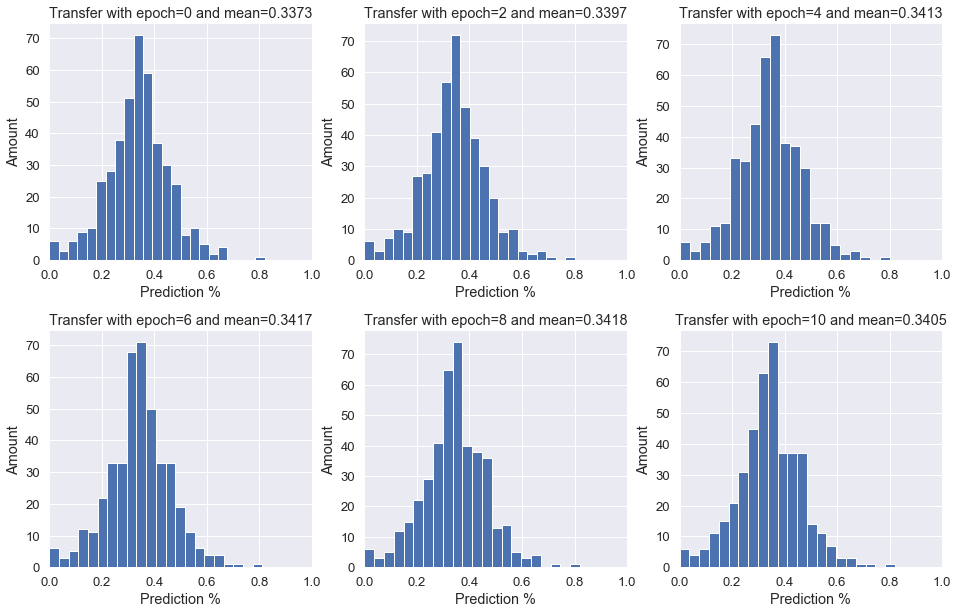

In [23]:
sns.set(style="whitegrid")
sns.set(font_scale=1.2)
# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(2,3,figsize=(16, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
labels = list(range(0,total_epoch+epochs_trans,epochs_trans))
epoch_means = np.mean(tmp,axis=1)
sns.despine(f, left=True, bottom=True)
for i in range(len(tmp)-1):
    sns.distplot(tmp[i],ax=ax[i//3,i%3],kde=False,hist_kws={"alpha": 1})
    ax[i//3,i%3].set_title(f'Transfer with epoch={labels[i]} and mean={epoch_means[i]:4.4f}')
    ax[i//3,i%3].set(xlim=(0,1.0))
    ax[i//3,i%3].set(xlabel="Prediction %", ylabel="Amount")
f.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\transfer.eps', format='eps', dpi=300)
#f.tight_layout()
plt.show()


# Prediction vs entropy

In [25]:
path = "Network/network_epoch_0.338_Feb-23-2020"

In [26]:
reload(net_lstm_w2v)
net_pred_ent = net_lstm_w2v.Brain()
net_pred_ent.lr = 0.001
net_pred_ent.bs = 10
net_pred_ent.seq_len=100
net_pred_ent.epochs = 100
net_pred_ent.epoch_test = 10

net_pred_ent.create_model()
net_pred_ent

In [27]:
net_pred_ent.model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [28]:
ents = []
for pep in tqdm(train_peps):
    data = utils.load_data([pep],bs=1,dat_type="all")[0]
    data = data.t().reshape(-1).cpu().numpy()[1:]
    if len(data)>1:
        ents.append(utils.entropy(list(data),tqdm_boo=True))

100%|████████████████████████████████████████████████████████████████████████████████| 427/427 [01:42<00:00,  4.17it/s]


In [29]:
ent_dict = {}
for pep, inf in zip(train_peps,ents):
    ent_dict[pep] = inf[1]

In [30]:
prediction_pep = net_pred_ent.test(dat_test,True)

Test loss: 1.189 | Test accu: 0.337 | Test accu expl: 0.821 | Test expl AUC: 0.712 | 

In [31]:
pred_pep_dict = {}
for key, value in prediction_pep[0].items():
    if prediction_pep[0][key]['total']!=0:
        pred_pep_dict[key] = value['correct']/value['total']

In [32]:
ent_values = [value for key,value in ent_dict.items() if key in pred_pep_dict.keys()]

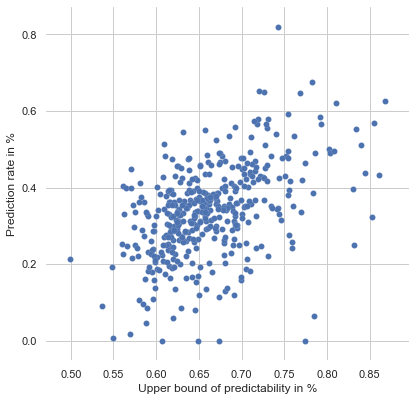

In [34]:
sns.set(style="whitegrid")

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x=ent_values, y=list(pred_pep_dict.values()),
                sizes=(1, 8), linewidth=0.1,
                ax=ax)
ax.set(xlabel="Upper bound of predictability in %", ylabel="Prediction rate in %")
f.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\entropy_vs_prediction.png', format='png', dpi=300)


In [41]:
np.corrcoef(ent_values,list(pred_pep_dict.values()))

array([[1.        , 0.46809068],
       [0.46809068, 1.        ]])

# Overfitting

In [14]:
reload(net_lstm)
train_rand = np.ones(10,dtype=int)
dat_train = utils.load_data(train_rand,bs = 10,dat_type="all_relabeled")
dat_test = {}
for pep in train_rand:
    dat_t = utils.load_data([pep],bs = 1, dat_type="test_relabeled")
    dat_w = utils.load_data([pep],bs = 1, dat_type="train_relabeled")
    dat_test[pep] = {"warm":dat_w,"test":dat_t}

In [15]:
net = net_lstm.Brain()
net.create_model()
net.epochs = 10000
net.train(dat_train,dat_test)

Epoch: 1/10000 | Avg epoch loss: 6.851 | Training accu: 0.000 | Test loss: 6.844 | Test accu: 0.000 | Test accu old: 0.000 | 
Epoch: 11/10000 | Avg epoch loss: 4.118 | Training accu: 0.279 | Test loss: 4.336 | Test accu: 0.276 | Test accu old: 0.207 | 
Epoch: 21/10000 | Avg epoch loss: 3.289 | Training accu: 0.276 | Test loss: 3.808 | Test accu: 0.276 | Test accu old: 0.207 | 
Epoch: 31/10000 | Avg epoch loss: 3.125 | Training accu: 0.286 | Test loss: 3.758 | Test accu: 0.276 | Test accu old: 0.207 | 
Epoch: 41/10000 | Avg epoch loss: 3.101 | Training accu: 0.292 | Test loss: 3.744 | Test accu: 0.276 | Test accu old: 0.207 | 
Epoch: 51/10000 | Avg epoch loss: 3.145 | Training accu: 0.281 | Test loss: 3.742 | Test accu: 0.276 | Test accu old: 0.207 | 
Epoch: 61/10000 | Avg epoch loss: 3.150 | Training accu: 0.273 | Test loss: 3.743 | Test accu: 0.276 | Test accu old: 0.207 | 
Epoch: 71/10000 | Avg epoch loss: 3.084 | Training accu: 0.284 | Test loss: 3.759 | Test accu: 0.276 | Test accu

Epoch: 1271/10000 | Avg epoch loss: 0.856 | Training accu: 0.793 | Test loss: 1.725 | Test accu: 0.655 | Test accu old: 0.655 | 
Epoch: 1281/10000 | Avg epoch loss: 0.953 | Training accu: 0.775 | Test loss: 1.707 | Test accu: 0.655 | Test accu old: 0.655 | 
Epoch: 1291/10000 | Avg epoch loss: 0.826 | Training accu: 0.784 | Test loss: 1.711 | Test accu: 0.655 | Test accu old: 0.655 | 
Epoch: 1301/10000 | Avg epoch loss: 0.922 | Training accu: 0.788 | Test loss: 1.717 | Test accu: 0.655 | Test accu old: 0.655 | 
Epoch: 1311/10000 | Avg epoch loss: 0.867 | Training accu: 0.793 | Test loss: 1.692 | Test accu: 0.655 | Test accu old: 0.655 | 
Epoch: 1321/10000 | Avg epoch loss: 0.818 | Training accu: 0.804 | Test loss: 1.699 | Test accu: 0.655 | Test accu old: 0.655 | 
Epoch: 1331/10000 | Avg epoch loss: 0.800 | Training accu: 0.801 | Test loss: 1.683 | Test accu: 0.655 | Test accu old: 0.655 | 
Epoch: 1341/10000 | Avg epoch loss: 0.818 | Training accu: 0.809 | Test loss: 1.695 | Test accu: 

Epoch: 2531/10000 | Avg epoch loss: 0.344 | Training accu: 0.928 | Test loss: 1.507 | Test accu: 0.759 | Test accu old: 0.759 | 
Epoch: 2541/10000 | Avg epoch loss: 0.310 | Training accu: 0.920 | Test loss: 1.566 | Test accu: 0.759 | Test accu old: 0.759 | 
Epoch: 2551/10000 | Avg epoch loss: 0.285 | Training accu: 0.939 | Test loss: 1.591 | Test accu: 0.759 | Test accu old: 0.759 | 
Epoch: 2561/10000 | Avg epoch loss: 0.264 | Training accu: 0.948 | Test loss: 1.557 | Test accu: 0.759 | Test accu old: 0.759 | 
Epoch: 2571/10000 | Avg epoch loss: 0.226 | Training accu: 0.947 | Test loss: 1.537 | Test accu: 0.759 | Test accu old: 0.759 | 
Epoch: 2581/10000 | Avg epoch loss: 0.329 | Training accu: 0.936 | Test loss: 1.527 | Test accu: 0.759 | Test accu old: 0.759 | 
Epoch: 2591/10000 | Avg epoch loss: 0.246 | Training accu: 0.944 | Test loss: 1.549 | Test accu: 0.759 | Test accu old: 0.759 | 
Epoch: 2601/10000 | Avg epoch loss: 0.176 | Training accu: 0.960 | Test loss: 1.484 | Test accu: 

KeyboardInterrupt: 

# Overfit W2V

In [4]:
reload(net_lstm_w2v)
#Draw random people
train_rand = np.arange(1,dtype=int)+1
train_rand = np.ones(10,dtype=int)
dat_train = utils.load_data(train_rand,1,dat_type="all_relabeled")
dat_train_w2v = utils.load_data_W2V(train_rand,1,dat_type="all_relabeled")
dat_train_both = torch.cat((dat_train,dat_train_w2v.reshape(1,-1,1)),0)

dat_test = {}
for pep in train_rand:
    dat_t = utils.load_data([pep],bs = 1, dat_type="test_relabeled")
    dat_w = utils.load_data([pep],bs = 1, dat_type="train_relabeled")
    dat_t_w2v = utils.load_data_W2V([pep],bs = 1, dat_type="test_relabeled")
    dat_w_w2v = utils.load_data_W2V([pep],bs = 1, dat_type="train_relabeled")
    dat_t_both = torch.cat((dat_t,dat_t_w2v.reshape(1,-1,1)),0)
    dat_w_both = torch.cat((dat_w,dat_w_w2v.reshape(1,-1,1)),0)
    dat_test[pep] = {"warm":dat_w_both,"test":dat_w_both}

In [5]:
for i in range(dat_test[1]['warm'][0].shape[0]):
    dat_test[1]['warm'][0,i,0] = i % 4+1
    dat_test[1]['warm'][5,i,0] = i % 4+1
    
for i in range(dat_test[1]['test'][0].shape[0]):
    dat_test[1]['test'][0,i,0] = i % 4+1
    dat_test[1]['test'][5,i,0] = i % 4+1

In [6]:
for i in range(dat_train_both.shape[1]):
    dat_train_both[0,i,0] = i % 4+1
    dat_train_both[5,i,0] = i % 4+1
    

In [7]:
reload(net_lstm_w2v)
net = net_lstm_w2v.Brain()
net.lr = 0.01
net.bs = 1
net.create_model()
net.epochs = 10000
net.train(dat_train_both,dat_test)

> d:\dropbox\peter_dropbox\uni\speciale\utils\net_lstm_w2v.py(94)train()
-> loss = F.cross_entropy(logits.reshape(-1,20), target[0].reshape(-1))
(Pdb) logits.shape
torch.Size([29, 1, 20])
(Pdb) target[0].shape
torch.Size([29, 1])
(Pdb) exit()


BdbQuit: 